
### <center>Airbnb Rental Prediction</center>

# Table of Contents

1. [Data Processing](#data_processing)
2. [Exploratory Data Analysis](#eda)
3. [Feature Engineering](#feature_engineering)
4. [Methodology](#methodology)
<br> 4.1 [Model 1: *Ridge*](#model_1)
<br> 4.2 [Model 2: *Decesion Tree Regressor*](#model_2)
<br> 4.3 [Model 3: *Random Forest Regressor*](#model_3)
<br> 4.4 [Model 4: *XGBoost*](#model_4)
<br> 4.5 [Model 5: *Stacking Model*](#model_5)

In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV,Ridge
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import StackingRegressor

In [2]:
rc = {"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 15, 
      "axes.titlesize": 15, "legend.fontsize": 12}
sns.set_context("notebook", rc=rc)  

## <font color = '#e64626'><a id='data_processing'>1. Data Processing</a></font>

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

response = 'price'

y_train = train[response]
y_test = train[response]

In [4]:
train.shape

(4000, 36)

In [5]:
test.shape

(2000, 35)

In [6]:
set(train.columns)-set(test.columns)

{'price'}

In [7]:
set(test.columns)-set(train.columns)

set()

In [8]:
pd.set_option('display.max_columns',None)

In [9]:
train.head()

id  price                                        description  \
0  2000    126  Maroubra/Little Bay Ocean Views/City and Airpo...   
1  2001    248  Stay in one of Sydney’s most sought out neighb...   
2  2002    164  Conveniently located between Sydney CBD and th...   
3  2003    475  Recently renovated free standing home, walk to...   
4  2004    263  This stunning apartment is located in the hear...   

                               neighborhood_overview  host_since  \
0  Close to beaches and cafes at La Perouse and L...  2016-04-15   
1  Surrounded by jaw dropping waterfront views, P...  2021-06-16   
2  There's Wulaba Park with kids playground and a...  2017-10-05   
3  Close to coffee shops , restaurants , movie ci...  2016-09-26   
4  Our neighbourhoods are quiet and friendly.<br ...  2019-01-04   

            host_location  host_response_time host_response_rate  \
0                     NaN  within a few hours               100%   
1       Sydney, Australia      within an hour               100%   
2       Sydney, Australia      within an hour               100%   
3  Queens Park, Australia                 NaN                NaN   
4                     NaN      within an hour               100%   

  host_acceptance_rate host_is_superhost host_neighbourhood  \
0                  75%                 f                NaN   
1                  94%                 f                NaN   
2                  98%                 t           Waterloo   
3                 100%                 f     Bondi Junction   
4                  97%                 f                NaN   

   host_listings_count  host_verifications host_identity_verified  \
0                  1.0  ['email', 'phone']                      f   
1                 32.0  ['email', 'phone']                      t   
2                  2.0  ['email', 'phone']                      t   
3                  1.0  ['email', 'phone']                      t   
4                  2.0  ['email', 'phone']                      t   

                                neighbourhood neighbourhood_cleansed  \
0      Little Bay, New South Wales, Australia               Randwick   
1         Pyrmont, New South Wales, Australia                 Sydney   
2        Waterloo, New South Wales, Australia                 Sydney   
3  Bondi Junction, New South Wales, Australia               Waverley   
4          Sydney, New South Wales, Australia                 Sydney   

   latitude  longitude         property_type        room_type  accommodates  \
0 -33.98233  151.23618  Private room in home     Private room             3   
1 -33.87019  151.19422    Entire rental unit  Entire home/apt             4   
2 -33.90163  151.21198    Entire rental unit  Entire home/apt             4   
3 -33.89327  151.25463           Entire home  Entire home/apt             6   
4 -33.86902  151.20504    Entire rental unit  Entire home/apt             5   

   bedrooms  beds                                          amenities  \
0       2.0   2.0  ["Dedicated workspace", "Freezer", "Smoke alar...   
1       2.0   3.0  ["Smoke alarm", "Indoor fireplace", "Kitchen",...   
2       2.0   4.0  ["Washer", "Smoke alarm", "Kitchen", "Room-dar...   
3       3.0   3.0  ["Washer", "Barbecue utensils", "Smoke alarm",...   
4       2.0   3.0  ["Dedicated workspace", "Shared pool", "Smoke ...   

   minimum_nights  maximum_nights  number_of_reviews  review_scores_rating  \
0               2             365                  4                  5.00   
1               2             365                 14                  4.07   
2               3              30                229                  4.94   
3               7              14                  2                  5.00   
4               1            1125                247                  4.74   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    5.00                       5.00                   4.75   
1         

In [10]:
test.head()

id                                        description  \
0   0  Our open-plan, two bedroom and bathroom apartm...   
1   1  [5% OFF FOR 7 - 20 NIGHTS, 30% OFF FOR 21 - 27...   
2   2  My apartment is in a central Sydney Terrace ho...   
3   3  This lovely two bedroom unit has been recently...   
4   4  My private, comfortable, leafy updated Art Dec...   

                               neighborhood_overview  host_since  \
0  There is a lovely cosmopolitan feel to the mix...  2014-01-27   
1  Impressive and extremely convenient surroundin...  2020-04-08   
2  Darlinghurst is trendy, central and charismati...  2015-03-08   
3  Quiet neighbourhood in good proximity to all k...  2015-11-01   
4  The close proximity to the north end of Bondi ...  2013-04-03   

                host_location  host_response_time host_response_rate  \
0          Kempsey, Australia      within an hour               100%   
1        Melbourne, Australia      within an hour               100%   
2           Sydney, Australia      within an hour               100%   
3  New South Wales, Australia  within a few hours               100%   
4           Sydney, Australia        within a day                75%   

  host_acceptance_rate host_is_superhost host_neighbourhood  \
0                  89%                 f                NaN   
1                  93%                 f                NaN   
2                  94%                 t                NaN   
3                  50%                 f                NaN   
4                  NaN                 f        North Bondi   

   host_listings_count  host_verifications host_identity_verified  \
0                  2.0  ['email', 'phone']                      t   
1                130.0           ['phone']                      t   
2                  1.0  ['email', 'phone']                      t   
3                  1.0  ['email', 'phone']                      t   
4                  2.0  ['email', 'phone']                      t   

                              neighbourhood neighbourhood_cleansed   latitude  \
0        Sydney, New South Wales, Australia              Warringah -33.756890   
1        Sydney, New South Wales, Australia                 Sydney -33.870130   
2  Darlinghurst, New South Wales, Australia                 Sydney -33.877920   
3     Hillsdale, New South Wales, Australia             Botany Bay -33.947811   
4   North Bondi, New South Wales, Australia               Waverley -33.886480   

    longitude       property_type        room_type  accommodates  bedrooms  \
0  151.285140  Entire rental unit  Entire home/apt             5       2.0   
1  151.205270  Entire rental unit  Entire home/apt             5       NaN   
2  151.221770    Entire townhouse  Entire home/apt             6       3.0   
3  151.226735  Entire rental unit  Entire home/apt             2       2.0   
4  151.278750  Entire rental unit  Entire home/apt             6       3.0   

   beds                                          amenities  minimum_nights  \
0   3.0  ["Beach essentials", "Washer", "Shared pool", ...               7   
1   2.0  ["Washer", "Pool", "Smoke alarm", "Kitchen", "...               1   
2   3.0  ["Washer", "Smoke alarm", "Kitchen", "Coffee m...               7   
3   2.0  ["Dedicated workspace", "Freezer", "Stainless ...               7   
4   4.0  ["Washer", "Outlet covers", "Host greets you",...              90   

   maximum_nights  number_of_reviews  review_scores_rating  \
0            1125                 25                  4.80   
1             365                 90                  4.41   
2            1125                163                  4.94   
3              40                  1                  5.00   
4             120                  4                  4.67   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    4.75                       4.79                   4.79   
1                    4.59                       4.

In [11]:
x_train = train.iloc[:,2:]
x_test = test.iloc[:,1:]

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           4000 non-null   int64  
 1   price                        4000 non-null   int64  
 2   description                  3998 non-null   object 
 3   neighborhood_overview        3590 non-null   object 
 4   host_since                   4000 non-null   object 
 5   host_location                3363 non-null   object 
 6   host_response_time           3869 non-null   object 
 7   host_response_rate           3869 non-null   object 
 8   host_acceptance_rate         3911 non-null   object 
 9   host_is_superhost            4000 non-null   object 
 10  host_neighbourhood           2444 non-null   object 
 11  host_listings_count          4000 non-null   float64
 12  host_verifications           4000 non-null   object 
 13  host_identity_veri

In [13]:
train.isna().sum()

id                                0
price                             0
description                       2
neighborhood_overview           410
host_since                        0
host_location                   637
host_response_time              131
host_response_rate              131
host_acceptance_rate             89
host_is_superhost                 0
host_neighbourhood             1556
host_listings_count               0
host_verifications                0
host_identity_verified            0
neighbourhood                   409
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bedrooms                        268
beds                             21
amenities                         0
minimum_nights                    0
maximum_nights                    0
number_of_reviews                 0
review_scores_rating        

In [14]:
test.isna().sum()

id                               0
description                      0
neighborhood_overview          219
host_since                       0
host_location                  285
host_response_time              53
host_response_rate              53
host_acceptance_rate            48
host_is_superhost                0
host_neighbourhood             782
host_listings_count              0
host_verifications               0
host_identity_verified           0
neighbourhood                  219
neighbourhood_cleansed           0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bedrooms                       124
beds                            12
amenities                        0
minimum_nights                   0
maximum_nights                   0
number_of_reviews                0
review_scores_rating             0
review_scores_accuracy           0
review_scores_cleanl

In [15]:
# percentage of missing value in train and test set
training_missing = (train.isna().sum() / train.shape[0]).round(4)
testing_missing = (test.isna().sum() / test.shape[0]).round(4)

missing=pd.concat([training_missing,testing_missing],axis = 1)
missing = missing.rename(columns = {0:'train',1:'test'})
missing[(missing['train']!=0) | (missing['test']!=0)]

train    test
price                  0.0000     NaN
description            0.0005  0.0000
neighborhood_overview  0.1025  0.1095
host_location          0.1592  0.1425
host_response_time     0.0328  0.0265
host_response_rate     0.0328  0.0265
host_acceptance_rate   0.0222  0.0240
host_neighbourhood     0.3890  0.3910
neighbourhood          0.1022  0.1095
bedrooms               0.0670  0.0620
beds                   0.0052  0.0060

In [16]:
y_train.describe()

count    4000.000000
mean      269.462500
std       236.604931
min        14.000000
25%       128.000000
50%       193.000000
75%       312.000000
max      1395.000000
Name: price, dtype: float64

<AxesSubplot:>

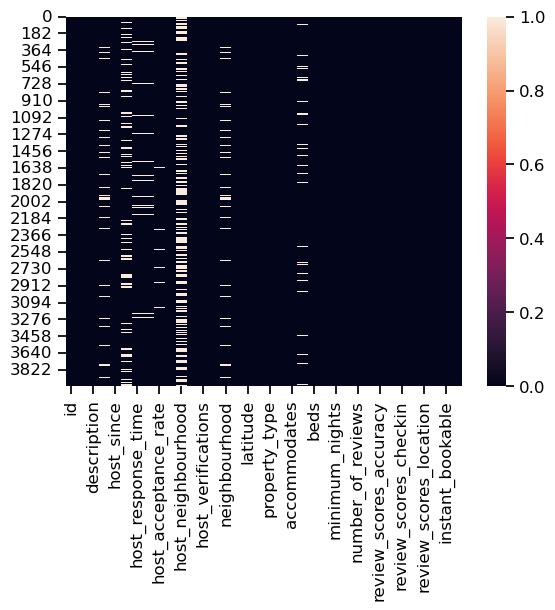

In [17]:
sns.heatmap(train.isnull(),cbar=True)
# host_neighbourhood has the most missing value

### Handle missing value

#### host_resonese_time

In [18]:
# the distribution of host_response_time
train['host_response_time'].value_counts()
test['host_response_time'].value_counts()


within an hour        1361
within a few hours     329
within a day           185
a few days or more      72
Name: host_response_time, dtype: int64

In [19]:
#define a function of substituting the NaN
def fill_NaN(data,column, new_value): 
    values = {column:new_value}
    data = data.fillna(value=values)
    return data

In [20]:
#'within an hour' has the largest number in 'host_response_time' column
#so the NA is substitued by the 'within an hour'
train=fill_NaN(train,"host_response_time", 'within an hour')
test=fill_NaN(test,"host_response_time", 'within an hour')

#### bedrooms & beds

In [21]:
#define a function that can get average value from array
def average(array):
    return sum(array) / len(array)

In [22]:
# the distribution of beds in training set
train['beds'].value_counts()

1.0     1703
2.0      987
3.0      606
4.0      359
5.0      156
6.0      104
7.0       34
8.0       12
9.0        8
10.0       3
12.0       3
16.0       2
15.0       1
21.0       1
Name: beds, dtype: int64

In [23]:
#define an array including the values in beds in data_train
beds_value_train=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 15.0, 16.0, 21.0]
beds_value_train= np.array(beds_value_train)

In [24]:
# the distribution of beds in test set
test['beds'].value_counts()

1.0     861
2.0     504
3.0     292
4.0     185
5.0      68
6.0      46
7.0      14
8.0       8
10.0      4
9.0       3
11.0      1
14.0      1
22.0      1
Name: beds, dtype: int64

In [25]:
#define an array including the values in beds in data_test
beds_value_test=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 22.0]
beds_value_test= np.array(beds_value_test)

In [26]:
#define a function of calculating the average value(bedrooms/beds) in different values(beds/bedrooms)
def avg_value_beds_bedrooms(value_used_distribution, value_used, value_processing):   
    Avg_values_bd=[]
    for j in value_used_distribution:
        a=[]
        for k_i in range(len(value_used)):
            i =  value_used[k_i]
            if i == j and math.isnan(value_processing[k_i]) == False:
                a.append(value_processing[k_i])
        # transfer a to array
        a = np.array(a)
        # calculate the average of a
        a_AVG= average(a)
        # round a to the nearest whole number
        a_AVG_integer=round(a_AVG)
        # input the average values of each value in another column
        Avg_values_bd.append(a_AVG_integer)
    return(Avg_values_bd)

    

In [27]:
# here I give an example to explain the meaning of Avg_bedrooms_values
# first, we find all values of bedrooms when beds is 1.0
# then we calculate the average value of all values above
# return this averge to Avg_bedrooms_values
# repeat for many times, we can get average bedroom values of each value of beds in train data
Avg_bedrooms_values_train = avg_value_beds_bedrooms(beds_value_train, train.beds, train.bedrooms)

# show the result 
Avg_bedrooms_values_train

[1, 2, 2, 3, 4, 4, 4, 5, 5, 5, 6, 5, 6, 5]

In [28]:
# Avg_bedrooms_values_test includes the average bedroom values of each value of beds in test data
Avg_bedrooms_values_test = avg_value_beds_bedrooms(beds_value_test, test.beds, test.bedrooms)

# show the result 
Avg_bedrooms_values_test

[1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 5, 5, 11]

In [29]:
# substitute the NaN by the average value 
def add_avg_values_in_NaN(value_used_distribution, value_used, value_processing, data, Avg_values_bedroom_bed):
    data=data
    for k_j in range(len(value_used_distribution)): 
        j = value_used_distribution[k_j]
        for k_i in range(len(value_used)):
            i = value_used[k_i]
            #substitute the Nan by the average value
            if i == j:
                if math.isnan(value_processing[k_i])== True:
                    value_processing[k_i]=Avg_values_bedroom_bed[k_j]
    return(data)

In [30]:
# here I give an example to explain
# there is a NaN in bedsroom clomn
# first we find the value of beds in the same row of NaN
# we assume the value of beds is 3.0
# based on the content above
# we know the average bedsroom value of each beds value 
# if the value of beds is 3.0, the average bedsroom value is 2.0
# finally, the NaN in bedsroom clomn is substituted by 2.0

# substitute the NaN in bedrooms by the average value of the same beds value in train data
train=add_avg_values_in_NaN(beds_value_train, train.beds, train.bedrooms, 
                                 train, Avg_bedrooms_values_train)

D:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [31]:
# substitute the NaN in bedrooms by the average value of the same beds value in test data
test=add_avg_values_in_NaN(beds_value_test, test.beds, test.bedrooms, 
                                test, Avg_bedrooms_values_test)

D:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [32]:
# we deal with the NaN in beds in the same way of the NaN in bedrooms

# the distribution of bedrooms
train['bedrooms'].value_counts()

1.0    2101
2.0    1112
3.0     483
4.0     205
5.0      79
6.0      17
7.0       1
Name: bedrooms, dtype: int64

In [33]:
#define an array including the values in bedrooms in data_train
bedrooms_value_train=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
bedrooms_value_train= np.array(bedrooms_value_train)

In [34]:
# average beds values of each value of bedrooms in train data
Avg_beds_values_train=avg_value_beds_bedrooms(bedrooms_value_train, train.bedrooms, train.beds)

# show the result
Avg_beds_values_train

[1, 3, 4, 5, 6, 9, 12]

In [35]:
# substitute the NaN in beds by the average value of the same bedrooms value in train data
train=add_avg_values_in_NaN(bedrooms_value_train, train.bedrooms, train.beds, 
                                 train, Avg_beds_values_train)

D:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [36]:
# the distribution of bedrooms
test['bedrooms'].value_counts()

1.0     1075
2.0      537
3.0      248
4.0       95
5.0       37
6.0        5
11.0       1
Name: bedrooms, dtype: int64

In [37]:
#define an array including the values in bedrooms in dest_train
bedrooms_value_test=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 11.0]
bedrooms_value_test= np.array(bedrooms_value_test)

In [38]:
# average beds values of each value of bedrooms in test data
Avg_beds_values_test=avg_value_beds_bedrooms(bedrooms_value_test, test.bedrooms, test.beds)


# show the result
Avg_beds_values_test

[1, 3, 4, 5, 7, 8, 22]

In [39]:
# substitute the NaN in beds by the average value of the same bedrooms value in test data
test=add_avg_values_in_NaN(bedrooms_value_test, test.bedrooms, test.beds, 
                                test, Avg_beds_values_test)

D:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [40]:
# the function tries to find 
# when the value in one column is NaN ,what the value of the other column of same row is.
def value_when_the_other_Nan(input_value, output_value):
    nan_values=[]
    for k_i in range(len(input_value)):  
        i = input_value[k_i]
        if math.isnan(input_value[k_i])== True:
            nan_values.append(output_value[k_i])
    return(nan_values)

In [41]:
# we find there are still two NaN in train data.bedrooms
# so we find what the values of beds are when bedrooms are NaN
nan_beds_trian=value_when_the_other_Nan(train.bedrooms, train.beds)
nan_beds_trian

[nan, nan]

In [42]:
# we find there are still two NaN in test data.bedrooms
# so we find what the values of beds are when bedrooms are NaN
nan_beds_test=value_when_the_other_Nan(test.bedrooms, test.beds)
nan_beds_test

[nan, nan]

In [43]:
#calculate the average and substitute the Nan by the average
def cal_avg_add_in_Na(input_value):
    a=[]
    for k_j in range(len(input_value)): 
        j = input_value[k_j]
        if math.isnan(j) == False:
            a.append(j)
    a_AVG= average(a)
    a_AVG=round(a_AVG)
    for k_j in range(len(input_value)): 
        j = input_value[k_j]
        if math.isnan(j) == True:
            input_value[k_j]=a_AVG

In [44]:
#substitute the 2 NaN in bedrooms/beds in train/test dataset
cal_avg_add_in_Na(train.bedrooms)
cal_avg_add_in_Na(train.beds)
cal_avg_add_in_Na(test.bedrooms)
cal_avg_add_in_Na(test.beds)

D:\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


#### host_response_rate

In [45]:
# this function is to calculate the average value of one column
# this function also return the values of this column in an array type
def calculate_avg_value_of_column(input_value):
    host_response_rate_np=np.array(input_value)
    for k_i in range(len(host_response_rate_np)):
        i = host_response_rate_np[k_i]
        if isinstance(i,str) == True:
            i=i[:-1]    
            i=float(i)/100
            host_response_rate_np[k_i] = i
    a=[]
    for k_i in range(len(host_response_rate_np)):
        i = host_response_rate_np[k_i]
        if math.isnan(host_response_rate_np[k_i]) == False:
            a.append(host_response_rate_np[k_i])

    a_AVG= average(a)
    a_AVG= round(a_AVG,2)
    return(a_AVG, host_response_rate_np)

In [46]:
# calculate the average value of host_response_rate in train data
# get the values of host_response_rate in an array type
avg_host_response_rate, host_response_rate_list=calculate_avg_value_of_column(train.host_response_rate)
avg_host_response_rate

# calculate the average value of host_response_rate in test data
# get the values of host_response_rate in an array type
avg_host_response_rate_test, host_response_rate_test_list=calculate_avg_value_of_column(test.host_response_rate)
avg_host_response_rate_test

0.94

In [47]:
# sustitute the NaN by the average value and return this array
def substitue_Nan_by_avg_value(input_value, avg_value):
    for k_i in range(len(input_value)):
        i = float(input_value[k_i])
        if math.isnan(input_value[k_i]) == True:
            input_value[k_i]=float(avg_value)
    return(input_value)

In [48]:
# sustitute the NaN by the average value in train data
host_response_rate_list=substitue_Nan_by_avg_value(host_response_rate_list, avg_host_response_rate)
train=train.drop(['host_response_rate'],axis=1)
train.insert(4, 'host_response_rate', host_response_rate_list)

# sustitute the NaN by the average value in test data
host_response_rate_test_list=substitue_Nan_by_avg_value(host_response_rate_test_list, avg_host_response_rate_test)
test=test.drop(['host_response_rate'],axis=1)
test.insert(3, 'host_response_rate', host_response_rate_test_list)

In [49]:
train['host_response_rate'] = pd.to_numeric(train['host_response_rate'])
test['host_response_rate'] = pd.to_numeric(test['host_response_rate'])

#### host_acceptance_rate

In [50]:
# calculate the average value of host_acceptance_rate in train data
# get the values of host_acceptance_rate in an array type
avg_host_acceptance_rate, host_acceptance_rate_list=calculate_avg_value_of_column(train.host_acceptance_rate)
avg_host_acceptance_rate

# calculate the average value of host_acceptance_rate in test data
# get the values of host_acceptance_rate in an array type
avg_host_acceptance_rate_test, host_acceptance_rate_test_list=calculate_avg_value_of_column(test.host_acceptance_rate)
avg_host_acceptance_rate_test

0.87

In [51]:
# sustitute the NaN by the average value in train data
host_acceptance_rate_list=substitue_Nan_by_avg_value(host_acceptance_rate_list, avg_host_acceptance_rate)
train=train.drop(['host_acceptance_rate'],axis=1)
train.insert(5, 'host_acceptance_rate', host_acceptance_rate_list)


# sustitute the NaN by the average value in test data
host_acceptance_rate_test_list=substitue_Nan_by_avg_value(host_acceptance_rate_test_list, avg_host_acceptance_rate_test)
test=test.drop(['host_acceptance_rate'],axis=1)
test.insert(4, 'host_acceptance_rate', host_acceptance_rate_test_list)

In [52]:
train['host_acceptance_rate'] = pd.to_numeric(train['host_acceptance_rate'])
test['host_acceptance_rate'] = pd.to_numeric(test['host_acceptance_rate'])

In [53]:
train['host_acceptance_rate']

0       0.75
1       0.94
2       0.98
3       1.00
4       0.97
        ... 
3995    0.49
3996    0.93
3997    0.71
3998    1.00
3999    0.93
Name: host_acceptance_rate, Length: 4000, dtype: float64

In [54]:
x_train = train.iloc[:,2:]
x_test = test.iloc[:,1:]

#### Check null value again

now only localization values have empty value

In [55]:
train.isna().sum()

id                                0
price                             0
description                       2
neighborhood_overview           410
host_response_rate                0
host_acceptance_rate              0
host_since                        0
host_location                   637
host_response_time                0
host_is_superhost                 0
host_neighbourhood             1556
host_listings_count               0
host_verifications                0
host_identity_verified            0
neighbourhood                   409
neighbourhood_cleansed            0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bedrooms                          0
beds                              0
amenities                         0
minimum_nights                    0
maximum_nights                    0
number_of_reviews                 0
review_scores_rating        

In [56]:
test.isna().sum()

id                               0
description                      0
neighborhood_overview          219
host_response_rate               0
host_acceptance_rate             0
host_since                       0
host_location                  285
host_response_time               0
host_is_superhost                0
host_neighbourhood             782
host_listings_count              0
host_verifications               0
host_identity_verified           0
neighbourhood                  219
neighbourhood_cleansed           0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bedrooms                         0
beds                             0
amenities                        0
minimum_nights                   0
maximum_nights                   0
number_of_reviews                0
review_scores_rating             0
review_scores_accuracy           0
review_scores_cleanl

<AxesSubplot:>

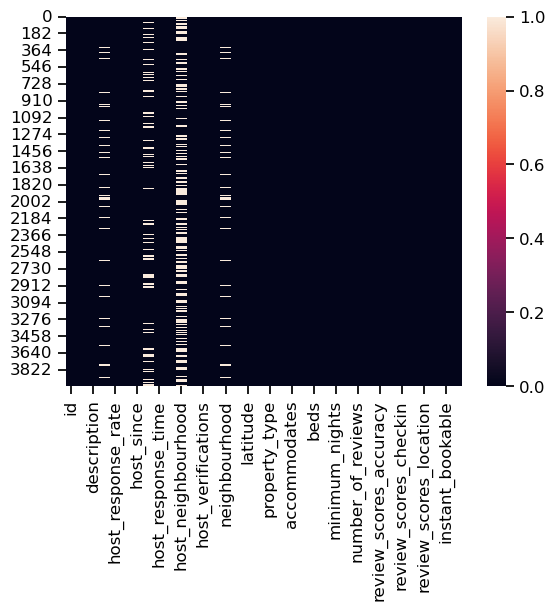

In [57]:
sns.heatmap(train.isnull(),cbar=True)
# host_neighbourhood has the most missing value

In [58]:
cat= x_train.loc[:,train.dtypes=='object']
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   description             3998 non-null   object
 1   neighborhood_overview   3590 non-null   object
 2   host_since              4000 non-null   object
 3   host_location           3363 non-null   object
 4   host_response_time      4000 non-null   object
 5   host_is_superhost       4000 non-null   object
 6   host_neighbourhood      2444 non-null   object
 7   host_verifications      4000 non-null   object
 8   host_identity_verified  4000 non-null   object
 9   neighbourhood           3591 non-null   object
 10  neighbourhood_cleansed  4000 non-null   object
 11  property_type           4000 non-null   object
 12  room_type               4000 non-null   object
 13  amenities               4000 non-null   object
 14  instant_bookable        4000 non-null   object
dtypes: o

In [59]:
cat.nunique()

description               3915
neighborhood_overview     3178
host_since                1759
host_location              375
host_response_time           4
host_is_superhost            2
host_neighbourhood         157
host_verifications           6
host_identity_verified       2
neighbourhood              438
neighbourhood_cleansed      38
property_type               53
room_type                    4
amenities                 3908
instant_bookable             2
dtype: int64

In [60]:
num = x_train.loc[:,train.dtypes!='object']
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_rate           4000 non-null   float64
 1   host_acceptance_rate         4000 non-null   float64
 2   host_listings_count          4000 non-null   float64
 3   latitude                     4000 non-null   float64
 4   longitude                    4000 non-null   float64
 5   accommodates                 4000 non-null   int64  
 6   bedrooms                     4000 non-null   float64
 7   beds                         4000 non-null   float64
 8   minimum_nights               4000 non-null   int64  
 9   maximum_nights               4000 non-null   int64  
 10  number_of_reviews            4000 non-null   int64  
 11  review_scores_rating         4000 non-null   float64
 12  review_scores_accuracy       4000 non-null   float64
 13  review_scores_clea

In [61]:
y_train.head()

0    126
1    248
2    164
3    475
4    263
Name: price, dtype: int64

In [62]:
training_missing = train.isna().sum() / train.shape[0]
training_missing.round(4)

id                             0.0000
price                          0.0000
description                    0.0005
neighborhood_overview          0.1025
host_response_rate             0.0000
host_acceptance_rate           0.0000
host_since                     0.0000
host_location                  0.1592
host_response_time             0.0000
host_is_superhost              0.0000
host_neighbourhood             0.3890
host_listings_count            0.0000
host_verifications             0.0000
host_identity_verified         0.0000
neighbourhood                  0.1022
neighbourhood_cleansed         0.0000
latitude                       0.0000
longitude                      0.0000
property_type                  0.0000
room_type                      0.0000
accommodates                   0.0000
bedrooms                       0.0000
beds                           0.0000
amenities                      0.0000
minimum_nights                 0.0000
maximum_nights                 0.0000
number_of_re

## <font color = '#e64626'><a id='eda'>2. Exploratory Data Analysis</a></font>

The example provided here is to show you how to save figures of an appropriate resolution by using <tt>dpi</tt>. The <tt>bbox_inches='tight'</tt> is used to ensure that when your figure is saved, there are no cropping issues. In the example, the figure is saved as a <tt>.png</tt>, but you may also want to save your figures as a <tt>.pdf</tt>.

When you produce figures, make sure that all axes labels are readable. This notebook has been setup so that in general, the fontsizes are readable. These are defined in cell [2].

You can change the dimensions of the figure by changing the `figsize`.

Text(0, 0.5, 'Number of listings')

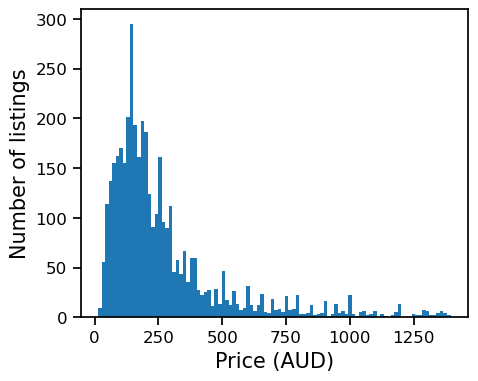

In [63]:
plt.figure(figsize=(5, 4))
plt.hist(y_train, bins=100);
plt.xlabel('Price (AUD)')
plt.ylabel('Number of listings')

# this is a positive skewed data

In [64]:
y_train.describe() 

count    4000.000000
mean      269.462500
std       236.604931
min        14.000000
25%       128.000000
50%       193.000000
75%       312.000000
max      1395.000000
Name: price, dtype: float64

In [65]:
description = y_train.describe()

description.loc['Price skew'] = y_train.skew()
description.loc['Price kurtosis'] = y_train.kurt()

description.round(2)

# skew = 0: same sample on left and right => normal distribution
# Acq_expense is very close to 0

# kurtosis: how heavy is the tail (how much the dis) 
# the high kurtosis, the more probability having on the tail
# kurtosis>0, heavy tail

count             4000.00
mean               269.46
std                236.60
min                 14.00
25%                128.00
50%                193.00
75%                312.00
max               1395.00
Price skew           2.21
Price kurtosis       5.36
Name: price, dtype: float64

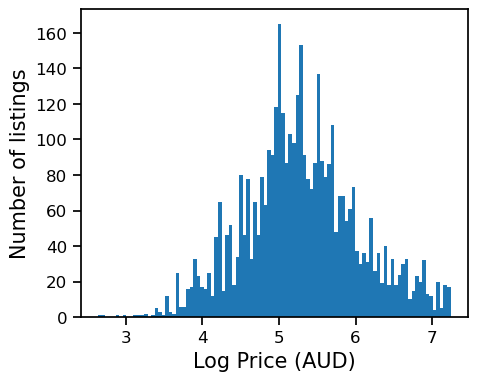

In [66]:
plt.figure(figsize=(5, 4))
plt.hist(np.log(y_train), bins=100);
plt.xlabel('Log Price (AUD)')
plt.ylabel('Number of listings')
plt.savefig('hist_of_response.png', dpi=300, bbox_inches='tight')
# Log Price, not skew now

In [67]:
log_y_train = np.log(y_train)

In [68]:
log_y_train.skew()

0.15330603799483272

In [69]:
log_y_train.kurt()

-0.0019377419060306877

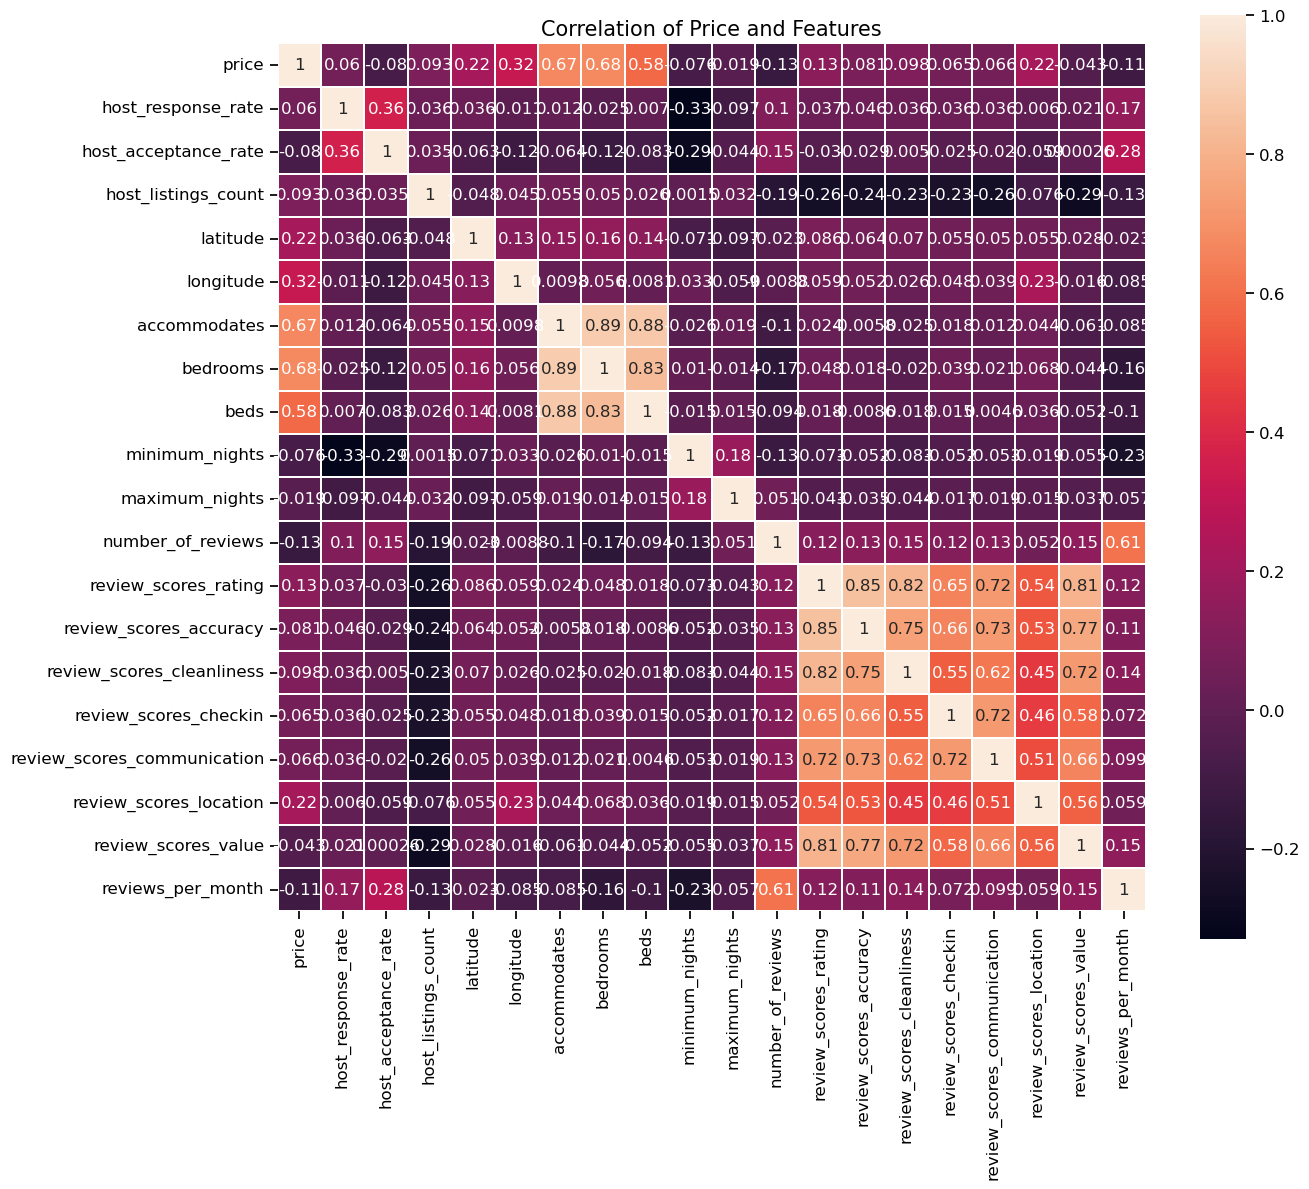

In [70]:
data = pd.concat([log_y_train,num],axis = 1)

plt.figure(figsize=(14,12))
plt.title('Correlation of Price and Features')
sns.heatmap(data.corr(),linewidths=0.1,vmax=1.0,
            square=True,linecolor='white',annot=True)
plt.show()

# accommodates,bedrooms, beds are highly correlated with price
# latitude, longitude, number_of_reviews,review_score_rating, review_scores_location, reviews_per_month are correlated with price

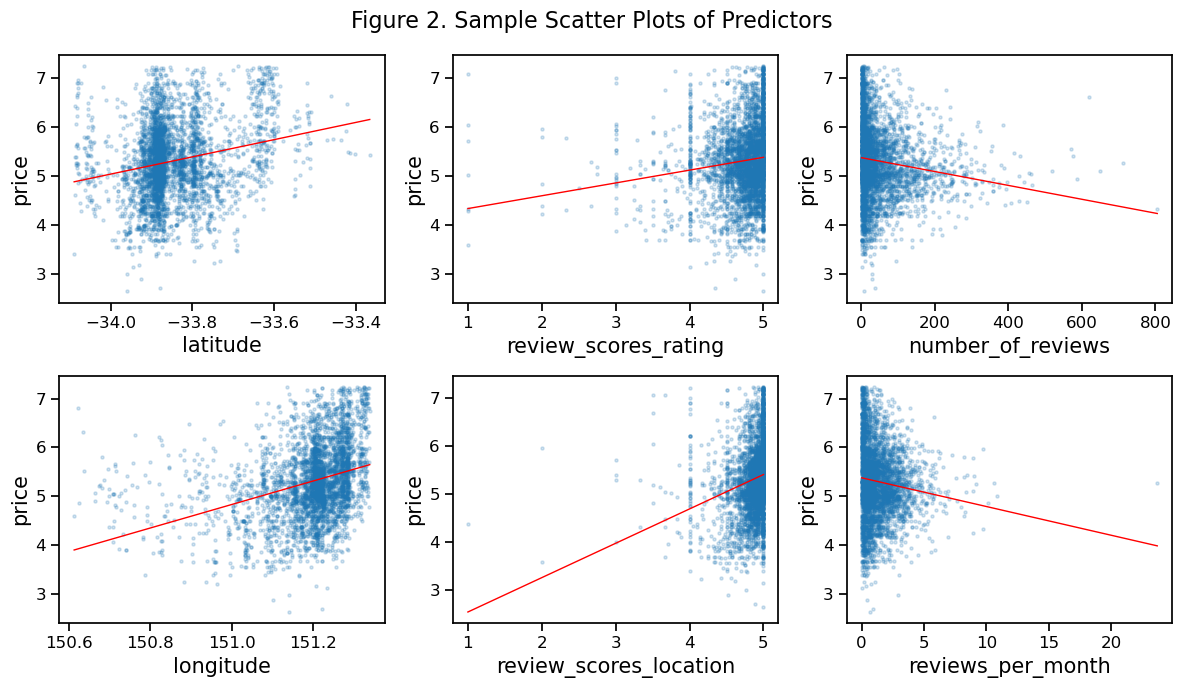

In [75]:
select_predictors = ['latitude', 'longitude', 'review_scores_rating', 'review_scores_location', 'number_of_reviews','reviews_per_month']

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
for i in range(len(select_predictors)):
    ax = sns.regplot(x=select_predictors[i], y=log_y_train, ax=axs[i%2][(i//2)%3], data=train, ci=None, 
                scatter_kws={'s':5, 'alpha':0.2}, line_kws={'color':'red', 'linewidth':1})
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
fig.suptitle('Figure 2. Sample Scatter Plots of Predictors', fontsize=16)
plt.tight_layout()

In [76]:
num_predictors = num.columns.values

In [77]:
len(num_predictors)

19

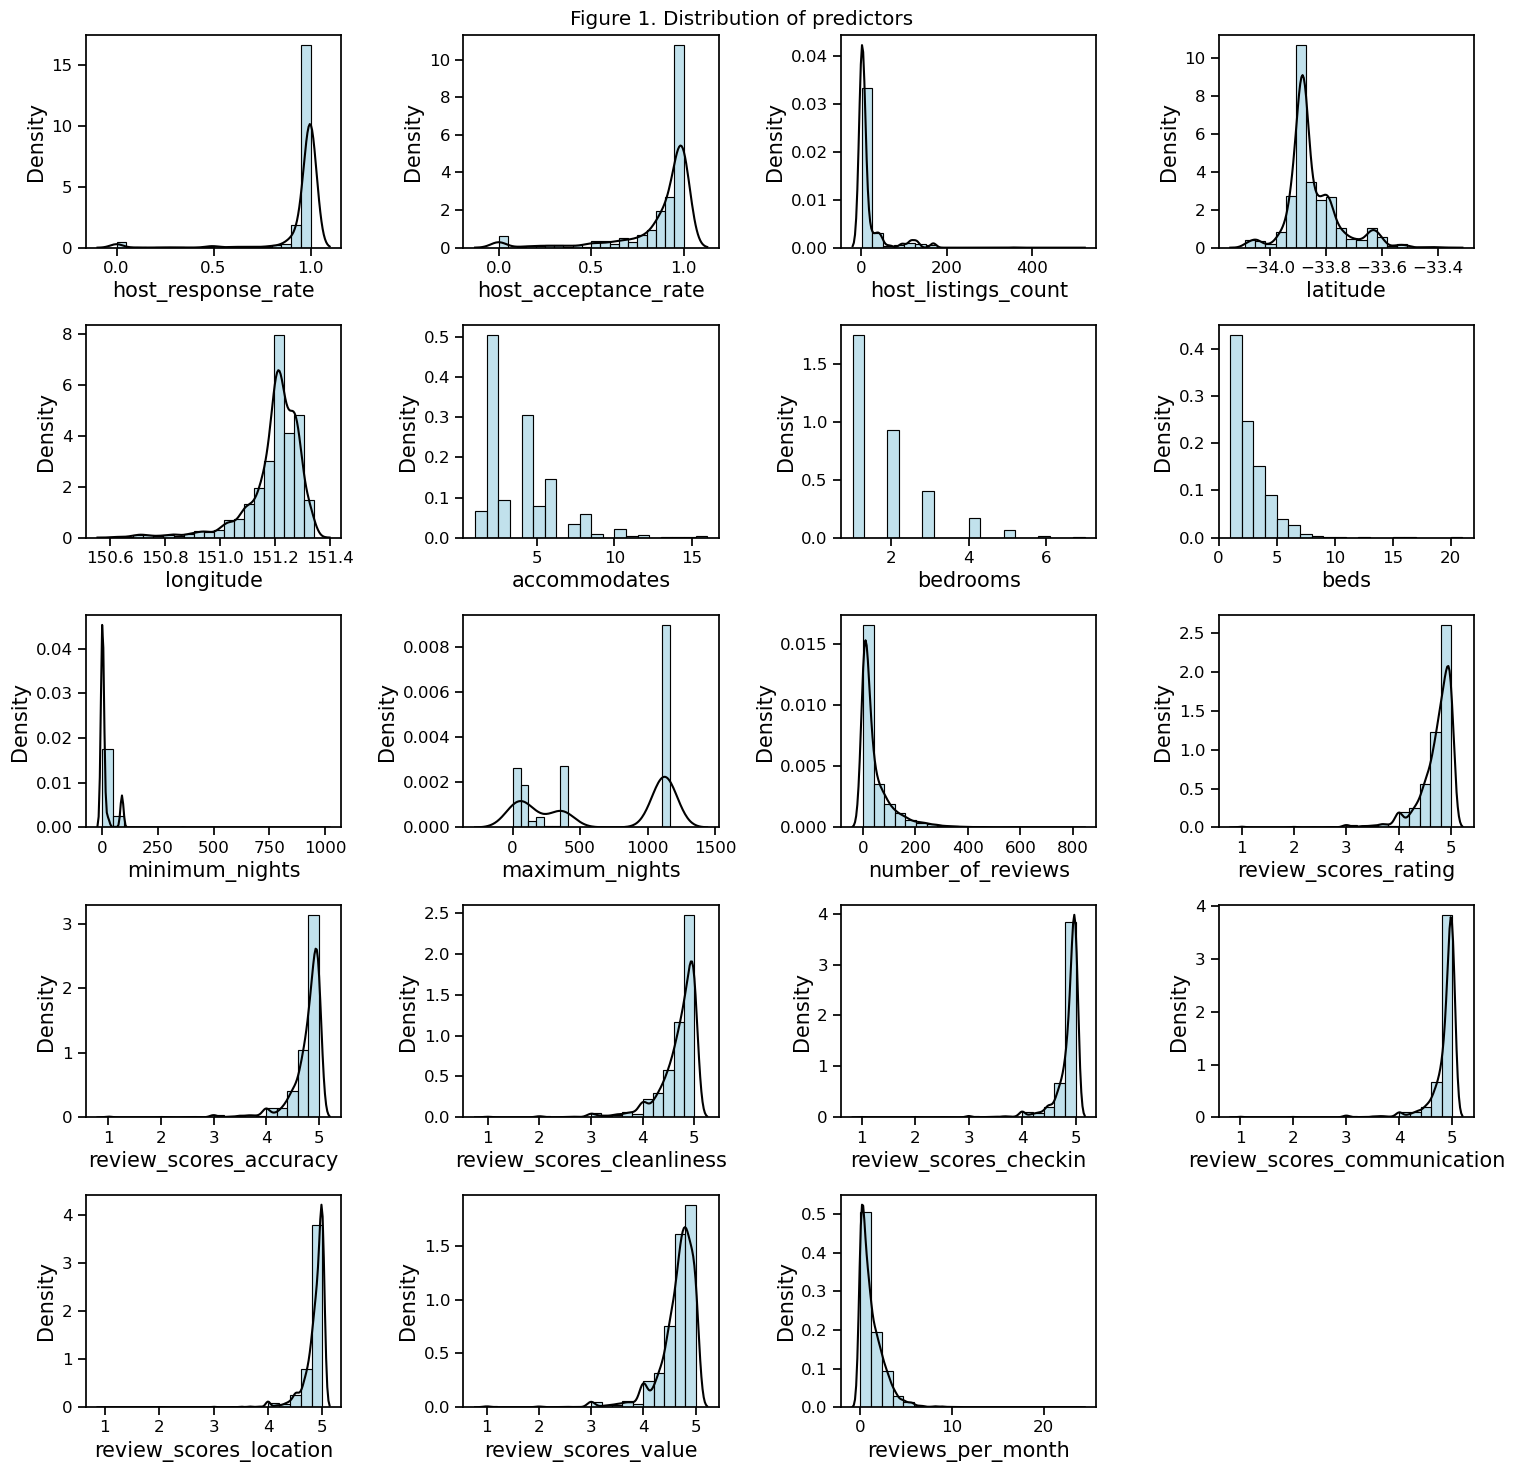

In [78]:
n_preds = len(num_predictors)
rows = 5
cols = 4
fig = plt.figure(figsize = (15,15))
for i in range(n_preds):
    plt.subplot(rows, cols, i + 1)
    # hisgram plot
    # density: continous line
    sns.histplot(x_train.loc[:, num_predictors[i]], stat='density', bins=20, color='lightblue', edgecolor='black')
    if num_predictors[i] not in ['accommodates', 'bedrooms', 'beds']:
        sns.kdeplot(data=x_train, x=num_predictors[i], color = 'black')
        plt.xlabel(num_predictors[i])
        plt.ylabel('Density')
    
fig.suptitle('Figure 1. Distribution of predictors')
plt.tight_layout()

In [ ]:
#we think the value>mean+3*standard_deviation or value<mean-3*standard_deviation are outliers
#we replace the outliers by the average value in this column
def judge_outlier_replace_AVG(input_column):
    #calculate the value of mean+3*standard_deviation
    #calculate the value of mean-3*standard_deviation
    std=np.std(input_column)
    std_3=3*std
    mean=np.mean(input_column)
    lower_limit=mean-std_3
    up_limit=mean+std_3
    
    #calculate the average value
    a=[]
    for k_j in range(len(input_column)): 
        j = input_column[k_j]
        if math.isnan(j) == False:
            a.append(j)
    a_AVG= average(a)
    a_AVG=round(a_AVG)
    
    #if the value is outlier, then replace it by the average
    for k_j in range(len(input_column)): 
        j = input_column[k_j]
        if j>up_limit or j<lower_limit:
            input_column[k_j]=a_AVG

# replace the outlier by the average value in bedrooms/beds of train/test dataset
judge_outlier_replace_AVG(train.bedrooms)
judge_outlier_replace_AVG(test.bedrooms)
judge_outlier_replace_AVG(train.beds)
judge_outlier_replace_AVG(test.beds)
judge_outlier_replace_AVG(train.accommodates)
judge_outlier_replace_AVG(test.accommodates)

        

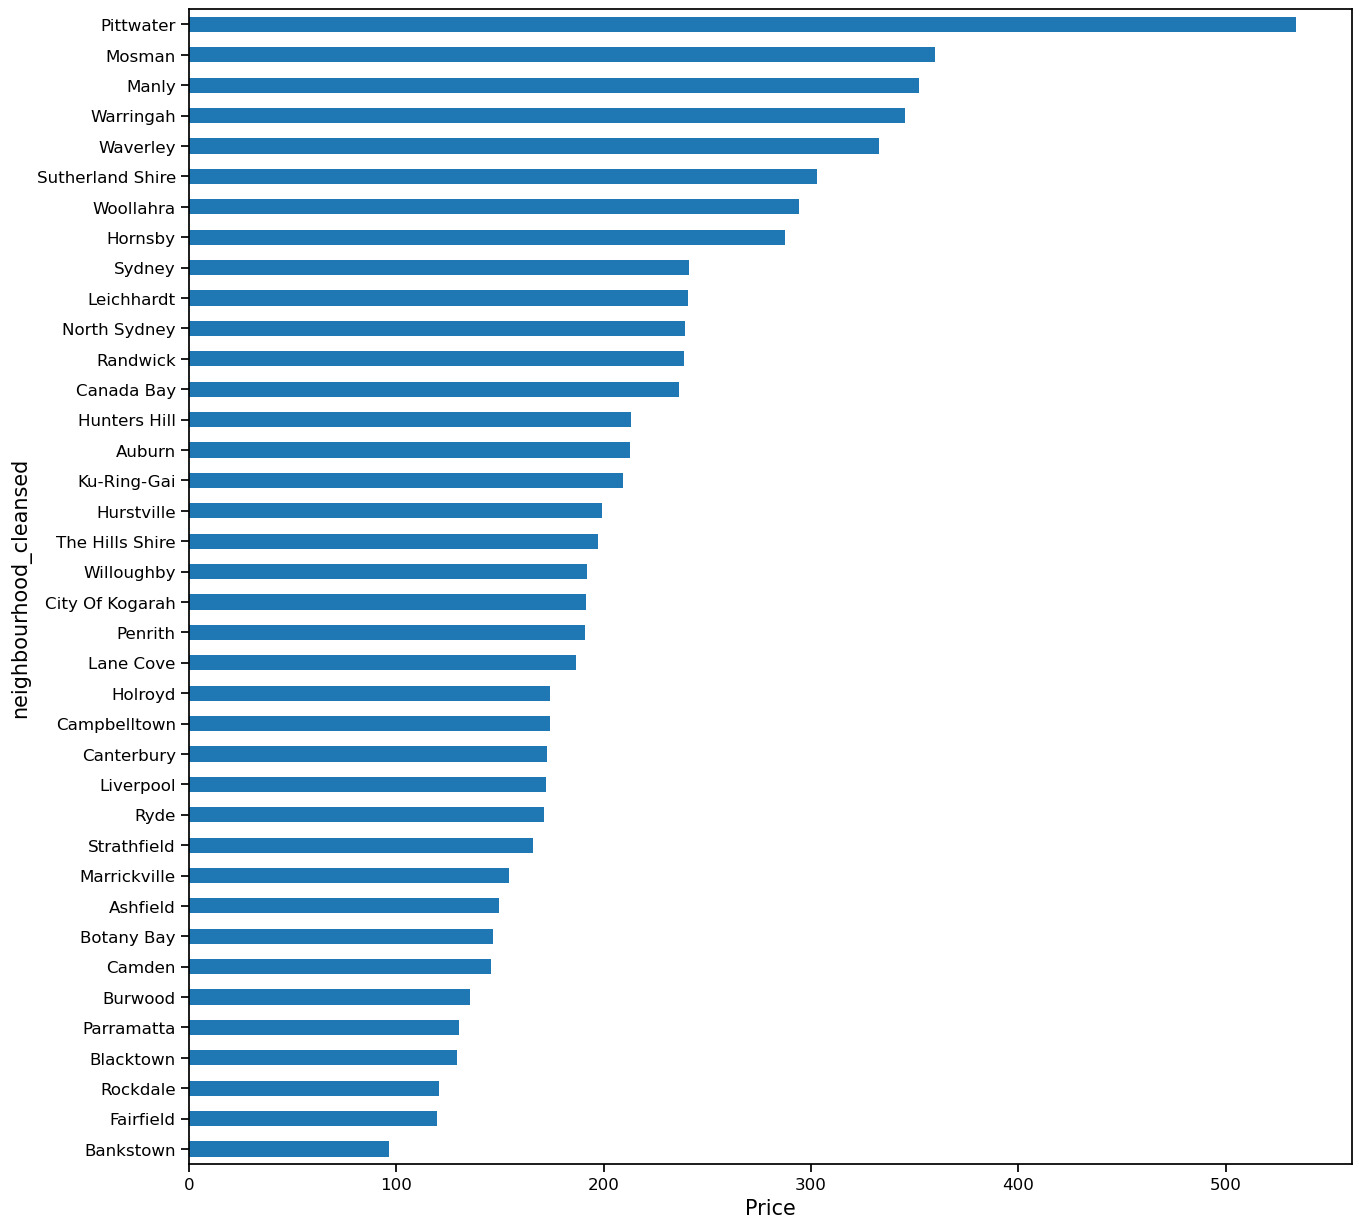

In [79]:
plt.figure(figsize = (15,15))
train.groupby('neighbourhood_cleansed')['price'].mean().sort_values().plot(kind = 'barh',)
plt.xlabel('Price')
plt.show()

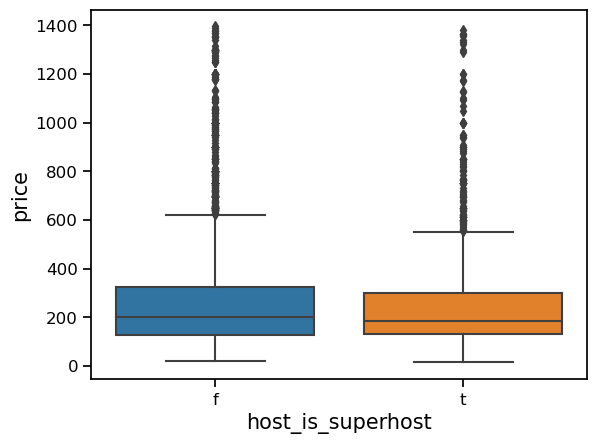

In [80]:
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(x=train['host_is_superhost'],y=train['price'])
plt.show()
# not useful variable

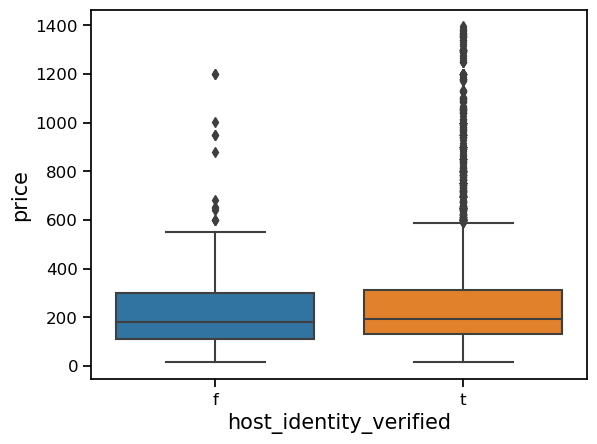

In [81]:
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(x=train['host_identity_verified'],y=train['price'])
plt.show()
# not useful variable

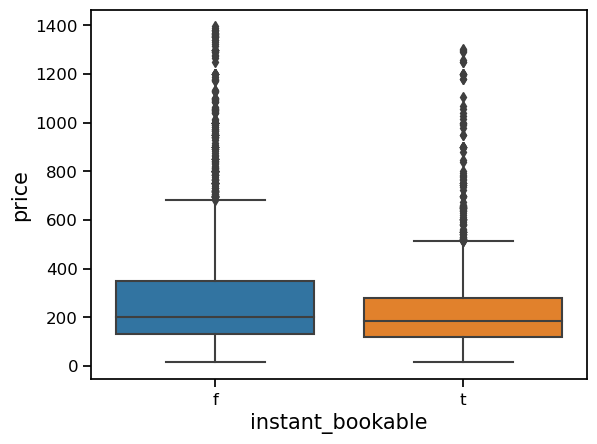

In [82]:
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(x=train['instant_bookable'],y=train['price'])
plt.show()
# can be added

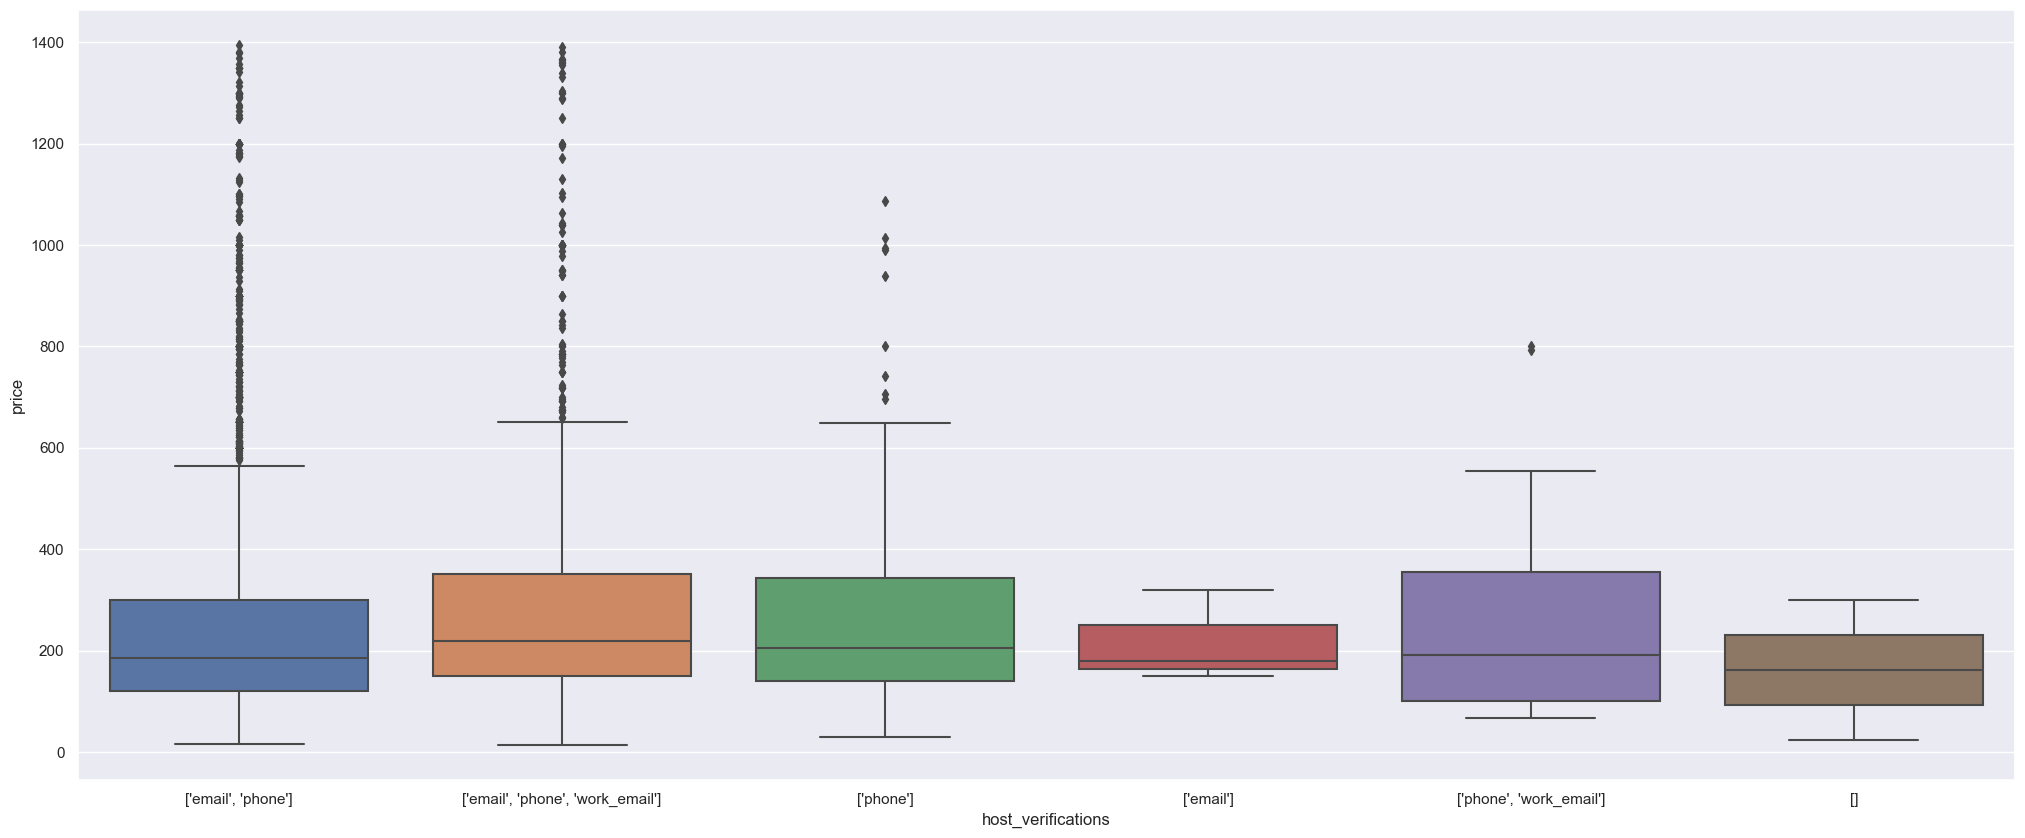

In [83]:
sns.set(rc={'figure.figsize':(25,10)})
sns.boxplot(x=train['host_verifications'],y=train['price'])
plt.show()
# can be added

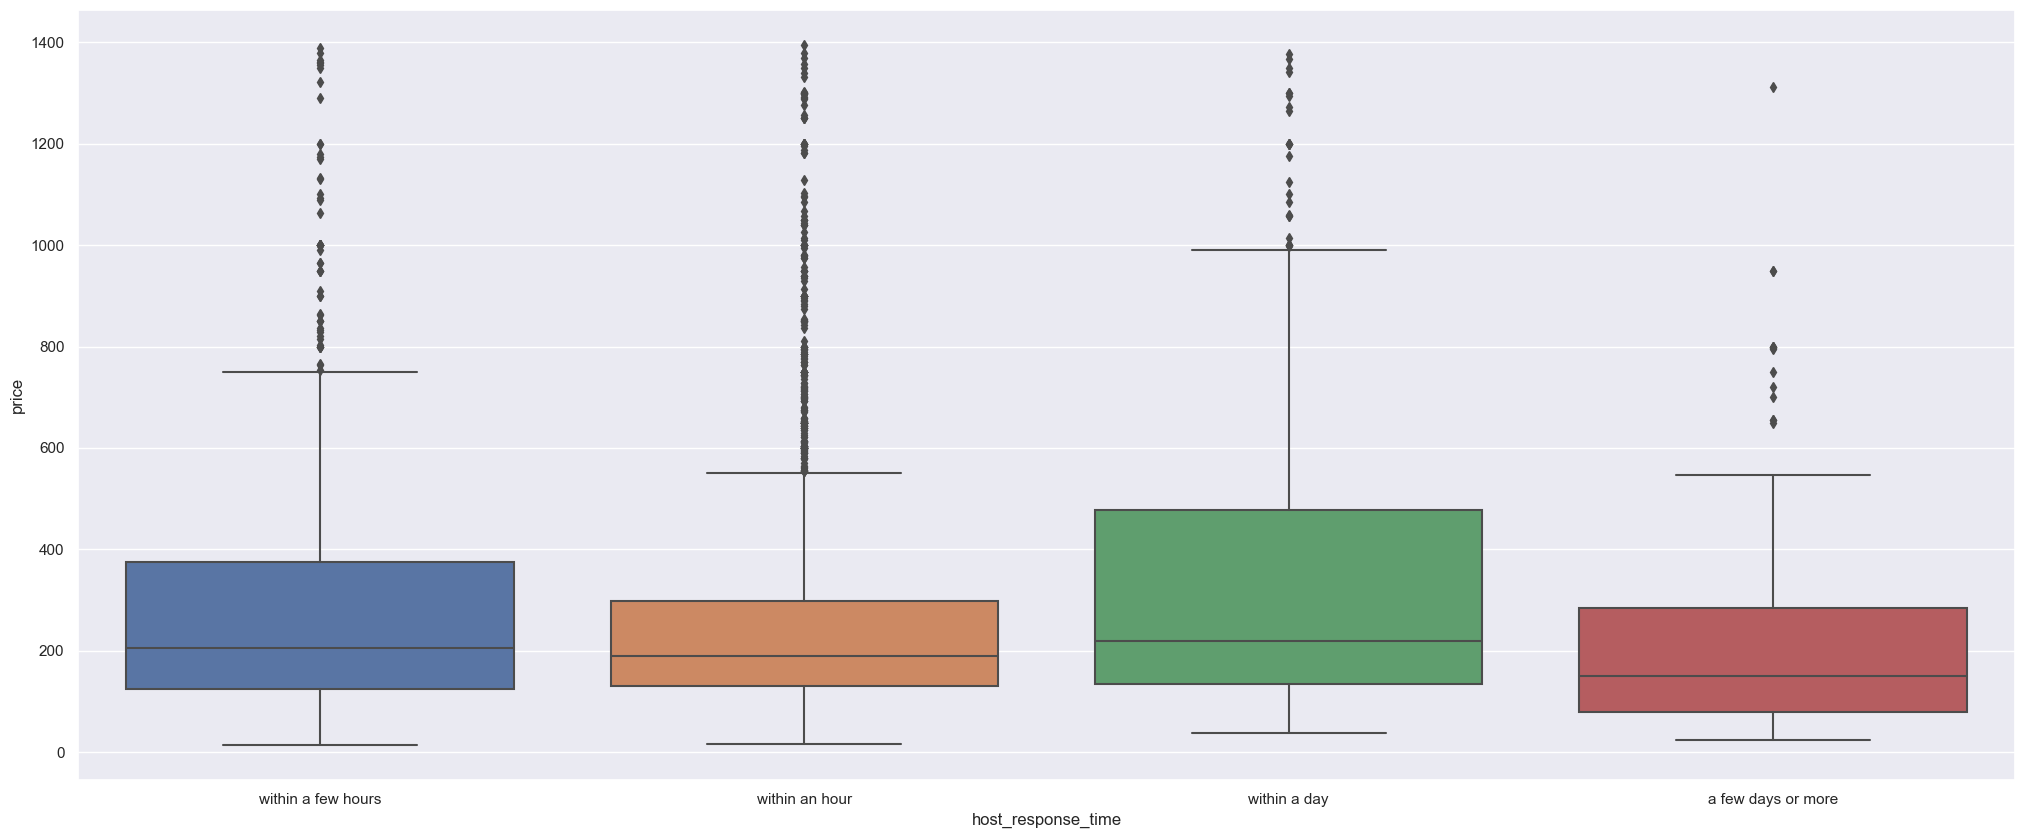

In [84]:
sns.set(rc={'figure.figsize':(25,10)})
sns.boxplot(x=train['host_response_time'],y=train['price'])
plt.show()
# can be added but not too much difference

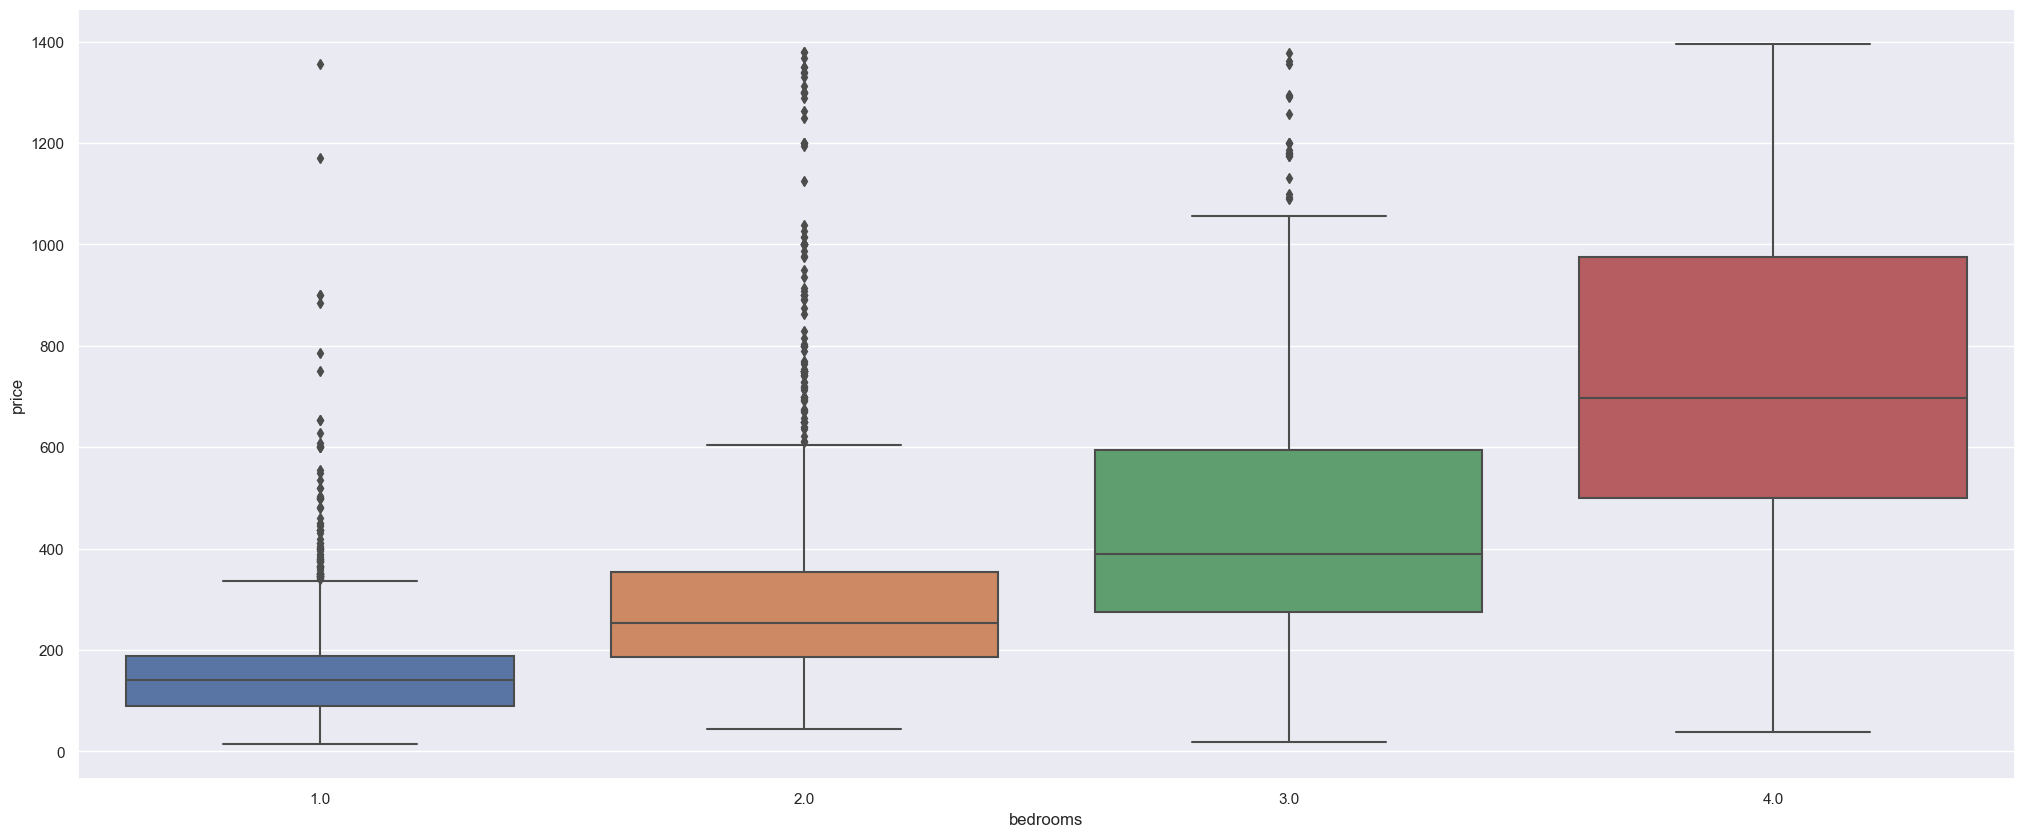

In [85]:
sns.boxplot(x=train['bedrooms'],y=train['price'])
plt.show()

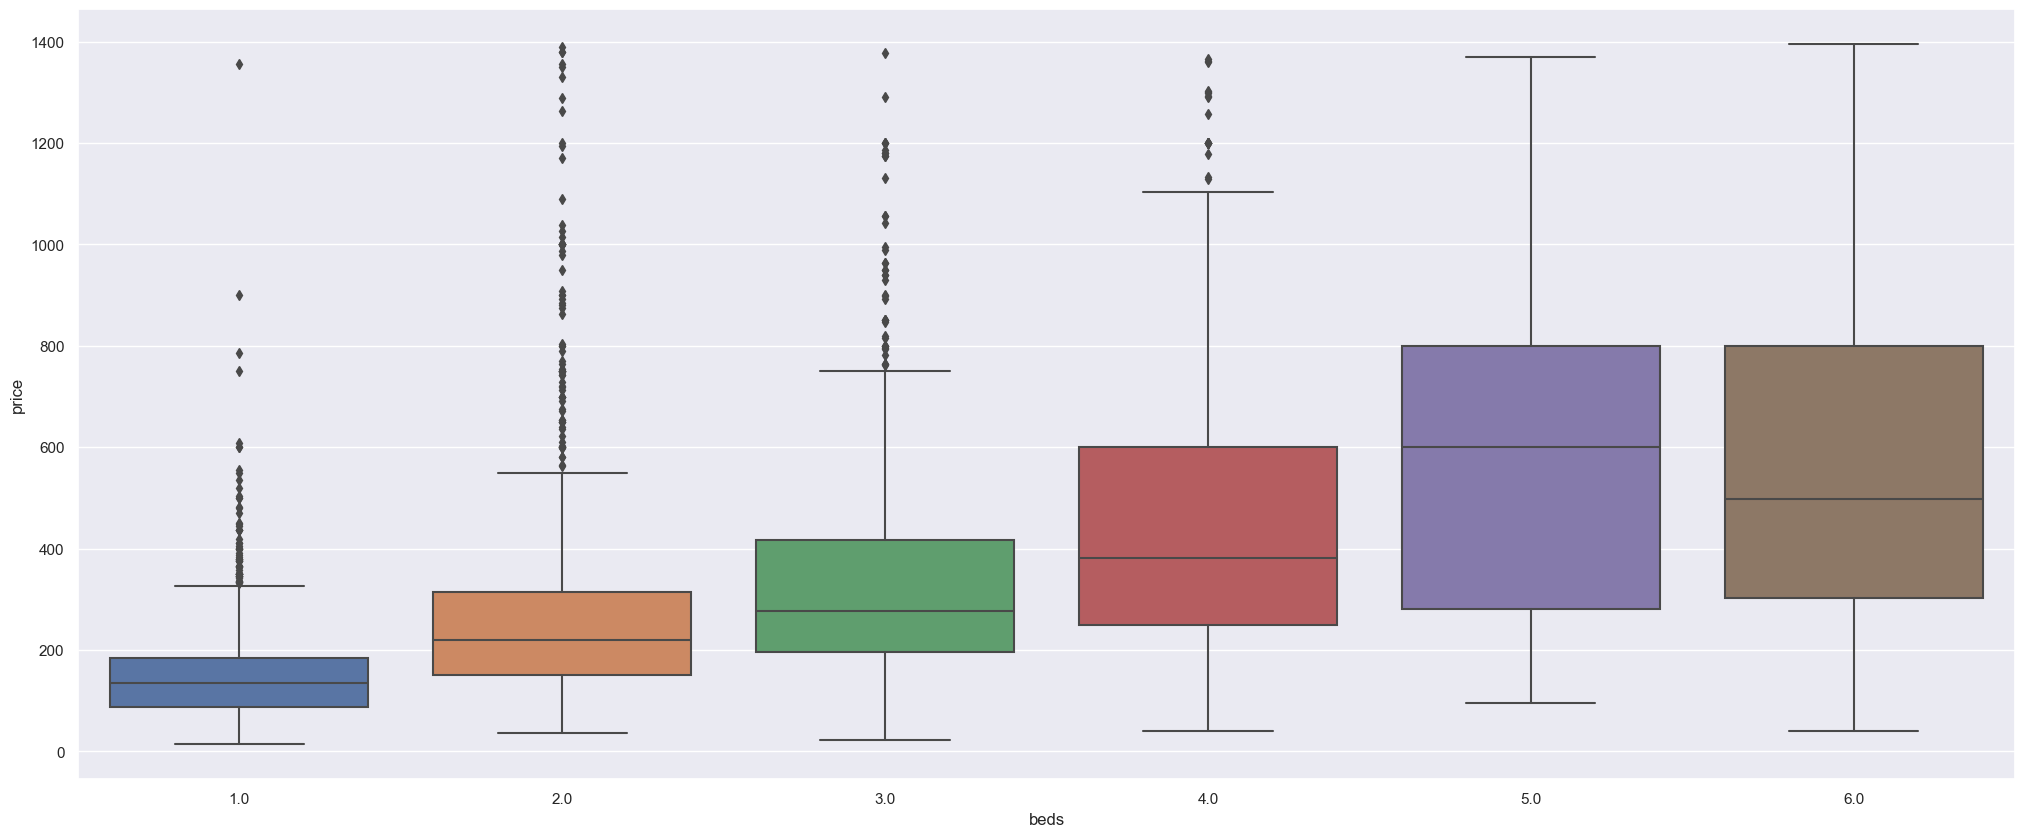

In [86]:
sns.boxplot(x=train['beds'],y=train['price'])
plt.show()

In [ ]:
sns.boxplot(x=train['accommodates'],y=train['price'])
plt.show()

### property_type & room_type

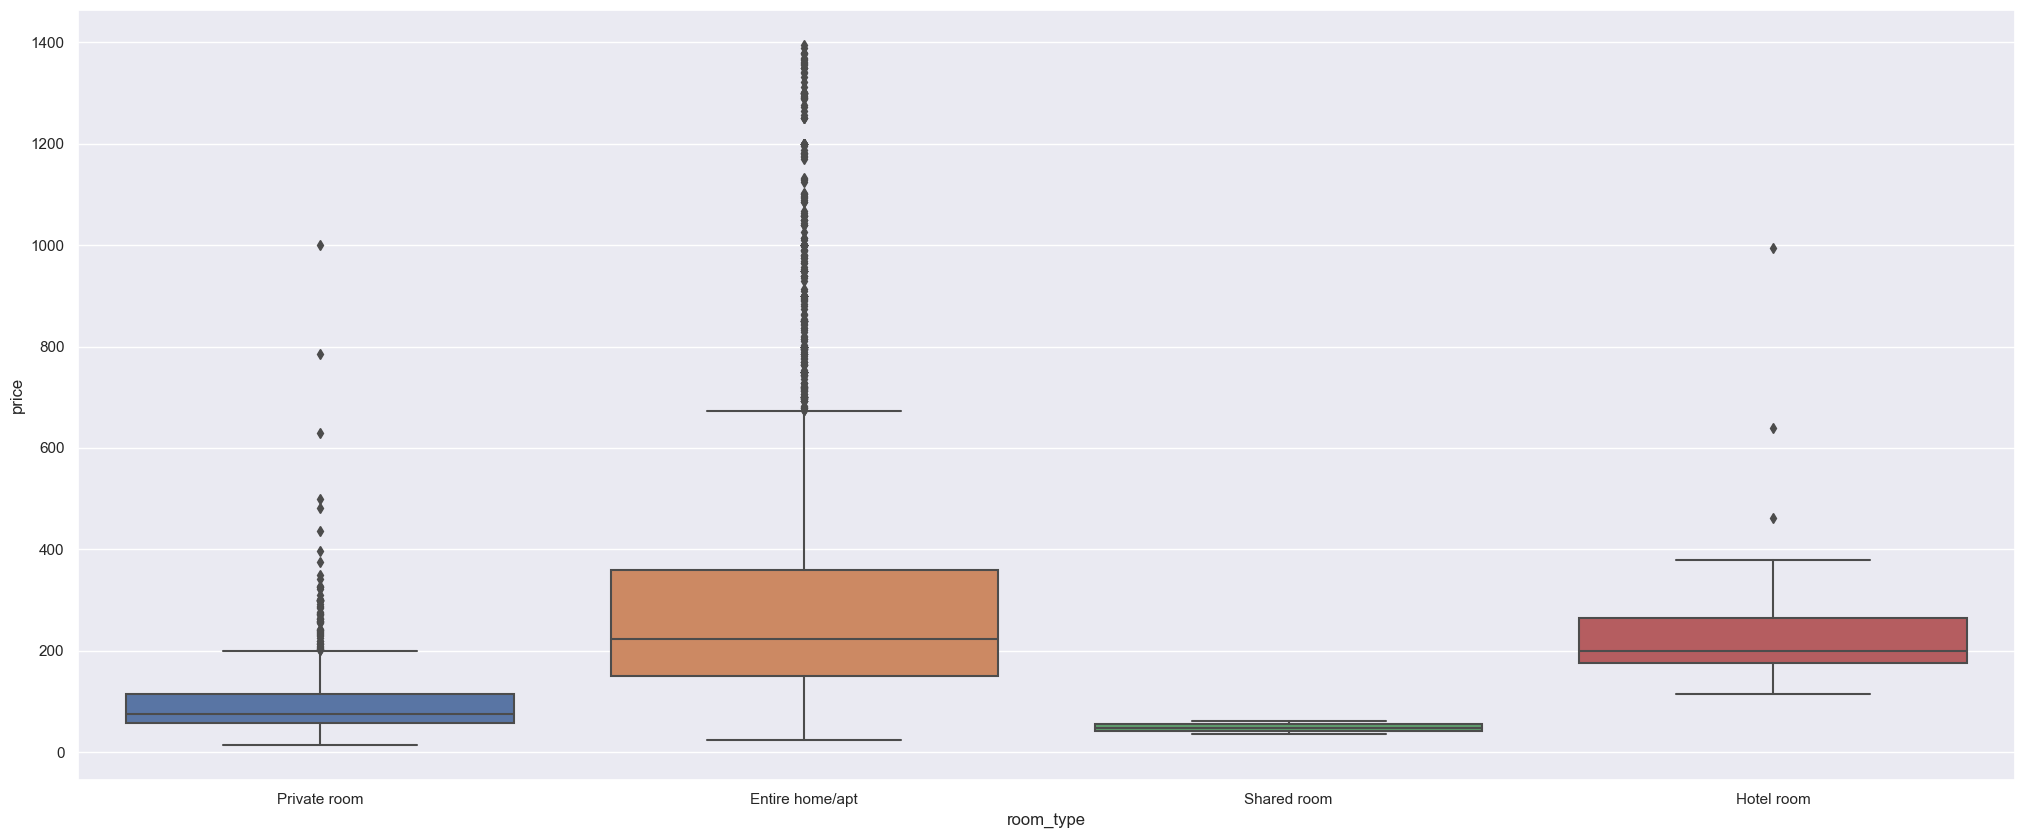

In [87]:
fig = plt.figure(figsize=(150,60))

plt.hist(train['property_type'], bins = 30, edgecolor = 'k')


plt.xlabel('property_type',fontsize = "12",)
plt.ylabel('Count',fontsize = "12",)
plt.title('The distribution of property_type',fontsize = "16",)
plt.savefig('plot-property_type')

In [89]:
train.property_type.value_counts()

Entire rental unit                    1776
Entire home                            683
Private room in home                   325
Private room in rental unit            159
Entire guest suite                     157
Entire guesthouse                      156
Entire condo                           106
Entire townhouse                        89
Room in boutique hotel                  83
Entire serviced apartment               67
Entire cottage                          44
Private room in townhouse               39
Room in hotel                           38
Entire loft                             32
Private room in guest suite             30
Room in aparthotel                      25
Private room in condo                   24
Entire villa                            21
Room in serviced apartment              15
Private room in hostel                  14
Private room in villa                   12
Entire bungalow                         12
Tiny home                               11
Private roo

In [90]:
test.property_type.value_counts()

Entire rental unit                   873
Entire home                          346
Private room in home                 172
Private room in rental unit          102
Entire guest suite                    95
Entire guesthouse                     70
Entire condo                          51
Entire townhouse                      49
Room in boutique hotel                48
Entire serviced apartment             38
Entire cottage                        16
Private room in townhouse             16
Room in hotel                         12
Entire cabin                          11
Room in aparthotel                    10
Entire loft                           10
Private room in condo                  9
Private room in hostel                 9
Private room in guest suite            8
Room in serviced apartment             5
Entire vacation home                   4
Entire villa                           4
Private room in bed and breakfast      4
Private room in cabin                  4
Entire bungalow 

In [91]:
#we try to reserve the first 4 types and merge other types to one type named "Others"


property_type_value=['Entire rental unit', 'Entire home', 'Private room in home',
                     'Private room in rental unit'
                     #,'Entire guest suite','Entire guesthouse','Entire condo'
                    ]

In [92]:
# if one random value of reserved_values is the same as input_value, then return 'same'
# otherwise return ''
def judge_value_list(input_value, reserved_values):
    input_value=input_value
    b=''
    for j in reserved_values:
        if input_value == j:
            b = 'same'
    return(b)


# in input_column, if the value of input_column is not in the array of reserved_values
# then we will change this value to "Others"
def substitute_values_to_Others(input_column, reserved_values, data, drop_column):
    data=data
    input_column_array=np.array(input_column)
    for k_i in range(len(input_column_array)):
        i = input_column_array[k_i] 
        b = judge_value_list(i, reserved_values)
        if b != 'same':
            input_column_array[k_i]="Others"
            
    data=data.drop([drop_column],axis=1)
    data[drop_column] = input_column_array
    #data.to_csv(r"./data_train_5048.csv", mode='w', index=False, encoding='utf-8-sig')
    return(data) 

In [93]:
# reserve the top 4 types and merge other types into one type named "Others" in property_type in train data
train=substitute_values_to_Others(train.property_type, 
                                       property_type_value, train, 'property_type')
# reserve the top 4 types and merge other types into one type named "Others" in property_type in test data
test=substitute_values_to_Others(test.property_type, property_type_value, test, 'property_type')

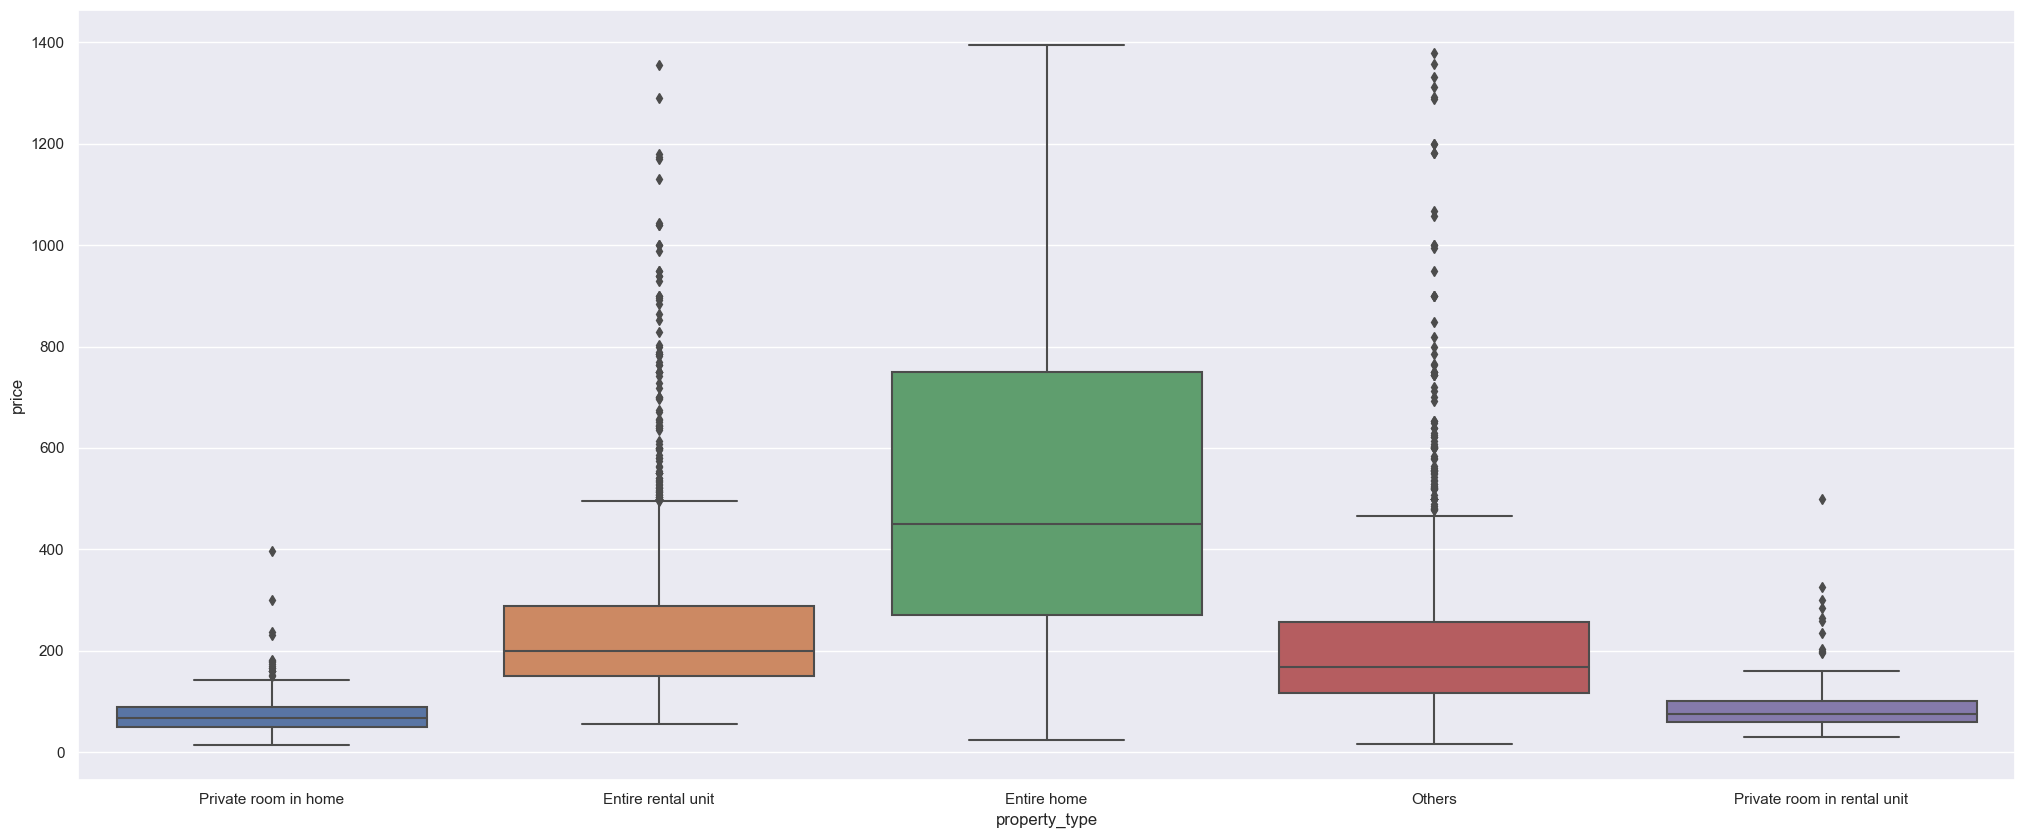

In [94]:
sns.set(rc={'figure.figsize':(25,10)})
sns.boxplot(x=train['property_type'],y=train['price'])
plt.show()
# can be added

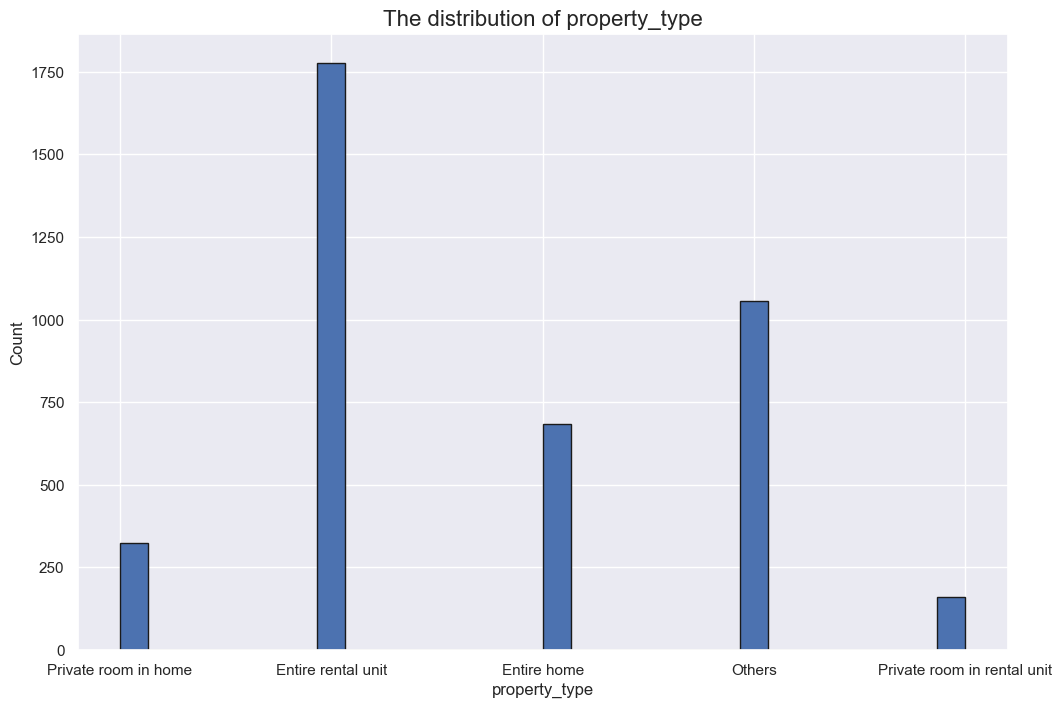

In [95]:


fig = plt.figure(figsize=(12,8))

plt.hist(train['property_type'], bins = 30, edgecolor = 'k')


plt.xlabel('property_type',fontsize = "12",)
plt.ylabel('Count',fontsize = "12",)
plt.title('The distribution of property_type',fontsize = "16",)
plt.savefig('plot-property_type')

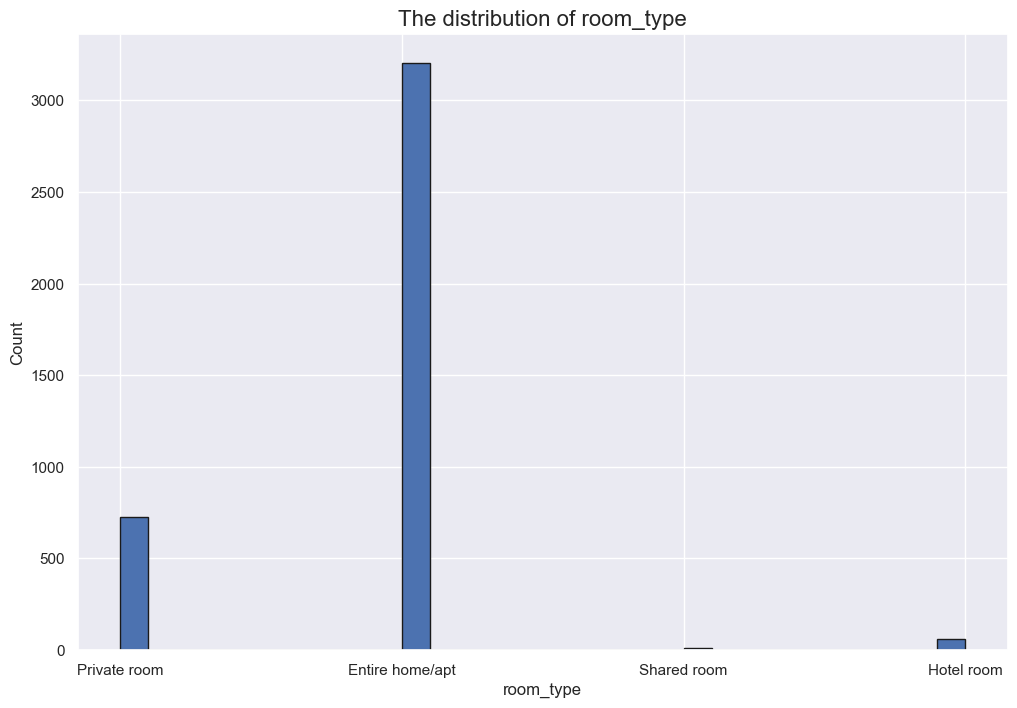

In [96]:

fig = plt.figure(figsize=(12,8))

plt.hist(train['room_type'], bins = 30, edgecolor = 'k')


plt.xlabel('room_type',fontsize = "12",)
plt.ylabel('Count',fontsize = "12",)
plt.title('The distribution of room_type',fontsize = "16",)
plt.savefig('plot-property_type')

In [97]:
train.room_type.value_counts()
#we try to reserve the first 4 types and merge other types to one type named "Others"

Entire home/apt    3203
Private room        727
Hotel room           60
Shared room          10
Name: room_type, dtype: int64

In [98]:
#define an array including the first 2 types in property_type
room_type_value=['Entire home/apt', 'Private room'
                     #,'Entire guest suite','Entire guesthouse','Entire condo'
                    ]

In [99]:
# reserve the top 2 types and merge other types into one type named "Others" in property_type in train data
train=substitute_values_to_Others(train.room_type, 
                                       room_type_value, train, 'room_type')

# reserve the top 2 types and merge other types into one type named "Others" in property_type in test data
test=substitute_values_to_Others(test.room_type, room_type_value, test, 'room_type')

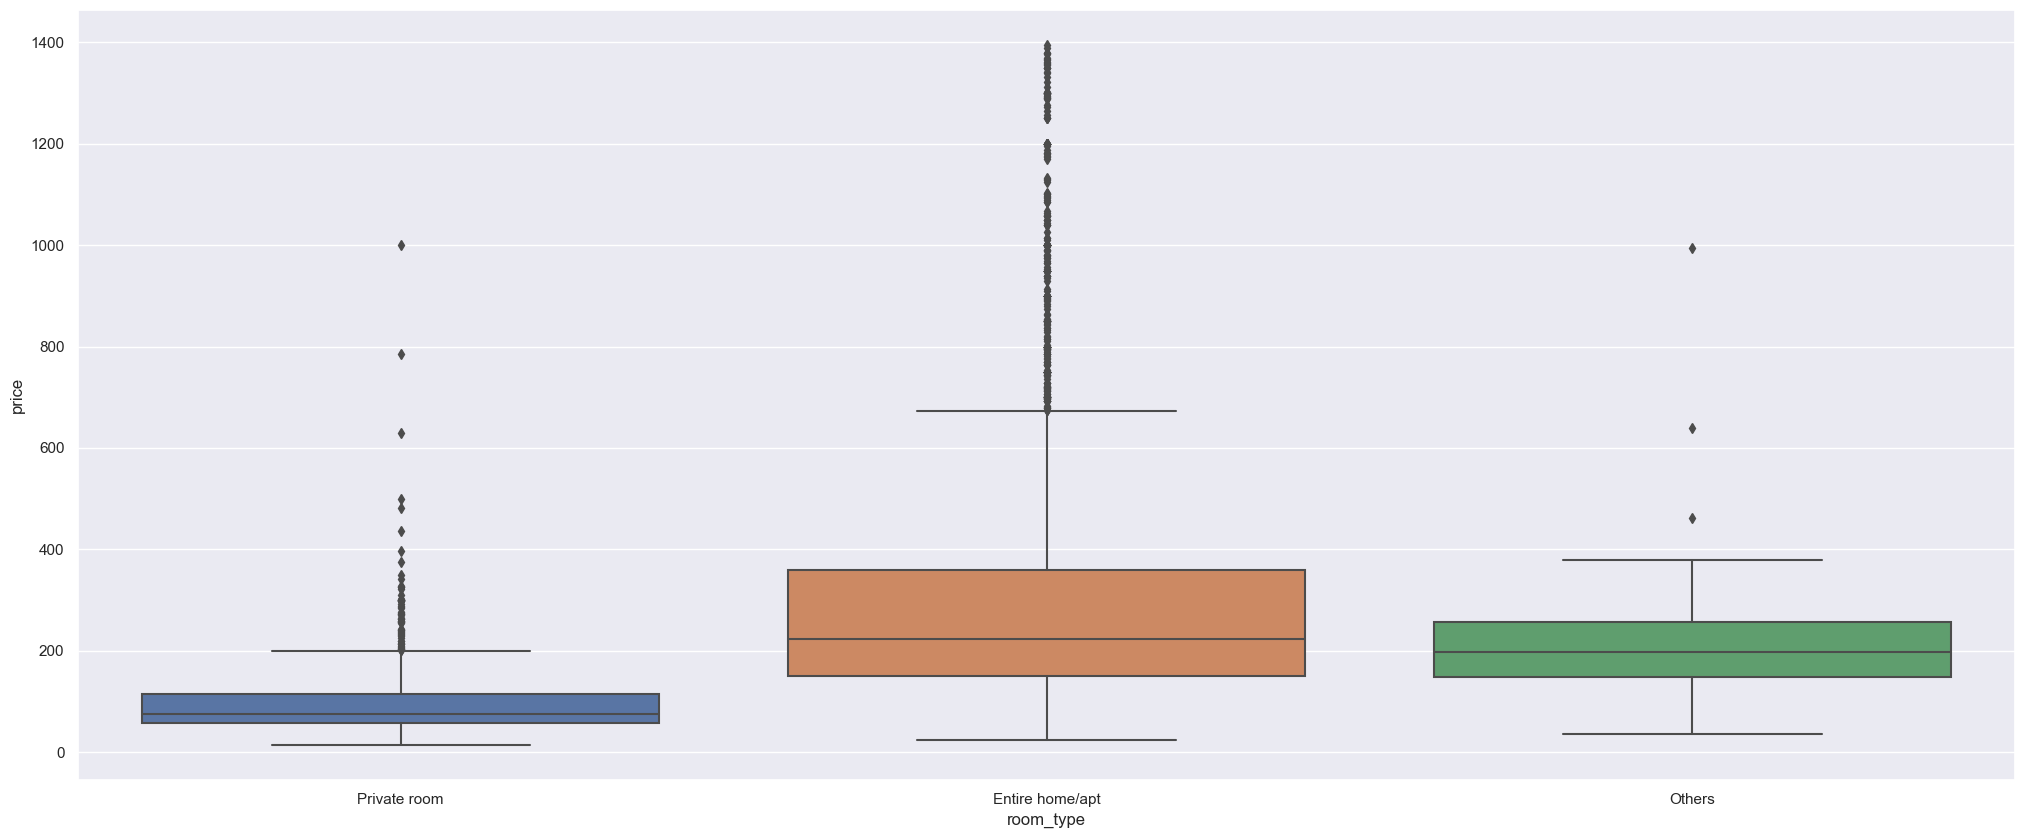

In [100]:

#sns.set(rc={'figure.figsize':(25,8.27)})
sns.boxplot(x=train['room_type'],y=train['price'])
plt.show()
plt.show()
# can be added

one-hot 

In [101]:
# define a function to rename
def rename_column(data, old_name, new_name):
    for k_i in range(len(old_name)):
        i = old_name[k_i]
        j = new_name[k_i]
        data = data.rename(columns={i: j})
    return(data)
# define a function to one-hot
def one_hot(one_hot_column, data, drop_column):
    x = pd.get_dummies(one_hot_column)
    data = data.drop(drop_column, axis=1)
    data = pd.concat([data, x], axis=1)
    return(data)
# one-hot in some columns in train data
# in order to know where the new coloumns are from
# we change the new colomns' names

In [102]:
train=one_hot(train.property_type, train, 'property_type')
old_name=['Entire rental unit', 'Entire home', 'Others', 'Private room in home'
          ,'Private room in rental unit'
          #,'Entire guest suite','Entire guesthouse','Entire condo'
         ]
new_name=['property_type_Entire rental unit', 'property_type_Entire home', 'property_type_Others', 'property_type_Private room in home',
                     'property_type_Private room in rental unit'
          #,'property_type_Entire guest suite','property_type_Entire guesthouse','property_type_Entire condo'
         ]
train =  rename_column(train, old_name, new_name)

train=one_hot(train.room_type, train, 'room_type')
old_name=['Entire home/apt', 'Private room','Others'
          #, 'Hotel room', 'Shared room'
         ]
new_name=['room_type_Entire home/apt', 'room_type_Private room','room_type_Others'
          #, 'room_type_Hotel room', 'room_type_Shared room'
         ]
train =  rename_column(train, old_name, new_name)
# one-hot in some columns in test data
# in order to know where the new coloumns are from
# we change the new colomns' names

test=one_hot(test.property_type, test, 'property_type')
old_name=['Entire rental unit', 'Entire home', 'Others', 'Private room in home',
                     'Private room in rental unit'
          #,'Entire guest suite','Entire guesthouse','Entire condo'
         ]
new_name=['property_type_Entire rental unit', 'property_type_Entire home', 'property_type_Others', 'property_type_Private room in home',
                     'property_type_Private room in rental unit'
          #,'property_type_Entire guest suite','property_type_Entire guesthouse','property_type_Entire condo'
         ]
test =  rename_column(test, old_name, new_name)

test=one_hot(test.room_type, test, 'room_type')
old_name=['Entire home/apt', 'Private room','Others'
          #, 'Hotel room', 'Shared room'
         ]
new_name=['room_type_Entire home/apt', 'room_type_Private room','room_type_Others'
          #, 'room_type_Hotel room', 'room_type_Shared room'
         ]
test =  rename_column(test, old_name, new_name)

## <font color = '#e64626'><a id='feature_engineering'>3. Feature Engineering</a></font>

### Location columns process

In [103]:
# columns represent location information
region_predictor = train[['host_location','host_neighbourhood','neighbourhood','neighbourhood_cleansed','latitude','longitude']]

In [104]:
region_predictor.isna().sum()

host_location              637
host_neighbourhood        1556
neighbourhood              409
neighbourhood_cleansed       0
latitude                     0
longitude                    0
dtype: int64

In [105]:
train['neighbourhood_cleansed'].value_counts()

Sydney              979
Waverley            427
Randwick            275
Pittwater           258
Manly               229
Warringah           173
North Sydney        167
Woollahra           148
Leichhardt          132
Marrickville        106
Sutherland Shire    104
Hornsby             100
Rockdale             69
Mosman               66
Ryde                 62
Auburn               60
Willoughby           59
Parramatta           49
Botany Bay           47
The Hills Shire      43
Lane Cove            42
Canada Bay           40
Penrith              39
Ku-Ring-Gai          37
Burwood              36
Bankstown            36
Blacktown            32
Canterbury           28
Fairfield            24
Ashfield             24
Hurstville           22
Liverpool            19
Strathfield          17
Campbelltown         16
City Of Kogarah      12
Camden               10
Holroyd               9
Hunters Hill          4
Name: neighbourhood_cleansed, dtype: int64

In [106]:
neigh_clean_count = train['neighbourhood_cleansed'].value_counts()
neigh_clean_count.index[neigh_clean_count >= 100]

keep_count = neigh_clean_count.index[neigh_clean_count >= 100].to_list()

def re_neighbour(x):
    if x in keep_count:
        return x
    else:
        return'Others'
train['neighbourhood_cleansed'] = train['neighbourhood_cleansed'].apply(re_neighbour)
test['neighbourhood_cleansed'] = test['neighbourhood_cleansed'].apply(re_neighbour)
train['neighbourhood_cleansed'].value_counts()

Sydney              979
Others              902
Waverley            427
Randwick            275
Pittwater           258
Manly               229
Warringah           173
North Sydney        167
Woollahra           148
Leichhardt          132
Marrickville        106
Sutherland Shire    104
Hornsby             100
Name: neighbourhood_cleansed, dtype: int64

In [107]:
neighbourhood_cleansed_train_dummy_features = pd.get_dummies(train['neighbourhood_cleansed'], drop_first=True) 
train = pd.concat([train, neighbourhood_cleansed_train_dummy_features], axis=1)

neighbourhood_cleansed_test_dummy_features = pd.get_dummies(test['neighbourhood_cleansed'], drop_first=True) 
test = pd.concat([test, neighbourhood_cleansed_test_dummy_features], axis=1)

In [108]:
# Process location information in training set
train_region_ls = []
for i in range(len(train)):
    if  train['neighbourhood'].isnull()[i] != True and len(train['neighbourhood'][i].split(','))==3 and train['neighbourhood'][i].split(',')[0]!='Sydney':
        region = train['neighbourhood'][i].split(',')[0]
        
    elif train['host_neighbourhood'].isnull()[i] != True:
        region = train['host_neighbourhood'][i]
      
    elif train['host_location'].isnull()[i] != True and len(train['host_location'][i].split(','))==2 and train['host_location'][i].split(',')[0]!='Sydney':
        region = train['host_location'][i].split(',')[0]
            
    elif train['neighbourhood_cleansed'][i]!='Sydney':
        region = train['neighbourhood_cleansed'][i]       
        
    else:
        region = 'Sydney'
     
    train_region_ls.append(region)

In [109]:
# process location information in test set
test_region_ls = []
for i in range(len(test)):
    if  test['neighbourhood'].isnull()[i] != True and len(test['neighbourhood'][i].split(','))==3 and test['neighbourhood'][i].split(',')[0]!='Sydney':
        region = test['neighbourhood'][i].split(',')[0]
        
    elif test['host_neighbourhood'].isnull()[i] != True:
        region = test['host_neighbourhood'][i]
      
    elif test['host_location'].isnull()[i] != True and len(test['host_location'][i].split(','))==2 and test['host_location'][i].split(',')[0]!='Sydney':
        region = test['host_location'][i].split(',')[0]
            
    elif test['neighbourhood_cleansed'][i]!='Sydney':
        region = test['neighbourhood_cleansed'][i]
        
    else:
        region = 'Sydney'
        
     
    test_region_ls.append(region.strip())

In [110]:
inner_west = ['Annandale', 'Ashfield', 'Balmain', 'Balmain East', 'Birchgrove', 'Dobroyd Point', 'Dulwich Hill', 'Enmore', 'Haberfield', 'Leichhardt', 'Lewisham', 'Lilyfield', 'Marrickville', 'Petersham', 'Rozelle', 'Stanmore', 'St Peters', 'Summer Hill', 'Sydenham', 'Ashbury', 'Camperdown', 'Croydon', 'Croydon Park', 'Hurlstone Park', 'Newtown']
city = ['Alexandria', 'Annandale', 'Barangaroo', 'Beaconsfield', 'Camperdown', 'Centennial Park', 'Chippendale', 'Darlinghurst', 'Darlington', 'Dawes Point', 'Elizabeth Bay', 'Erskineville', 'Eveleigh', 'Forest Lodge', 'Glebe', 'Haymarket', 'Millers Point', 'Moore Park', 'Newtown', 'Paddington', 'Potts Point', 'Pyrmont', 'Redfern', 'Rosebery', 'Rushcutters Bay', 'St Peters', 'Surry Hills', 'Sydney', 'The Rocks', 'Ultimo', 'Waterloo', 'Woolloomooloo', 'Zetland']
eastern = ['Bondi','Bondi Junction','Bronte Beach','Clovelly','Coogee','Maroubra','La Perouse','Little Bay','Double Bay','Watsons Bay','Vaucluse','Randwick','Moore Park']
parramatta = ['parramatta','Beecroft', 'Camellia', 'Carlingford', 'Clyde', 'Constitution Hill', 'Dundas', 'Dundas Valley', 'Eastwood', 'Epping', 'Ermington', 'Granville', 'Harris Park', 'Lidcombe', 'Mays Hill', 'Melrose Park', 'Newington', 'North Parramatta', 'North Rocks', 'Northmead', 'Oatlands', 'Old Toongabbie', 'Parramatta', 'Pendle Hill', 'Rosehill', 'Rydalmere', 'Silverwater', 'Sydney Olympic Park', 'Telopea', 'Toongabbie', 'Wentworth Point', 'Wentworthville', 'Westmead', 'Winston Hills']
north_west = ['Cammeray', 'Cremorne', 'Cremorne Point', 'Crows Nest', 'Kirribilli', 'Kurraba Point', 'Lavender Bay', 'McMahons Point', 'Milsons Point', 'Neutral Bay', 'North Sydney', 'St Leonards', 'Waverton','Wollstonecraft']
lower_north_shore = ['Balmoral','Balmoral Beach','Beauty Point','Bradleys Head','Chinamans Beach','Chowder Bay','Chowder Head','Clifton Gardens','Cremorne'
,'Cremorne Junction','Cobblers Beach','Edwards Beach','Georges Head','Georges Heights','Little Sirius Cove','Middle Head','Mosman','Pearl Bay','Quakers Hat Bay','Spit Junction'
,'The Spit','Cammeray','Cremorne','Cremorne Point','Crows Nest','Kirribilli','Kurraba Point','Lavender Bay','McMahons Point','Milsons Point','Neutral Bay','North Sydney','St Leonards','Artarmon','Castle Cove','Castlecrag','Chatswood','Chatswood West','East Willoughby','Middle Cove','Middle Cove','Lane Cove North','North Willoughby','Northbridge','Roseville','Willoughby','Greenwich','Lane Cove'
,'Lane Cove North','Lane Cove West','Linley Point','Longueville','Northwood','Riverview','St Leonards','Gladesville' ,'Henley','Hunters Hill','Huntleys Cove','Huntleys Point','Woolwich']
canterbury_bankstown = ['Ashbury', 'Bankstown', 'Bankstown Aerodrome', 'Bass Hill', 'Belfield', 'Belmore', 'Beverly Hills', 'Birrong', 'Campsie', 'Canterbury', 'Chester Hill' , 'Chullora', 'Clemton Park', 'Condell Park', 'Croydon Park' , 'Earlwood', 'East Hills', 'Georges Hall', 'Greenacre', 'Hurlstone Park', 'Kingsgrove', 'Lakemba', 'Lansdowne', 'Milperra', 'Mount Lewis', 'Narwee', 'Padstow', 'Padstow Heights', 'Panania',' Picnic Point', 'Potts Hill', 'Punchbowl', 'Regents Park' , 'Revesby', 'Revesby Heights', 'Riverwood' , 'Roselands', 'Sefton', 'Villawood' , 'Wiley Park', 'Yagoona']
st_george = ['Allawah', 'Arncliffe', 'Banksia', 'Bardwell Park', 'Bardwell Valley', 'Beverley Park', 'Beverly Hills', 'Bexley', 'Bexley North', 'Blakehurst', 'Brighton-Le-Sands', 'Carlton', 'Carss Park', 'Connells Point', 'Dolls Point', 'Hurstville', 'Hurstville Grove', 'Kingsgrove', 'Kogarah', 'Kogarah Bay', 'Kyeemagh', 'Kyle Bay', 'Lugarno', 'Mascot' , 'Monterey', 'Mortdale', 'Narwee' , 'Oatley', 'Peakhurst', 'Peakhurst Heights', 'Penshurst', 'Ramsgate', 'Ramsgate Beach', 'Riverwood', 'Rockdale', 'Sandringham', 'Sans Souci', 'South Hurstville', 'Turrella','Wolli Creek']
sutherland_shire = ['Alfords Point', 'Bangor', 'Barden Ridge', 'Bonnet Bay', 'Bundeena', 'Burraneer', 'Caringbah', 'Caringbah South'
, 'Como', 'Cronulla', 'Dolans Bay', 'Engadine', 'Grays Point', 'Greenhills Beach', 'Gymea', 'Gymea Bay', 'Heathcote', 'Holsworthy', 'Illawong'
, 'Jannali', 'Kangaroo Point', 'Kareela', 'Kirrawee', 'Kurnell', 'Lilli Pilli', 'Loftus', 'Lucas Heights', 'Maianbar', 'Menai', 'Miranda'
, 'Oyster Bay', 'Port Hacking', 'Royal National Park', 'Sandy Point', 'Sutherland', 'Sylvania', 'Sylvania Waters', 'Taren Point', 'Waterfall'
, 'Woolooware', 'Woronora', 'Woronora Dam', 'Woronora Heights', 'Yarrawarrah','Yowie Bay']
south_west = ['Blacktown', 'Blue Mountains' , 'Camden', 'Campbelltown','Canterbury Bankstown', 'Cumberland', 'Fairfield', 'Hawkesbury' 
, 'Liverpool' , 'Parramatta', 'Penrith', 'The Hills Shire', 'Wollondilly Shire']
upper_north_shore = ['East Gordon','East Killara','East Lindfield','East Roseville','East Wahroonga','Gordon','Killara','Lindfield','North Turramurra'
,'North St Ives','North Wahroonga','Pymble','Roseville','Roseville Chase','South Turramurra','St Ives','St Ives Chase','Turramurra','Wahroonga','Warrawee','West Killara','West Lindfield'
,'West Pymble','Asquith','Beecroft','Berowra','Berowra Heights','Berowra Waters','Brooklyn','Carlingford' ,'Castle Hill' ,'Cheltenham','Cherrybrook'
,'Cowan','Eastwood' ,'Epping' ,'Glenhaven','Hornsby','Hornsby Heights','Mount Colah','Mount Ku-ring-gai','Normanhurst','North Epping','Pennant Hills'
,'Thornleigh','Wahroonga','Waitara','Westleigh','West Pennant Hills']

In [111]:
the_hills_shire = ['Annangrove', 'Baulkham Hills', 'Beaumont Hills', 'Bella Vista', 'Box Hill', 'Carlingford', 'Castle Hill', 'Cattai', 'Dural', 'Glenhaven', 'Glenorie', 'Kellyville', 'Kenthurst', 'Leets Vale'
, 'Lower Portland', 'Maraylya', 'Maroota', 'Middle Dural', 'Nelson', 'North Kellyville', 'North Rocks', 'Norwest'
, 'Rouse Hill', 'Sackville North', 'South Maroota', 'West Pennant Hills', 'Winston Hills', 'Wisemans Ferry']
black_town = ['Acacia Gardens', 'Arndell Park', 'Bidwill', 'Blackett', 'Blacktown', 'Bungarribee', 'Colebee', 'Dean Park', 'Dharruk', 'Doonside', 
'Eastern Creek', 'Emerton', 'Glendenning', 'Glenwood', 'Hassall Grove', 'Hebersham', 'Huntingwood', 'Kellyville Ridge', 'Kings Langley', 'Kings Park',
'Lalor Park', 'Lethbridge Park', 'Marayong', 'Marsden Park', 'Minchinbury', 'Mount Druitt', 'Oakhurst', 'Parklea', 'Plumpton', 'Prospect', 'Quakers Hill', 
'Riverstone', 'Rooty Hill', 'Ropes Crossing', 'Rouse Hill', 'Schofields', 'Seven Hills', 'Shalvey', 'Shanes Park', 'St Marys', 'Stanhope Gardens', 'The Ponds',
'Toongabbie', 'Tregear', 'Vineyard', 'Whalan', 'Willmot','Woodcroft']
northern_beaches = ['Allambie Heights','Avalon','Balgowlah Heights','Balgowlah','Bayview','Beacon Hill','Belrose','Bilgola','Bilgola Plateau','Brookvale'
,'Church Point','Clareville','Clontarf','Coasters Retreat','Collaroy Plateau','Collaroy','Cottage Point','Cromer','Curl Curl','Davidson','Dee Why'
,'Duffys Forest','Elanora Heights','Elvina Bay','Fairlight','Forestville','Frenchs Forest','Freshwater','Great Mackerel Beach','Ingleside','Killarney Heights'
,'Lovett Bay','Manly Vale','Manly','Manly Beach','Mona Vale','Morning Bay','Narrabeen North','Narrabeen','Narraweena','Newport','North Balgowlah','North Curl Curl'
,'North Manly','Oxford Falls','Palm Beach','Queenscliff','Scotland Island','Seaforth','Terrey Hills','Warriewood','Whale Beach','Wheeler Heights']
forest_district = ['Forestville','Frenchs Forest','Belrose','Davidson','Killarney Heights','Terrey Hills','Duffys Forest']

In [112]:
def capital_lower(area):
    for i in range(len(area)):
        area[i] = area[i].lower()
capital_lower(st_george)
capital_lower(canterbury_bankstown)
capital_lower(lower_north_shore)
capital_lower(north_west)
capital_lower(parramatta)
capital_lower(eastern)
capital_lower(city)
capital_lower(inner_west)
capital_lower(sutherland_shire)
capital_lower(south_west)
capital_lower(upper_north_shore)
capital_lower(the_hills_shire)
capital_lower(black_town)
capital_lower(northern_beaches)
capital_lower(forest_district)

In [113]:
train_suburb = []
for i in range(len(train_region_ls)):
    if train_region_ls[i].lower() in city:
        train_suburb.append('city')
    elif train_region_ls[i].lower() in eastern:
        train_suburb.append('eastern')
    elif train_region_ls[i].lower() in inner_west:
        train_suburb.append('inner west')
    elif train_region_ls[i].lower() in lower_north_shore:
        train_suburb.append('lower north shore')
    elif train_region_ls[i].lower() in parramatta:
        train_suburb.append('parramatta')
    elif train_region_ls[i].lower() in north_west:
        train_suburb.append('north west')
    elif train_region_ls[i].lower() in st_george:
        train_suburb.append('st george')
    elif train_region_ls[i].lower() in canterbury_bankstown:
        train_suburb.append('canterbury bankstown')
    elif train_region_ls[i].lower() in sutherland_shire:
        train_suburb.append('sutherland shire')
    elif train_region_ls[i].lower() in south_west:
        train_suburb.append('south west')
    elif train_region_ls[i].lower() in upper_north_shore:
        train_suburb.append('upper north shore')
    elif train_region_ls[i].lower() in the_hills_shire:
        train_suburb.append('the hills shire')
    elif train_region_ls[i].lower() in black_town:
        train_suburb.append('black town')
    elif train_region_ls[i].lower() in northern_beaches:
        train_suburb.append('northern beaches')
    elif train_region_ls[i].lower() in forest_district:
        train_suburb.append('forest district')
    else:
        train_suburb.append('other')

In [114]:
test_suburb = []
for i in range(len(test_region_ls)):
    if test_region_ls[i].lower() in city:
        test_suburb.append('city')
    elif test_region_ls[i].lower() in eastern:
        test_suburb.append('eastern')
    elif test_region_ls[i].lower() in inner_west:
        test_suburb.append('inner west')
    elif test_region_ls[i].lower() in lower_north_shore:
        test_suburb.append('lower north shore')
    elif test_region_ls[i].lower() in parramatta:
        test_suburb.append('parramatta')
    elif test_region_ls[i].lower() in north_west:
        test_suburb.append('north west')
    elif test_region_ls[i].lower() in st_george:
        test_suburb.append('st george')
    elif test_region_ls[i].lower() in canterbury_bankstown:
        test_suburb.append('canterbury bankstown')
    elif test_region_ls[i].lower() in sutherland_shire:
        test_suburb.append('sutherland shire')
    elif test_region_ls[i].lower() in south_west:
        test_suburb.append('south west')
    elif test_region_ls[i].lower() in upper_north_shore:
        test_suburb.append('upper north shore')
    elif test_region_ls[i].lower() in the_hills_shire:
        test_suburb.append('the hills shire')
    elif test_region_ls[i].lower() in black_town:
        test_suburb.append('black town')
    elif test_region_ls[i].lower() in northern_beaches:
        test_suburb.append('northern beaches')
    elif test_region_ls[i].lower() in forest_district:
        test_suburb.append('forest district')
    else:
        test_suburb.append('other')

In [115]:
train['suburb']=train_suburb
test['suburb']=test_suburb 

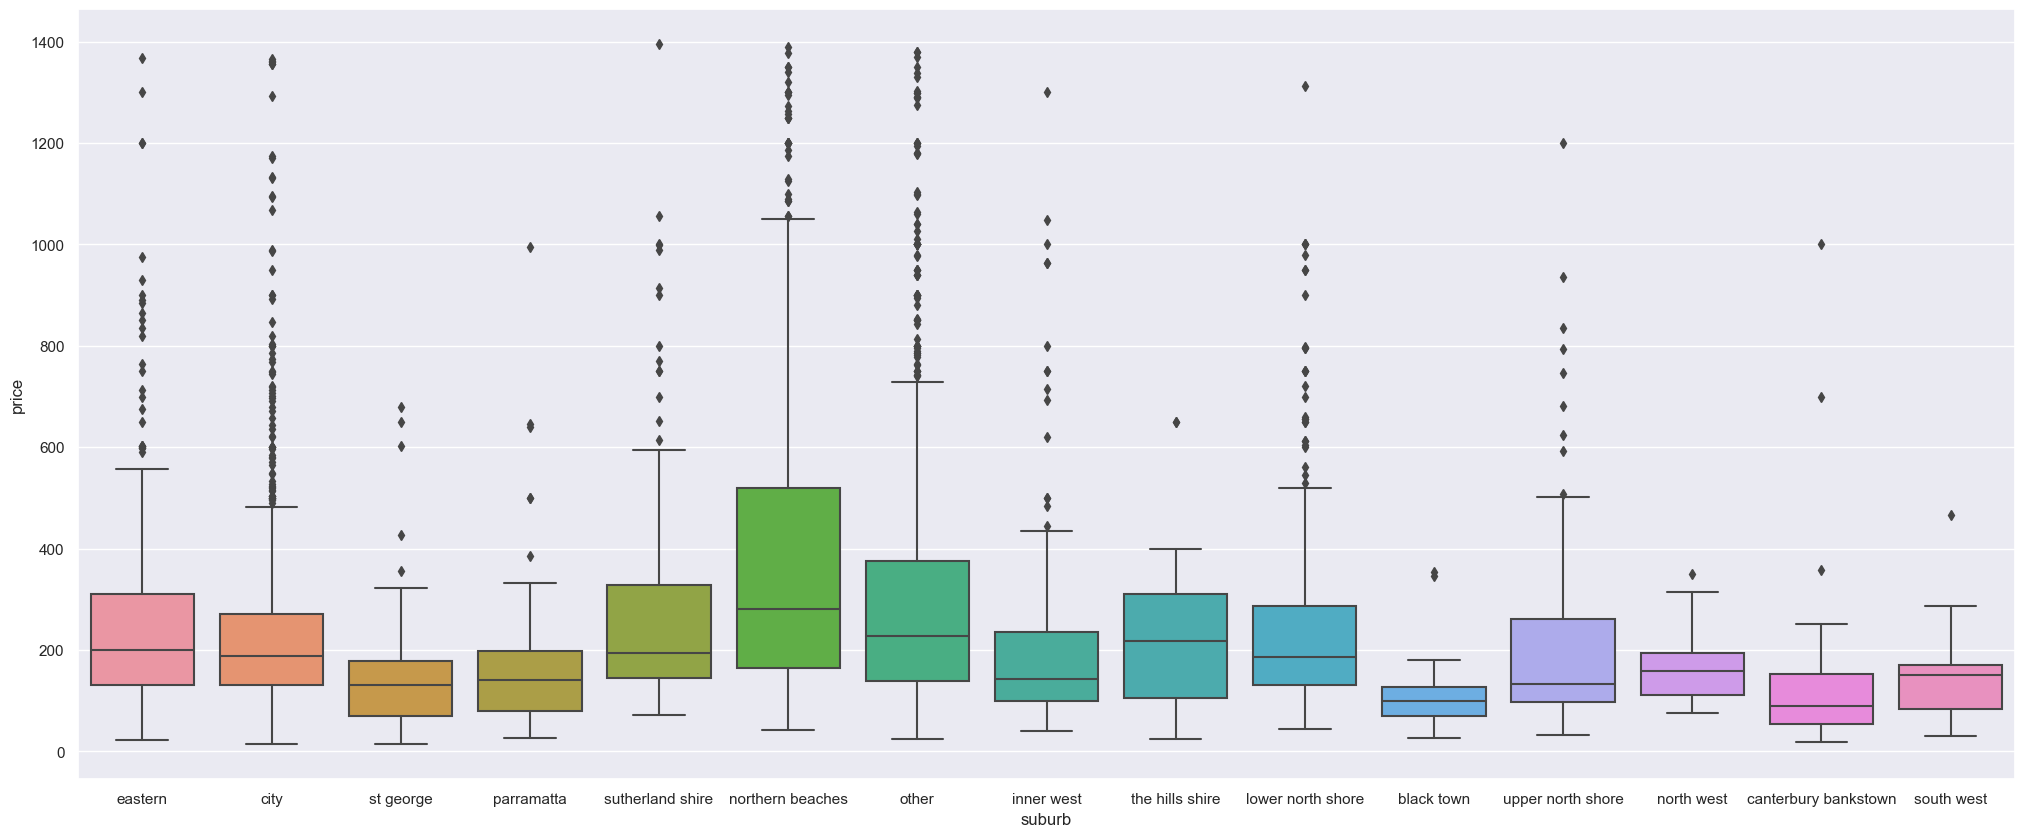

In [116]:
import seaborn as sns
sns.boxplot(x=train['suburb'],y=train['price'])
plt.show()
# can be added

In [117]:
suburb_train_dummy_features = pd.get_dummies(train['suburb'], drop_first=True) 
train = pd.concat([train, suburb_train_dummy_features], axis=1)

suburb_test_dummy_features = pd.get_dummies(test['suburb'], drop_first=True) 
test = pd.concat([test, suburb_test_dummy_features], axis=1)

In [118]:
# Drop all other unusable region columns
train = train.drop(columns = ['host_location','host_neighbourhood','neighbourhood','neighbourhood_cleansed','suburb'])
test = test.drop(columns = ['host_location','host_neighbourhood','neighbourhood','neighbourhood_cleansed','suburb'])

### host_verifications

In [119]:
host_train = train['host_verifications']
host_test = test['host_verifications']

In [120]:
# define a funtion select all Words and phrases
def findattri(str):
    return re.findall(r"([a-zA-Z].*?)'",str)
host_train_1=host_train.apply(findattri)
host_test_1=host_test.apply(findattri)
# create a list include all Words and phrases
attri = []
for i in range(len(host_train_1)):
    for j in range(len(host_train_1[i])):
        if host_train_1[i][j] not in attri:
            attri.append(host_train_1[i][j])
len(attri)

# def a cheak function, if include this word or phrases, it's value = True(1),else value = False(0) 
def one_hot_1(lst):
    cache = {}
    for i in attri:
        cache[i] = int(i in lst)
    return cache

host_train_2 = host_train_1.apply(one_hot_1)
host_test_2 = host_test_1.apply(one_hot_1)

In [121]:
host_train_2

0       {'email': 1, 'phone': 1, 'work_email': 0}
1       {'email': 1, 'phone': 1, 'work_email': 0}
2       {'email': 1, 'phone': 1, 'work_email': 0}
3       {'email': 1, 'phone': 1, 'work_email': 0}
4       {'email': 1, 'phone': 1, 'work_email': 0}
                          ...                    
3995    {'email': 1, 'phone': 1, 'work_email': 0}
3996    {'email': 1, 'phone': 1, 'work_email': 0}
3997    {'email': 1, 'phone': 1, 'work_email': 1}
3998    {'email': 1, 'phone': 1, 'work_email': 0}
3999    {'email': 1, 'phone': 1, 'work_email': 0}
Name: host_verifications, Length: 4000, dtype: object

In [122]:
train = pd.concat([train,host_train_2.apply(pd.Series)],axis=1)
train = train.drop('host_verifications',axis=1)
# drop the column amenities and host_verifications
test = pd.concat([test,host_test_2.apply(pd.Series)],axis=1)
test = test.drop('host_verifications',axis=1)

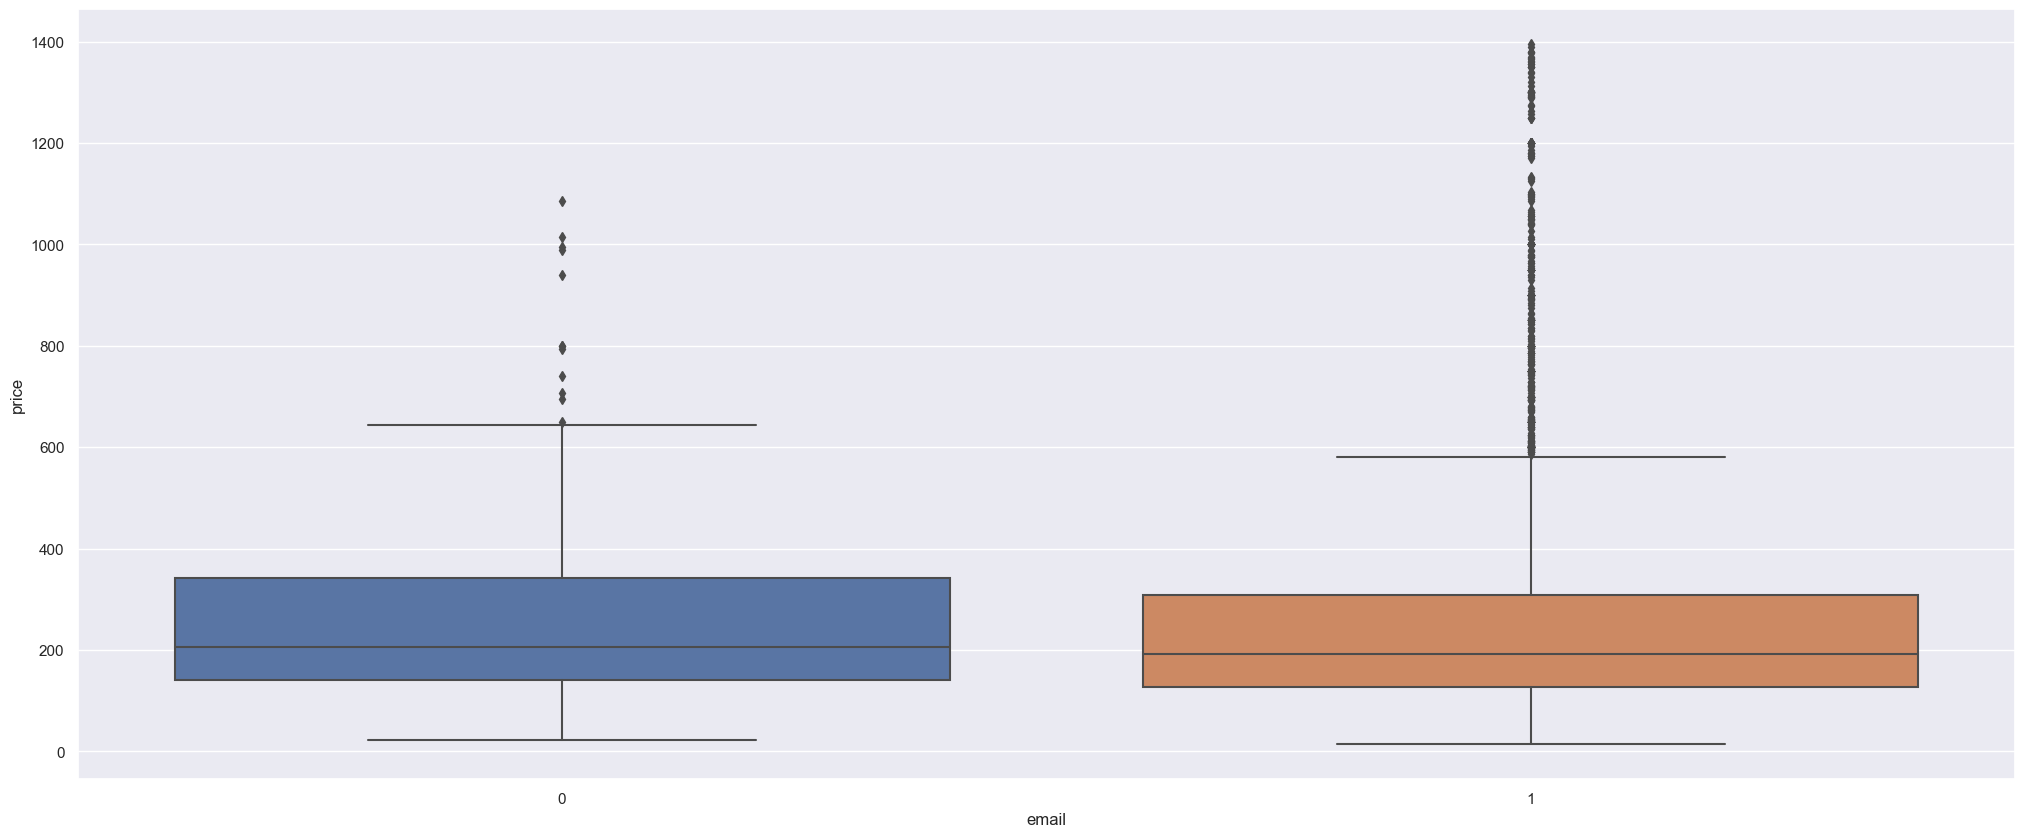

In [123]:
sns.boxplot(x=train['email'],y=train['price'])
plt.show()
# not useful variable

### Clean amenities

#### Filter by visualization

In [124]:
# Change amentities and host_verifications columns to dummy values
amenities_train = train['amenities']
amenities_test = test['amenities']

import re
# define a funtion select all Words and phrases
def findattri(str):
    return re.findall(r'([a-z A-Z]+.?)",',str)

am_train_1=amenities_train.apply(findattri)
am_test_1 = amenities_test.apply(findattri)
# create a list include all Words and phrases



In [125]:

attri_train_all = []
for i in range(len(am_train_1)):
    for j in range(len(am_train_1[i])):
        attri_train_all.append(am_train_1[i][j])

In [126]:
len(attri_train_all)

131249

In [127]:
def count(attri_train_all):
    attri_uniq = []
    for i in range(len(attri_train_all)):
        
        if attri_train_all[i] not in attri_uniq:
            attri_uniq.append(attri_train_all[i])
    #attri.append("Other")
    len(attri_uniq)
    count_train_1 = {}
    for i in attri_uniq:
        count_train_1[i] = attri_train_all.count(i)
    return count_train_1

In [128]:
len(attri_train_all)

131249

In [129]:

count_train = count(attri_train_all)
count_train

{'Dedicated workspace': 1563,
 'Freezer': 1201,
 'Smoke alarm': 3822,
 'Shared fenced garden or backyard': 145,
 'Bed linens': 2824,
 'Wifi': 3648,
 'Essentials': 3702,
 'Hot water': 3385,
 'Drying rack for clothing': 1013,
 'Hangers': 3513,
 'Dining table': 1280,
 'Free washer': 23,
 'Dishes and silverware': 3204,
 'Outdoor dining area': 843,
 'Wine glasses': 1320,
 'Portable fans': 640,
 'Microwave': 2982,
 'Long term stays allowed': 3595,
 'Hair dryer': 3468,
 'TV': 2318,
 'Security cameras on property': 499,
 'Toaster': 1439,
 'Outdoor furniture': 1075,
 'Hot water kettle': 1528,
 'Free street parking': 2113,
 'Refrigerator': 2990,
 ' closet': 156,
 'Shampoo': 2331,
 'Mini fridge': 270,
 'Indoor fireplace': 325,
 'Kitchen': 3549,
 'Dishwasher': 2064,
 'Stove': 2331,
 'Paid street parking off premises': 107,
 'Shower gel': 1402,
 'Private fenced garden or backyard': 445,
 'Heating': 2694,
 'Ceiling fan': 493,
 'Air conditioning': 1453,
 'Bathtub': 1002,
 'Private patio or balcony': 

In [130]:
count_train_sort = sorted(count_train.items(),key=lambda x:x[1],reverse=True)
count_train_sort[100]

(' closet', 156)

In [131]:
count_1=0
for i in count_train_sort:
    count_1 += i[1]
    if count_1 >= len(attri_train_all)*0.95:
        print(i,count_train_sort.index(i, 0, len(count_train_sort)))
        break


('Fire pit', 126) 107


In [132]:


def change_to_other(attri_all,am_1):
    for i in count(attri_all).items():
        #print(i)
        
        if i[1]>=1500 or i[1]<100:
            #print(i[1])
            for j in range(len(am_1)):
                for k in range(len(am_1[j])):
                    if i[0] in am_1[j]:
                        am_1[j].remove(i[0])

                #print(am_1[j])

    return am_1

In [133]:
am_train_2 = change_to_other(attri_train_all,am_train_1)
am_test_2 = change_to_other(attri_train_all,am_test_1)

In [134]:
am_train_2

0       [Freezer, Shared fenced garden or backyard, Dr...
1       [Indoor fireplace, Paid street parking off pre...
2       [darkening shades, s books and toys, Cleaning ...
3       [Barbecue utensils, s books and toys, Shower g...
4       [Shared pool, TV with standard cable, Central ...
                              ...                        
3995    [Pocket wifi, Shared patio or balcony, Shower ...
3996                                           [Elevator]
3997                                                   []
3998    [TV with standard cable, Cleaning before check...
3999    [Luggage dropoff allowed, Wine glasses, Centra...
Name: amenities, Length: 4000, dtype: object

In [135]:
am_train_3=pd.Series(am_train_2)
am_test_3=pd.Series(am_test_2)
am_train_3

0       [Freezer, Shared fenced garden or backyard, Dr...
1       [Indoor fireplace, Paid street parking off pre...
2       [darkening shades, s books and toys, Cleaning ...
3       [Barbecue utensils, s books and toys, Shower g...
4       [Shared pool, TV with standard cable, Central ...
                              ...                        
3995    [Pocket wifi, Shared patio or balcony, Shower ...
3996                                           [Elevator]
3997                                                   []
3998    [TV with standard cable, Cleaning before check...
3999    [Luggage dropoff allowed, Wine glasses, Centra...
Name: amenities, Length: 4000, dtype: object

In [136]:
attri = []
for i in range(len(am_train_3)):
    for j in range(len(am_train_3[i])):
        if am_train_3[i][j] not in attri:
            attri.append(am_train_3[i][j])
#attri.append("Other")
len(attri)

87

In [137]:
# def a cheak function, if include this word or phrases, it's value = True(1),else value = False(0) 
def one_hot_1(lst):
    cache = {}
    for i in attri:
        cache[i] = int(i in lst)
    return cache

am_train_4=am_train_3.apply(one_hot_1)
am_test_4=am_test_3.apply(one_hot_1)


In [138]:
am_train_3

0       [Freezer, Shared fenced garden or backyard, Dr...
1       [Indoor fireplace, Paid street parking off pre...
2       [darkening shades, s books and toys, Cleaning ...
3       [Barbecue utensils, s books and toys, Shower g...
4       [Shared pool, TV with standard cable, Central ...
                              ...                        
3995    [Pocket wifi, Shared patio or balcony, Shower ...
3996                                           [Elevator]
3997                                                   []
3998    [TV with standard cable, Cleaning before check...
3999    [Luggage dropoff allowed, Wine glasses, Centra...
Name: amenities, Length: 4000, dtype: object

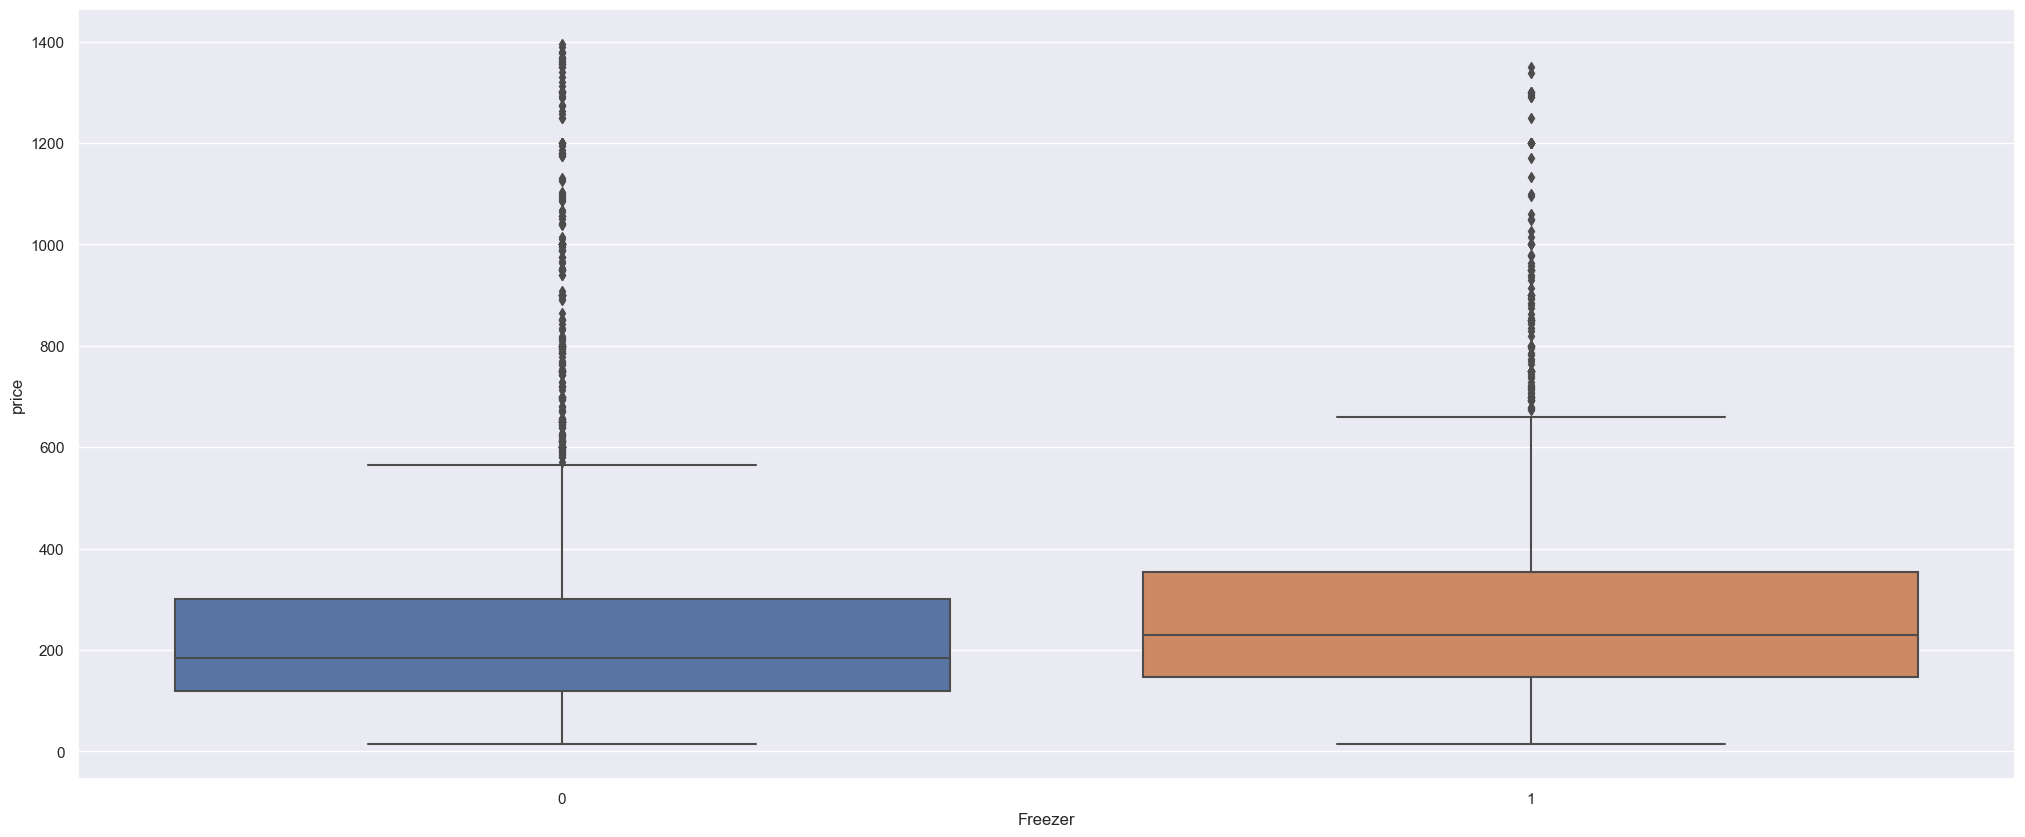

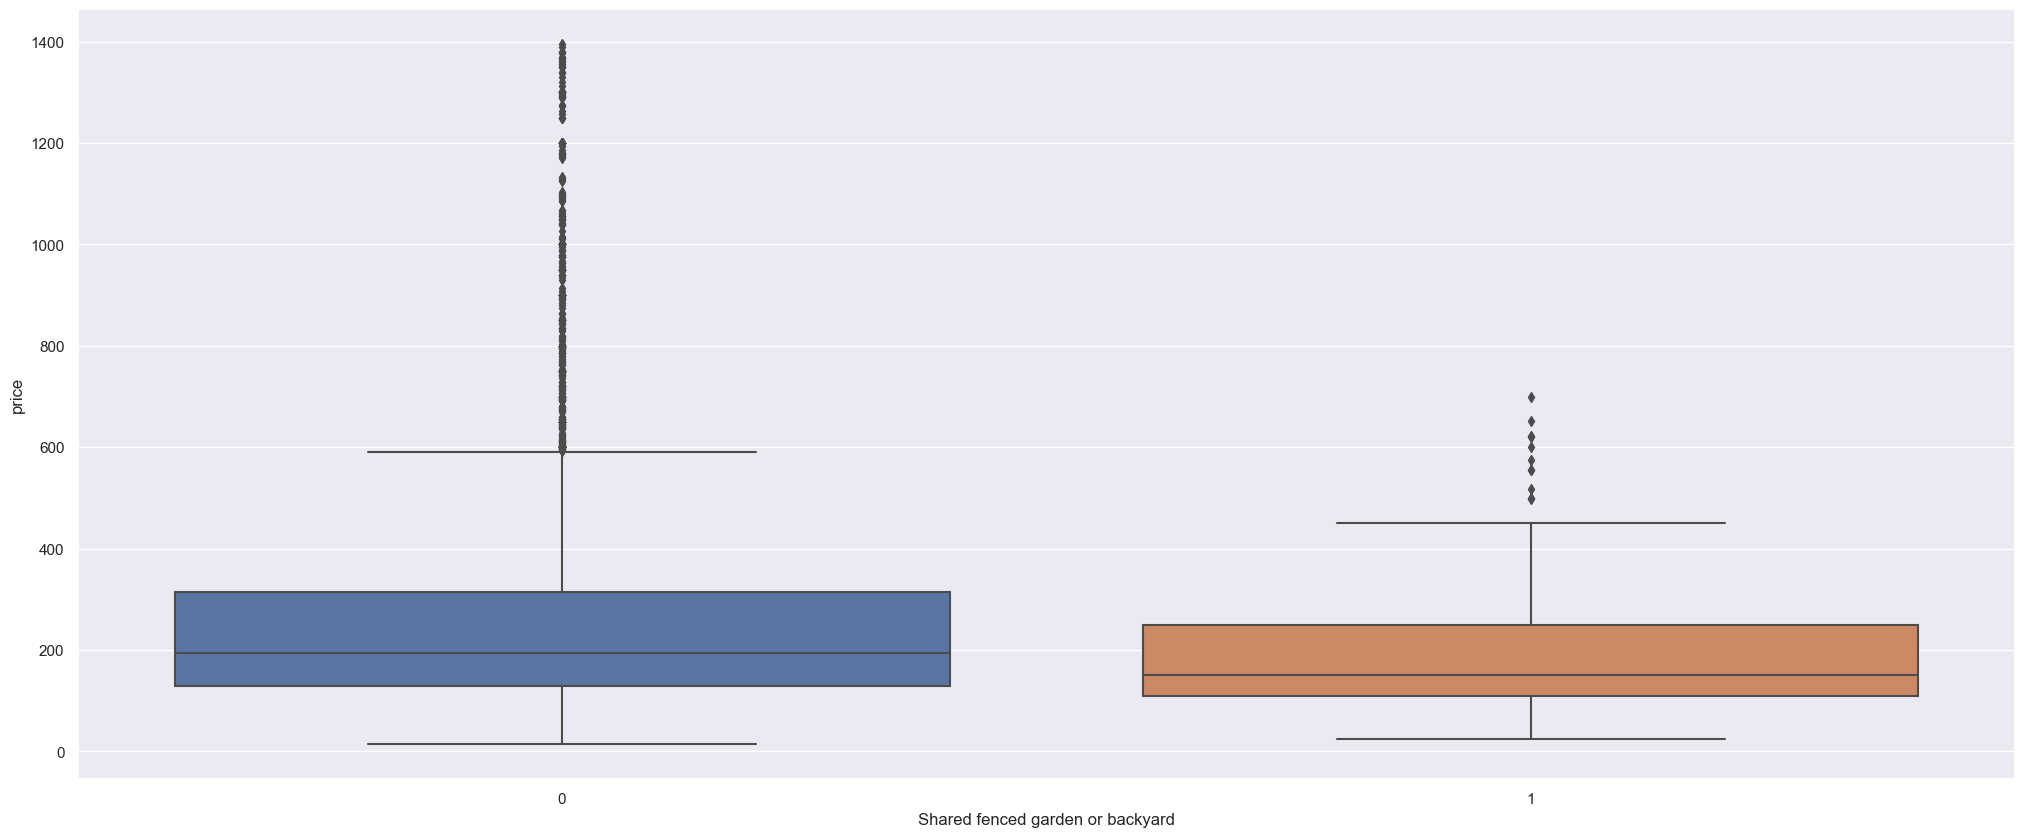

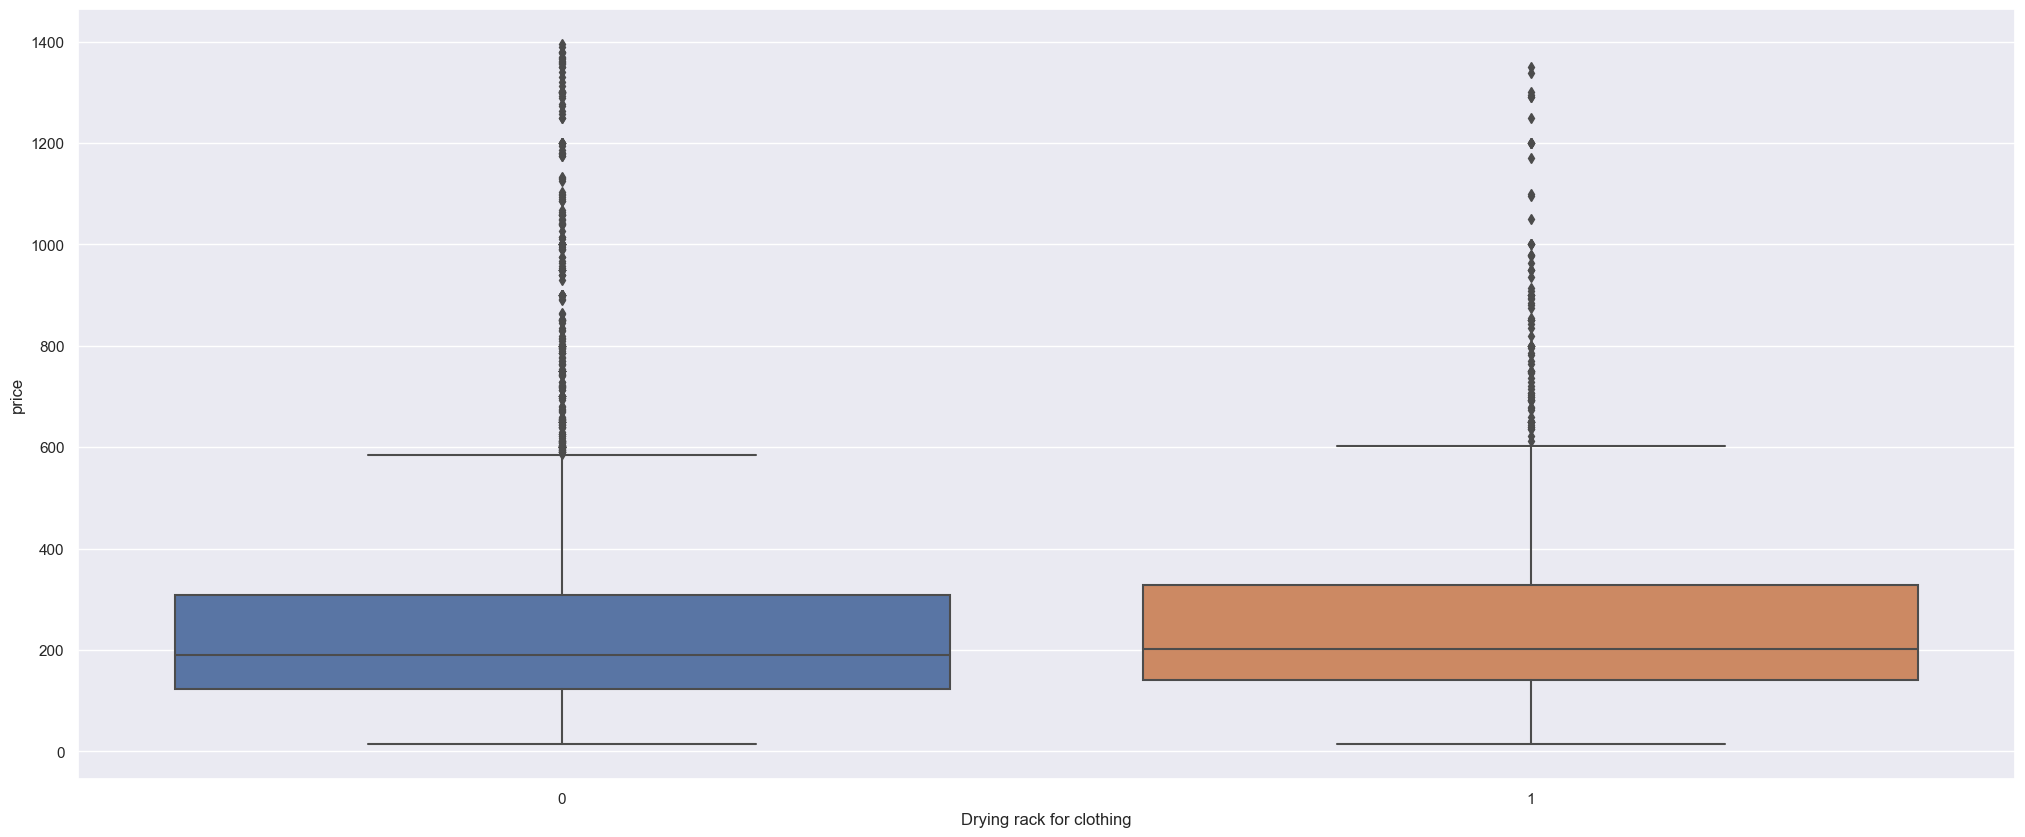

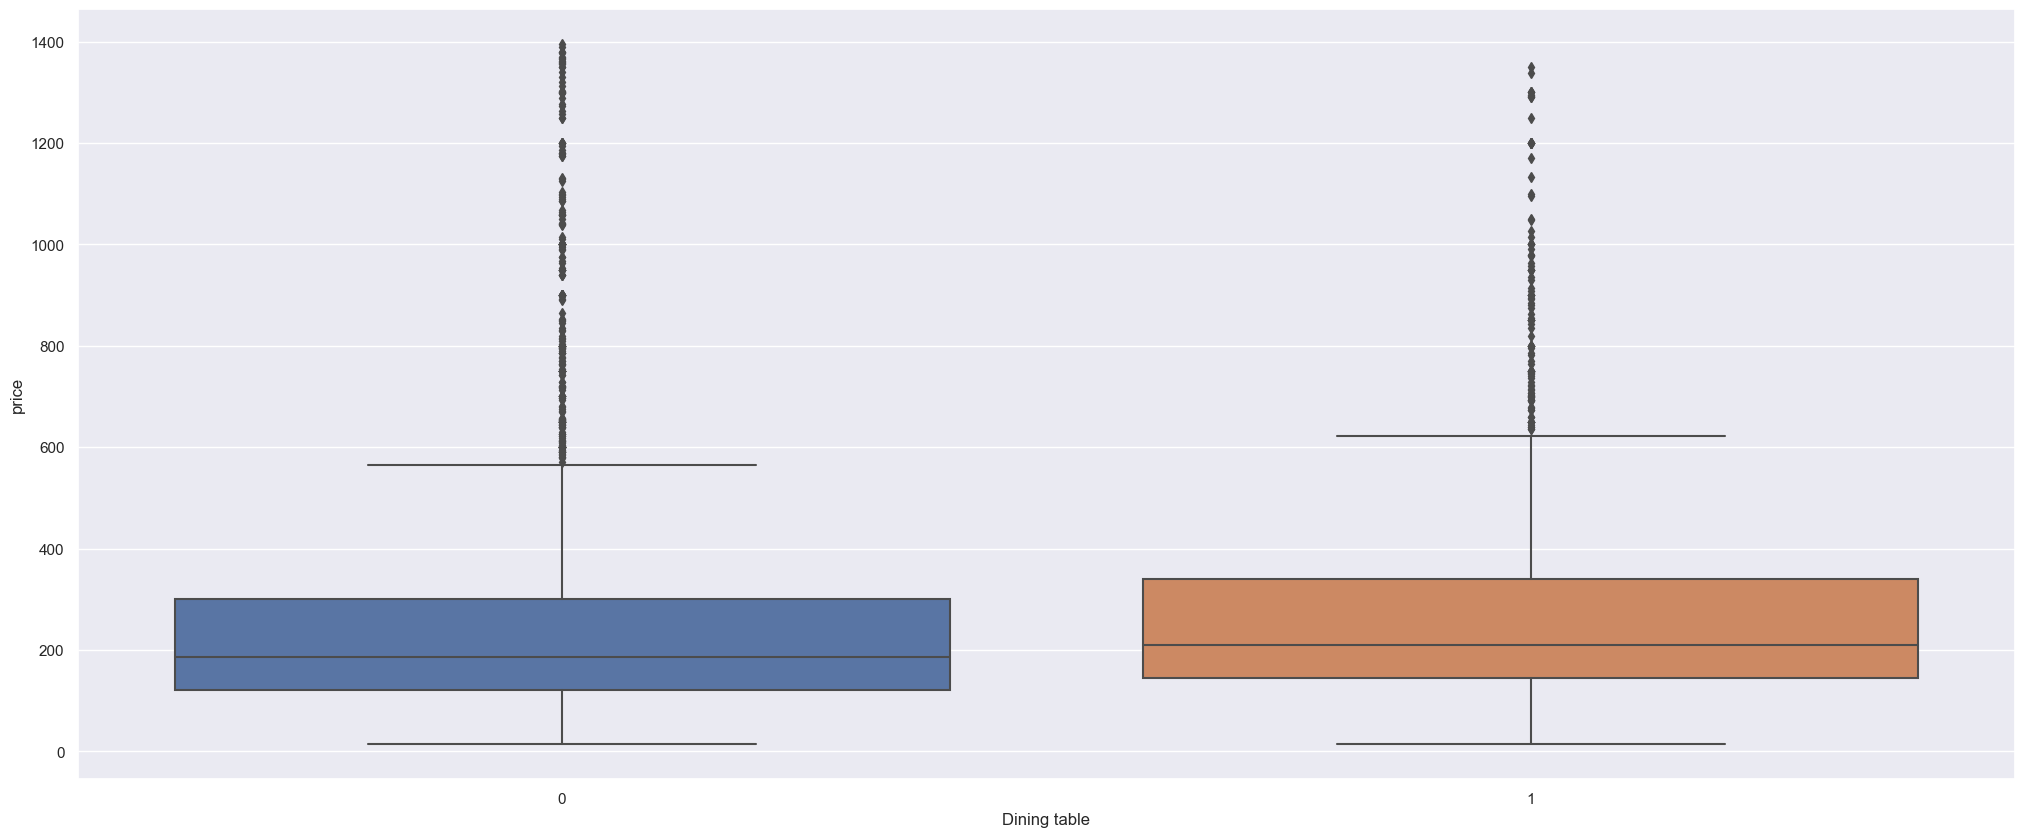

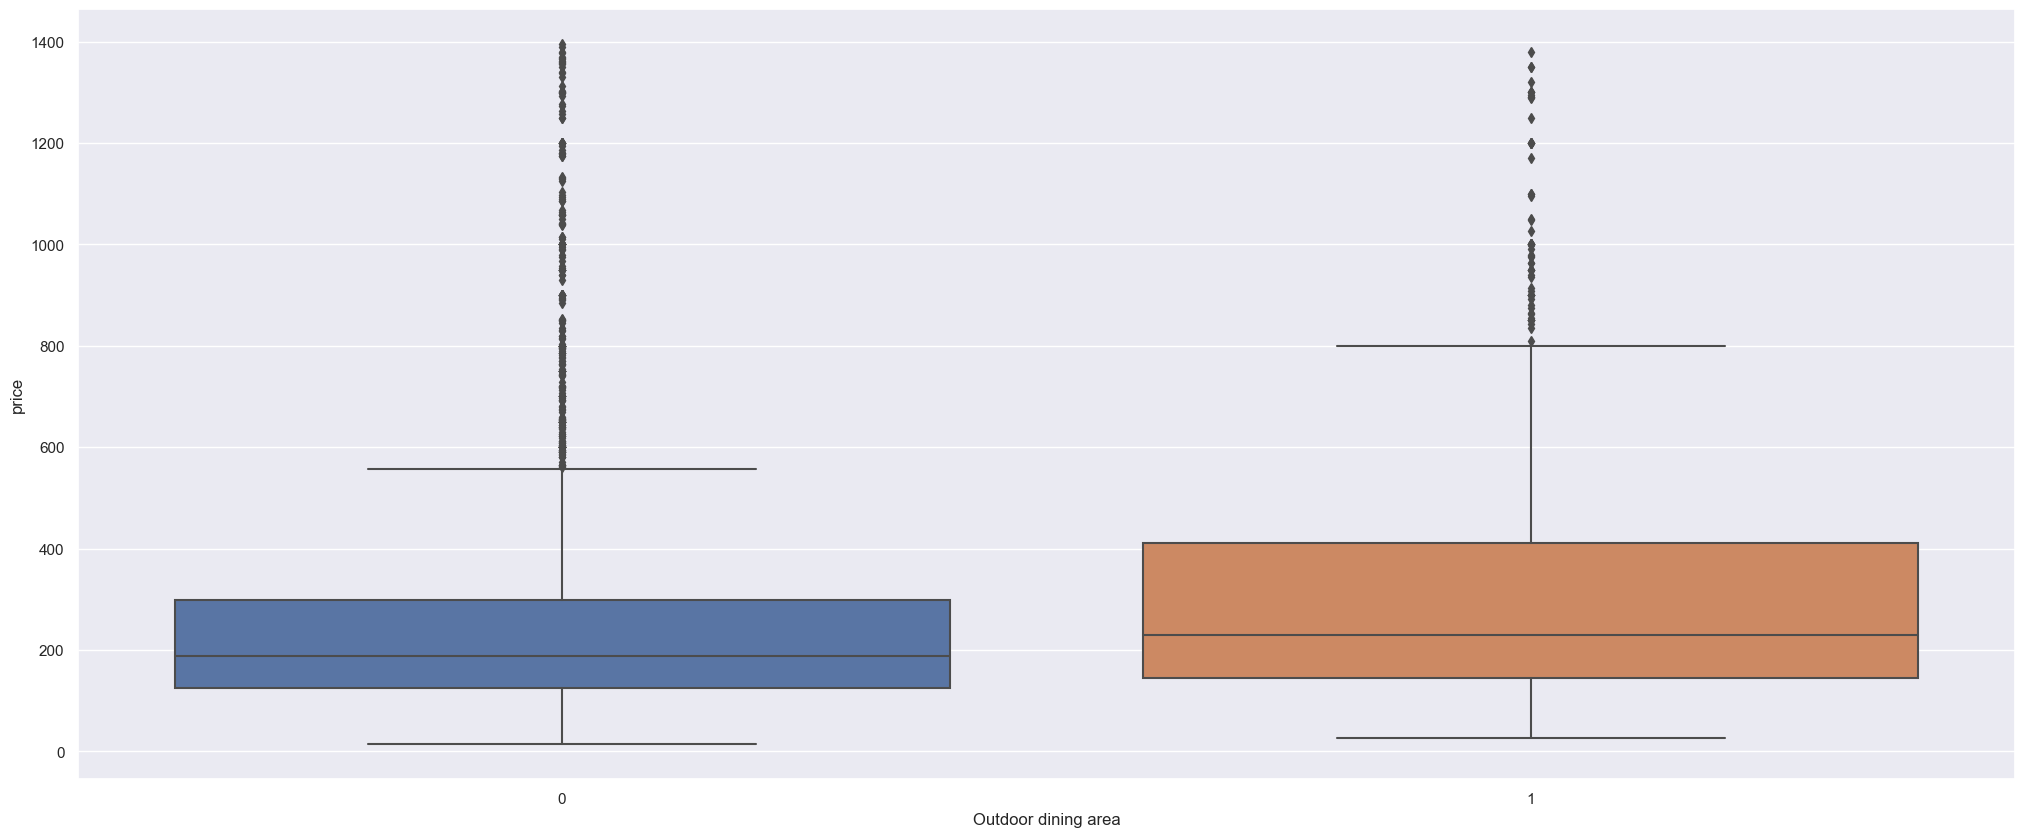

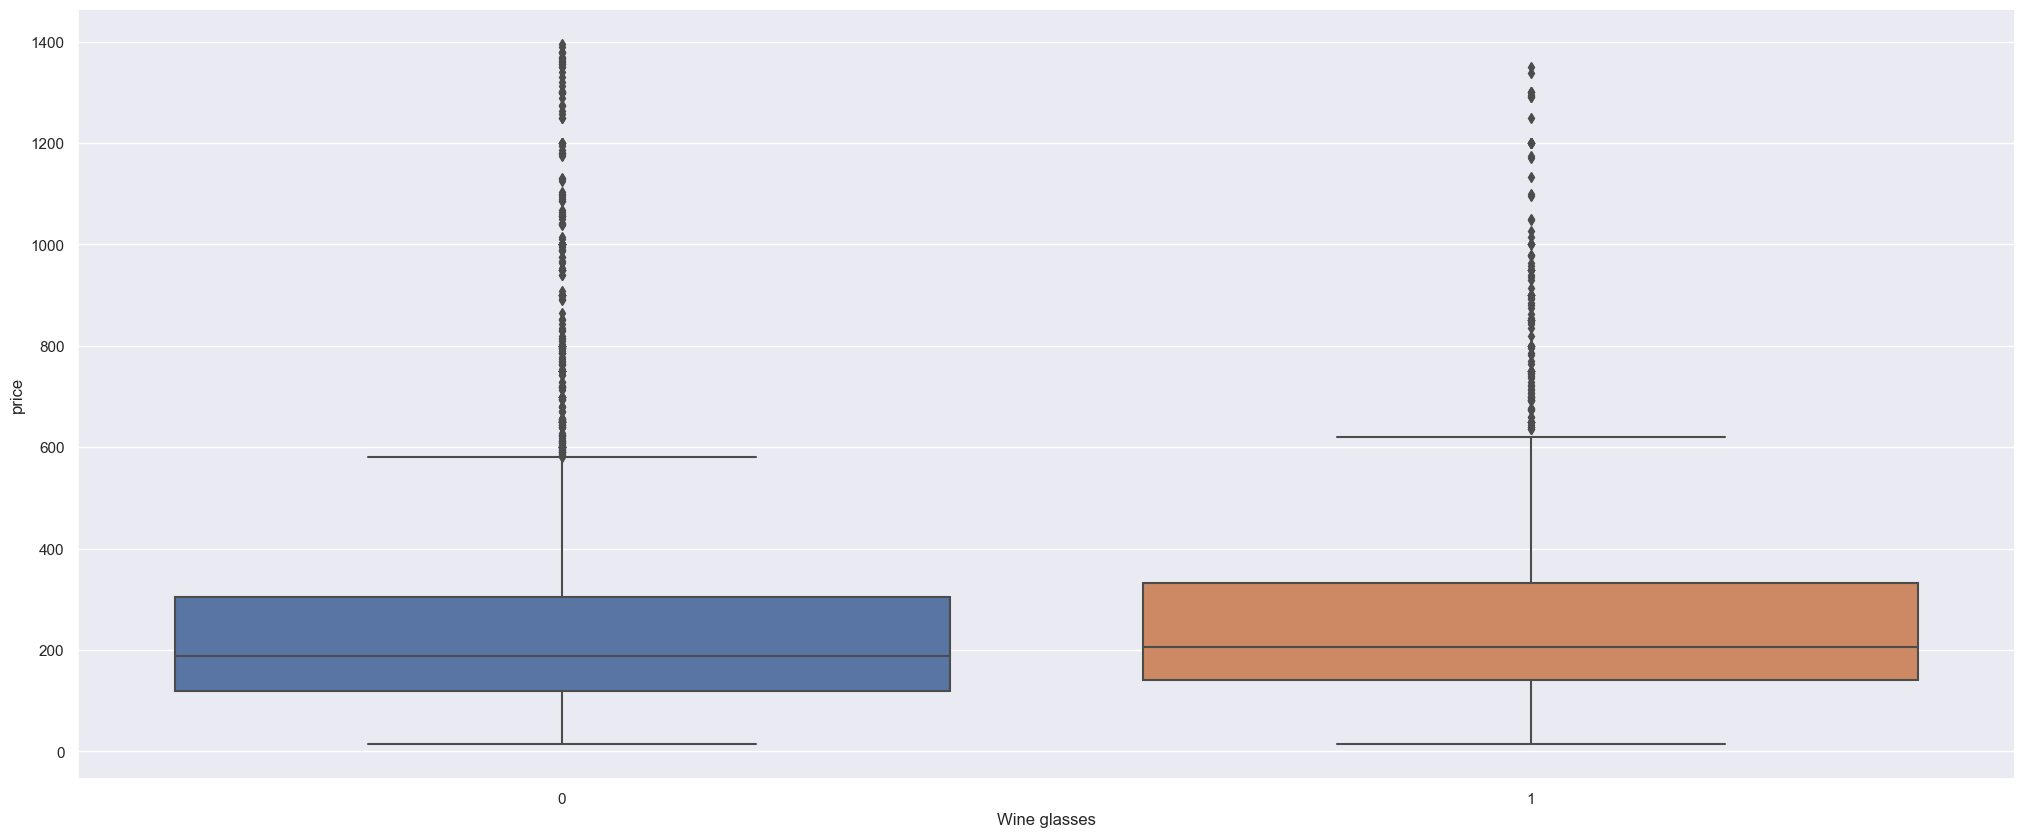

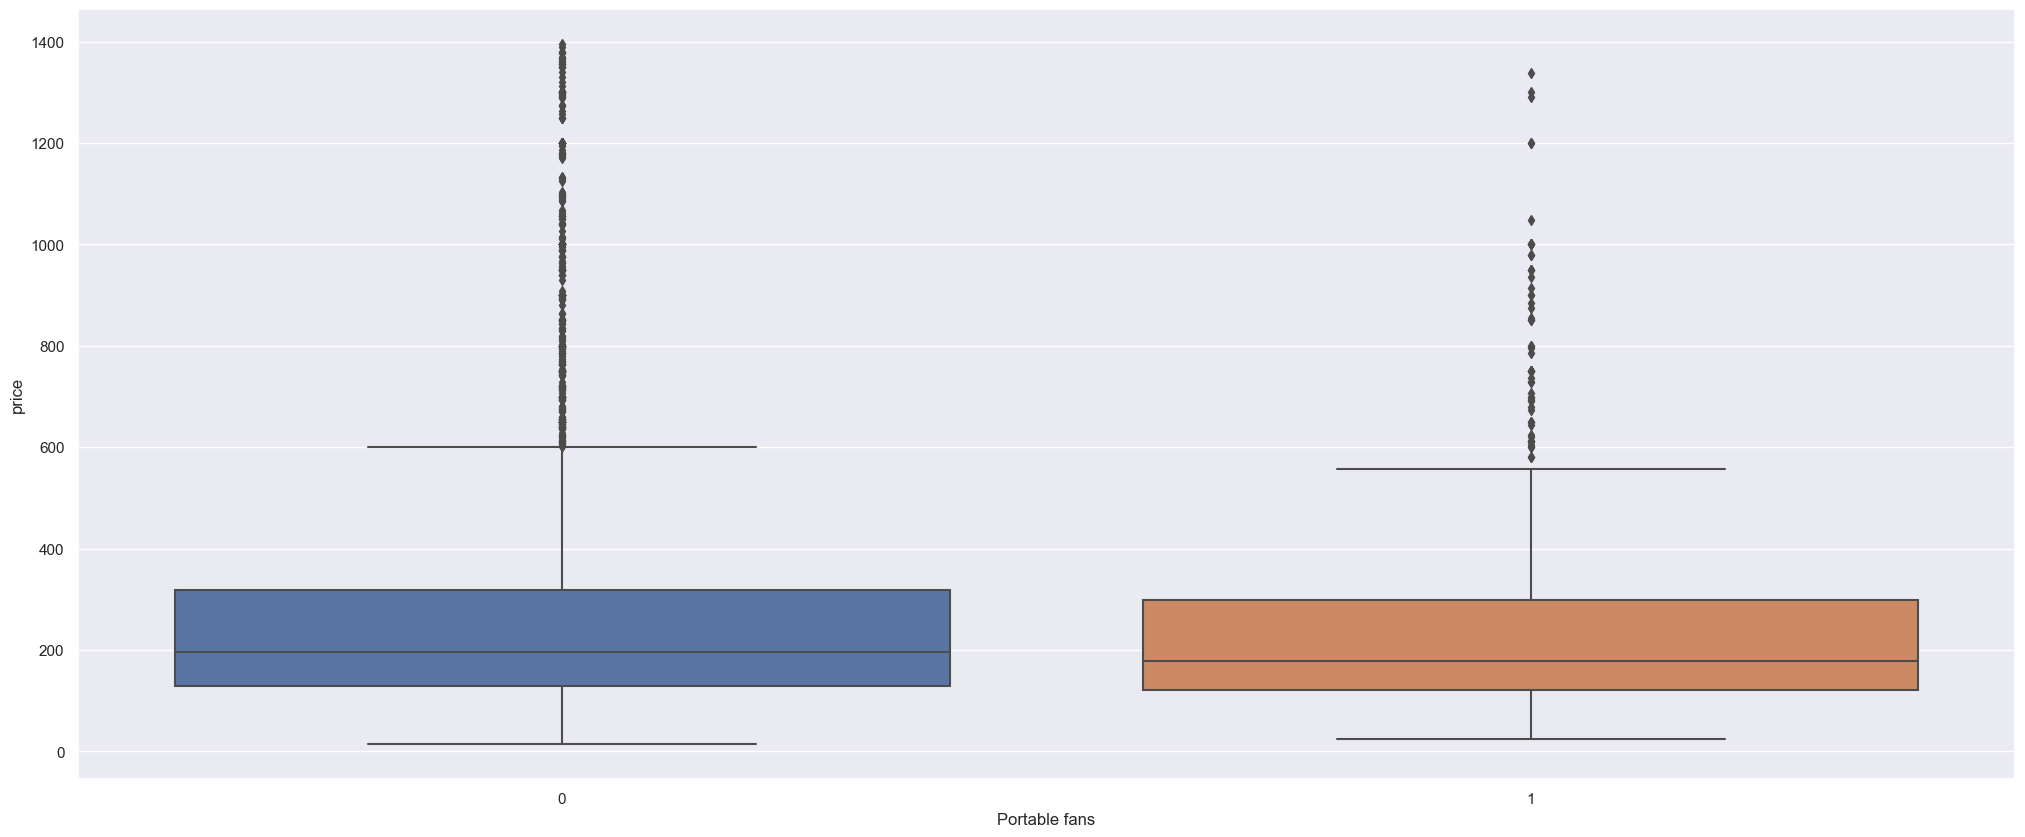

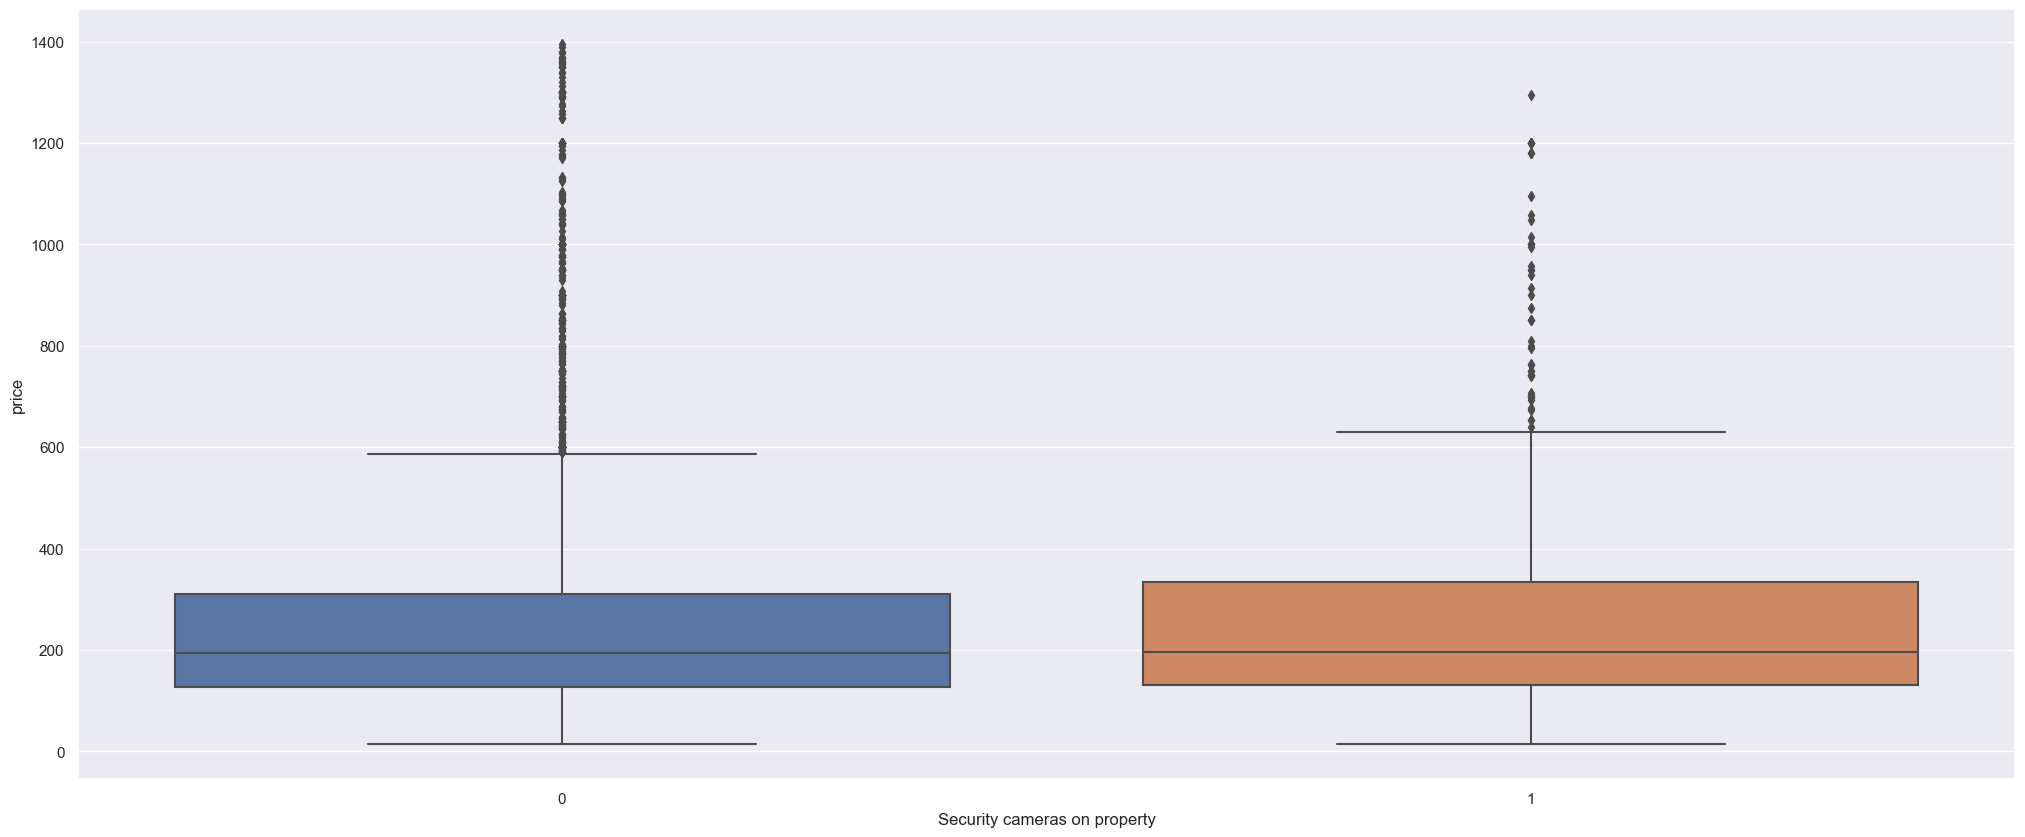

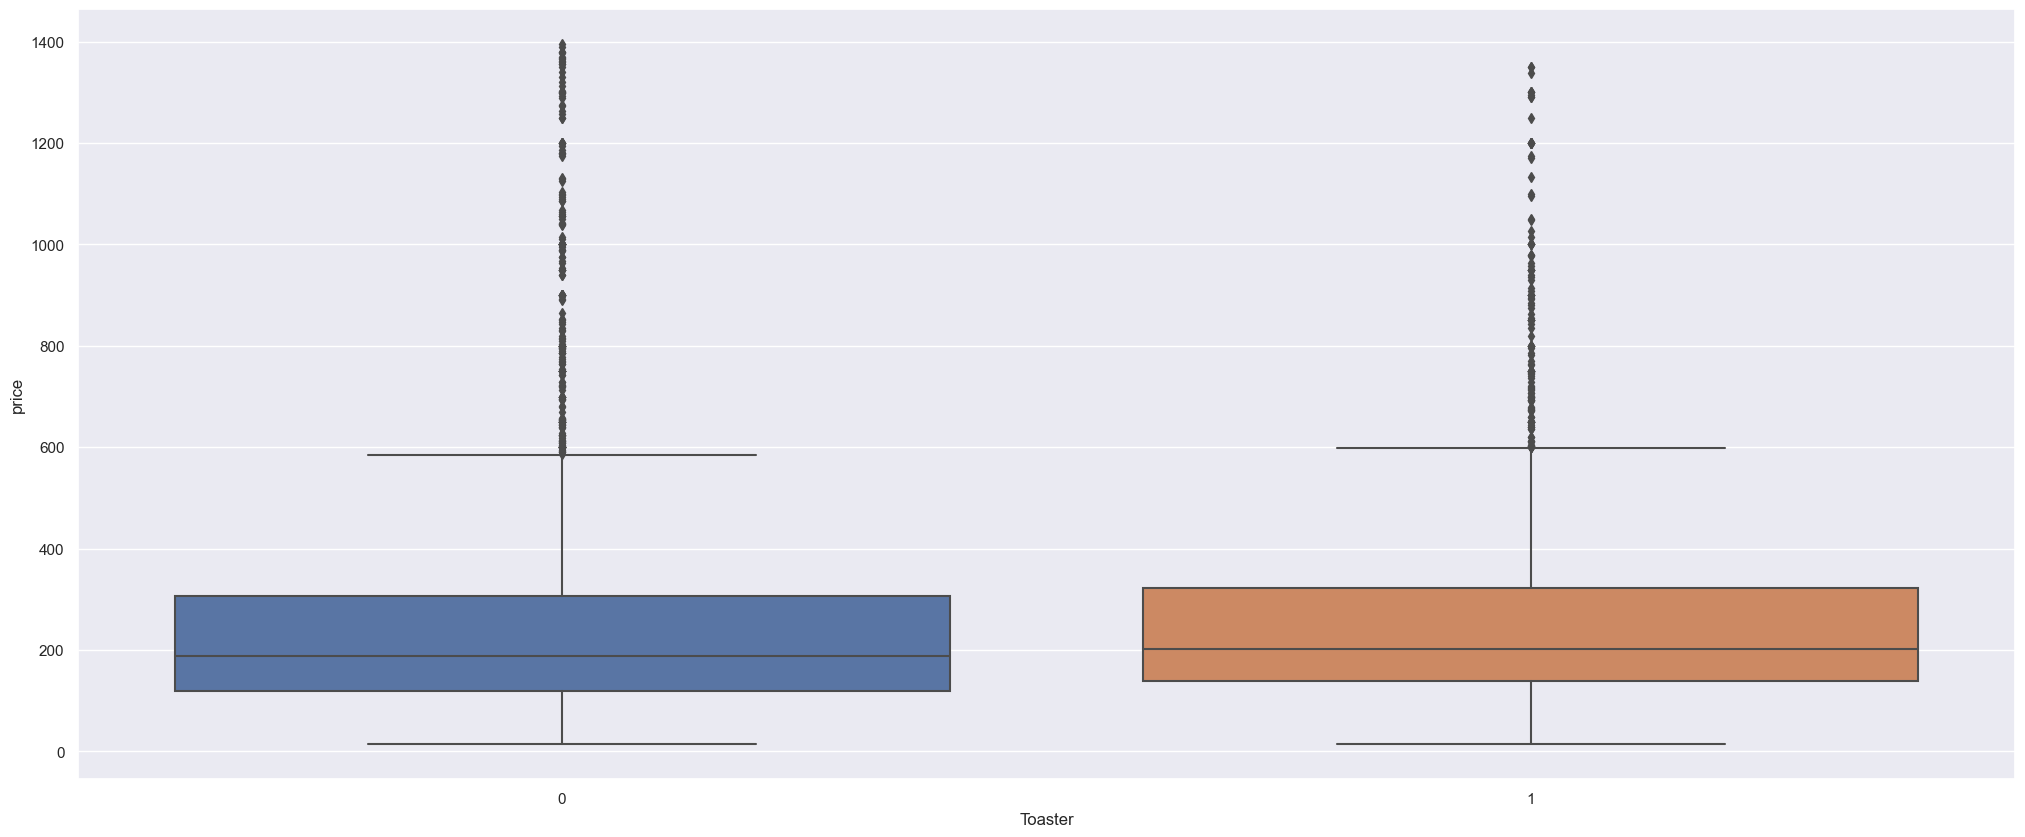

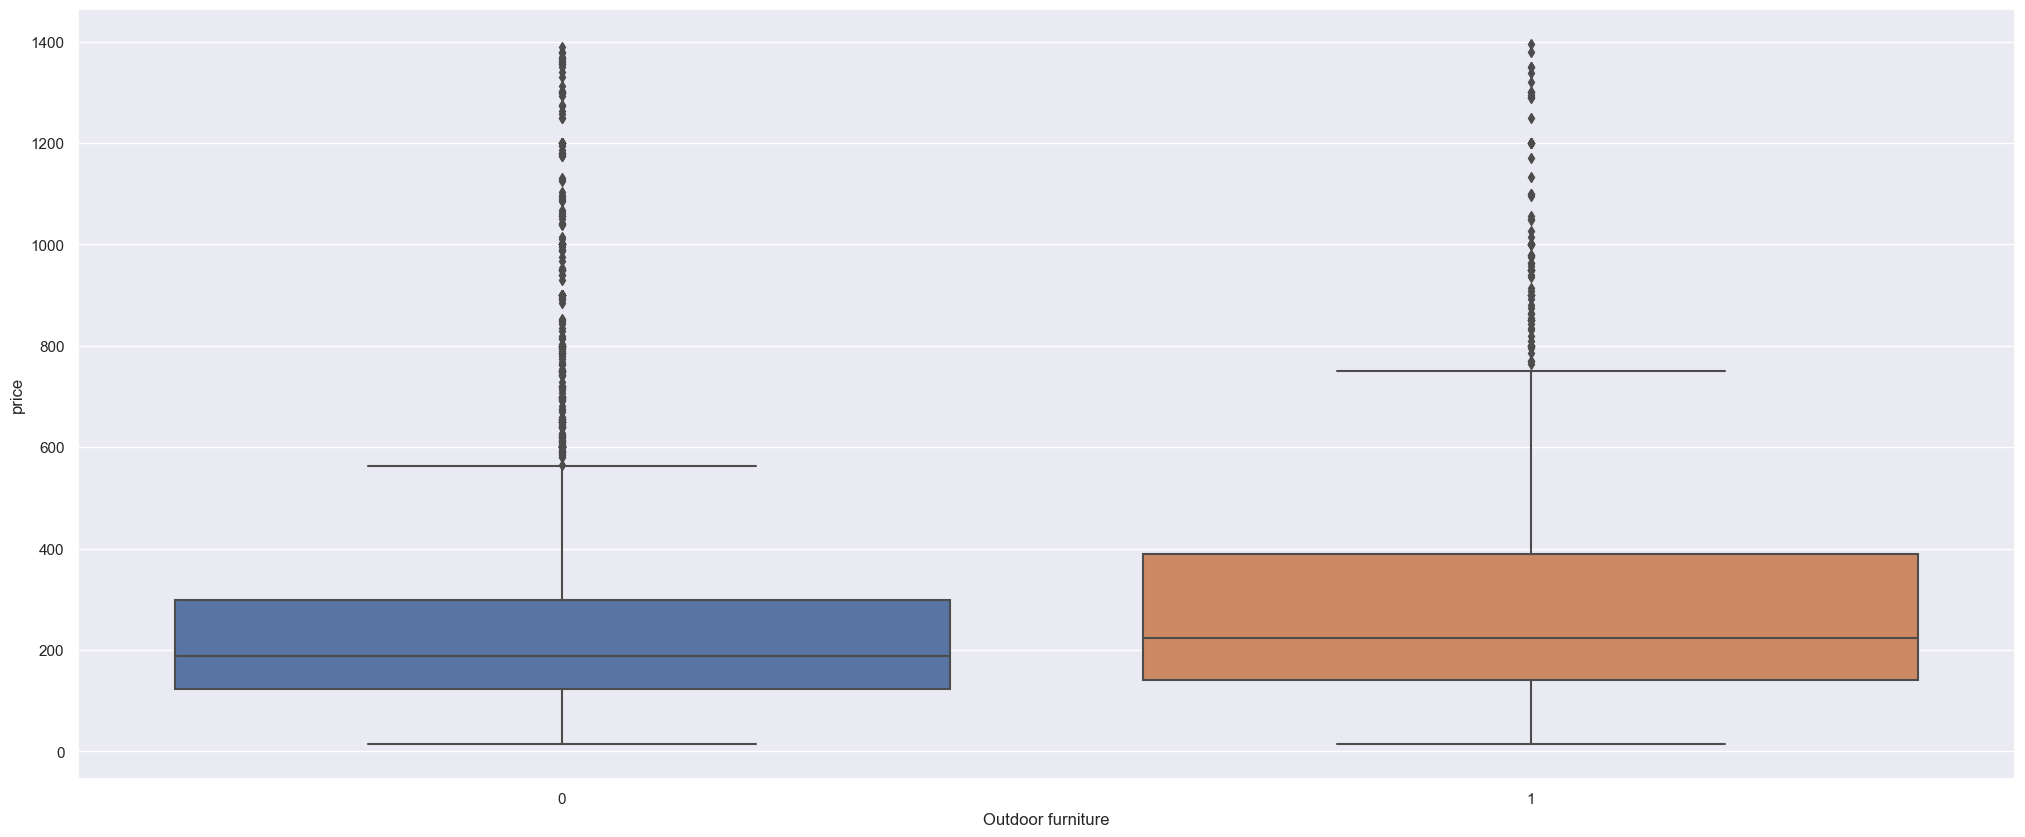

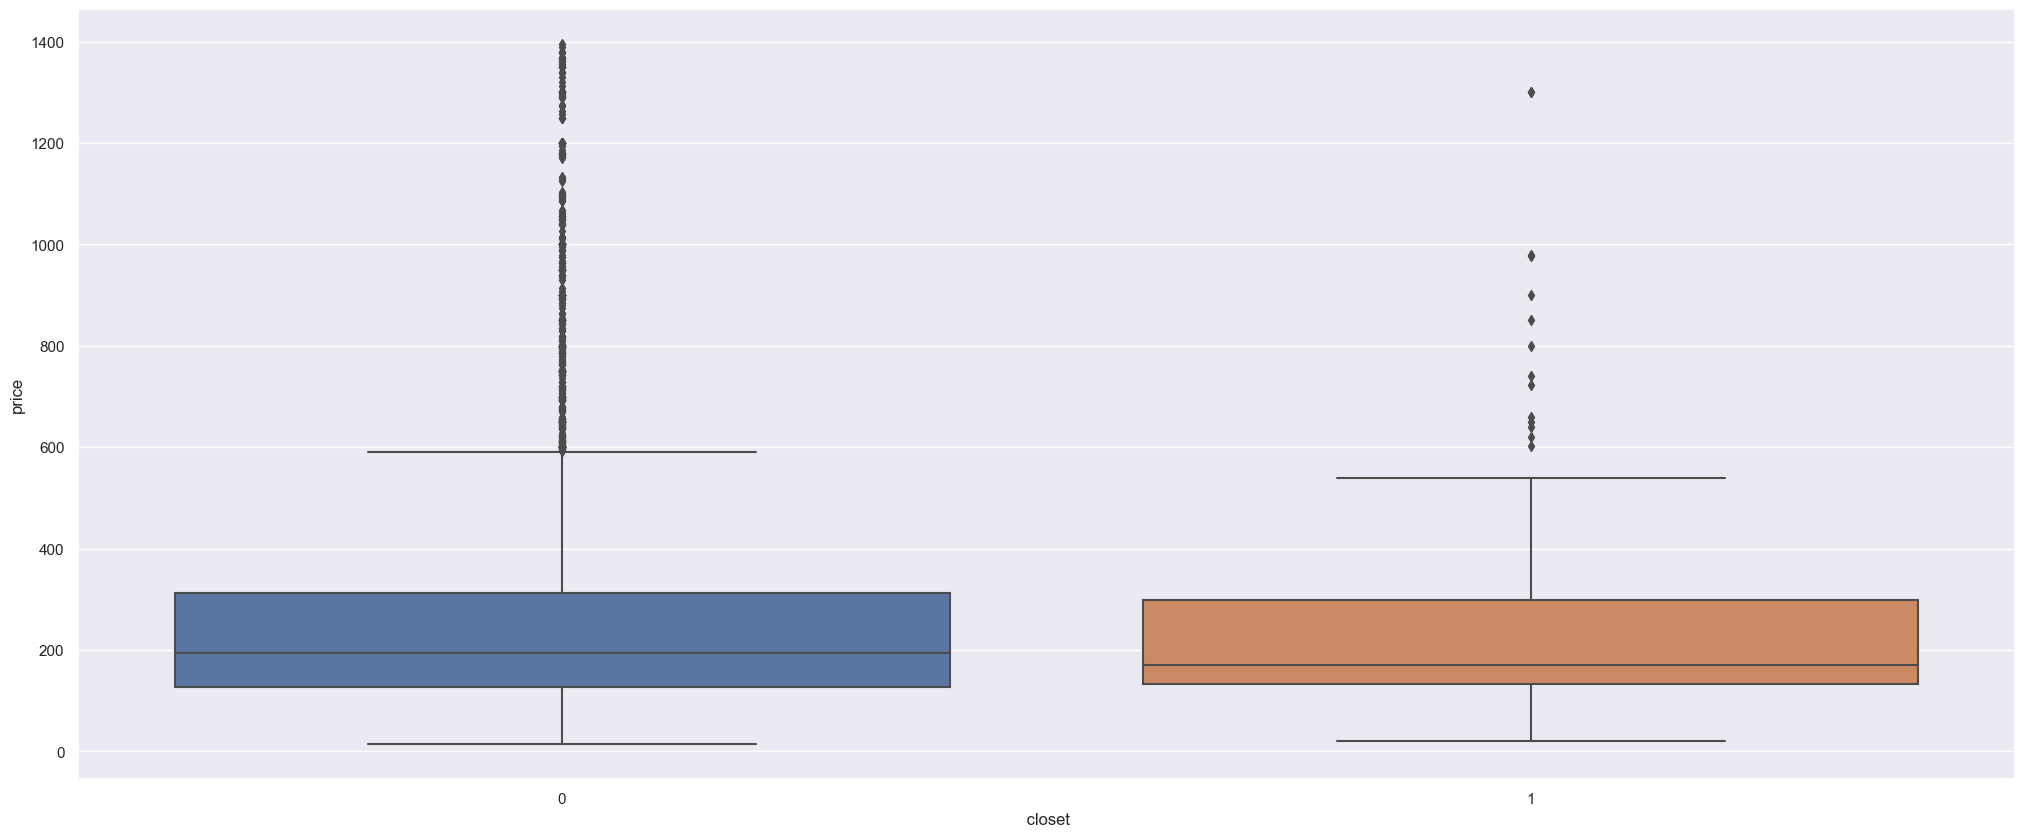

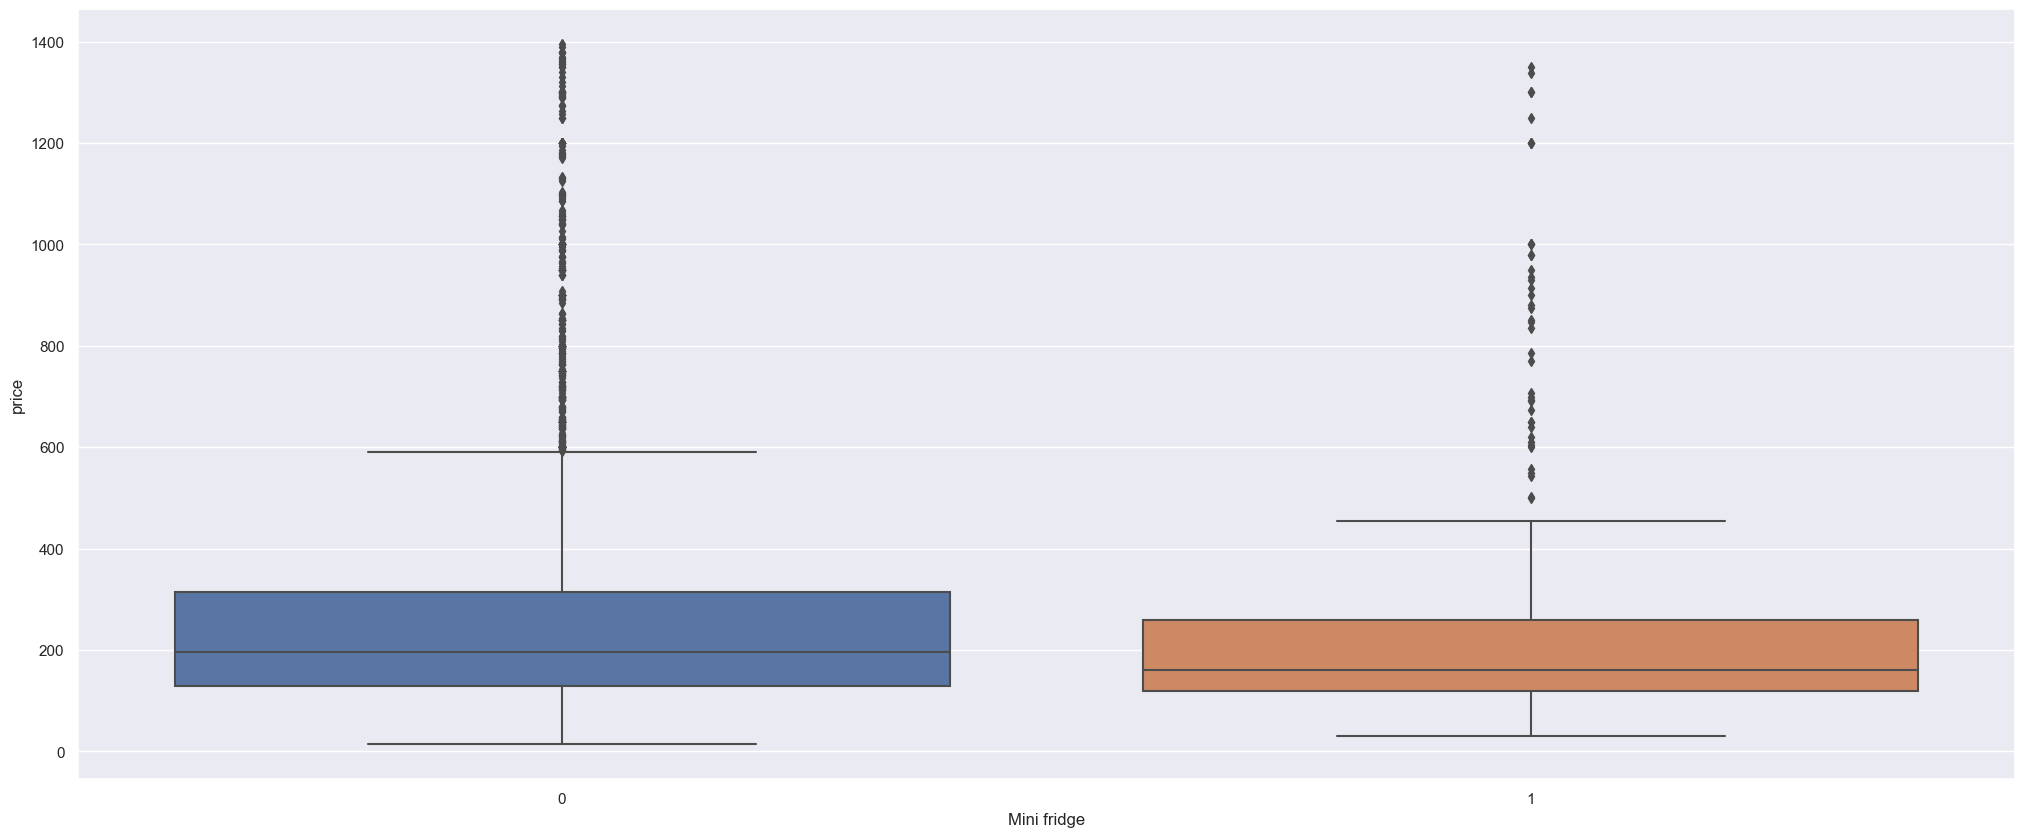

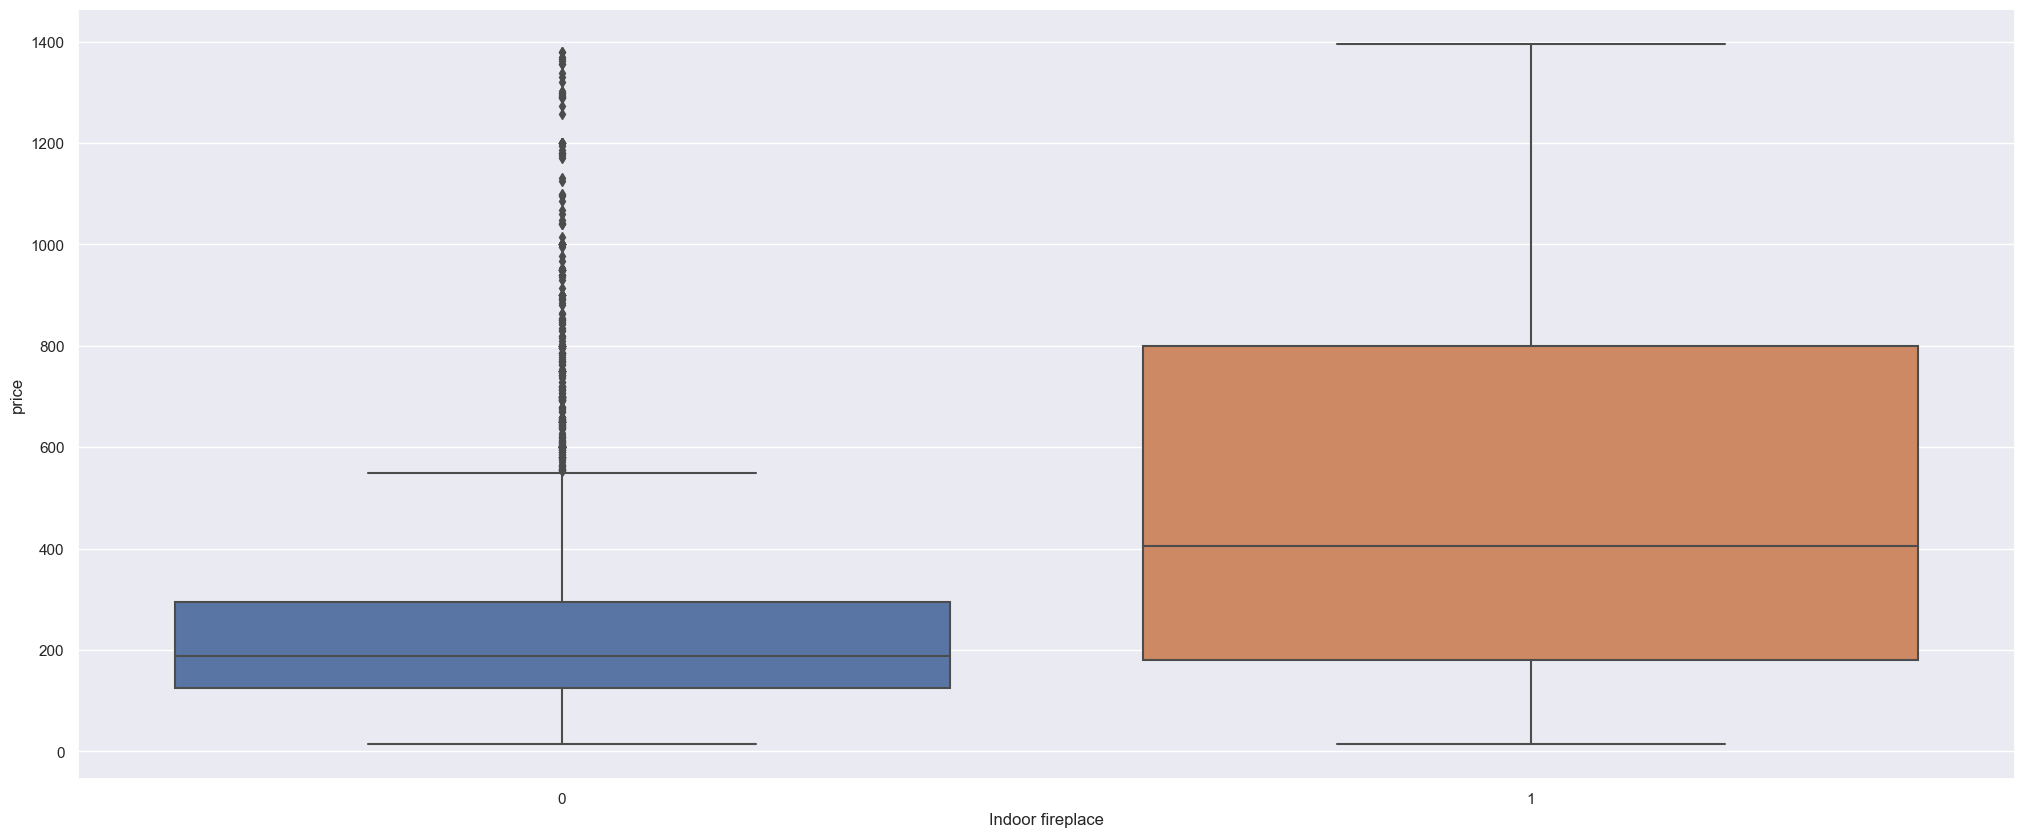

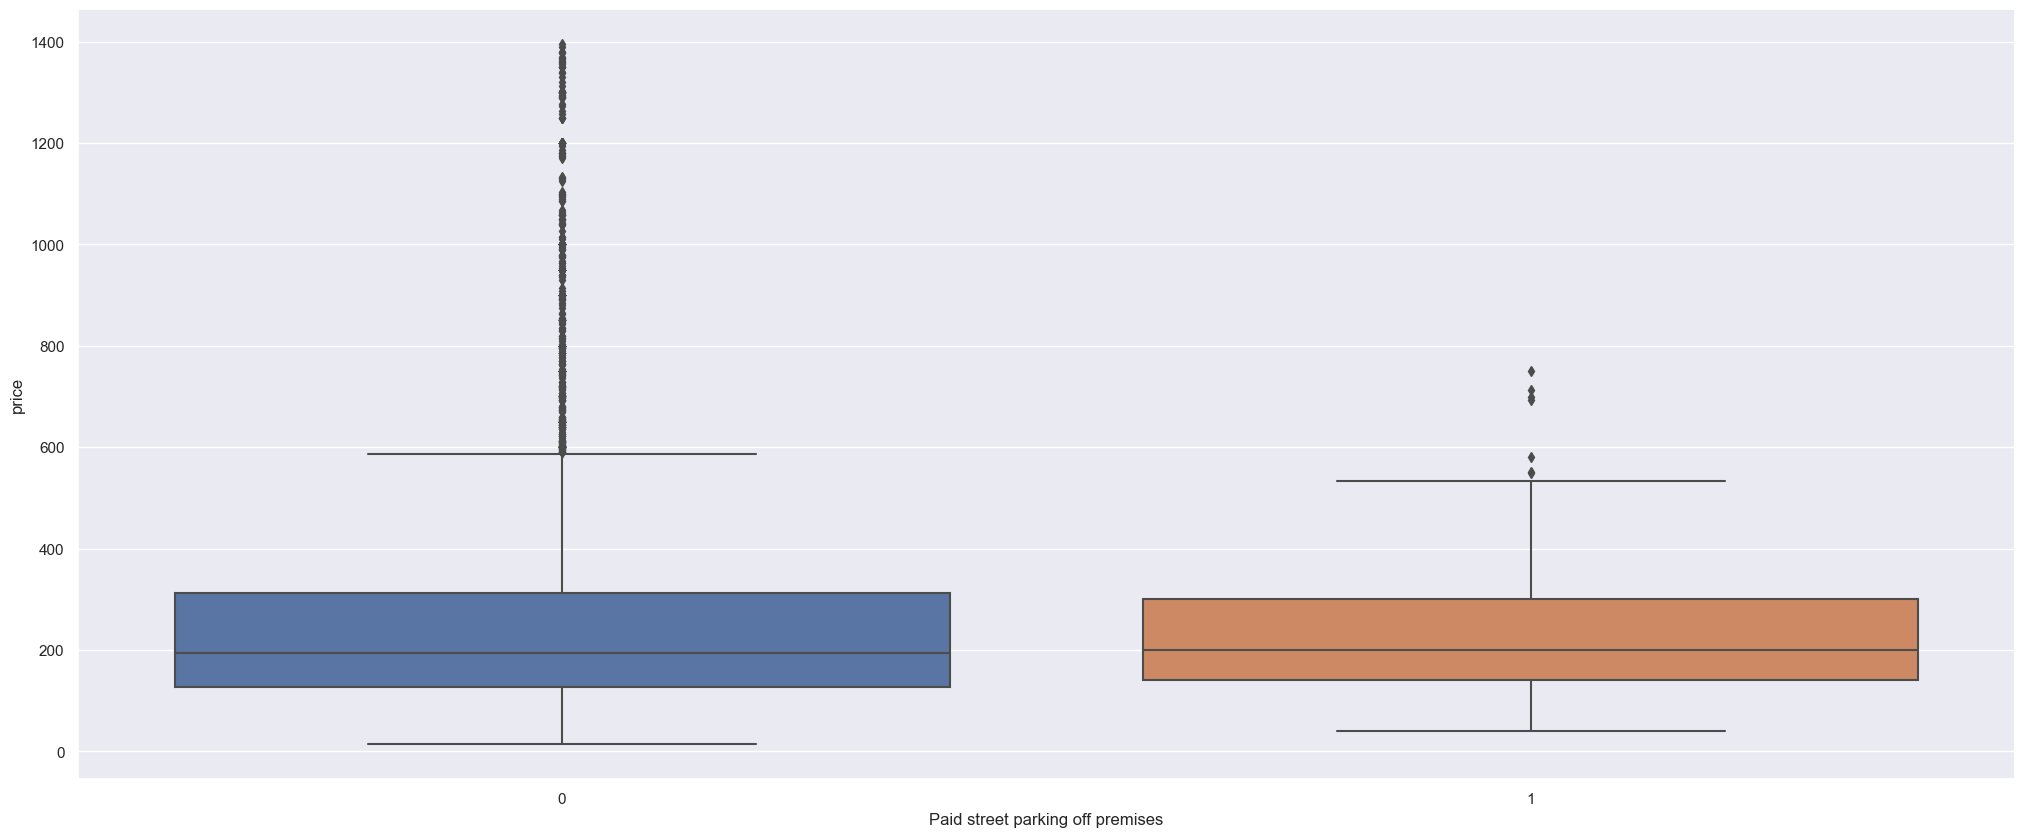

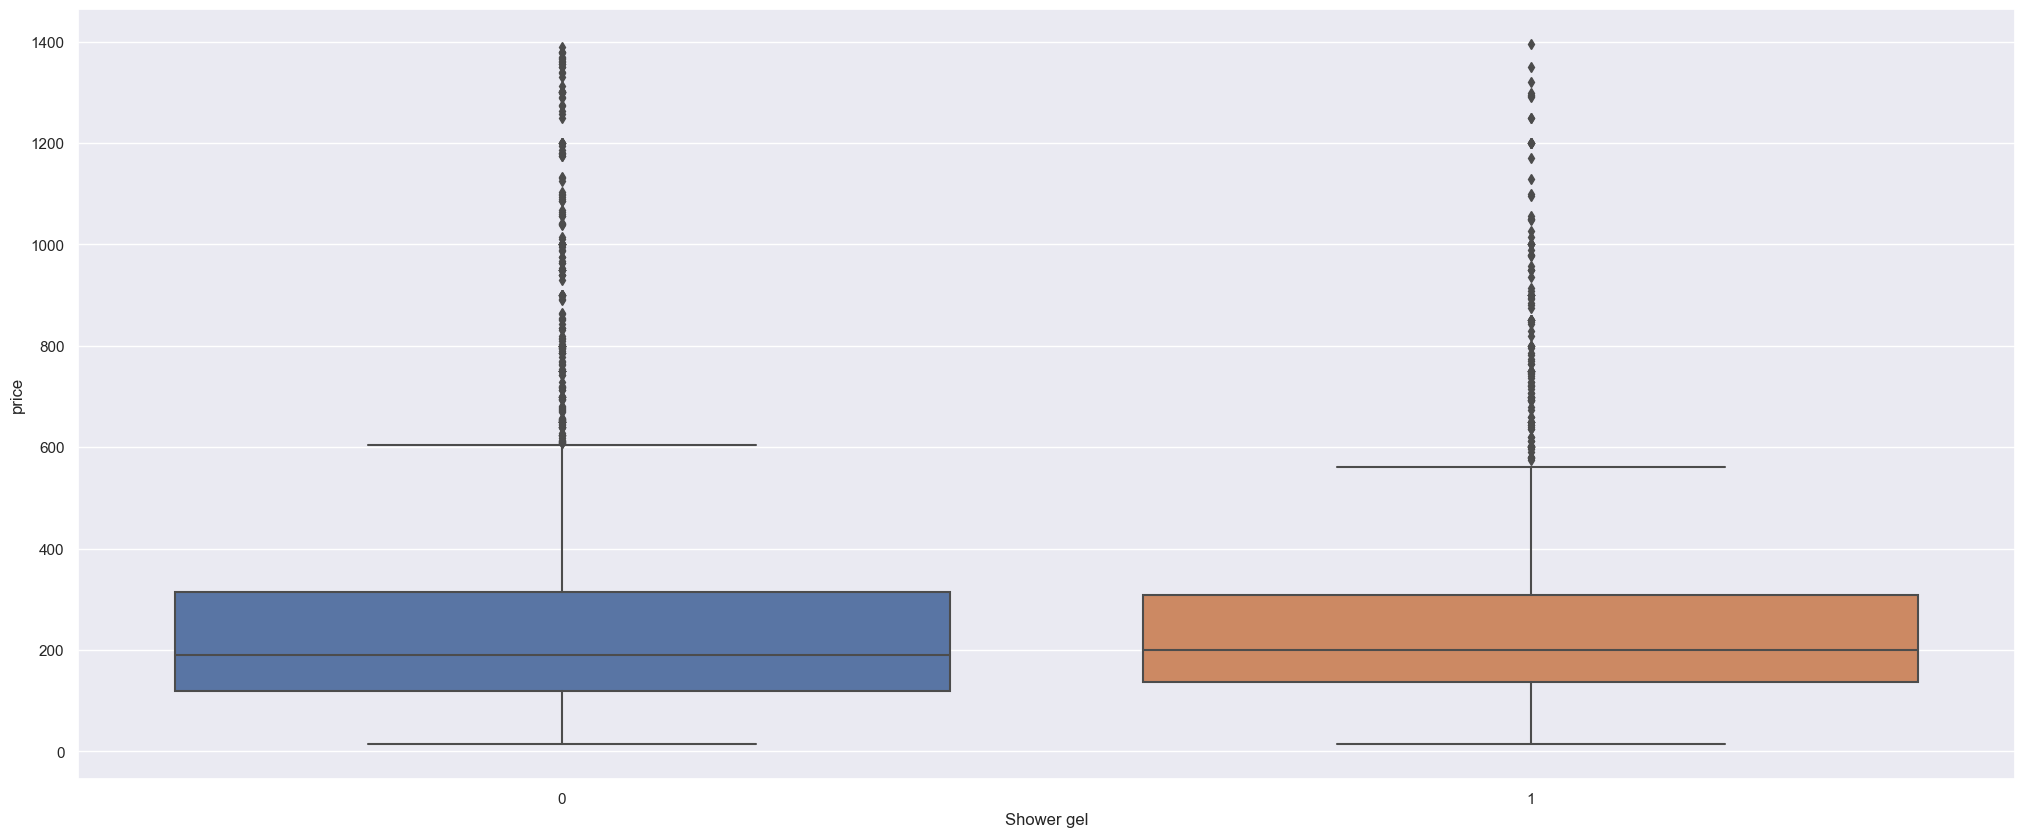

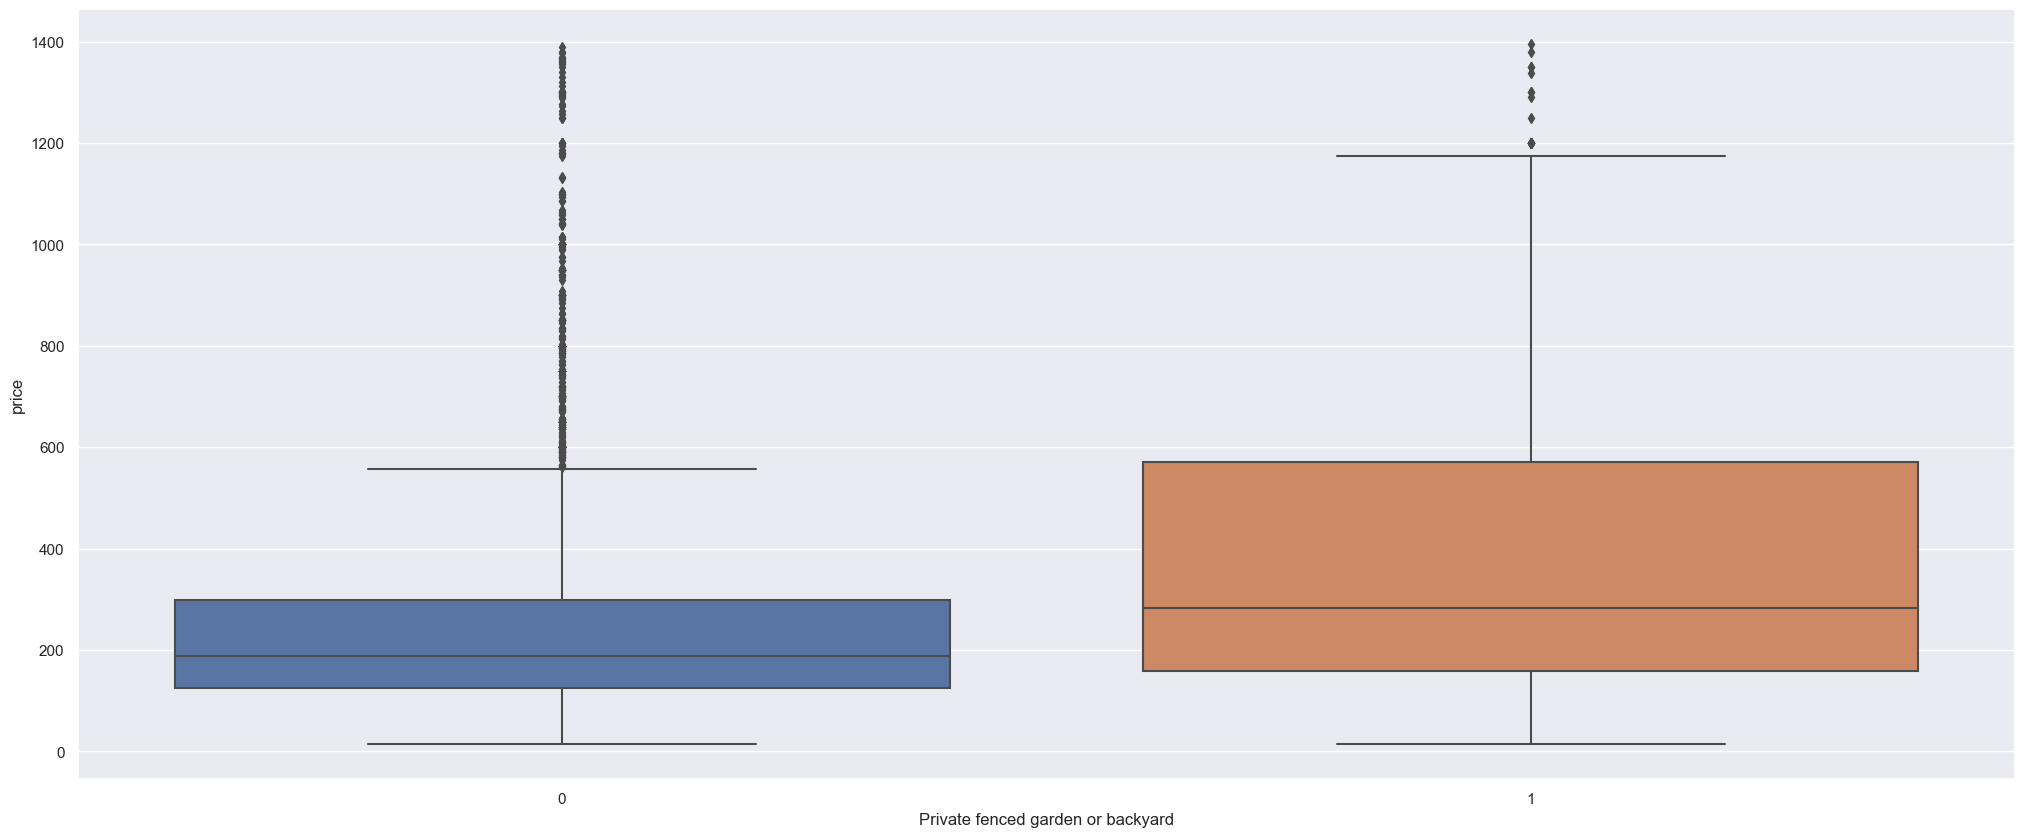

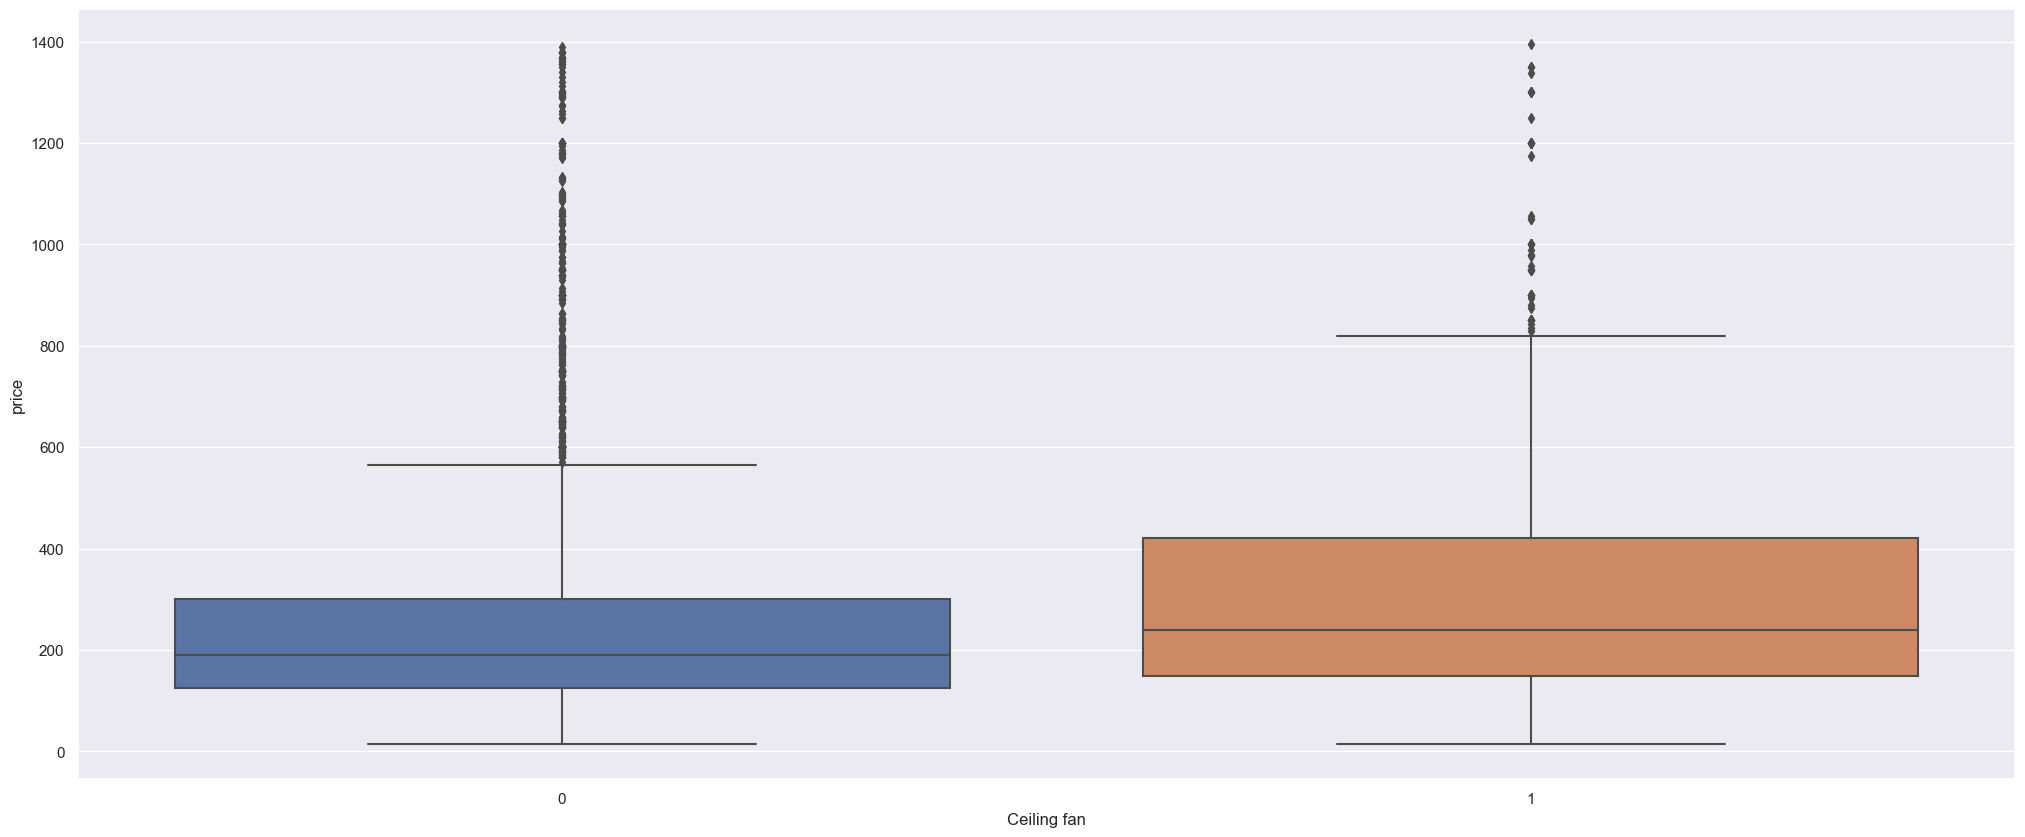

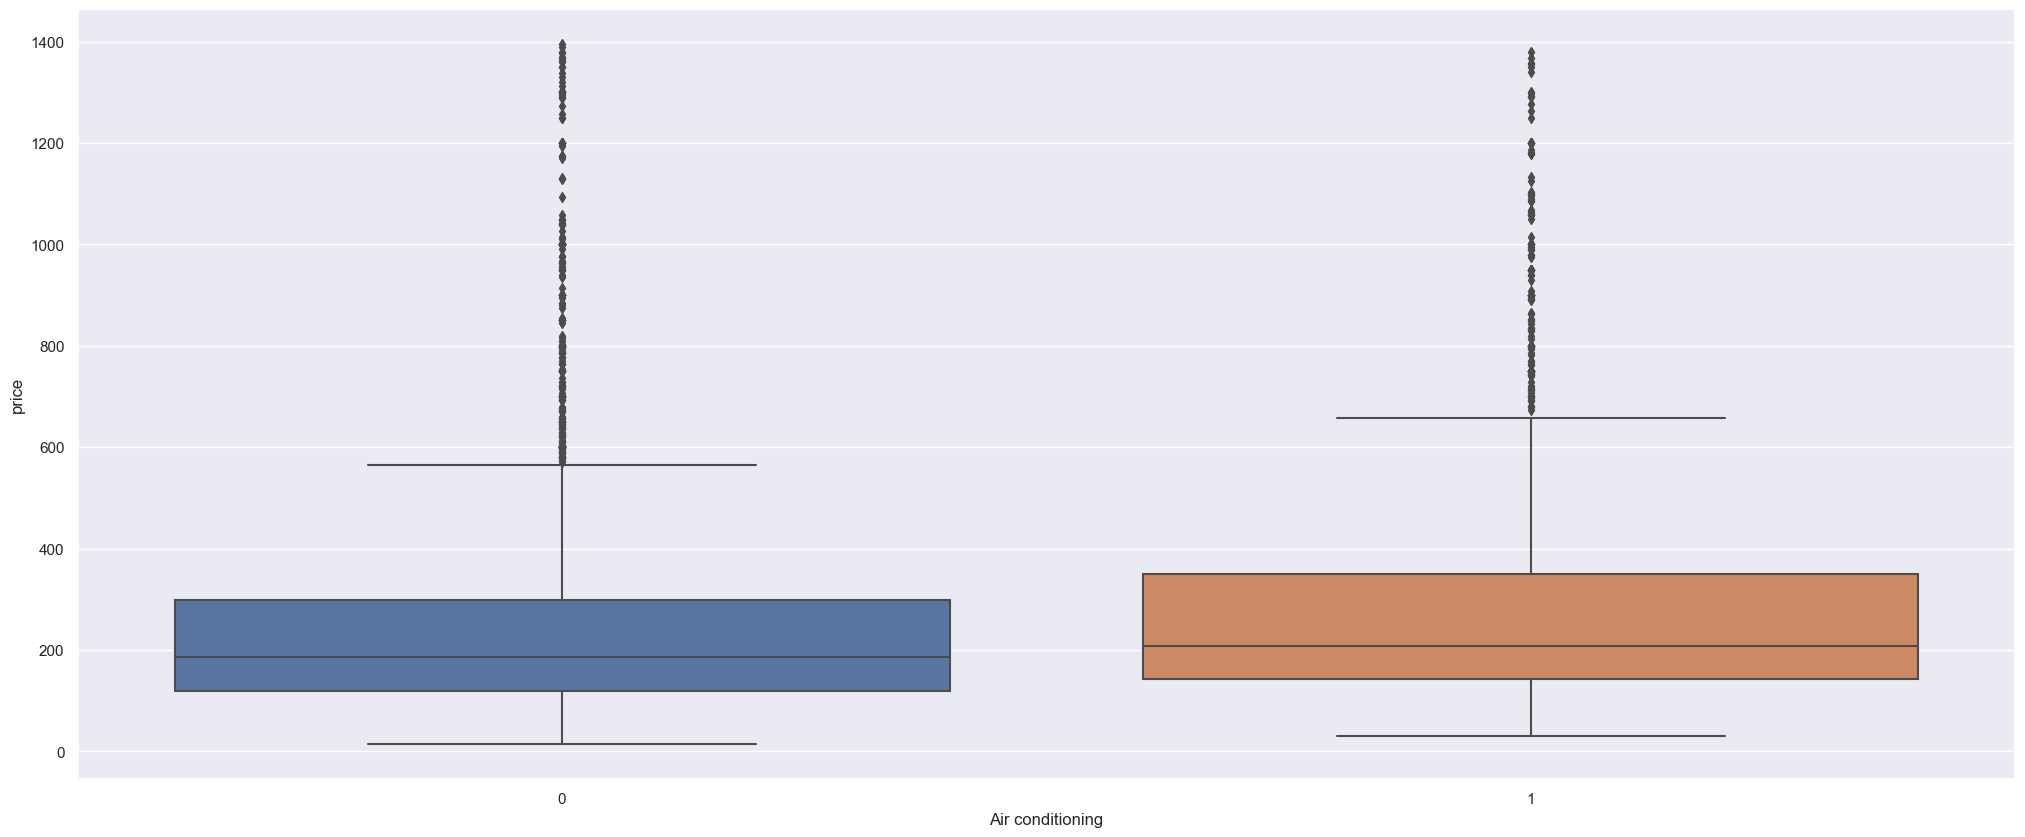

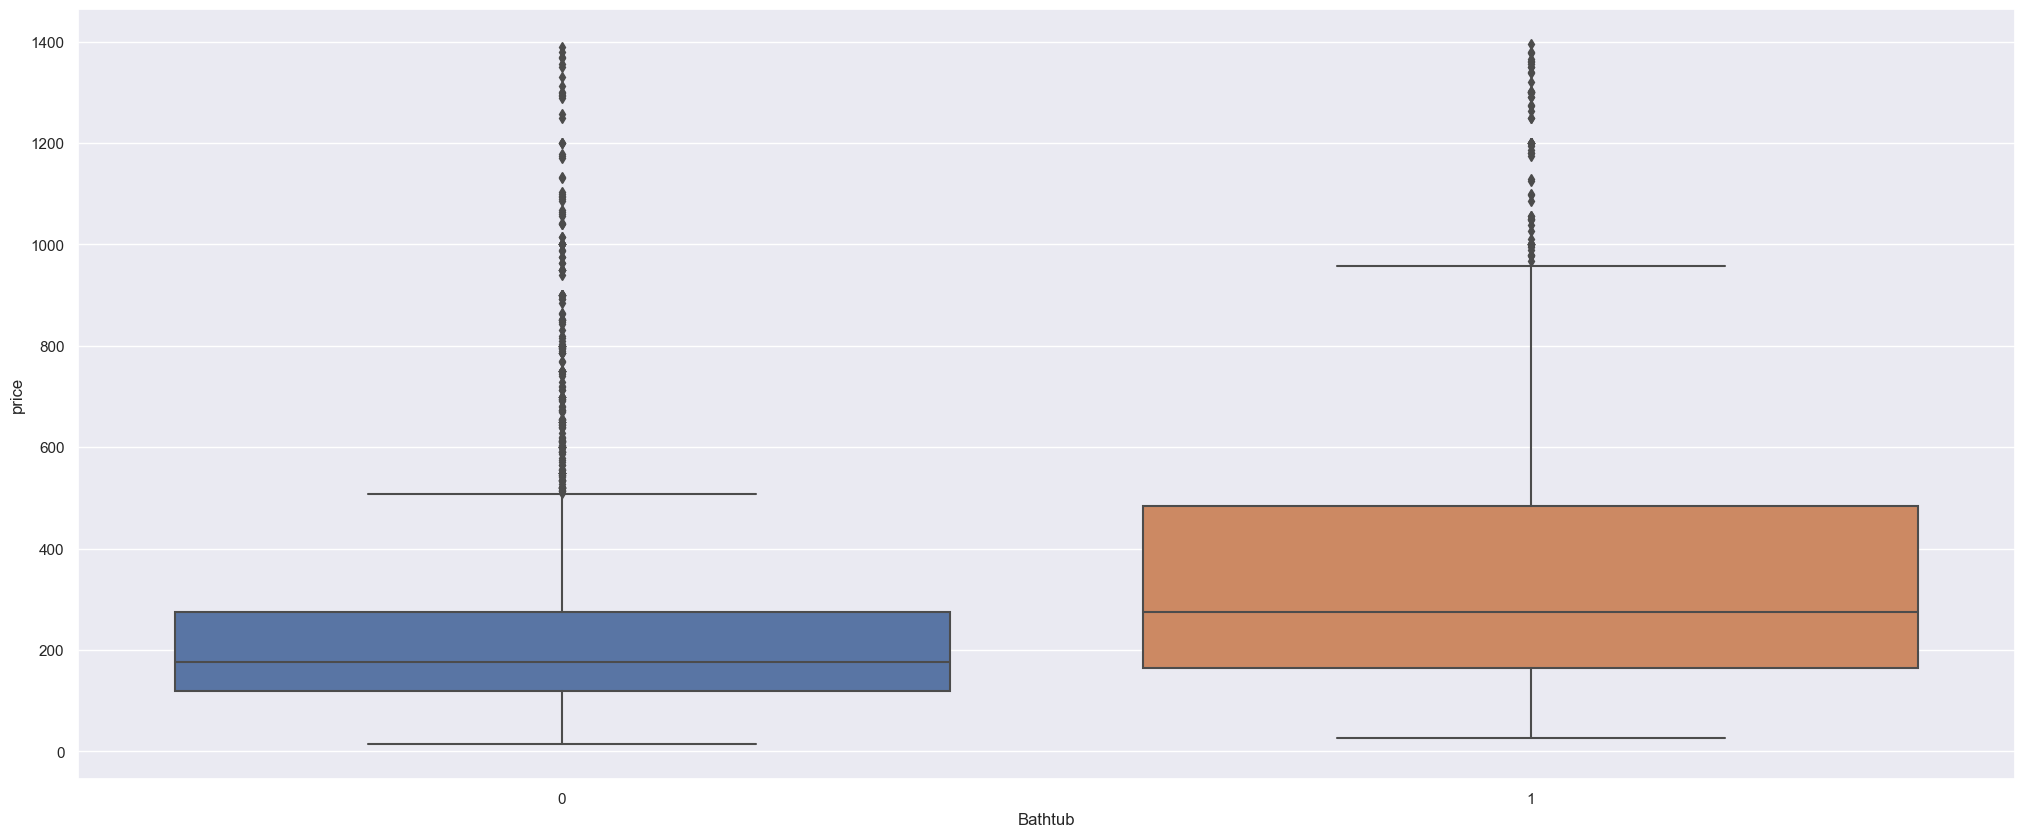

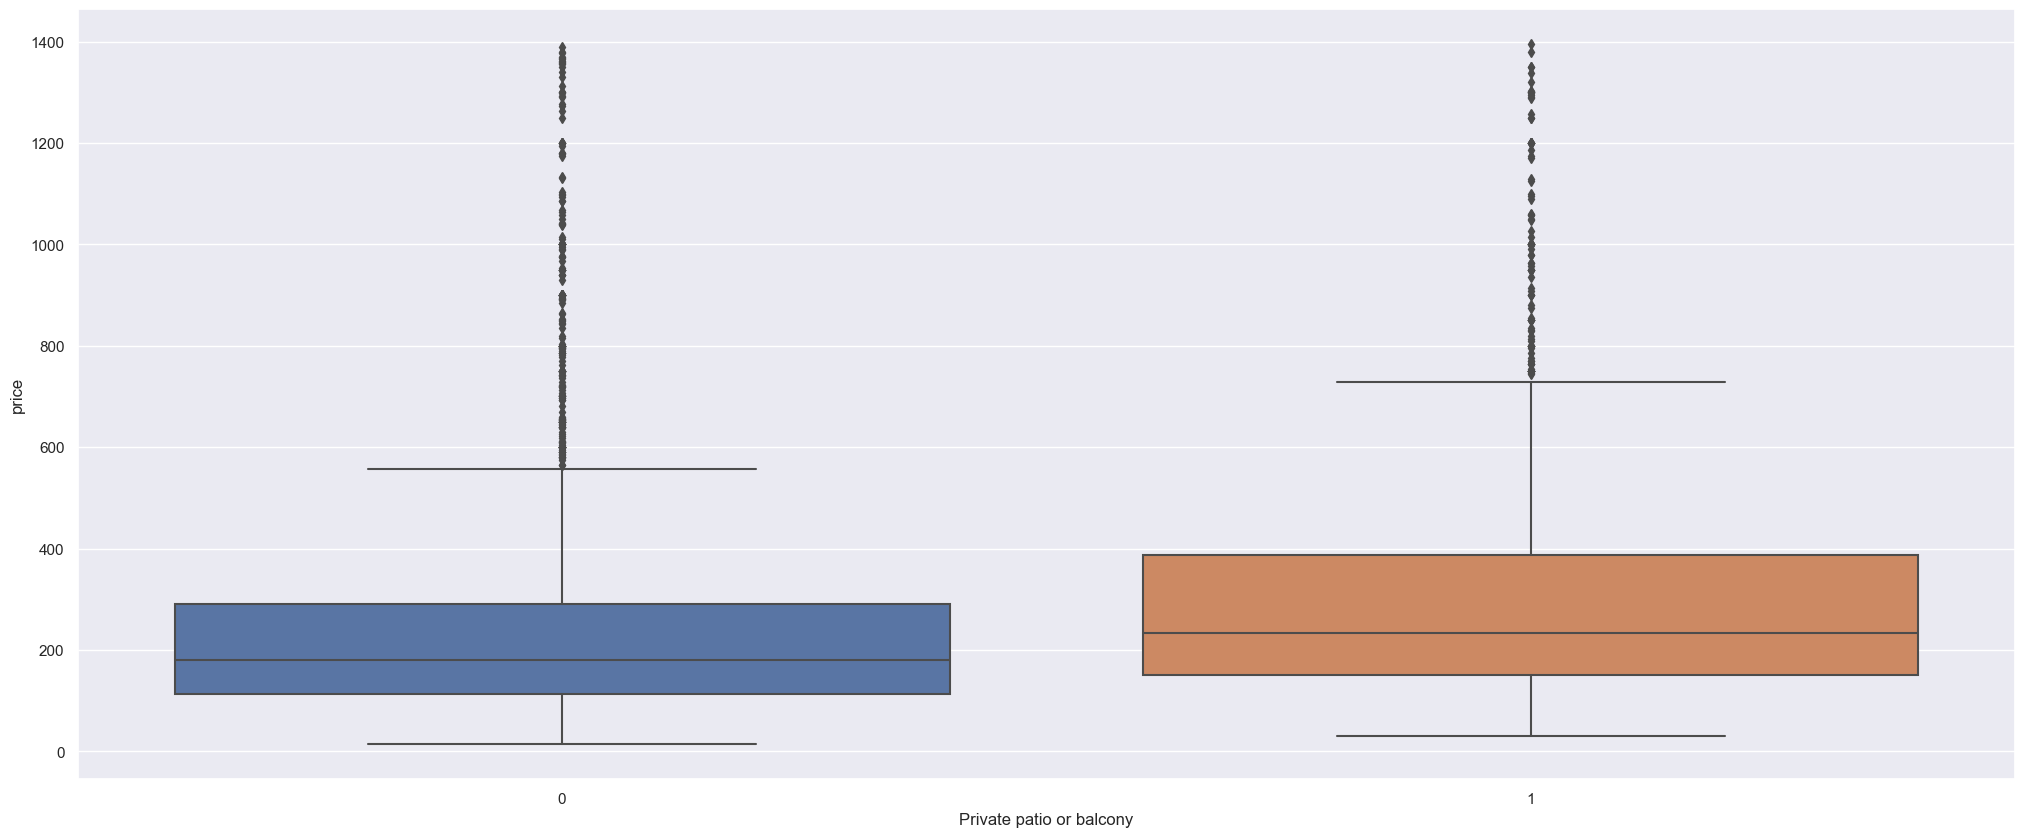

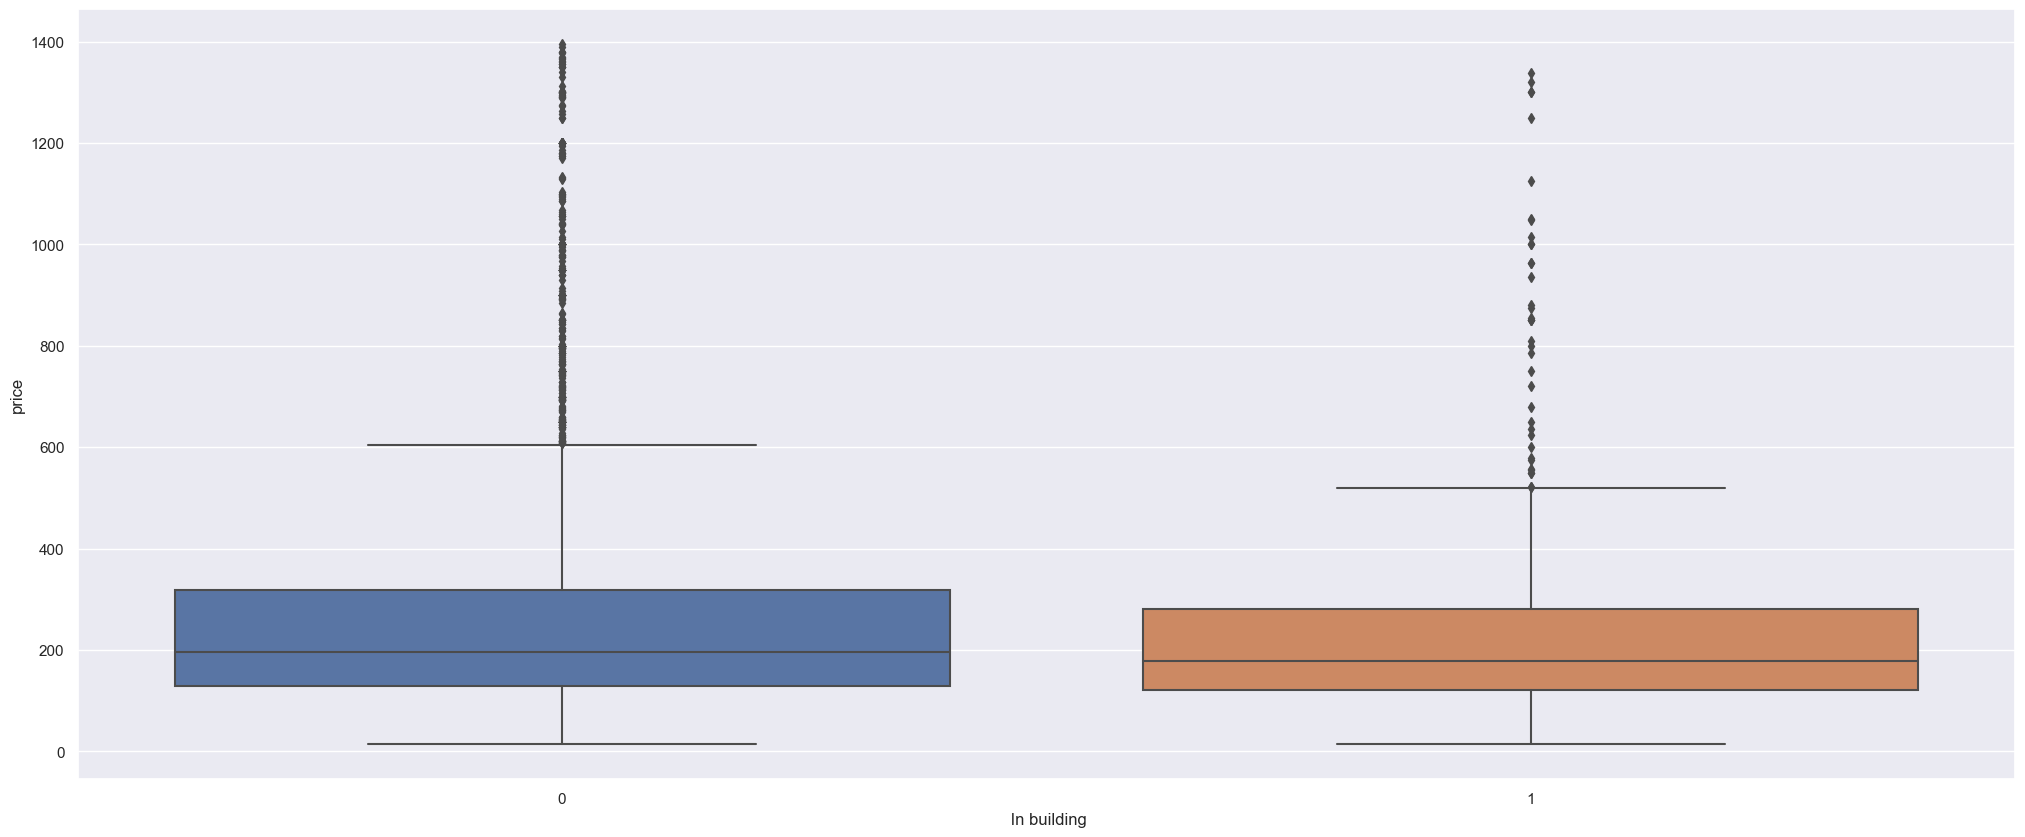

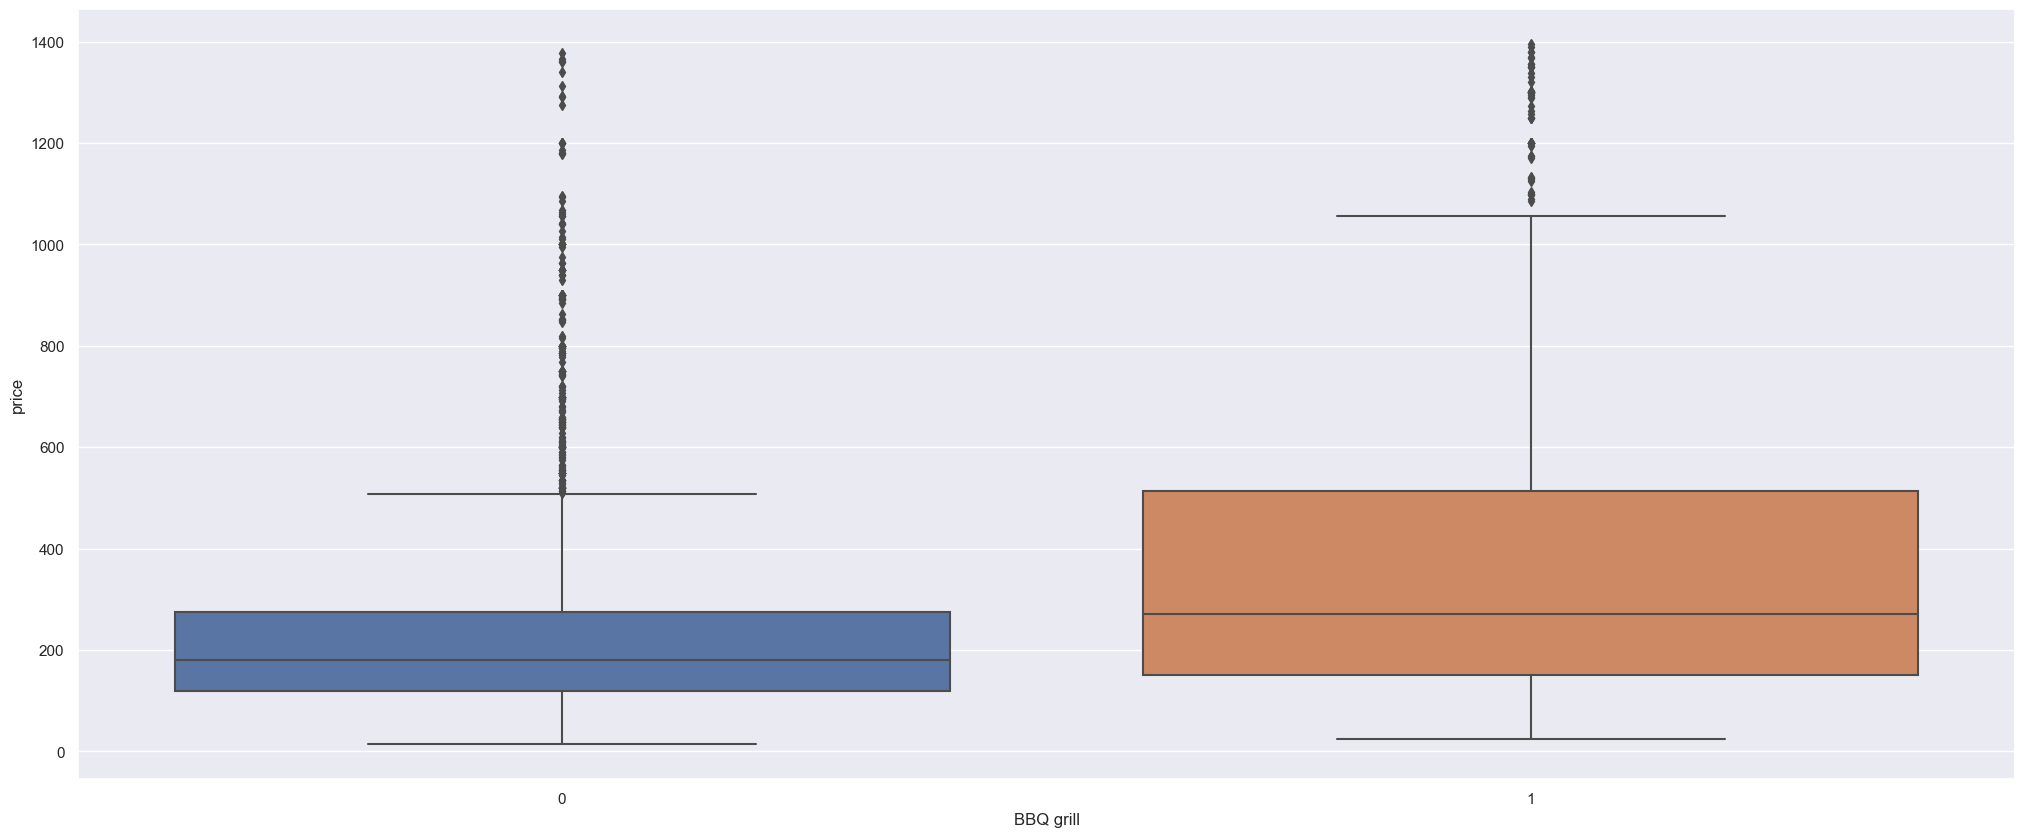

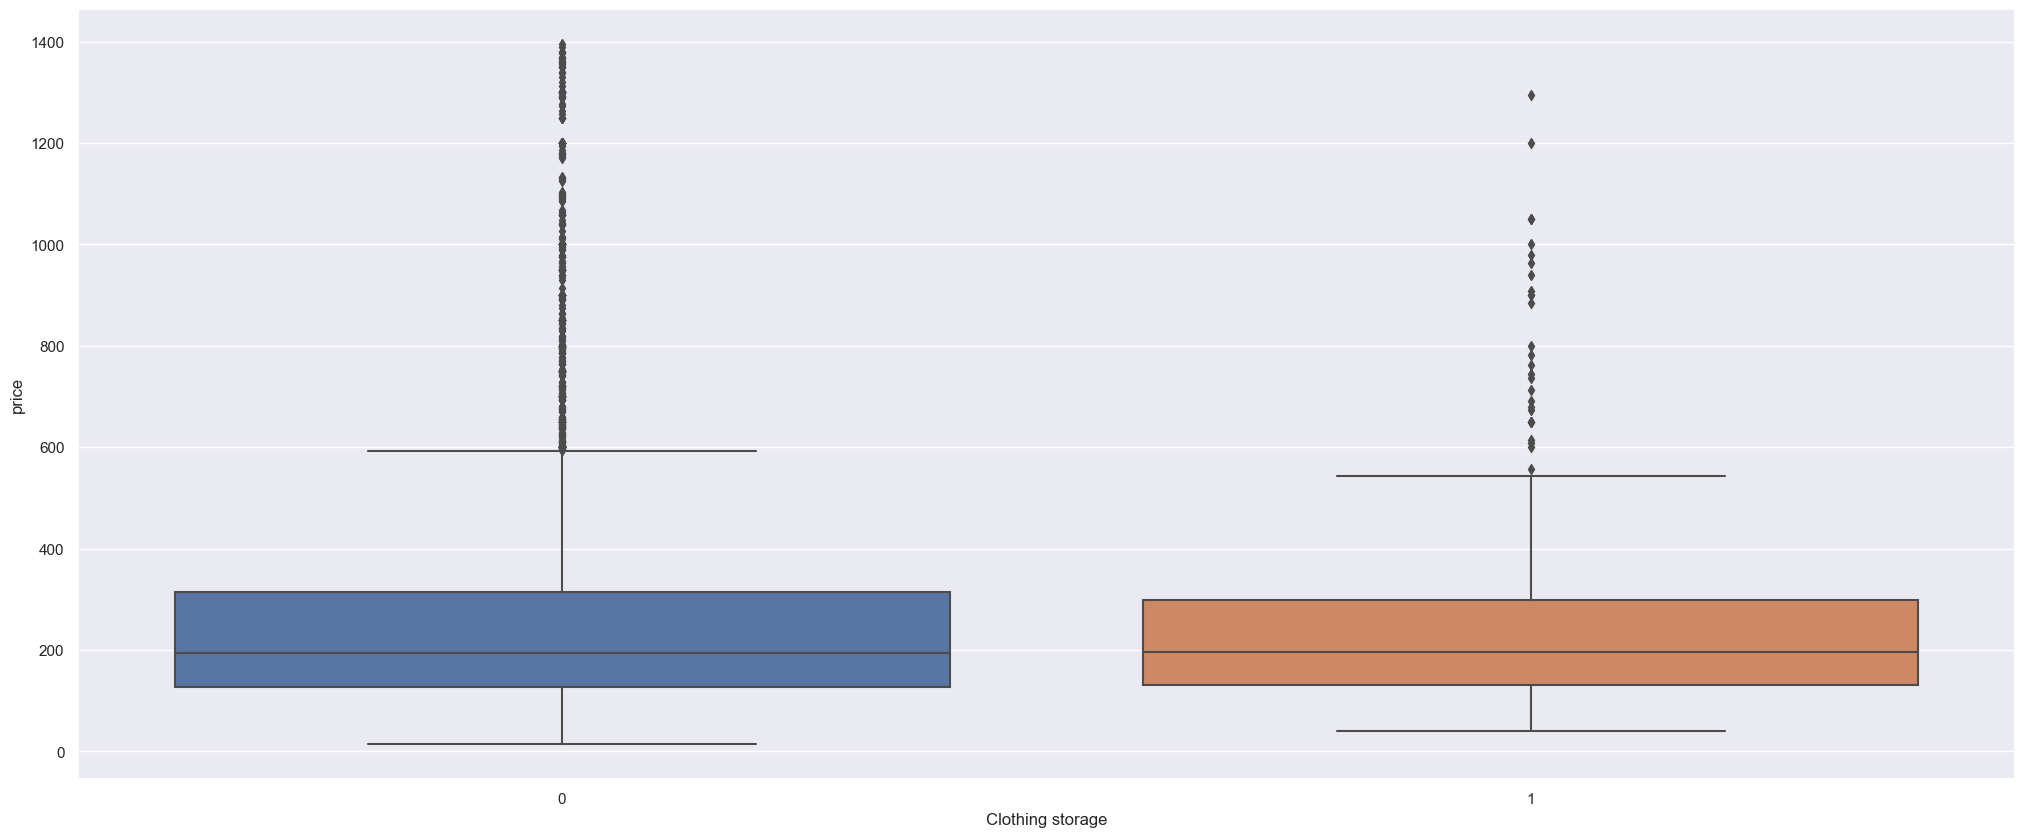

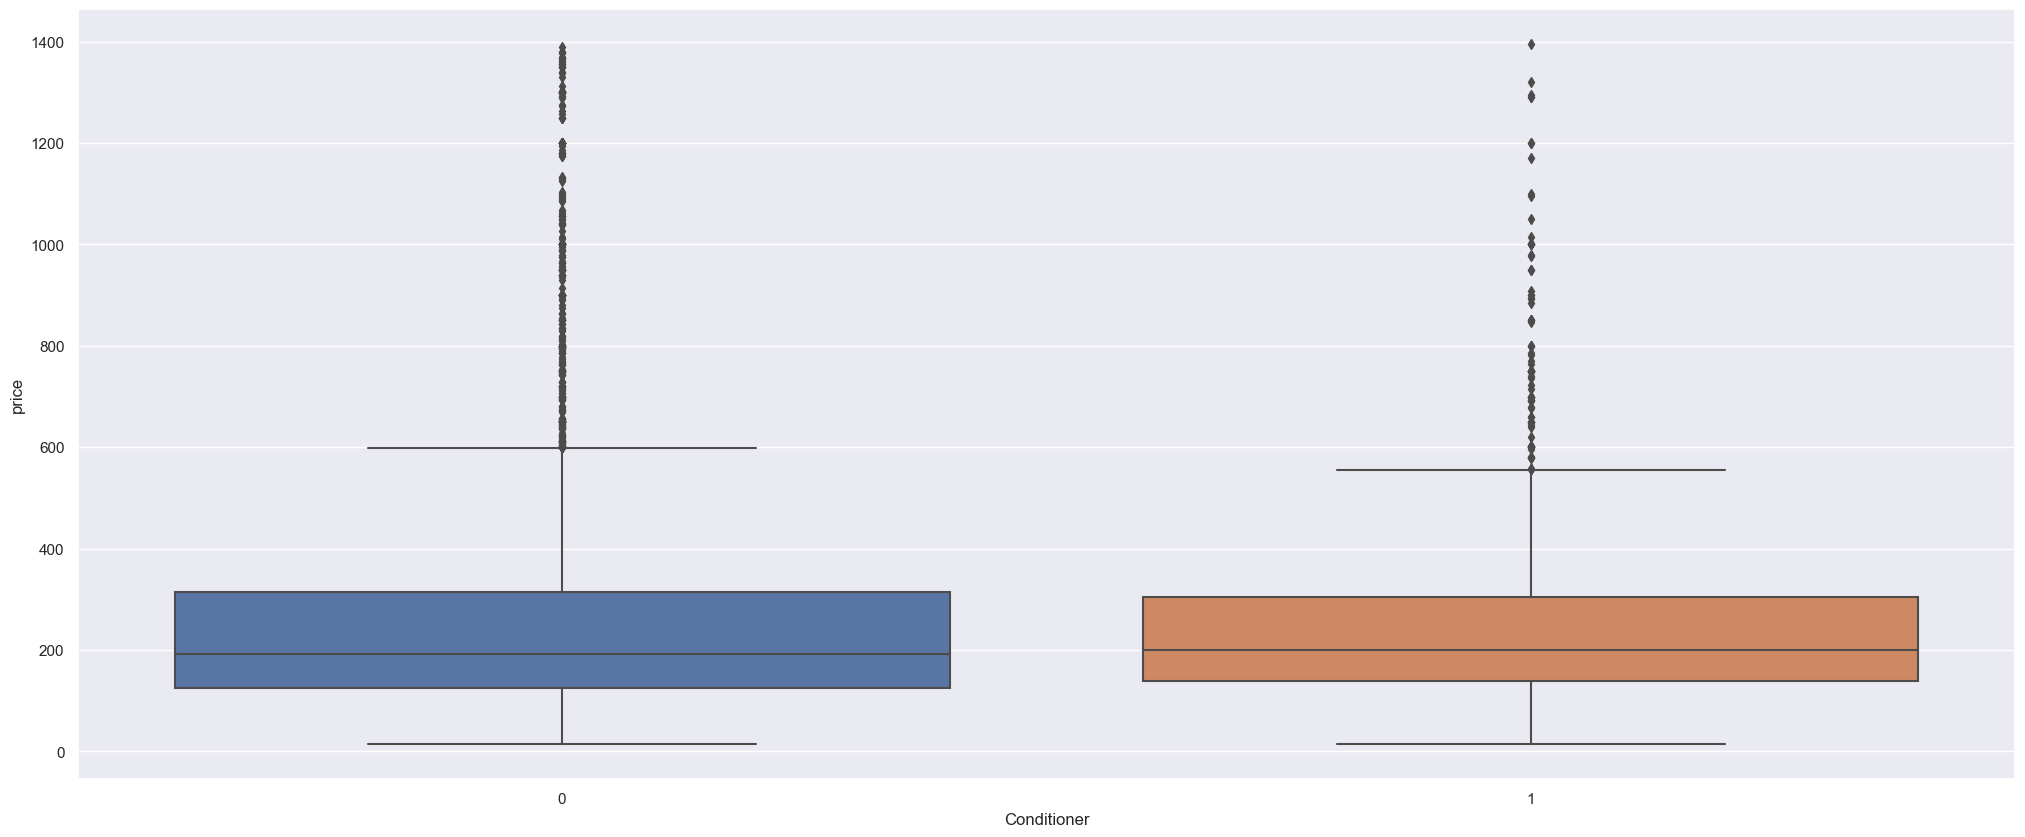

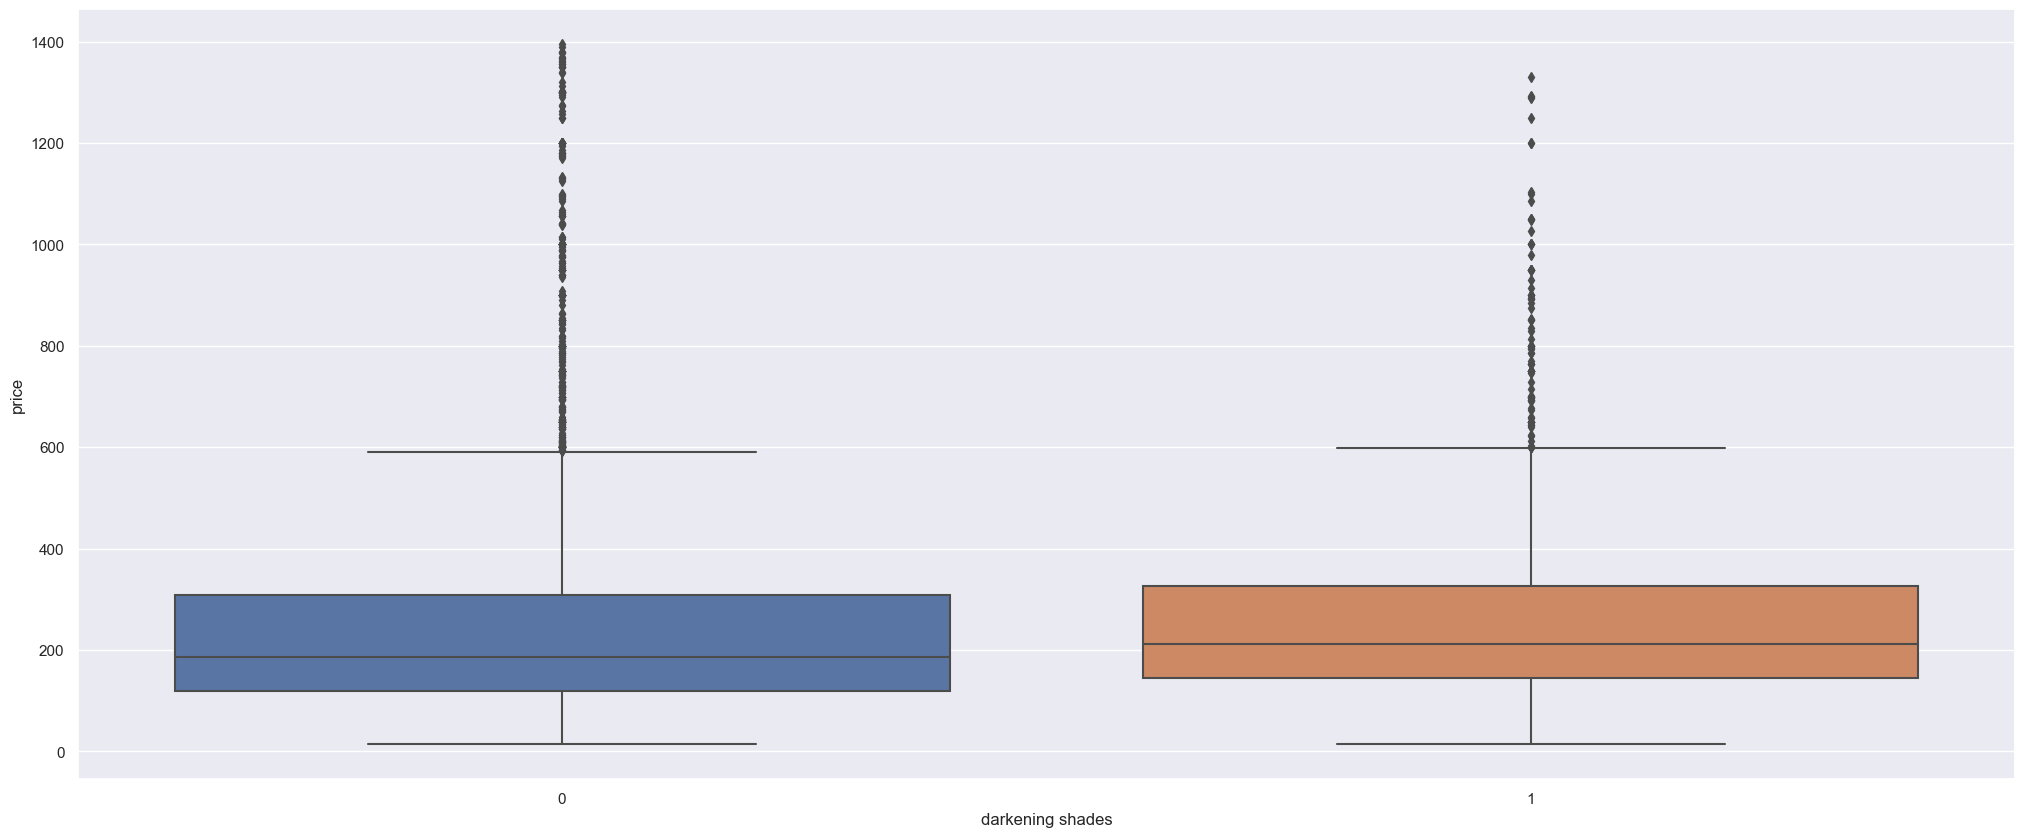

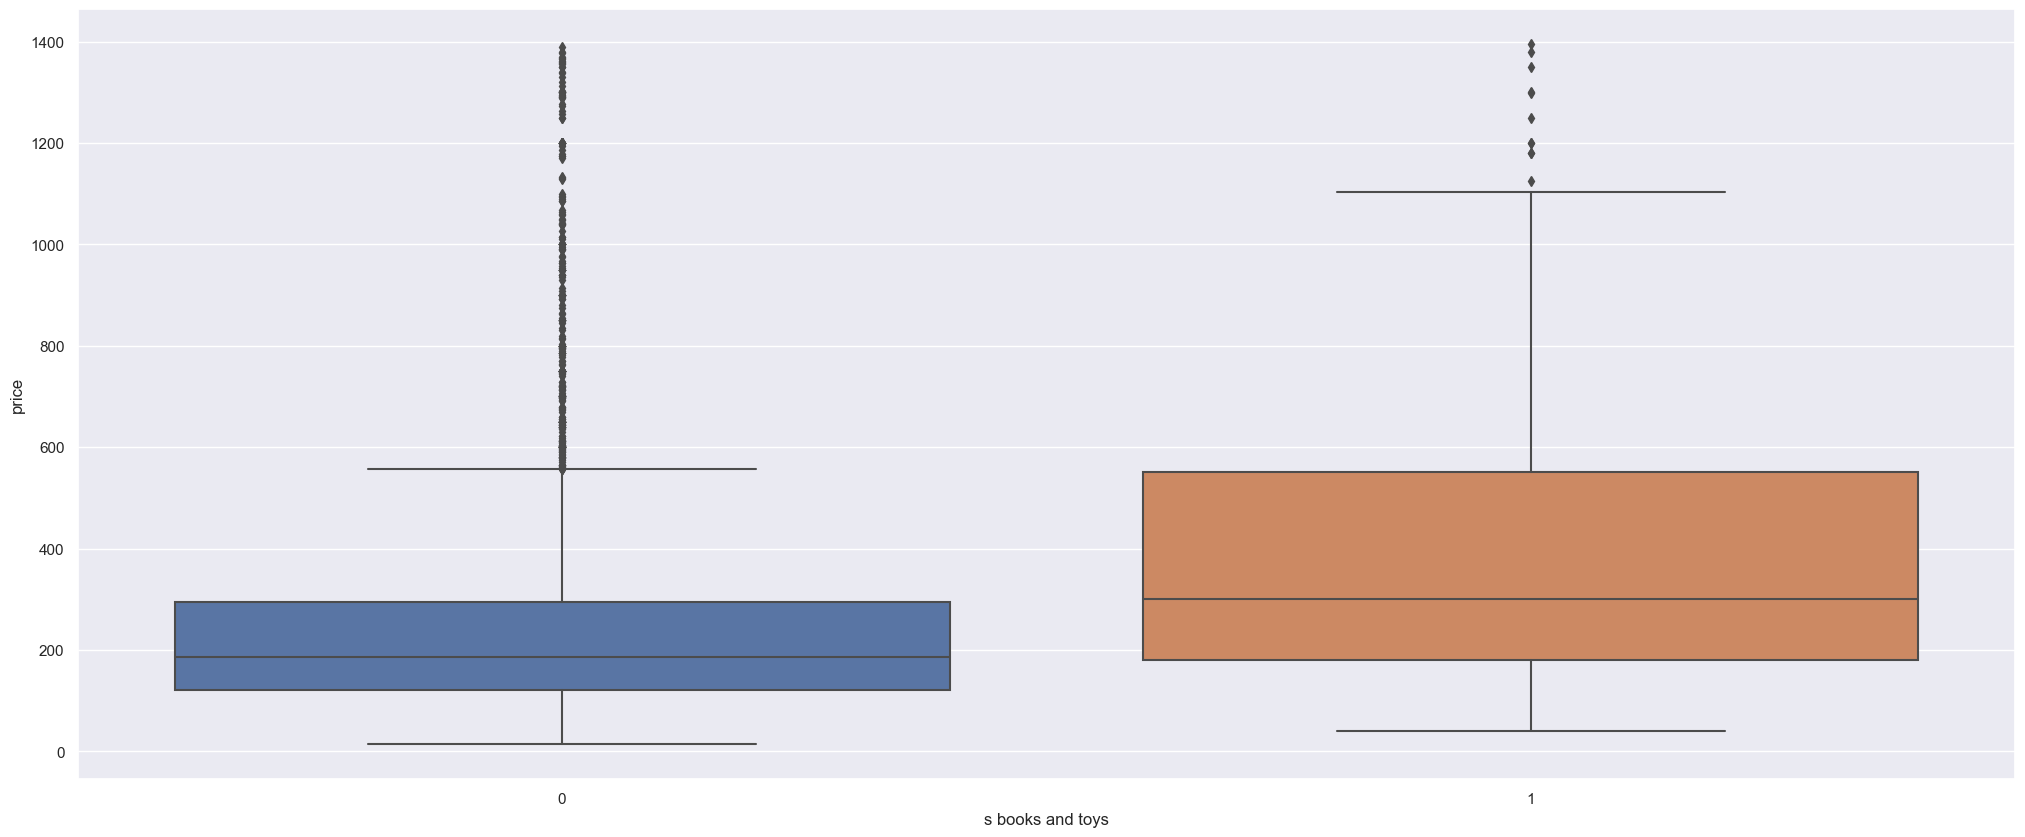

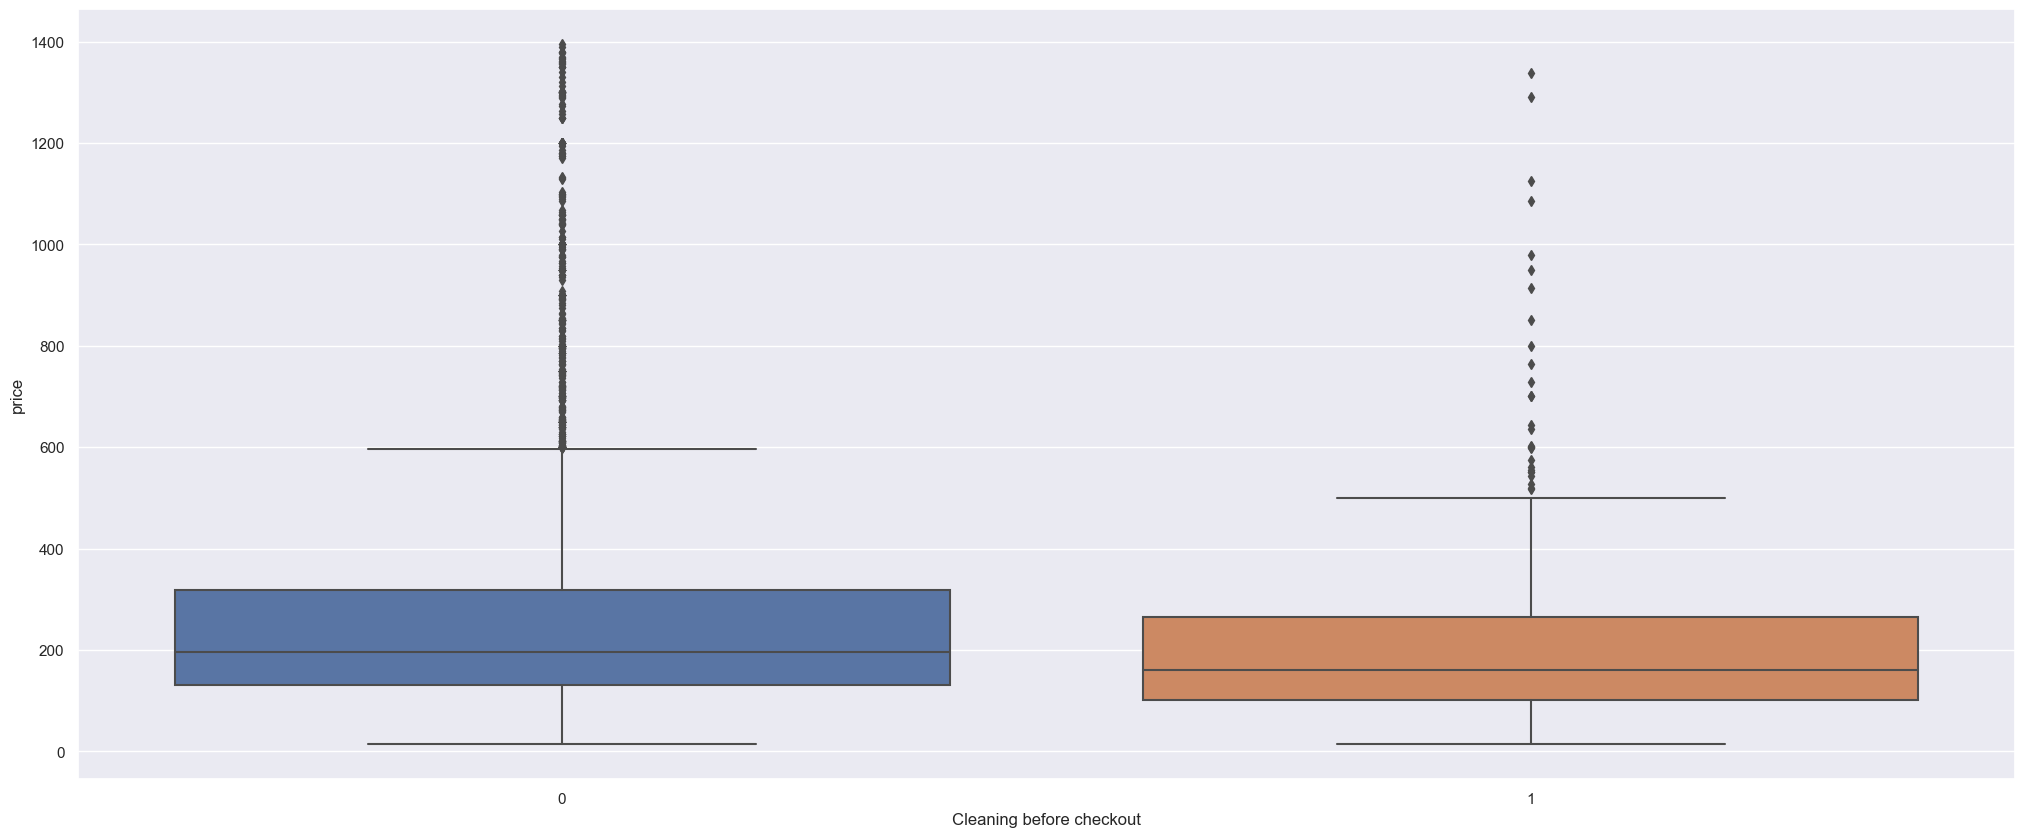

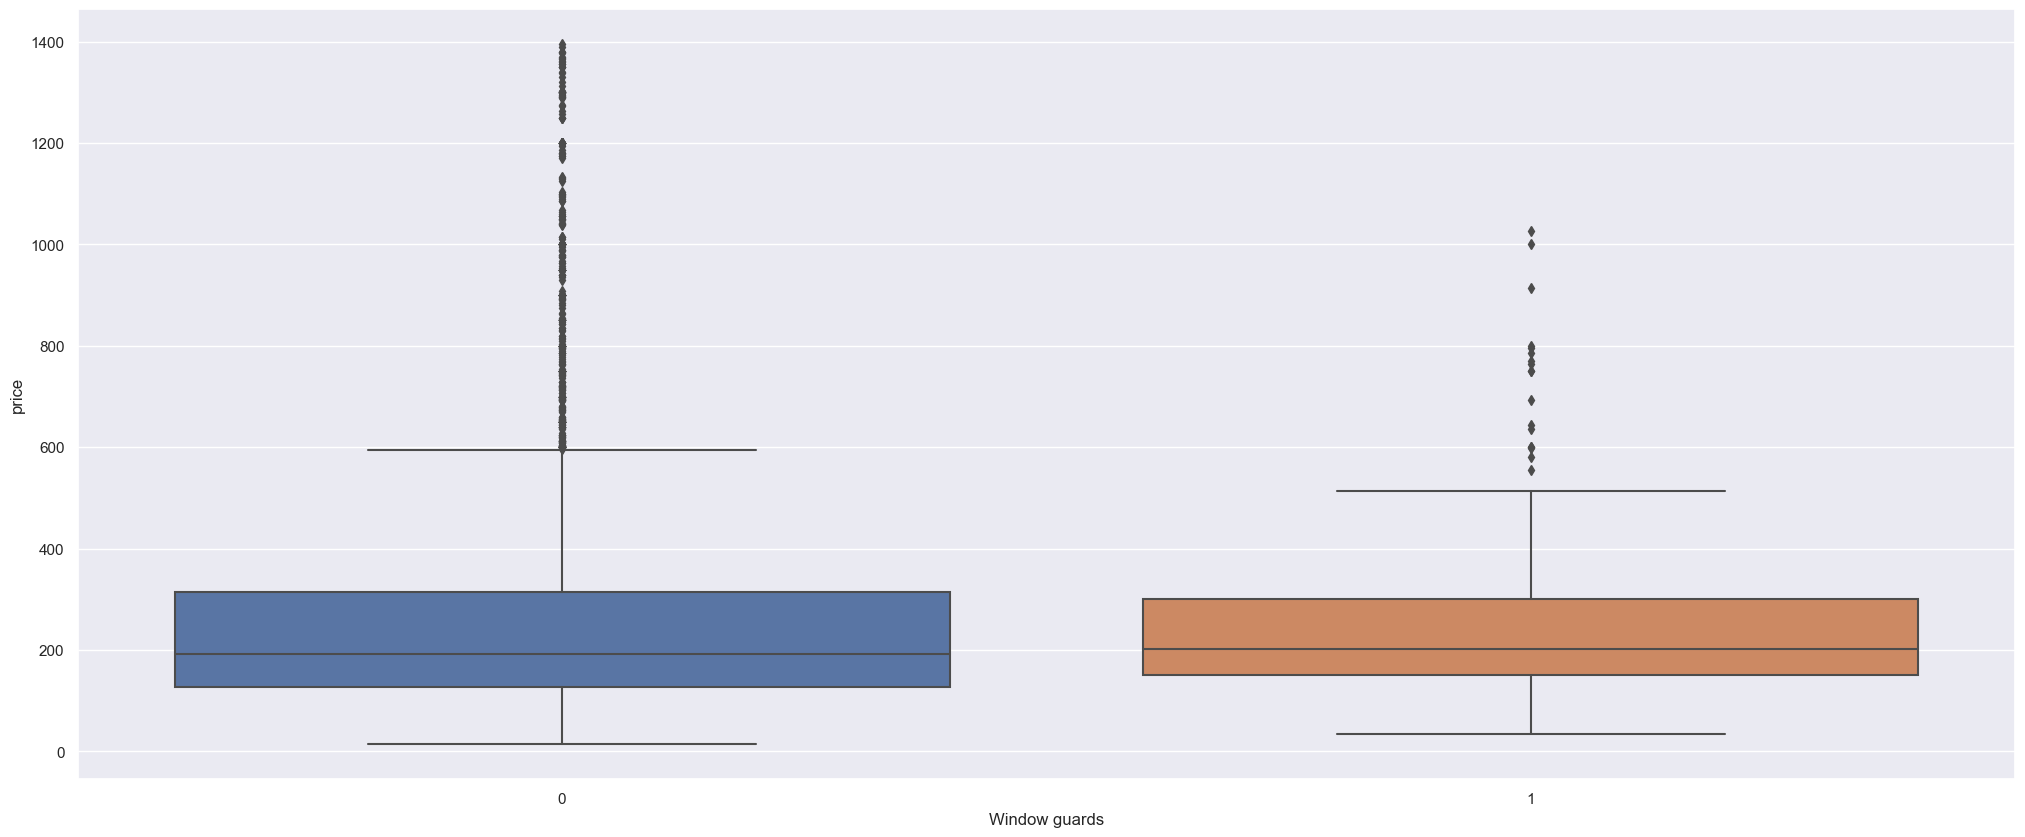

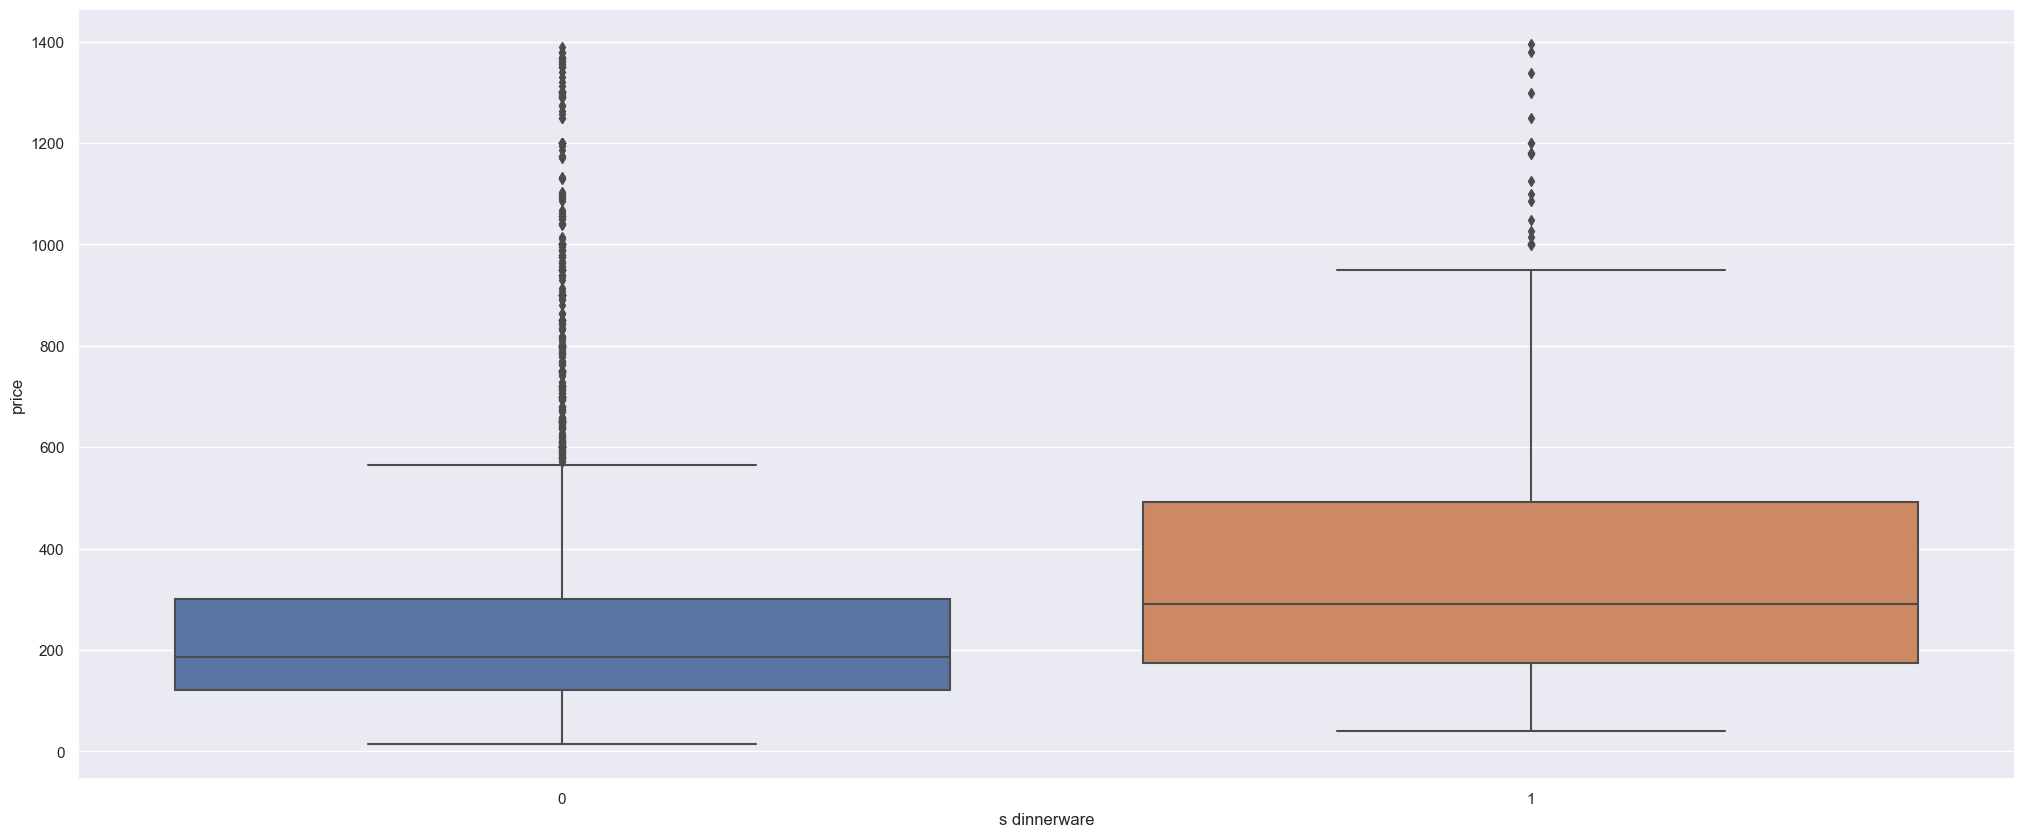

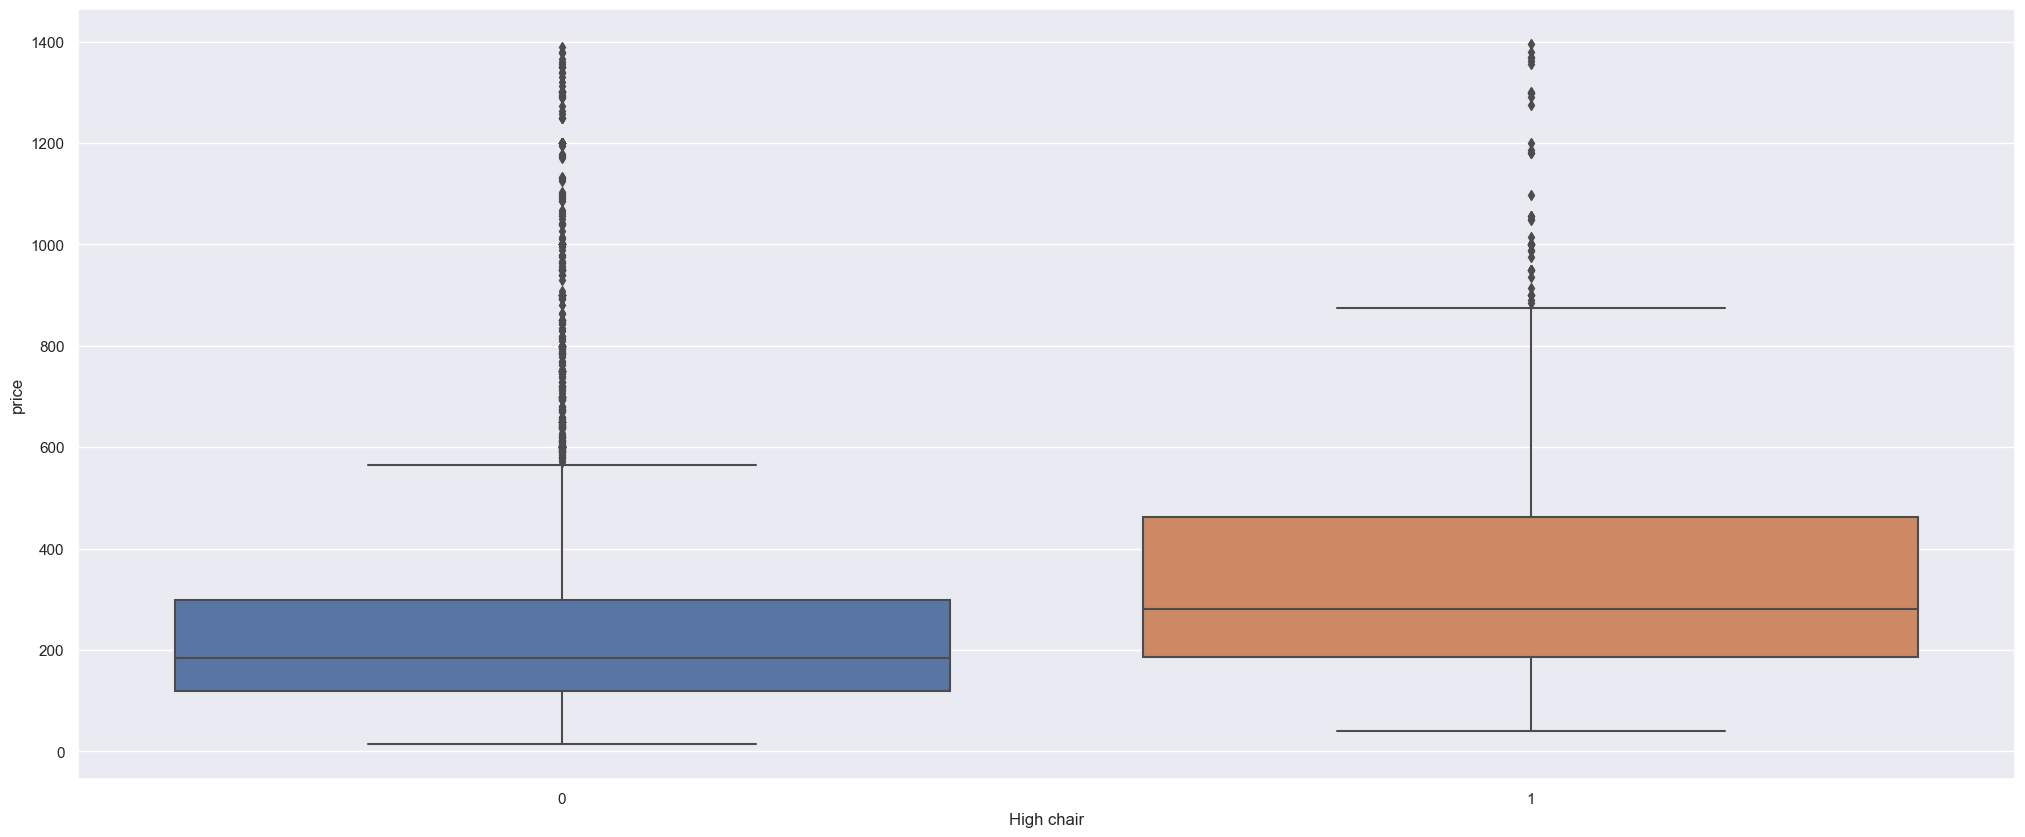

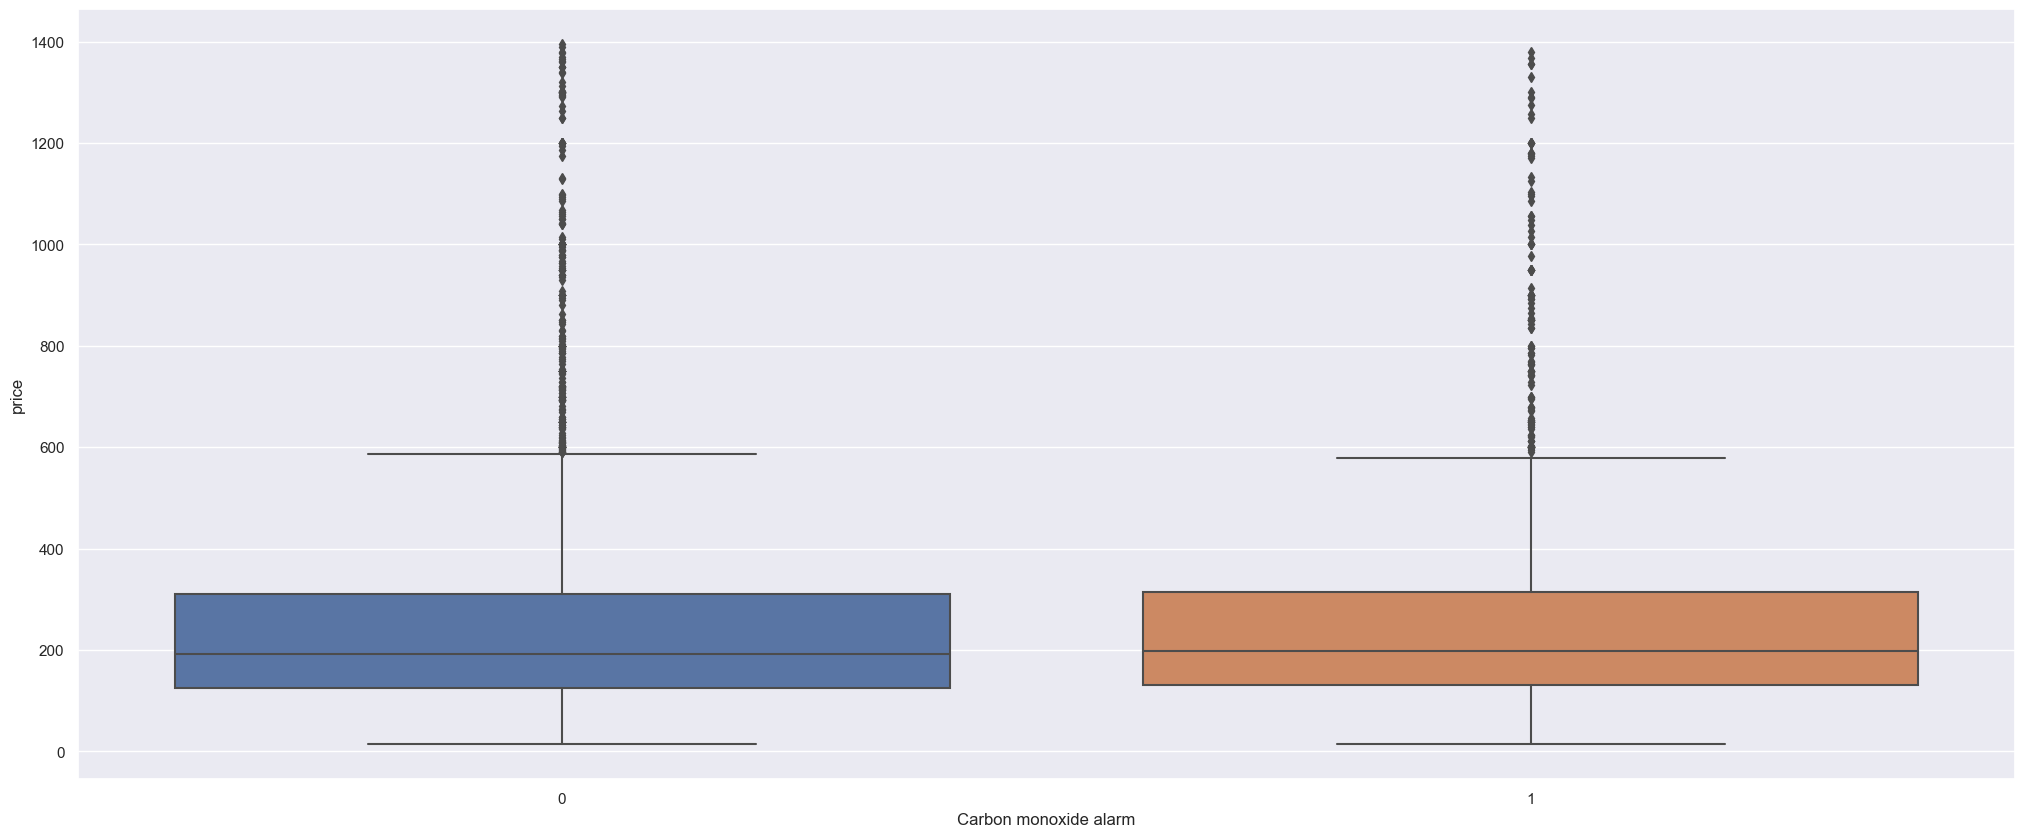

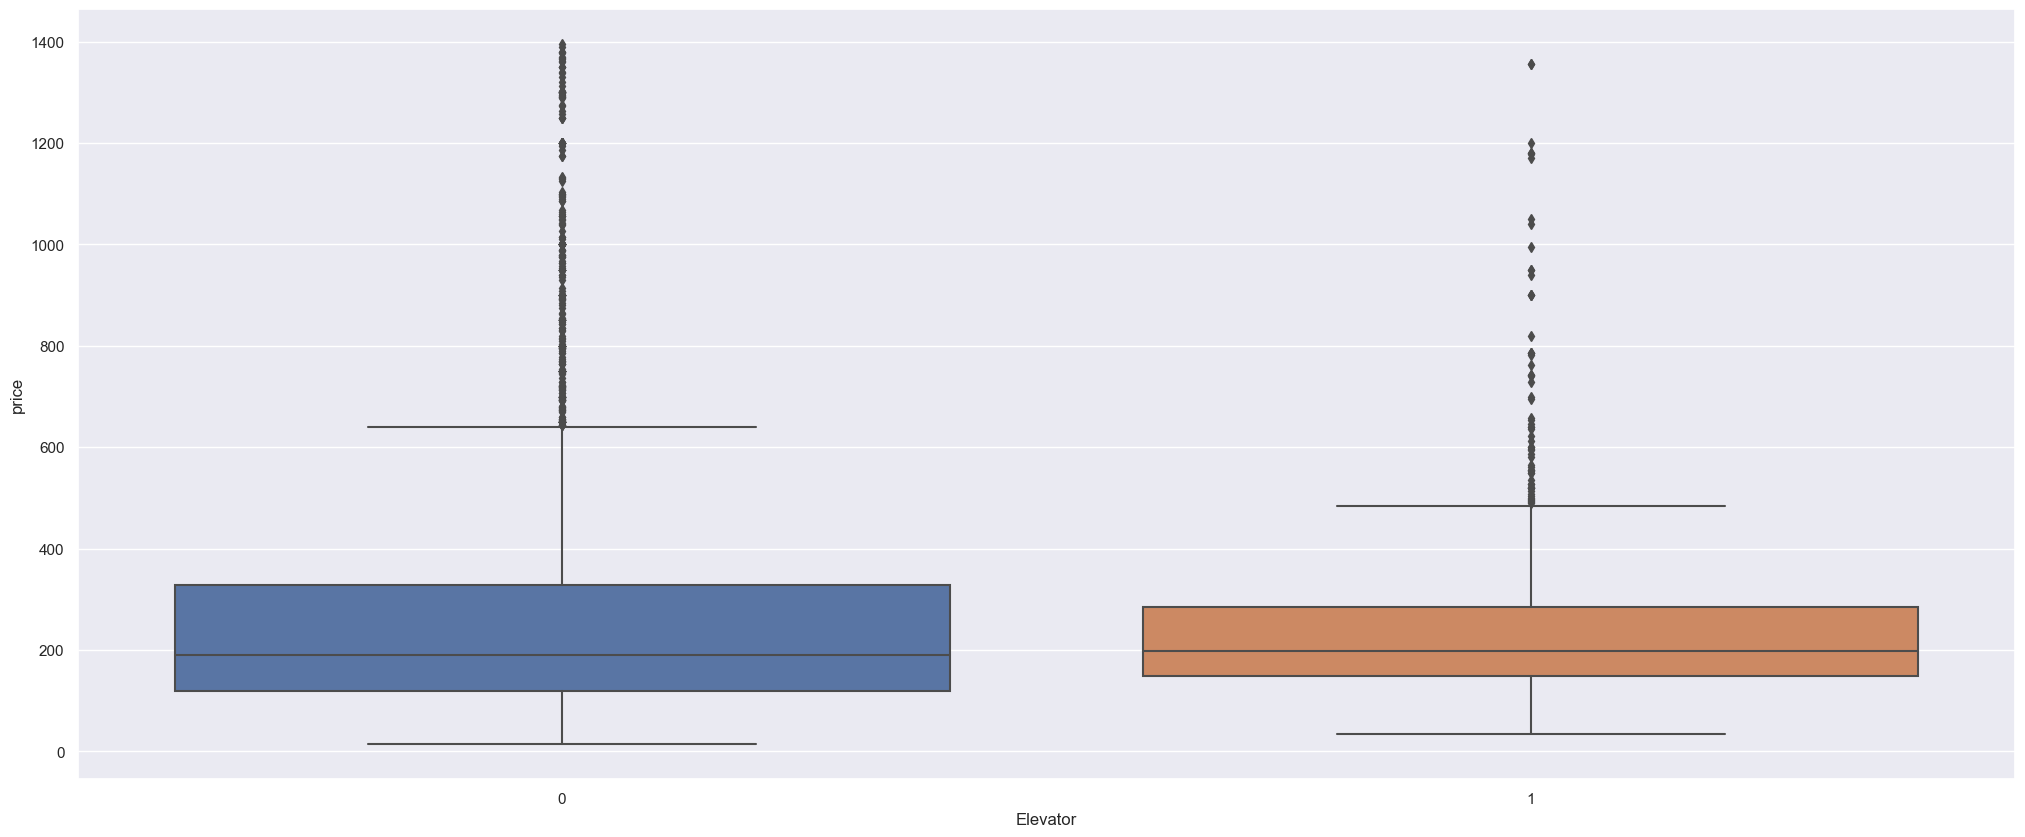

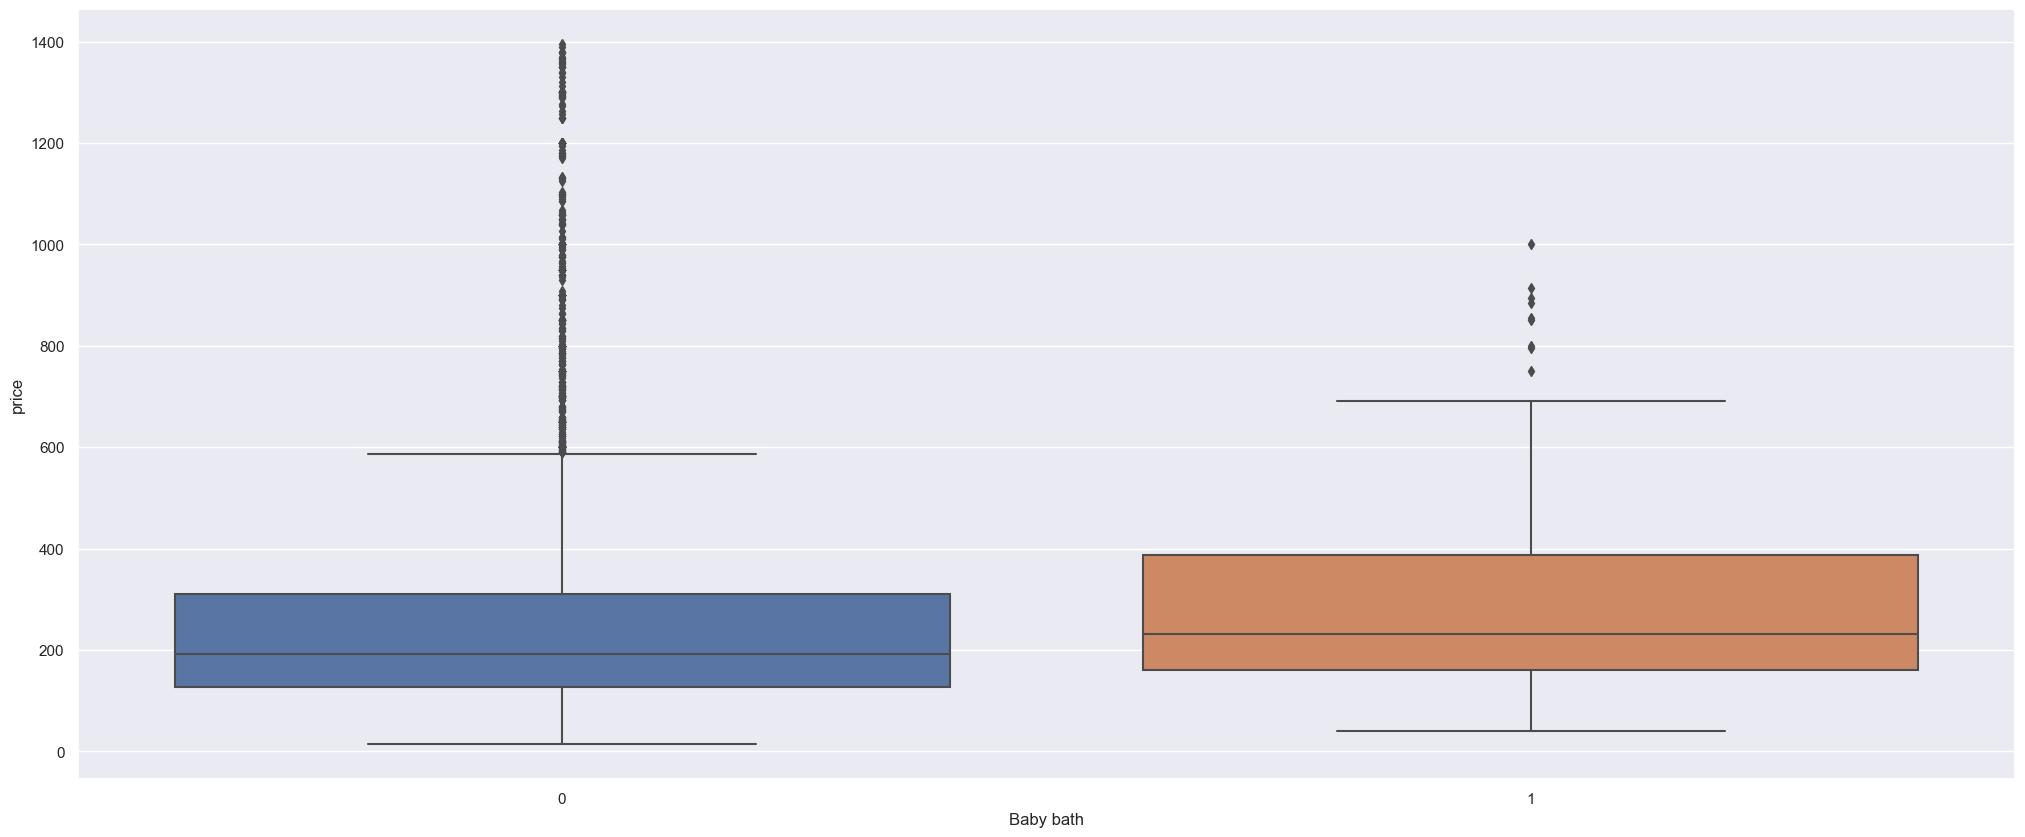

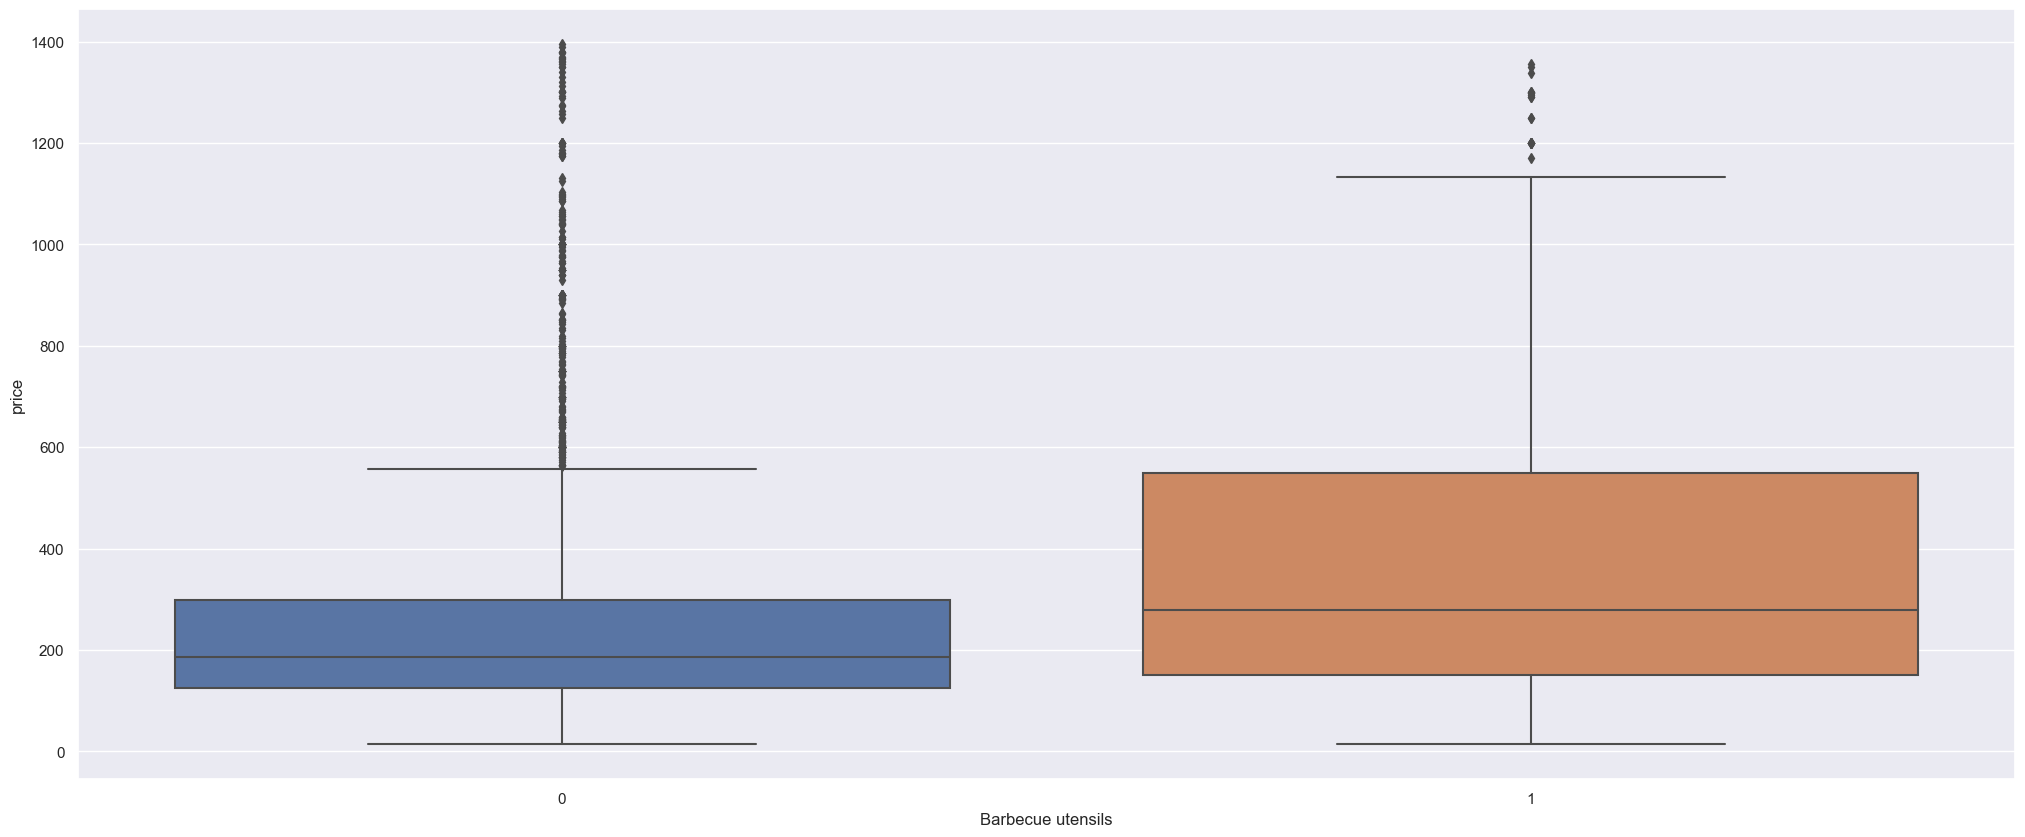

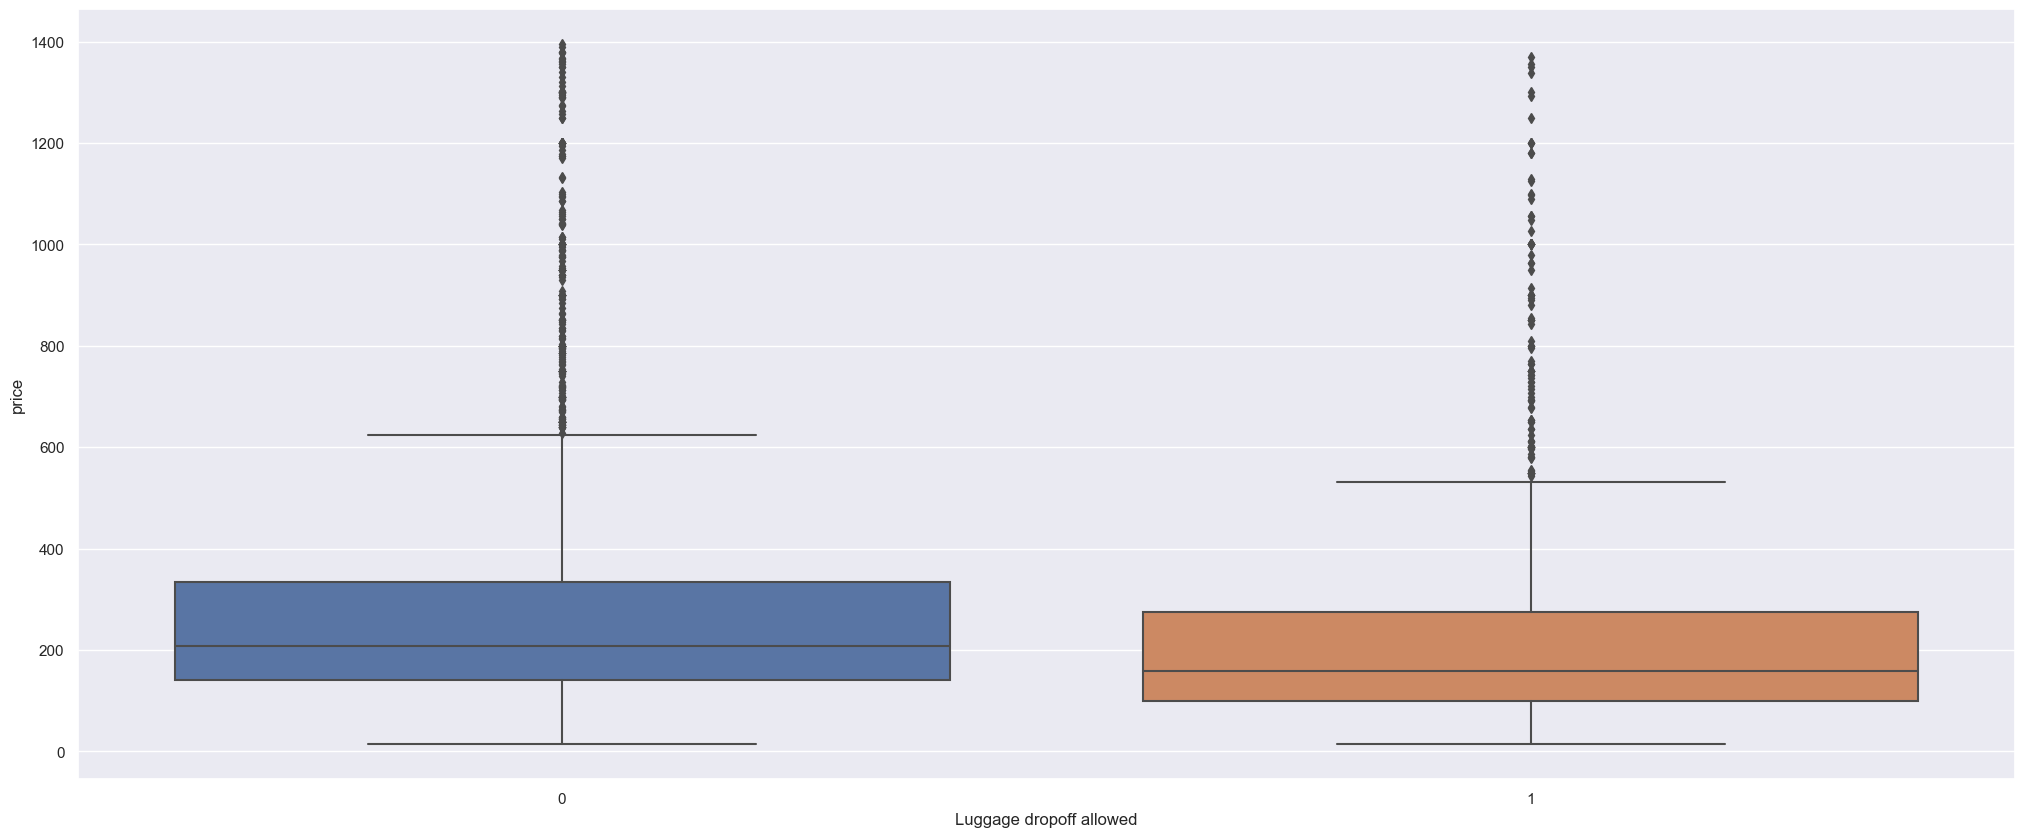

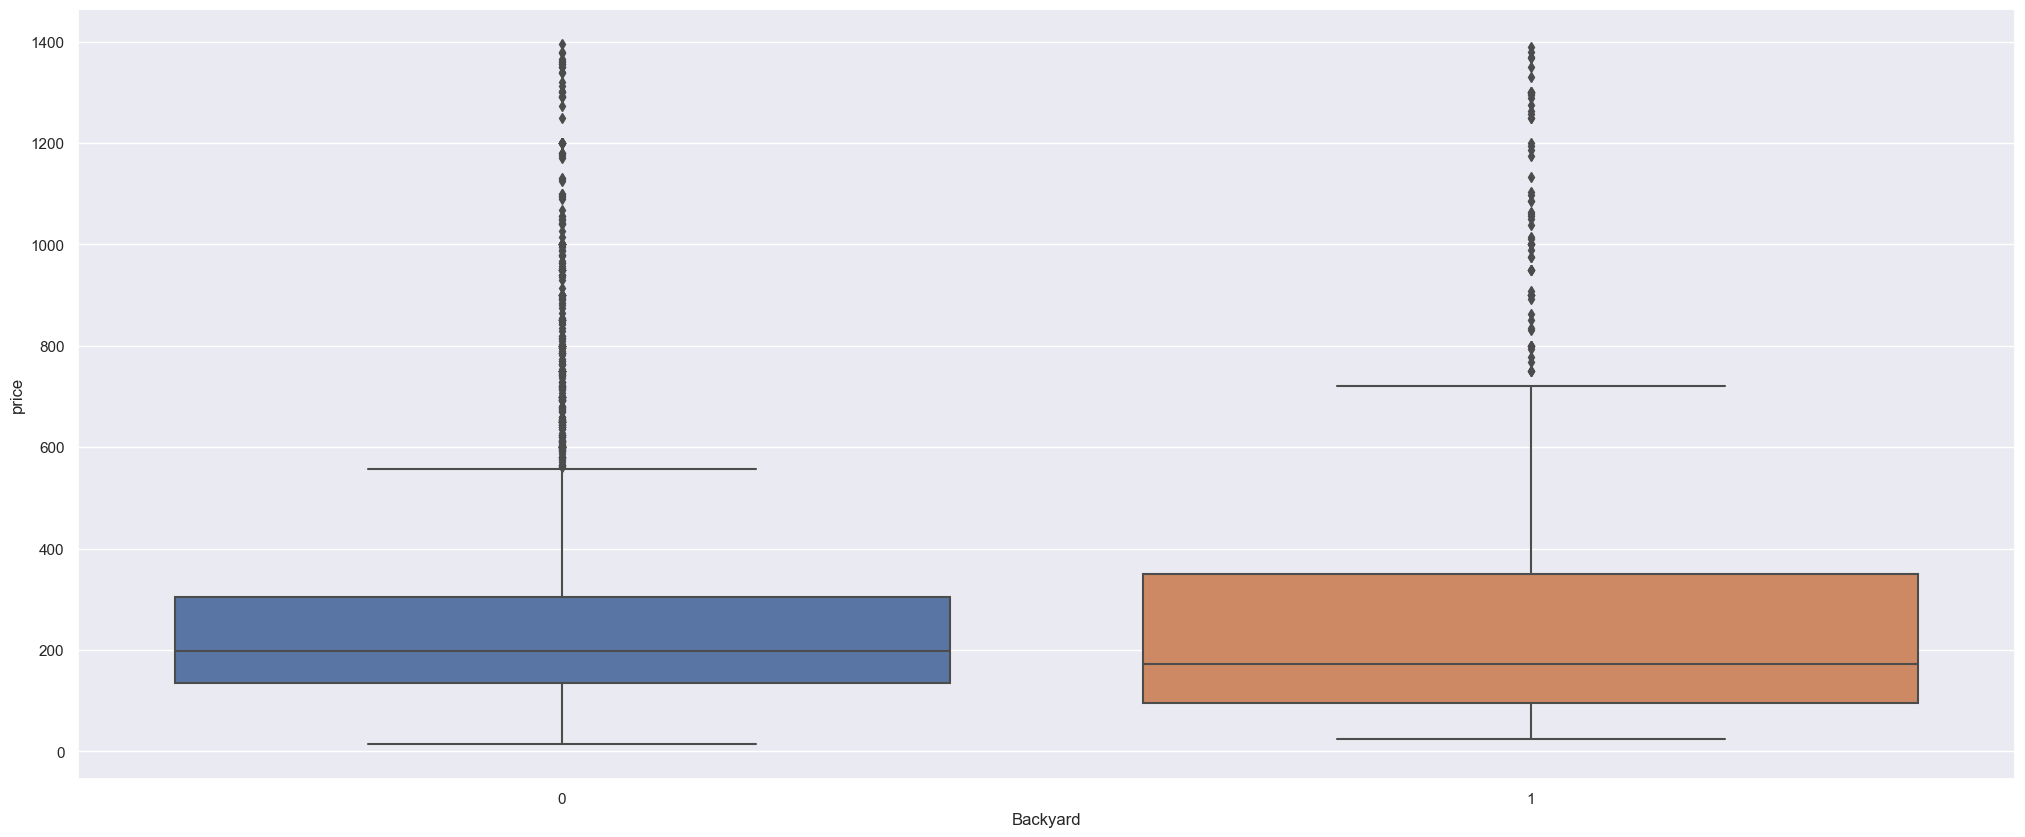

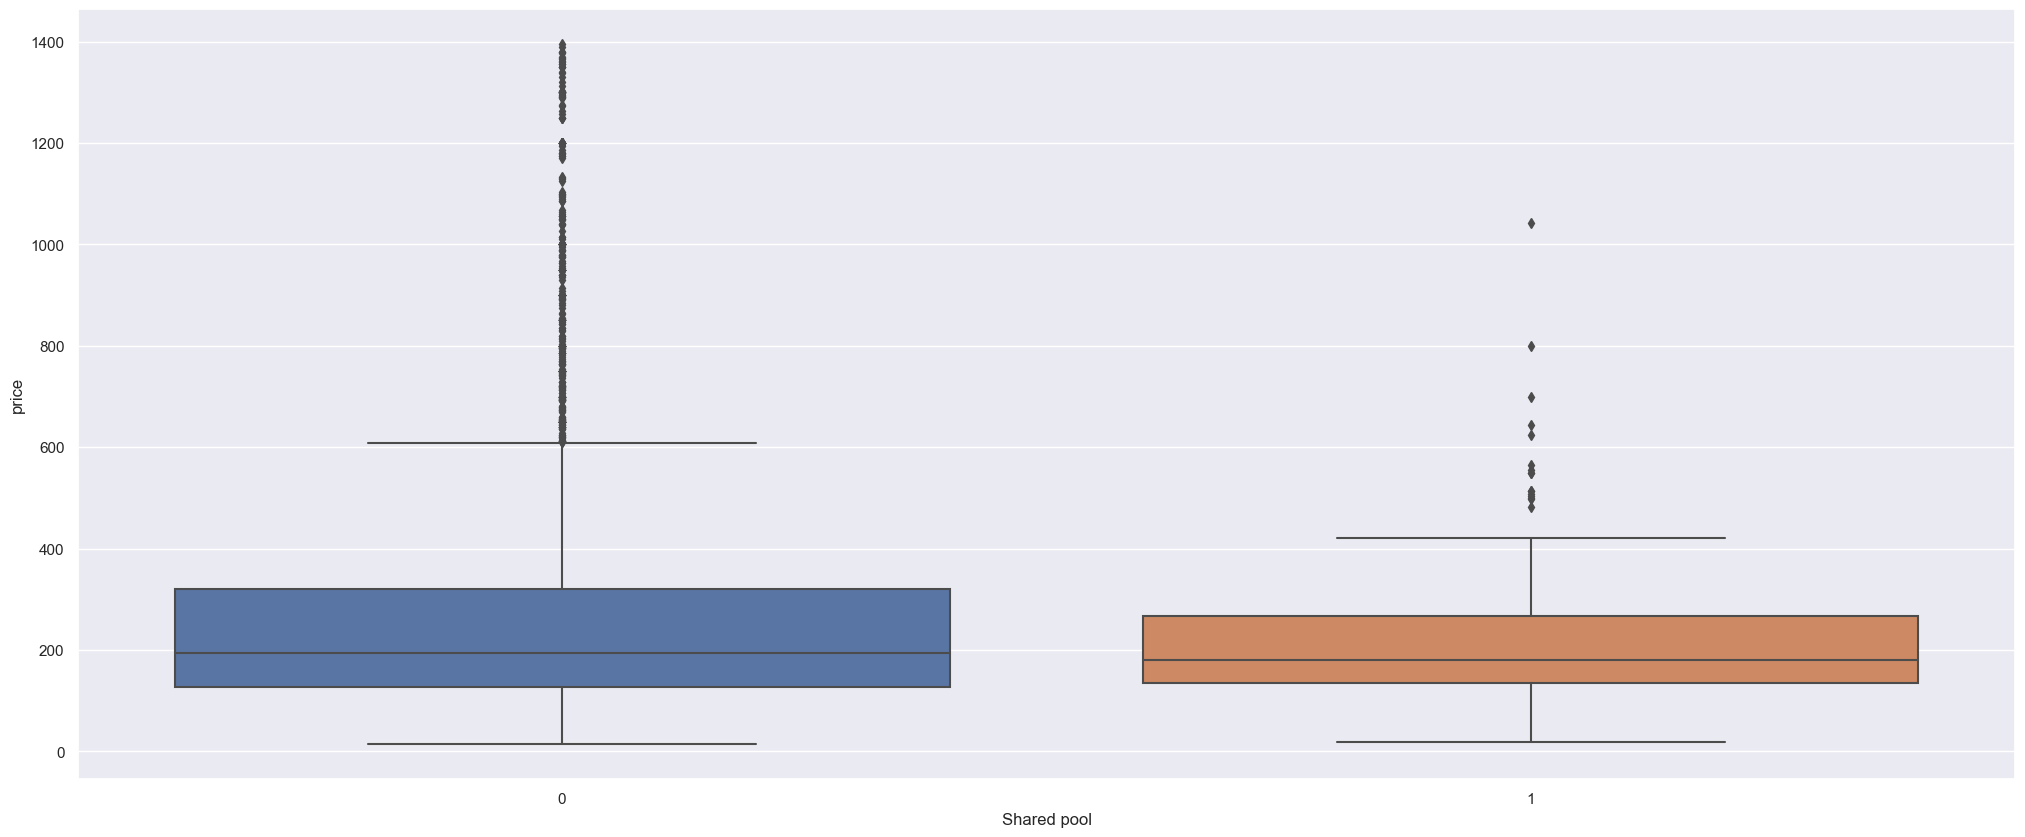

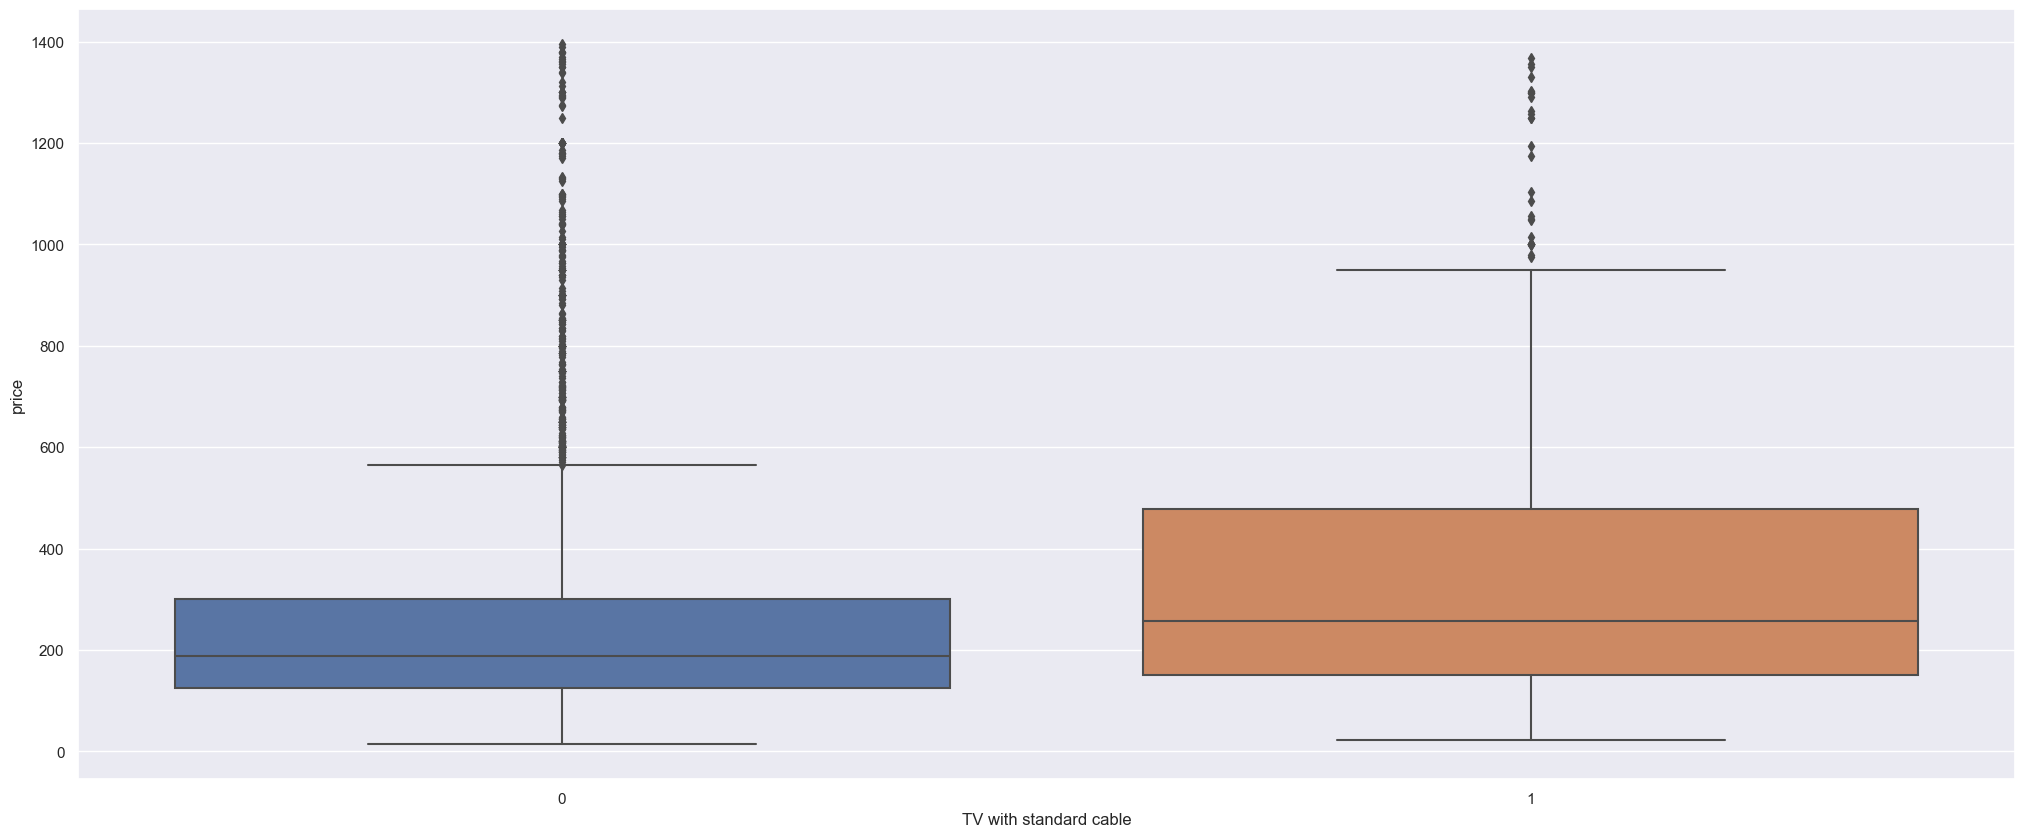

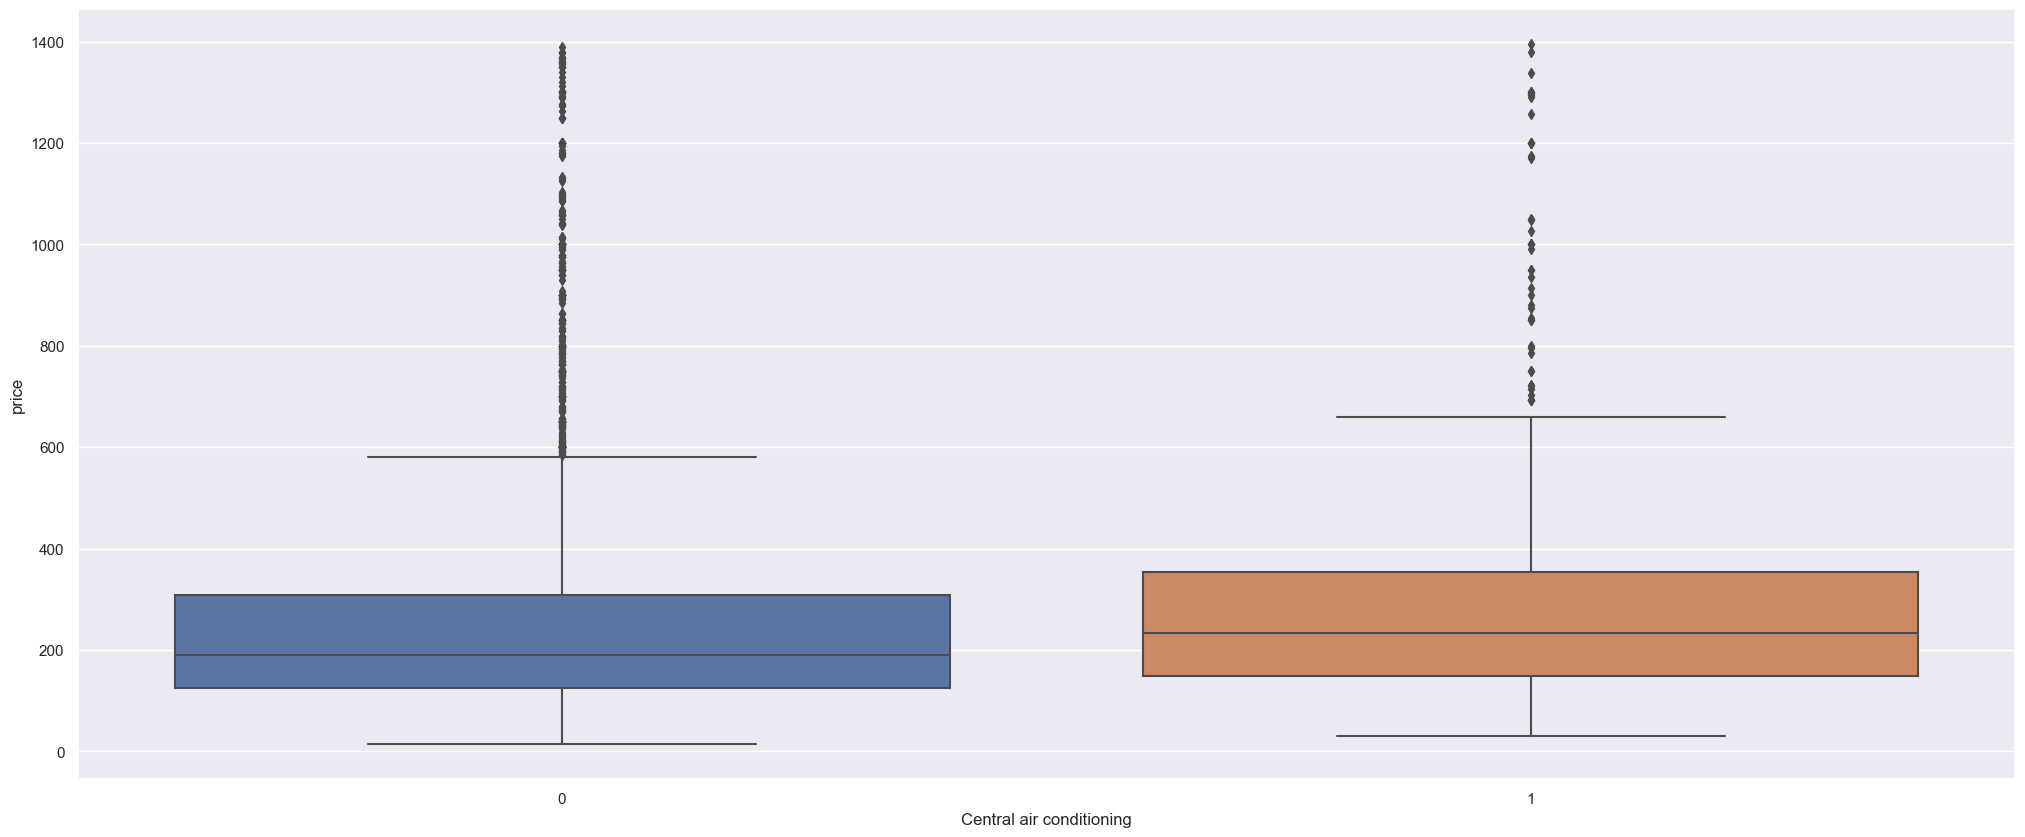

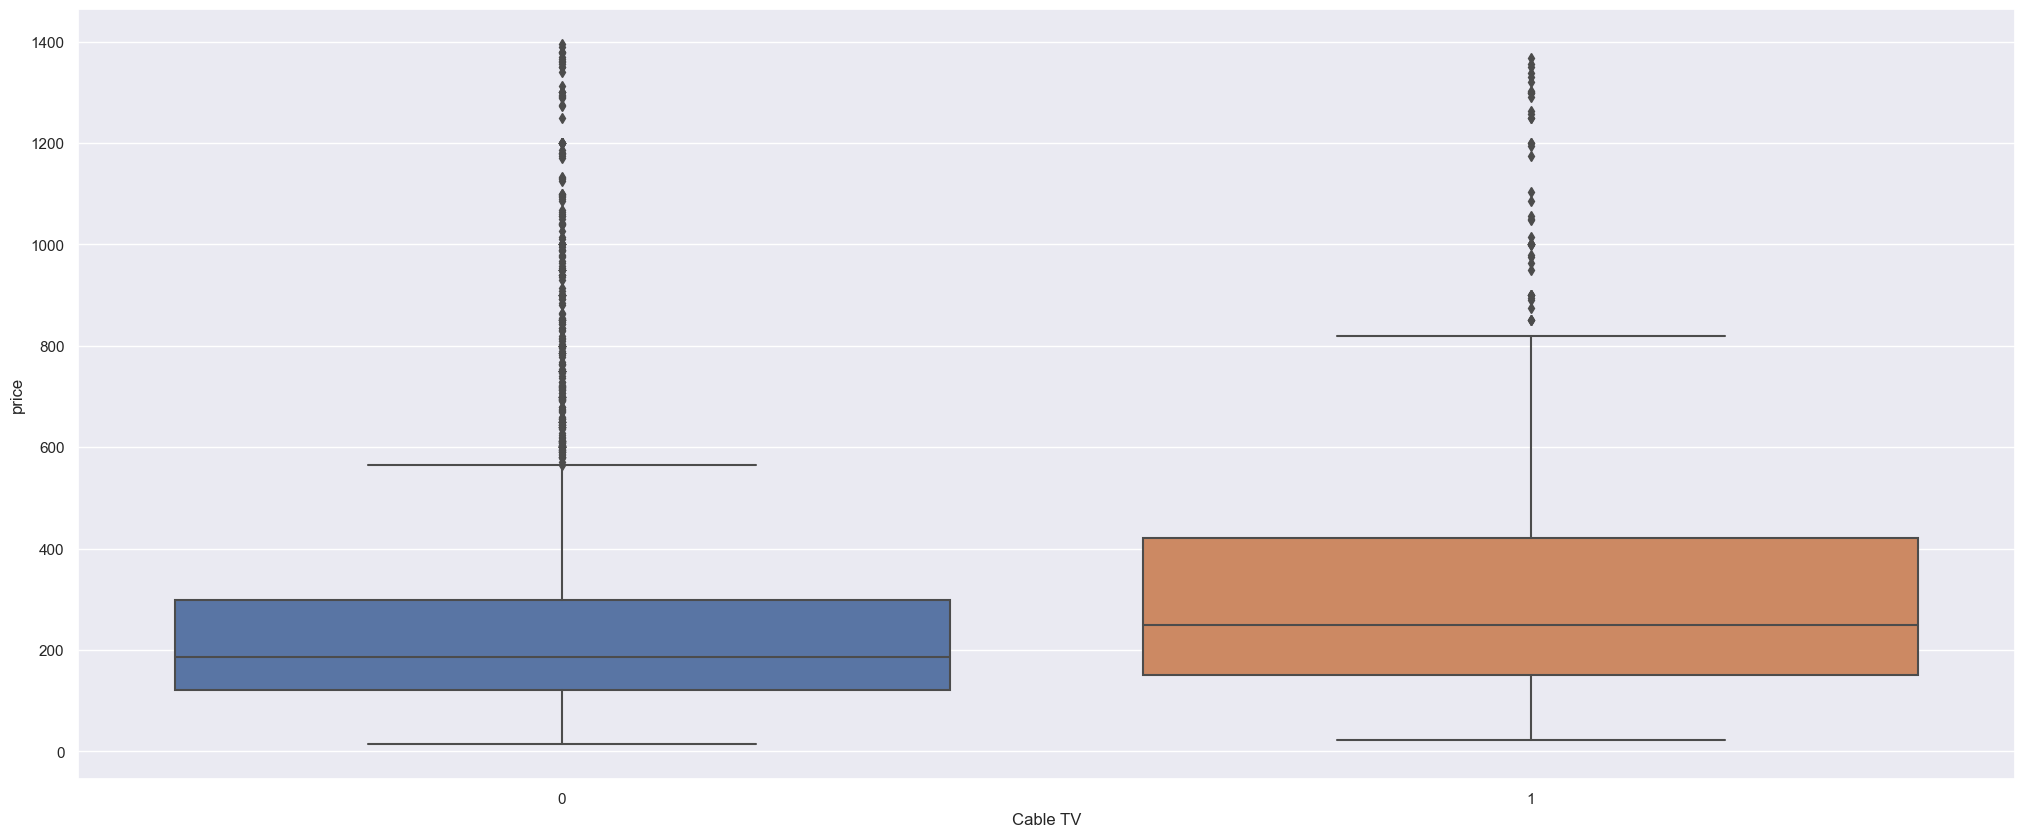

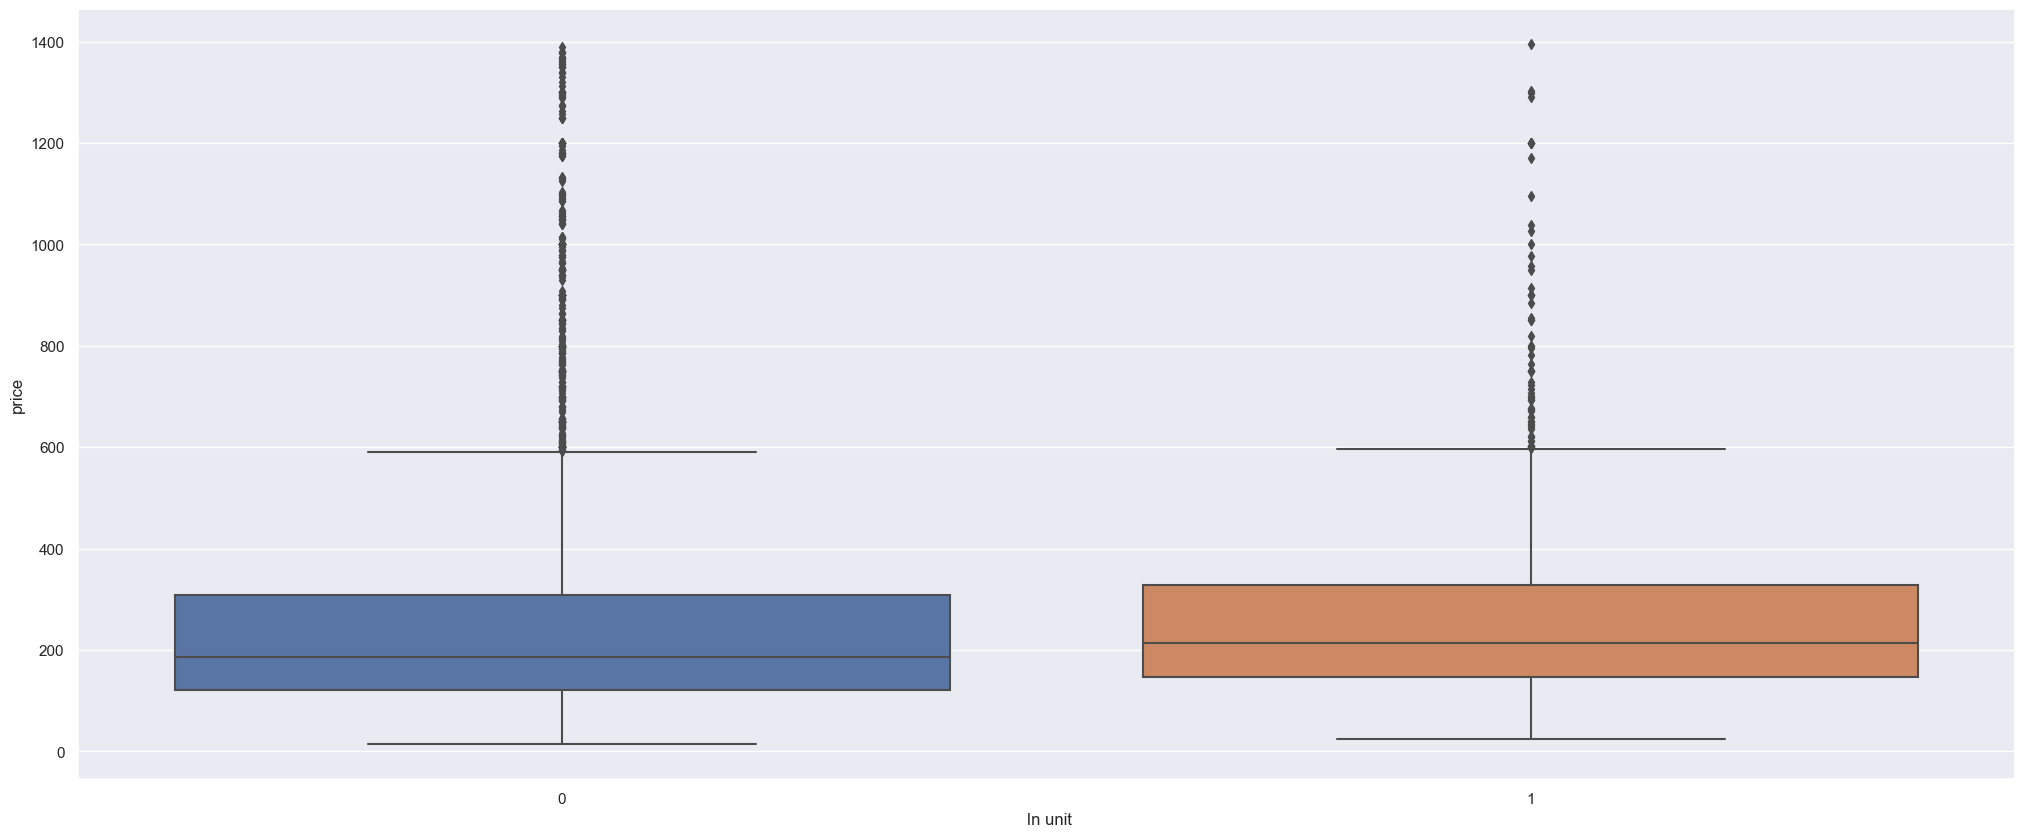

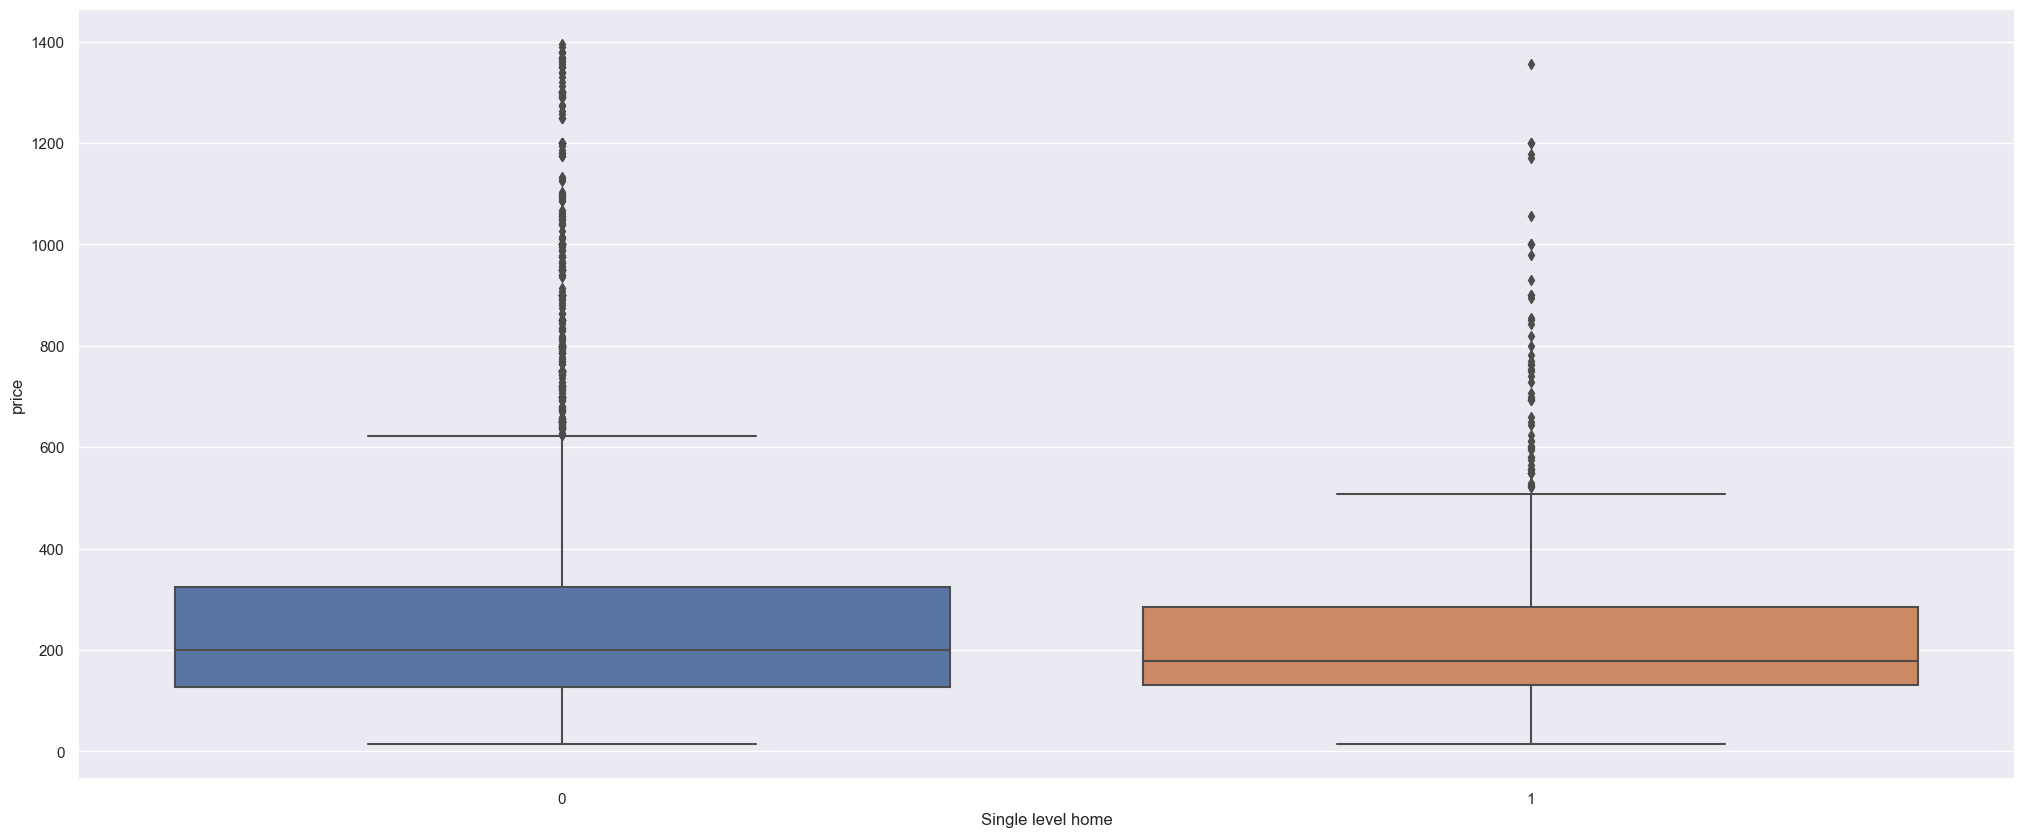

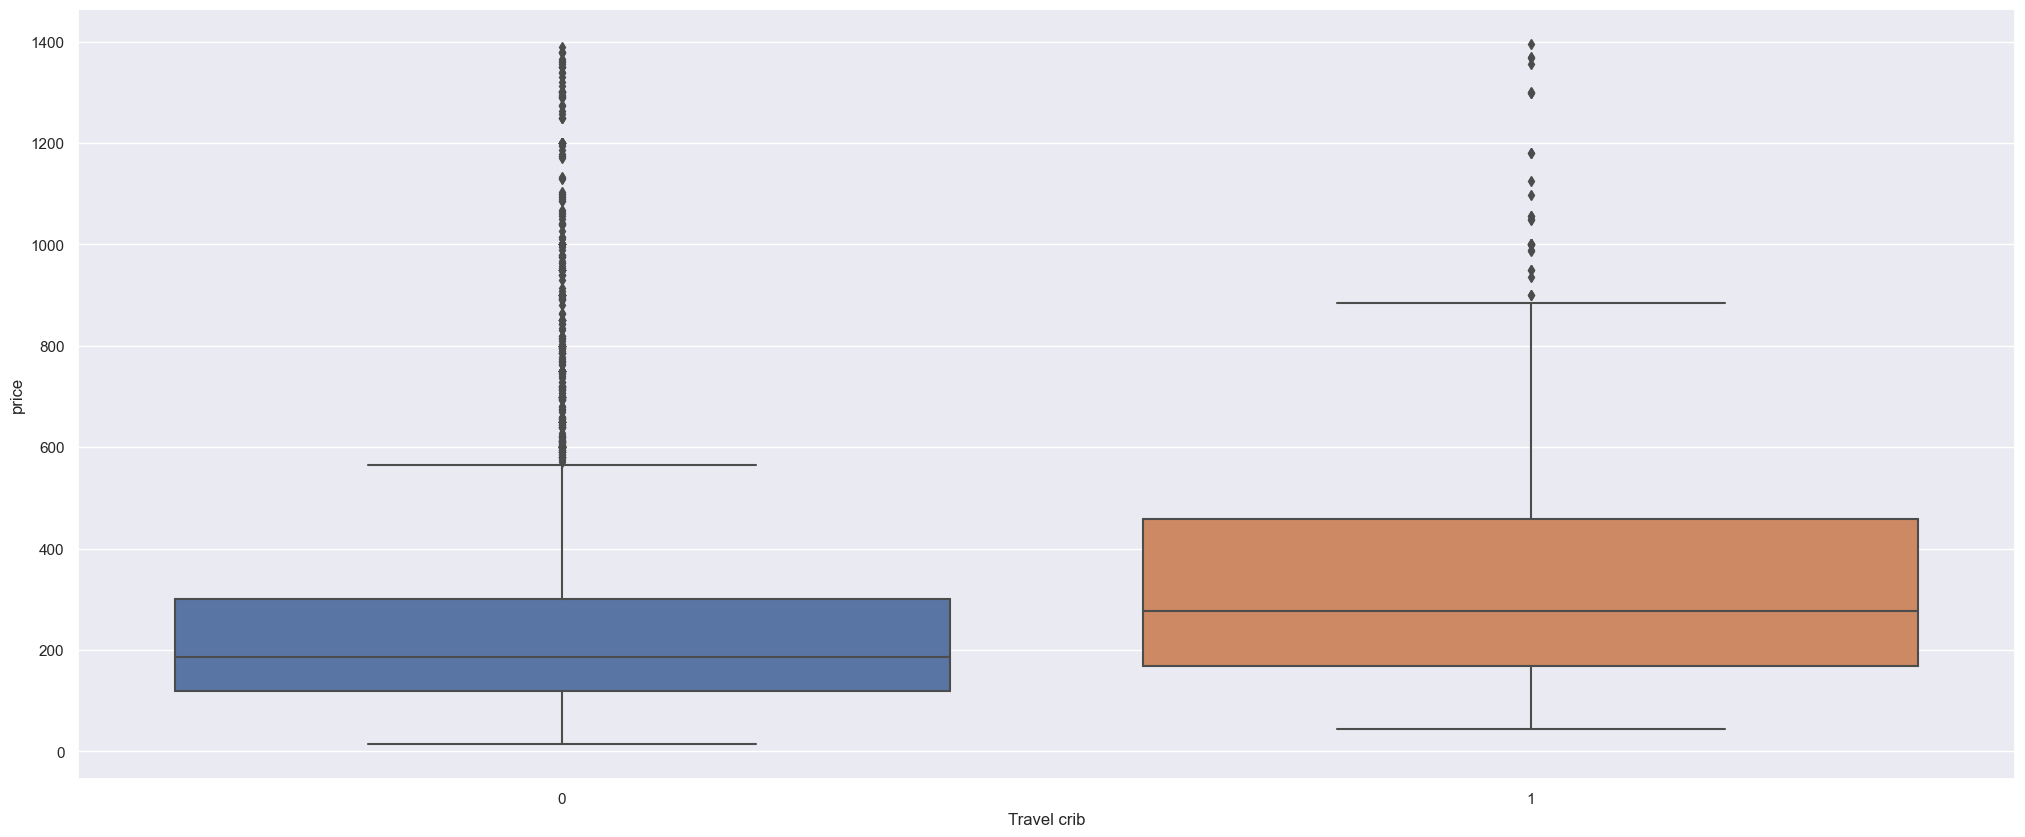

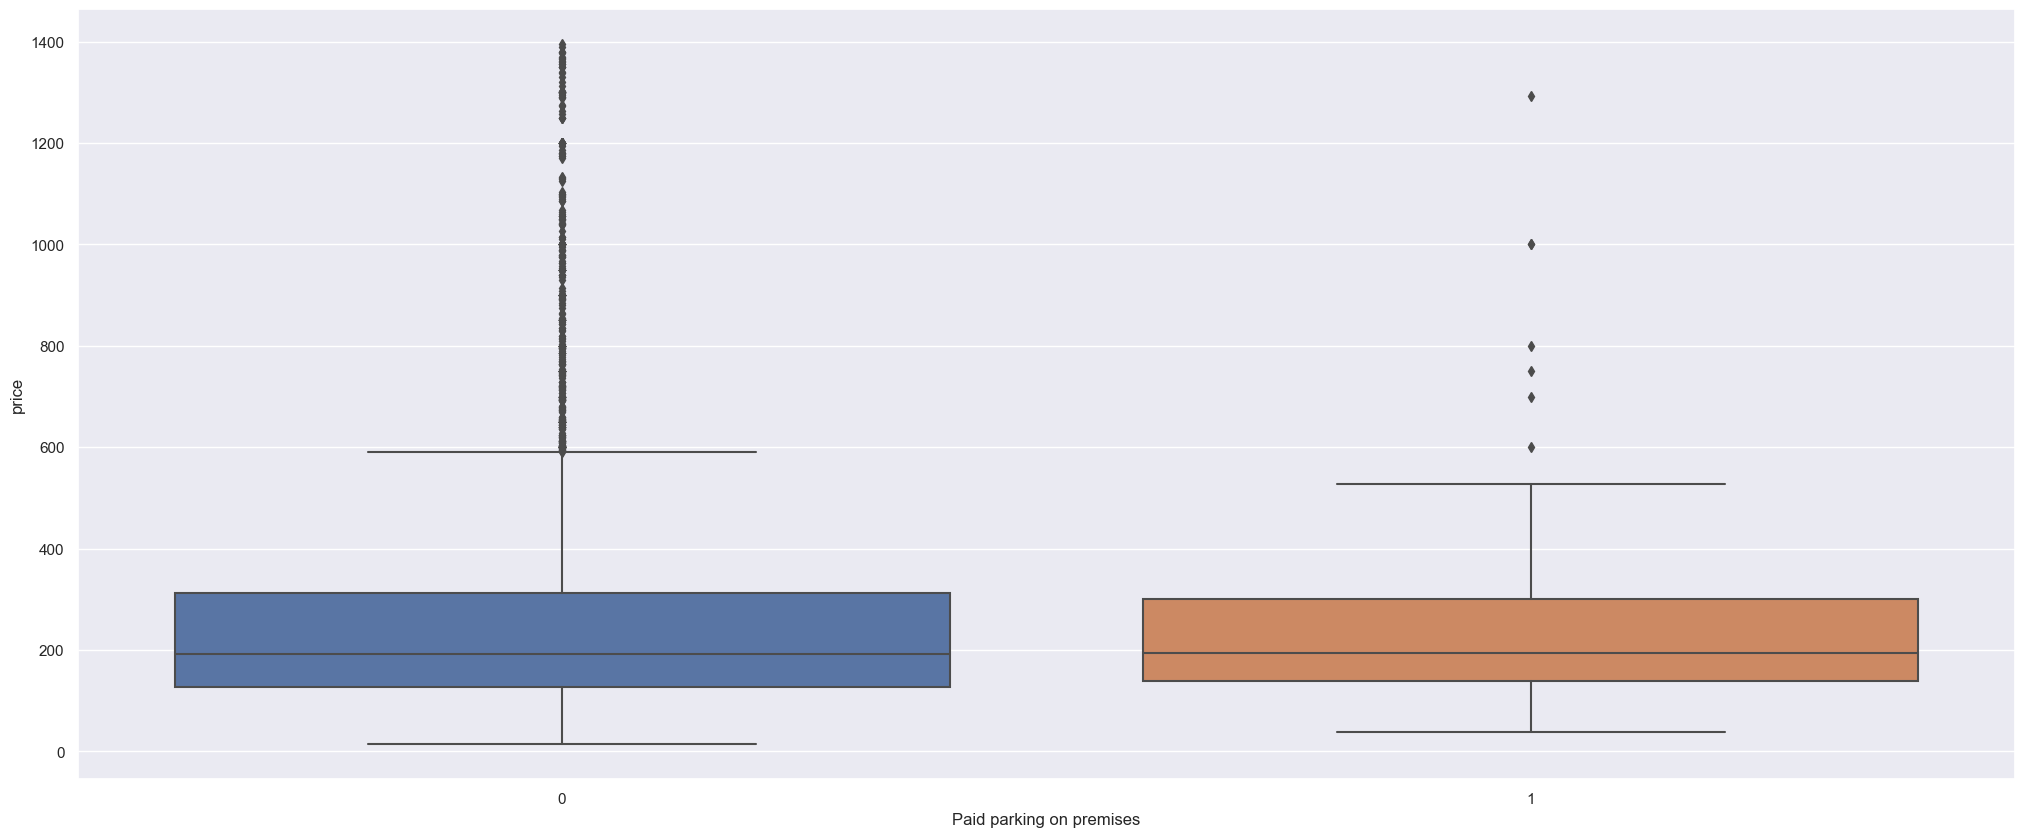

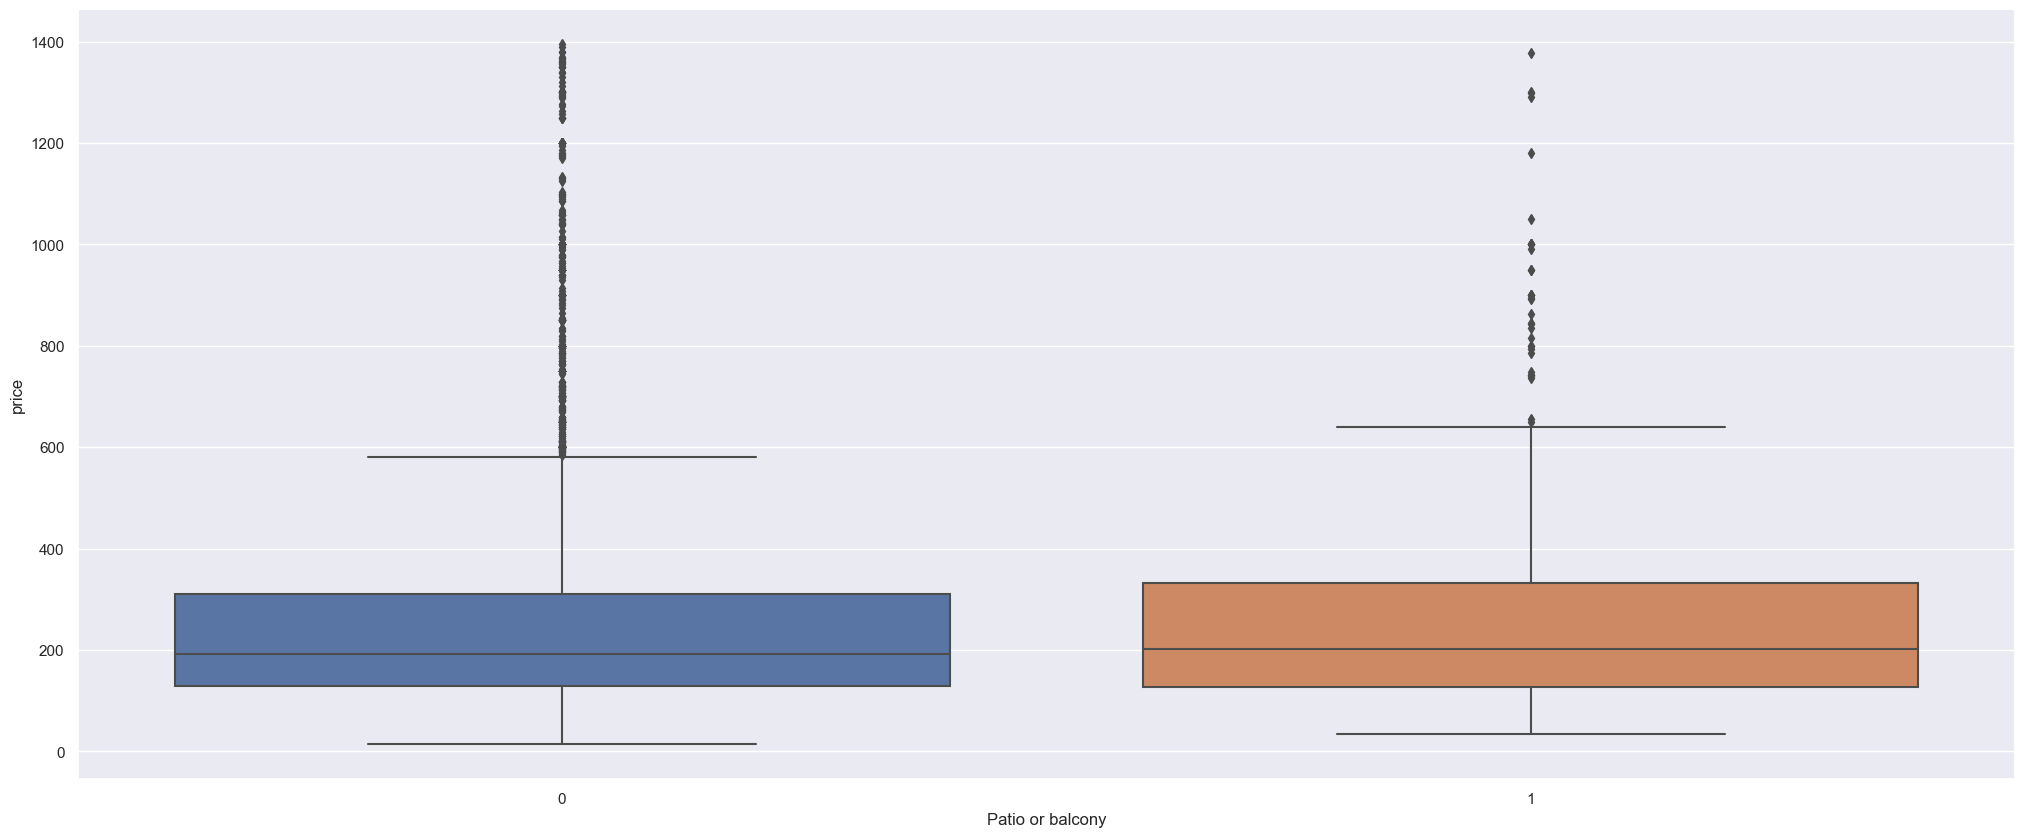

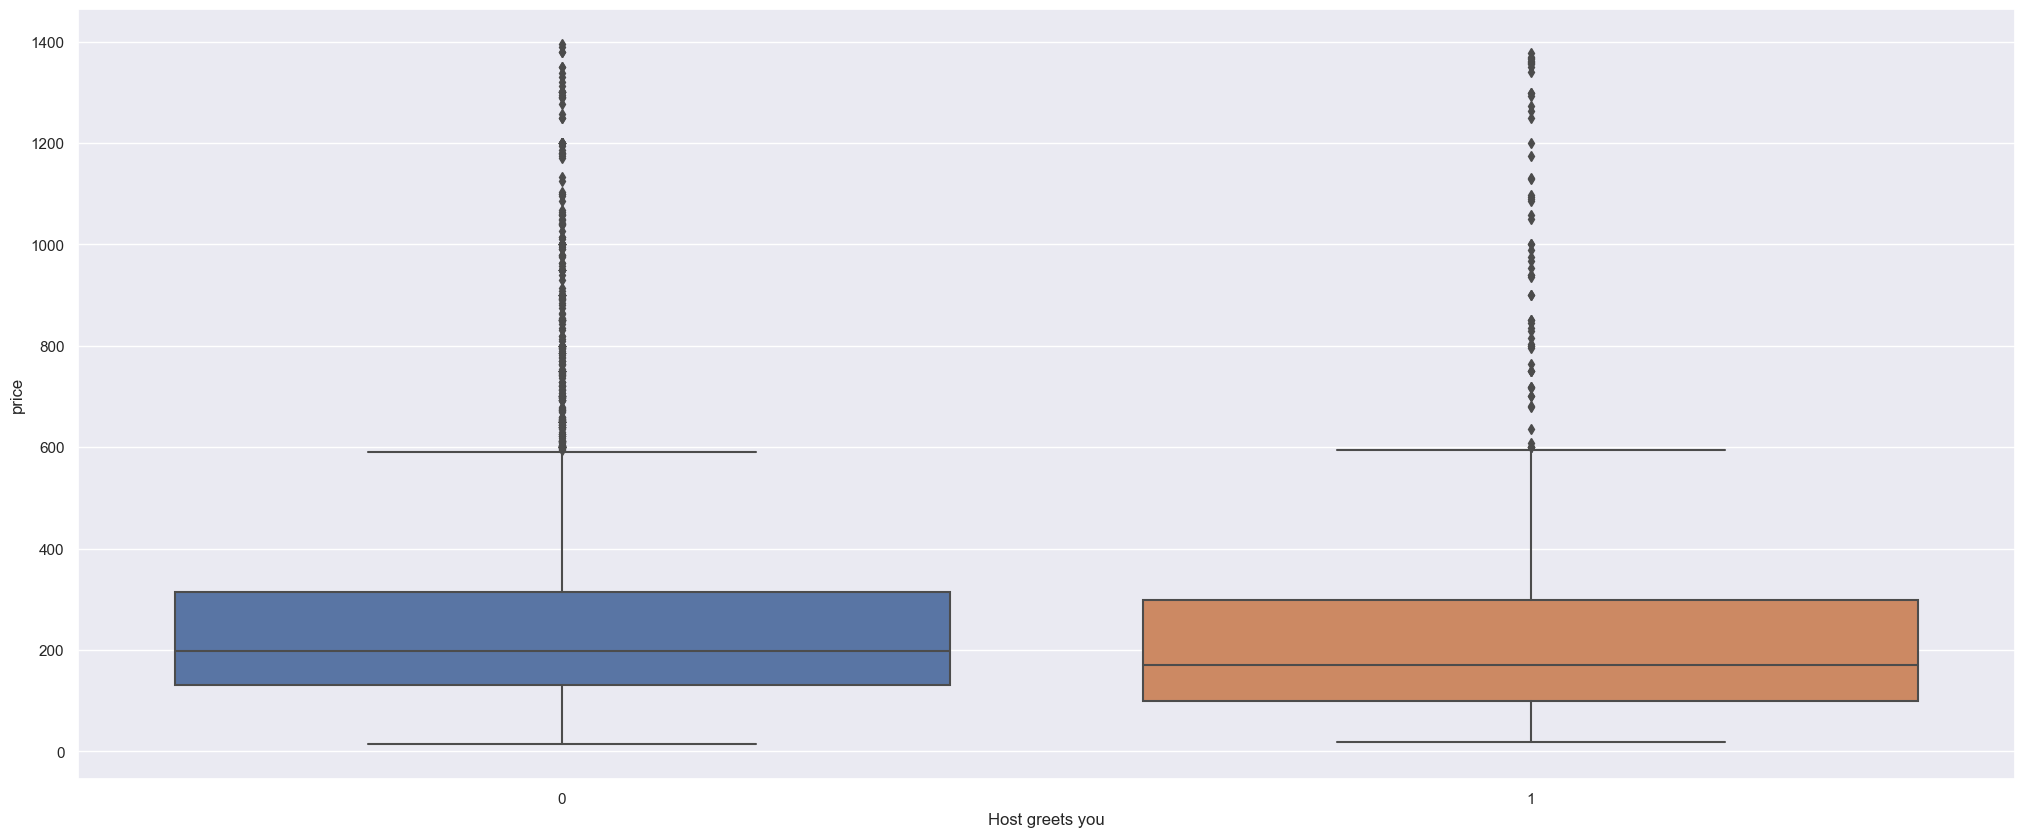

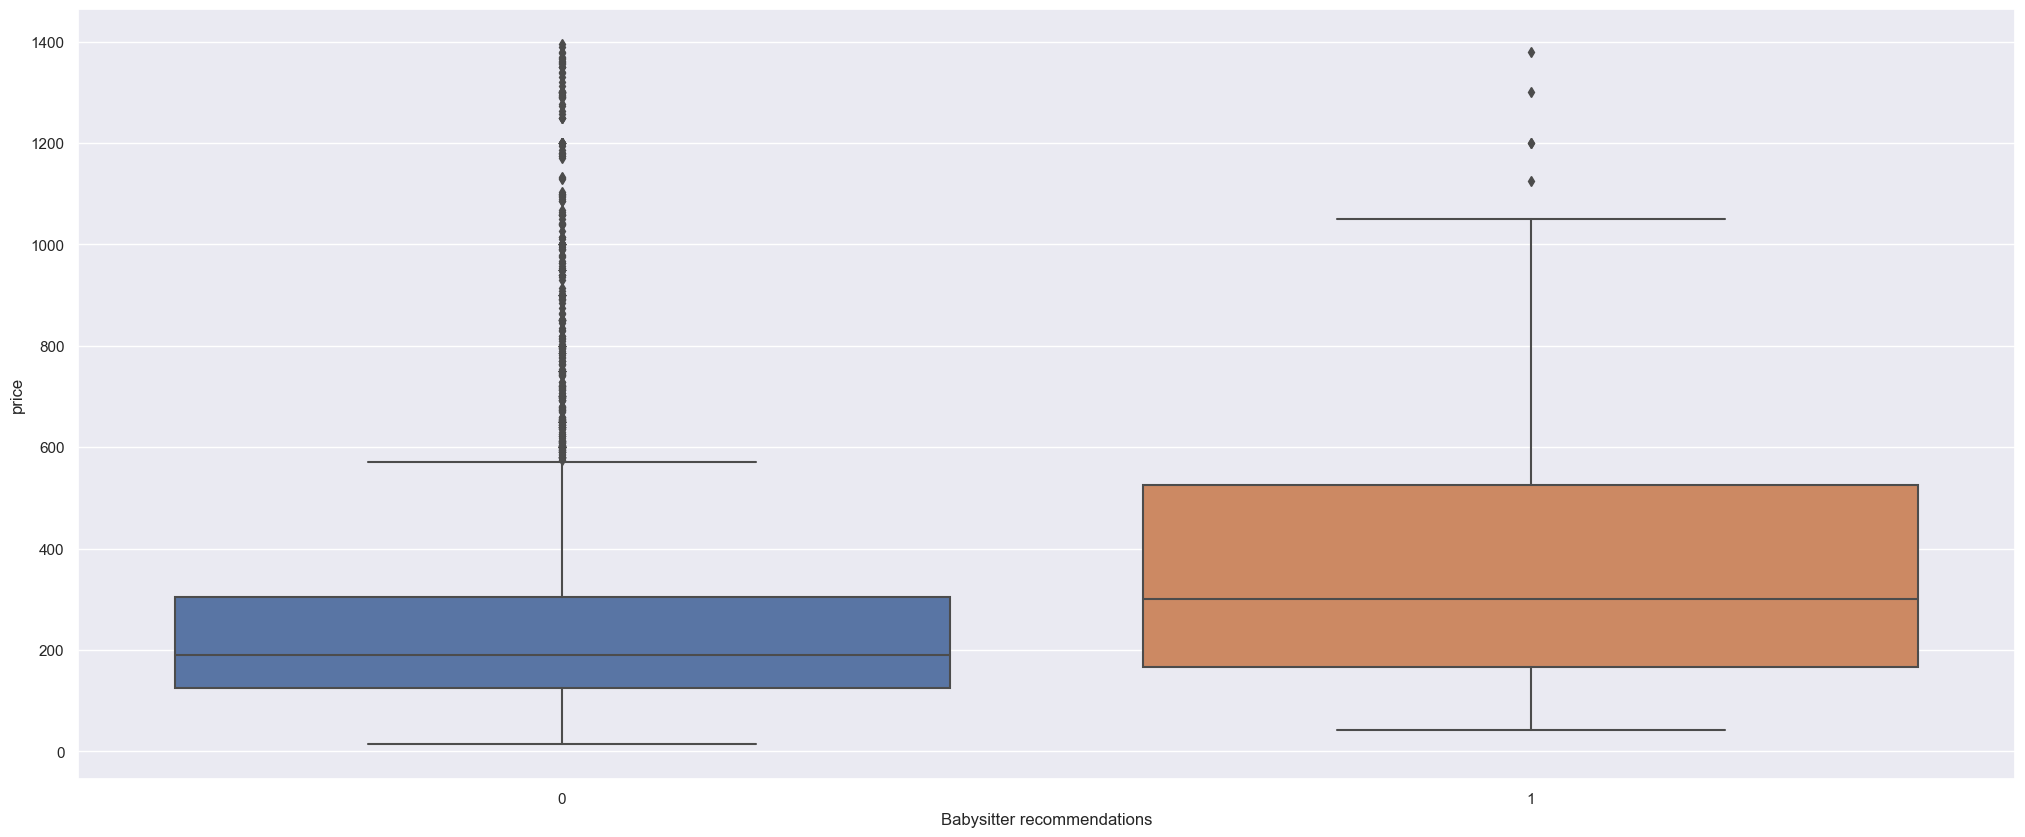

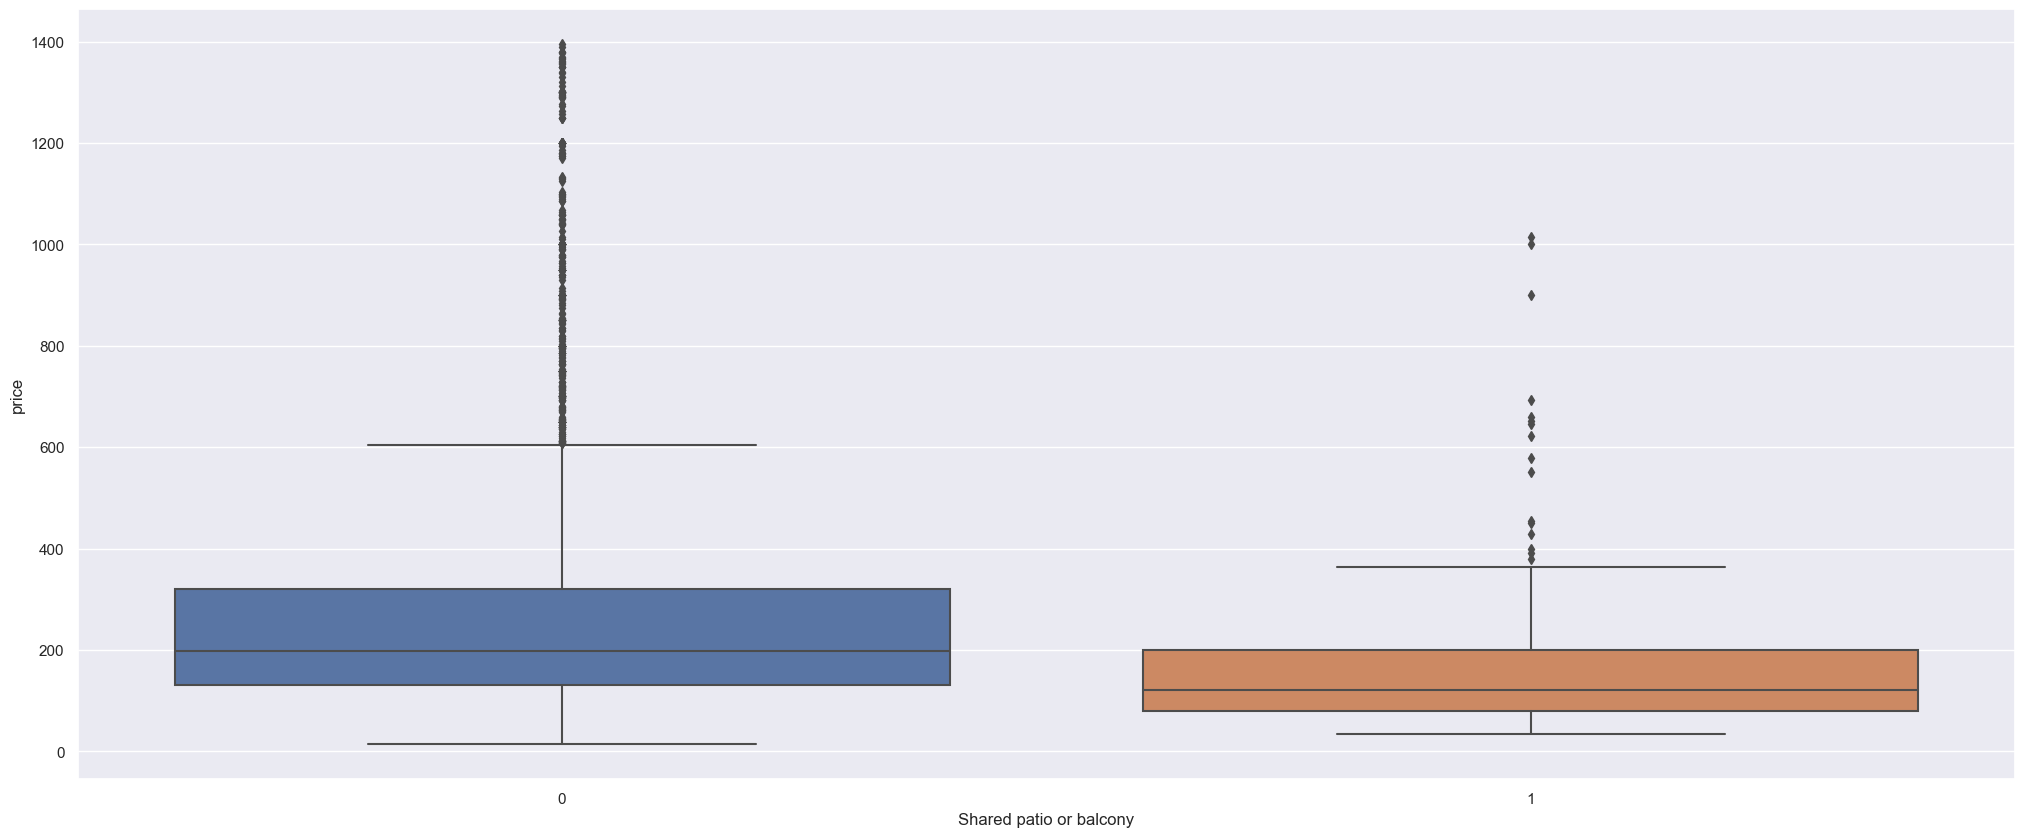

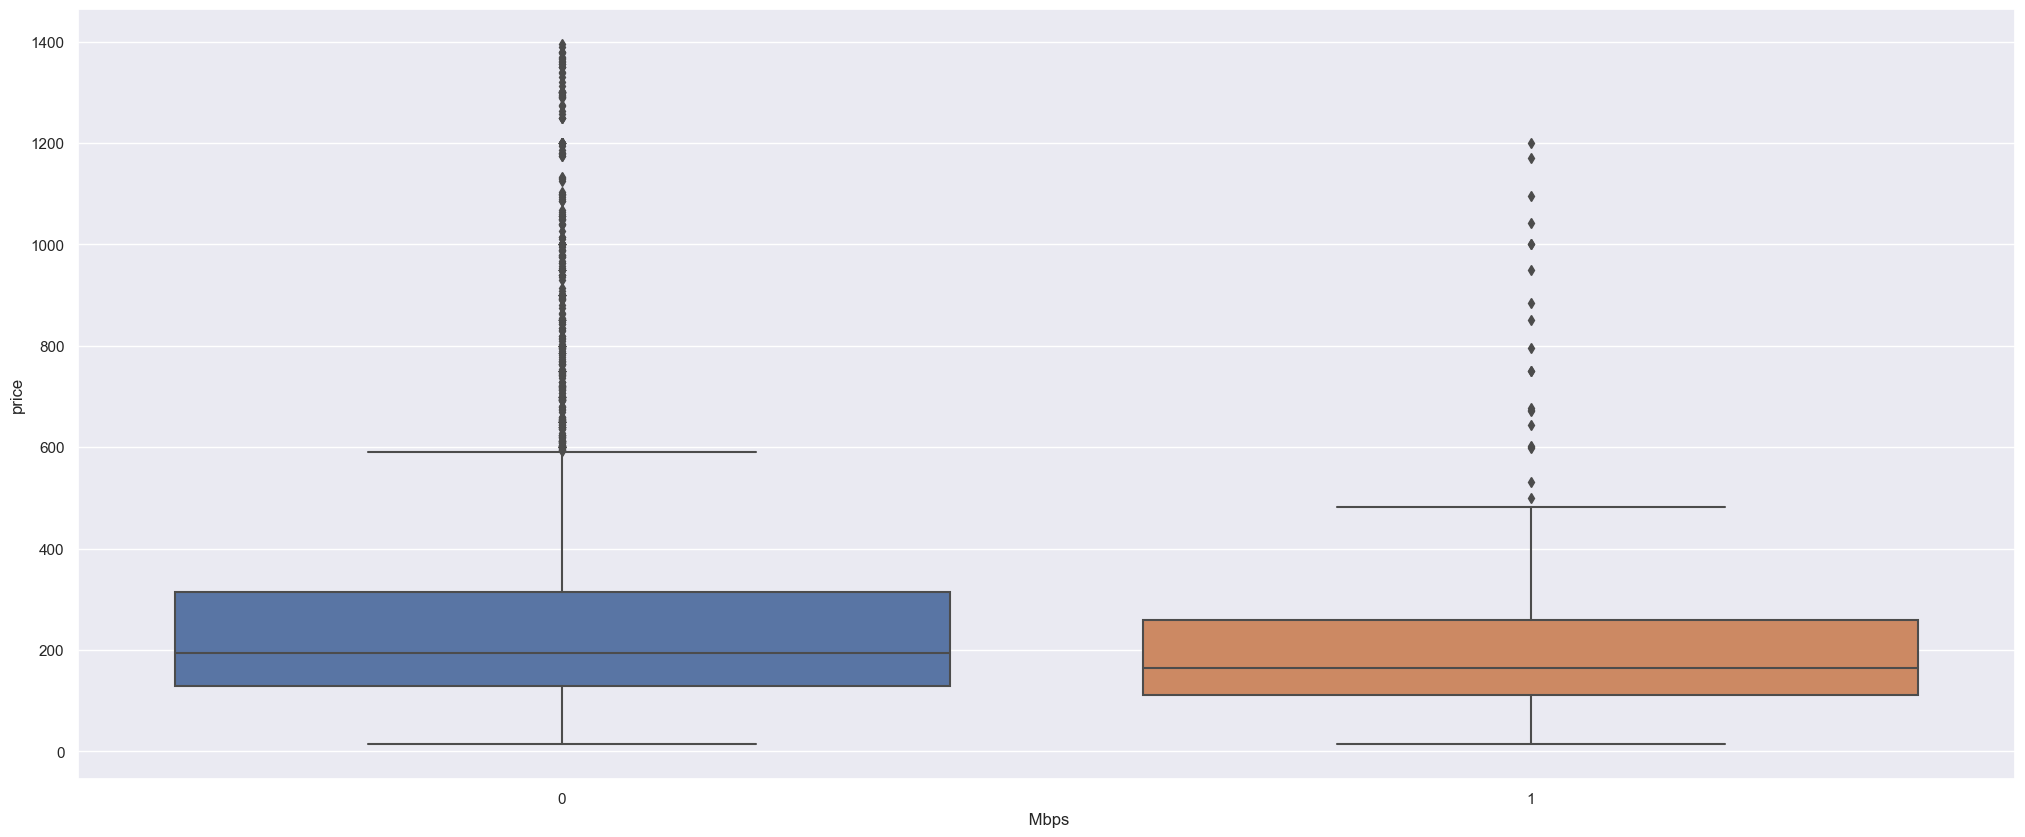

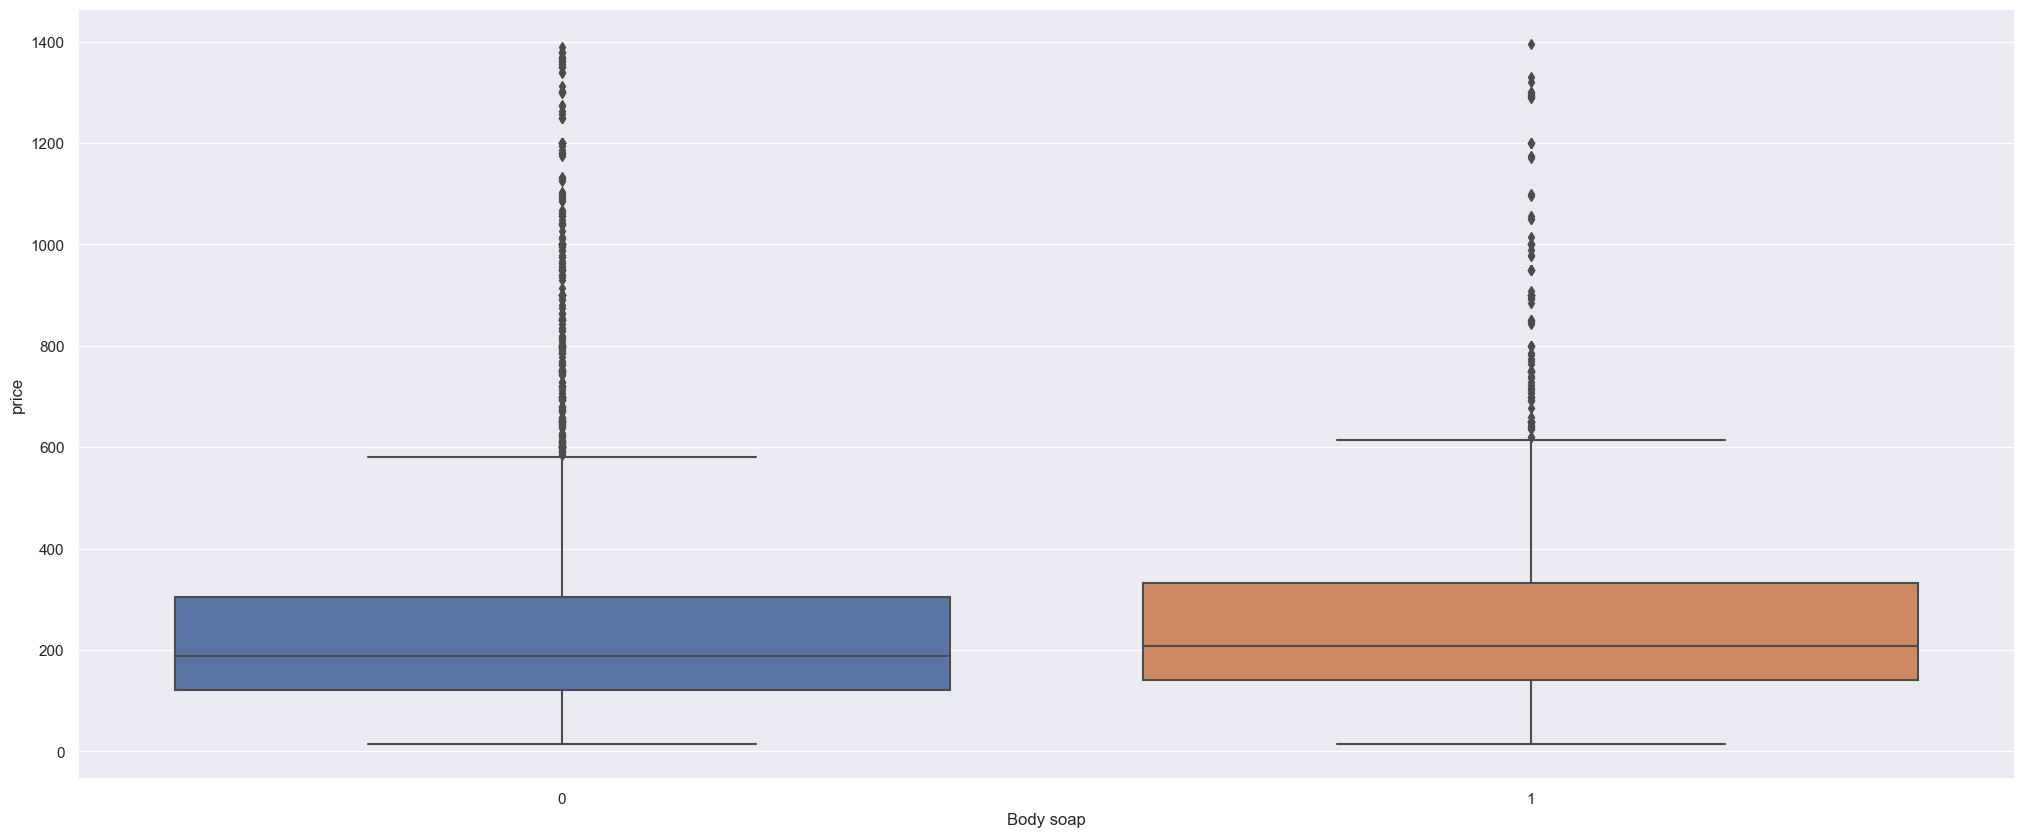

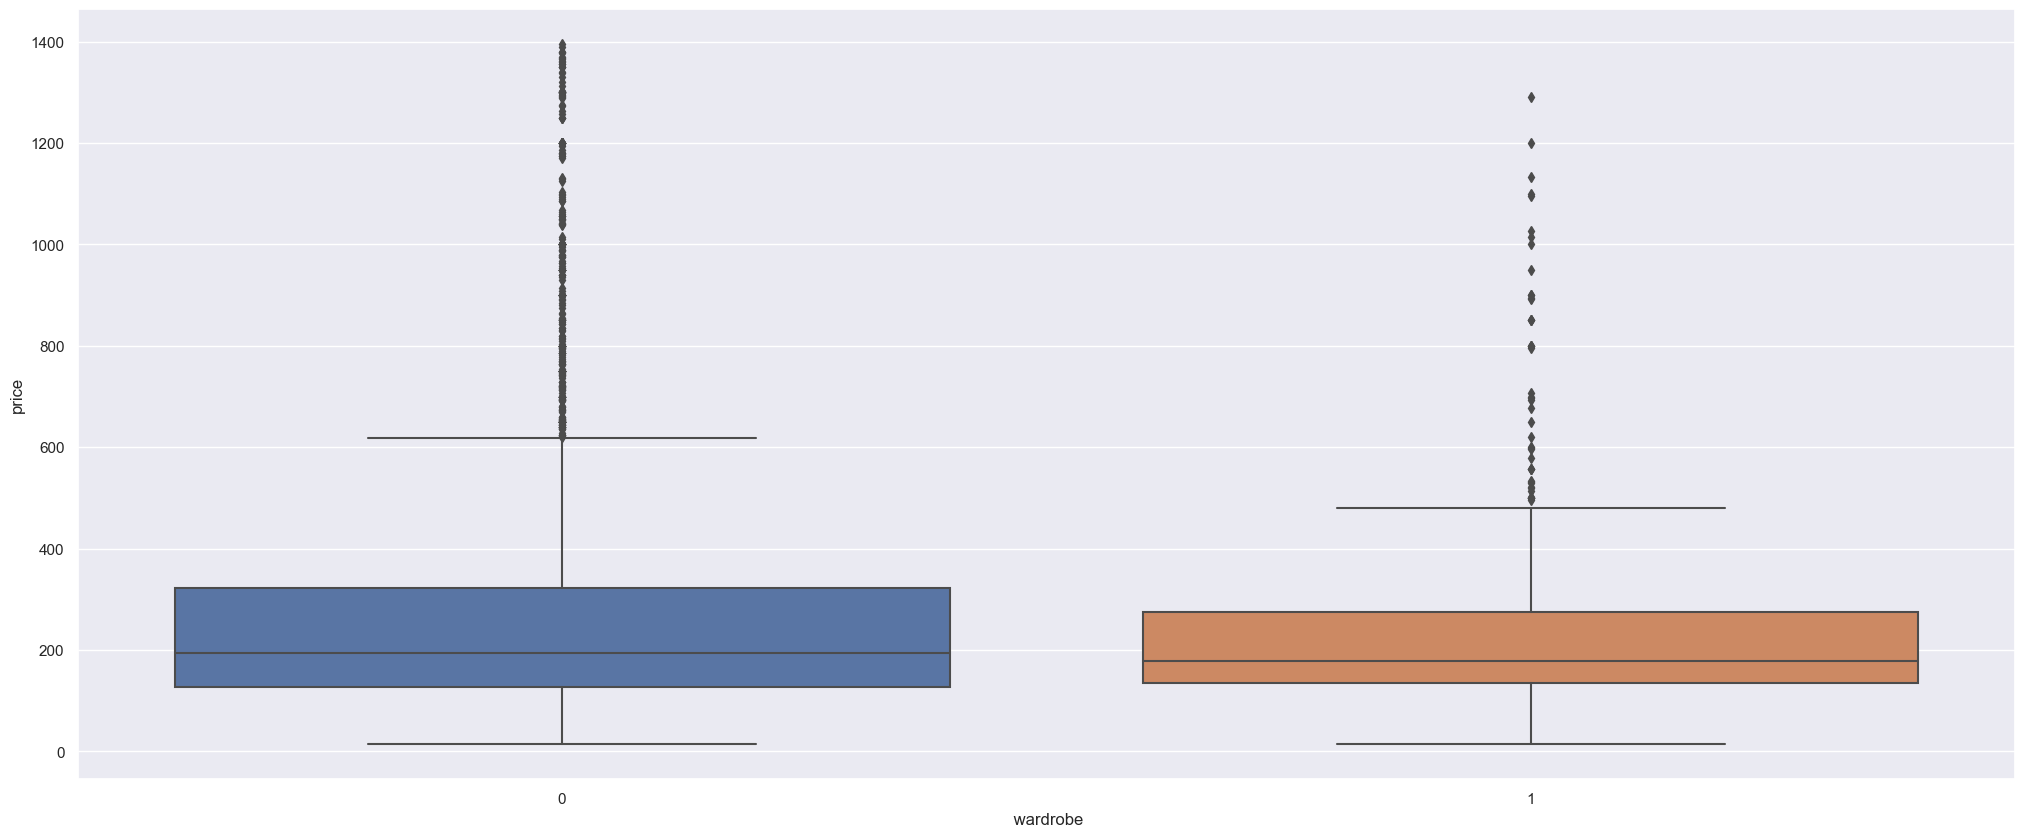

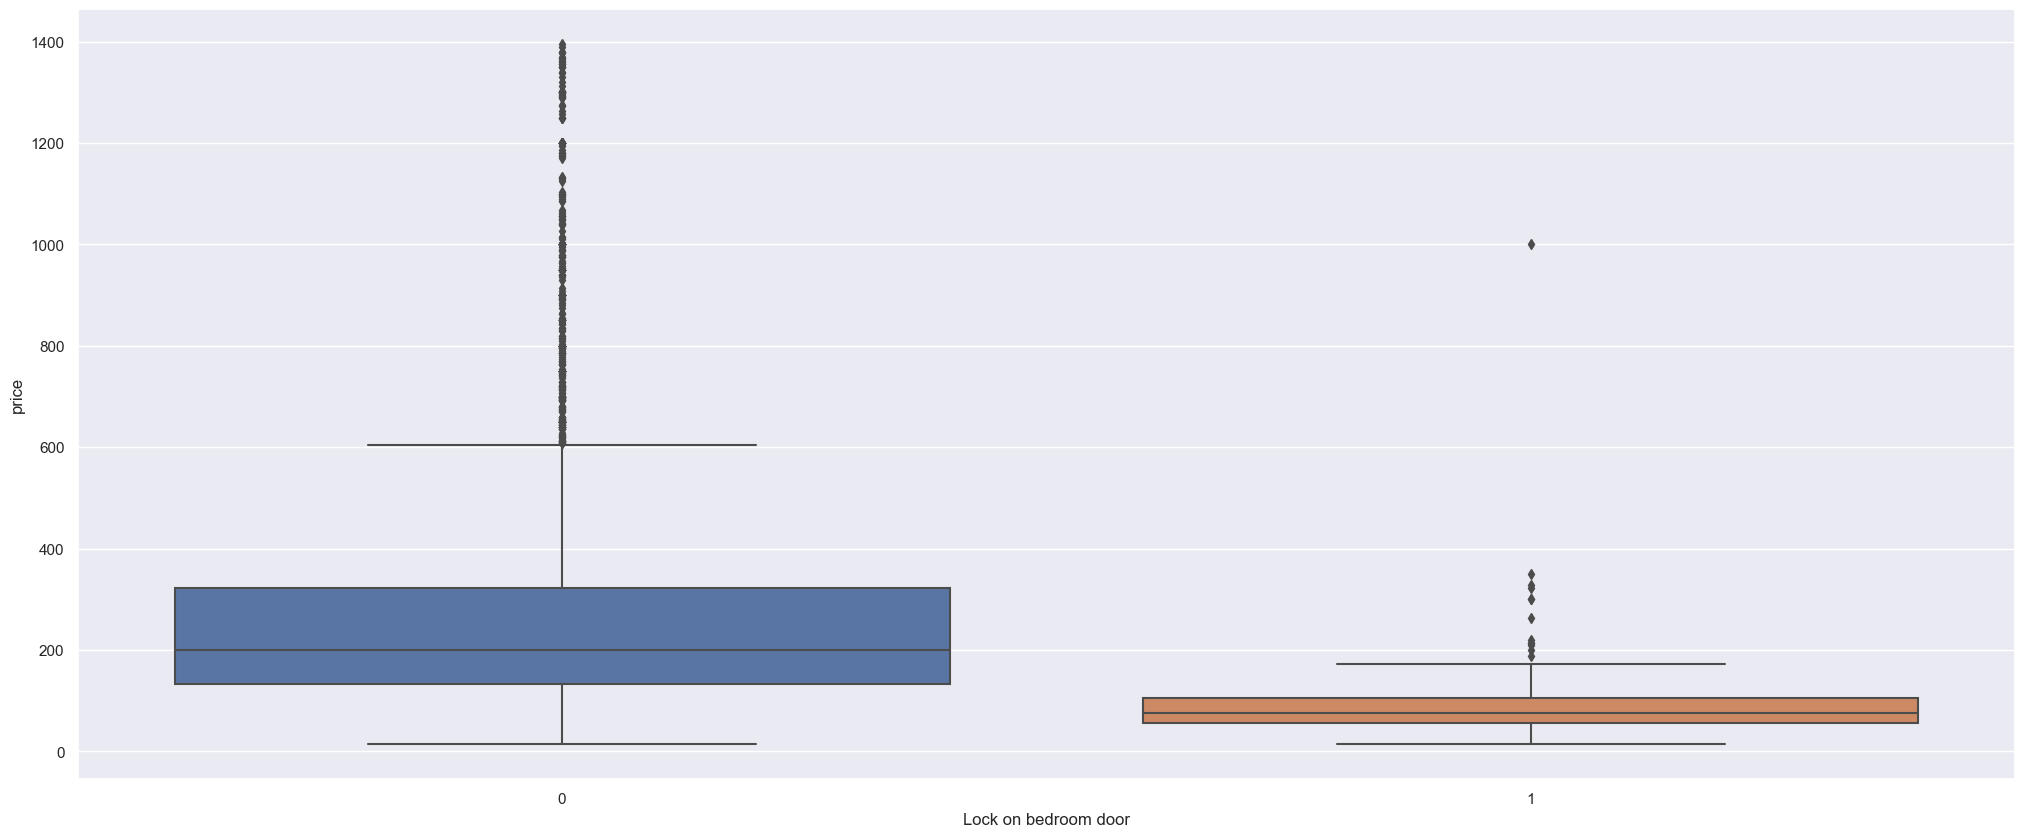

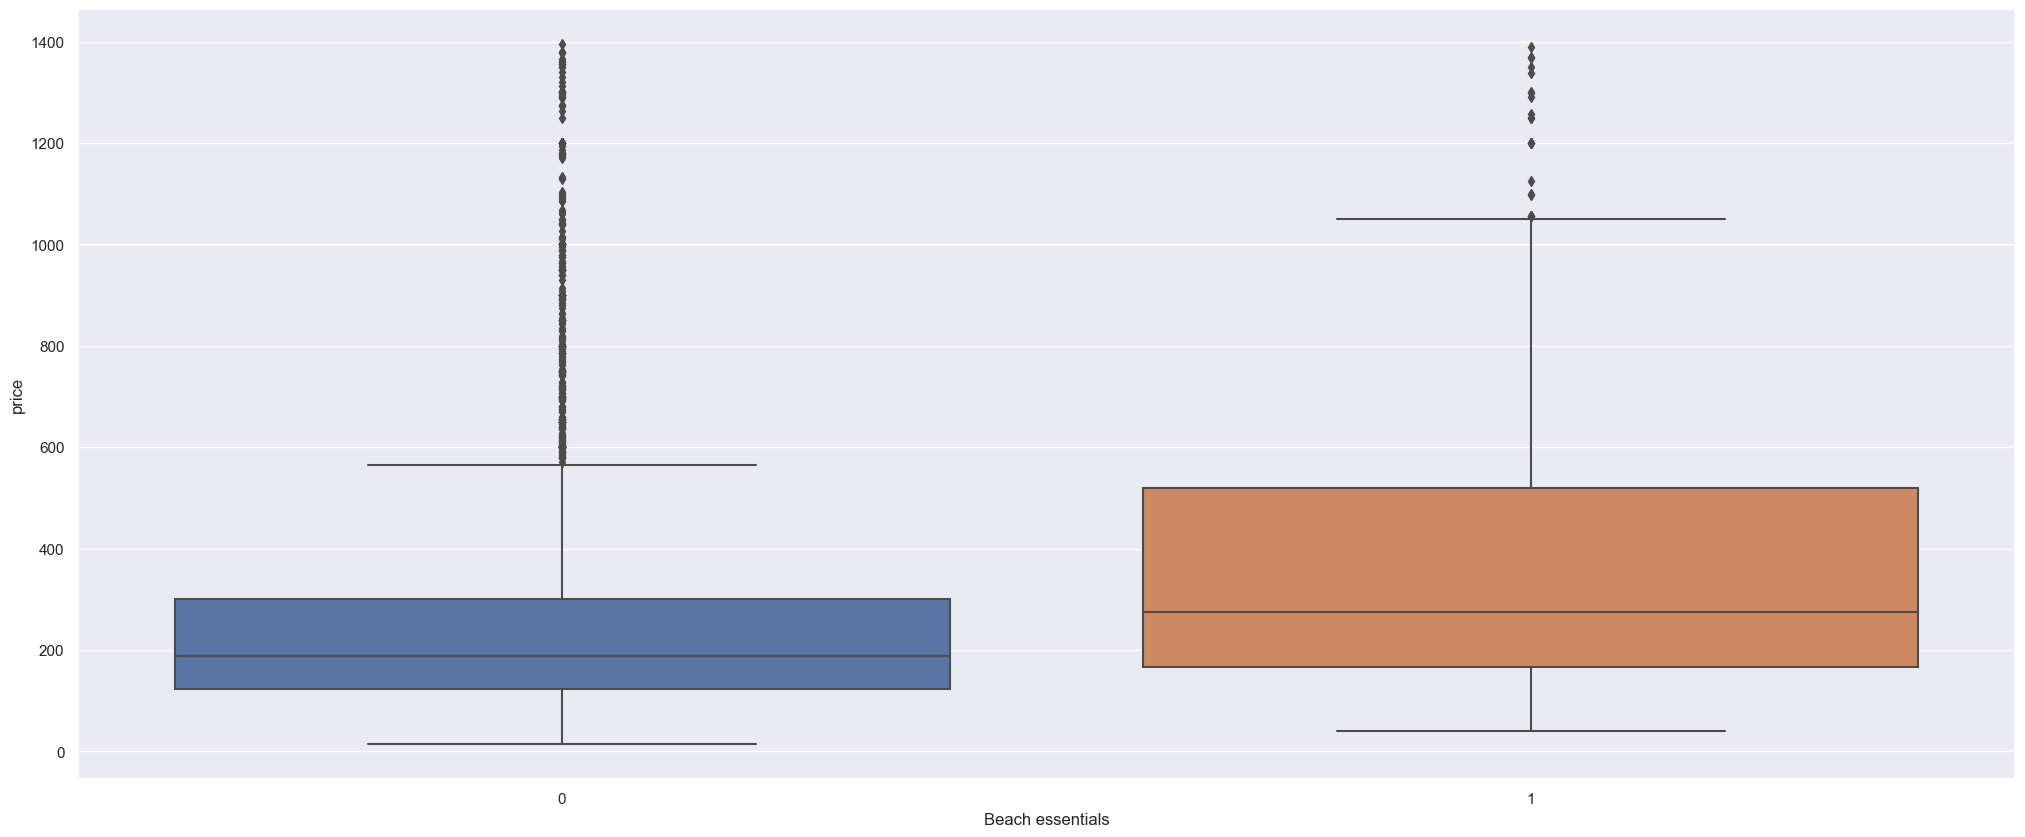

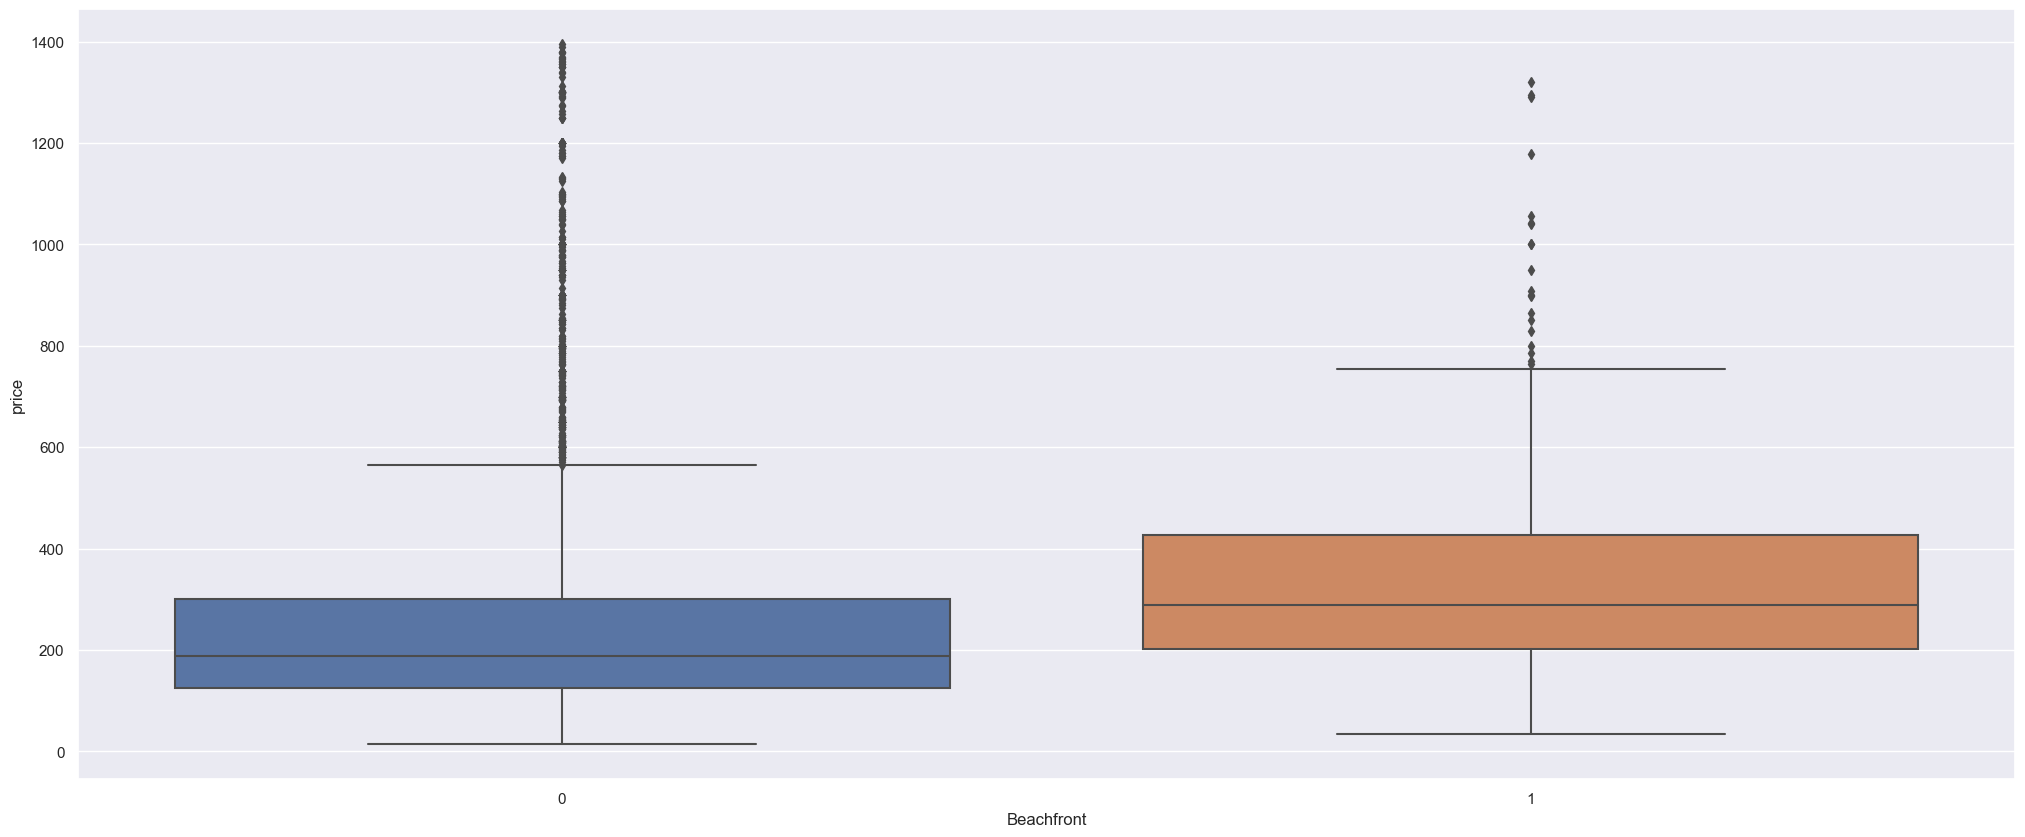

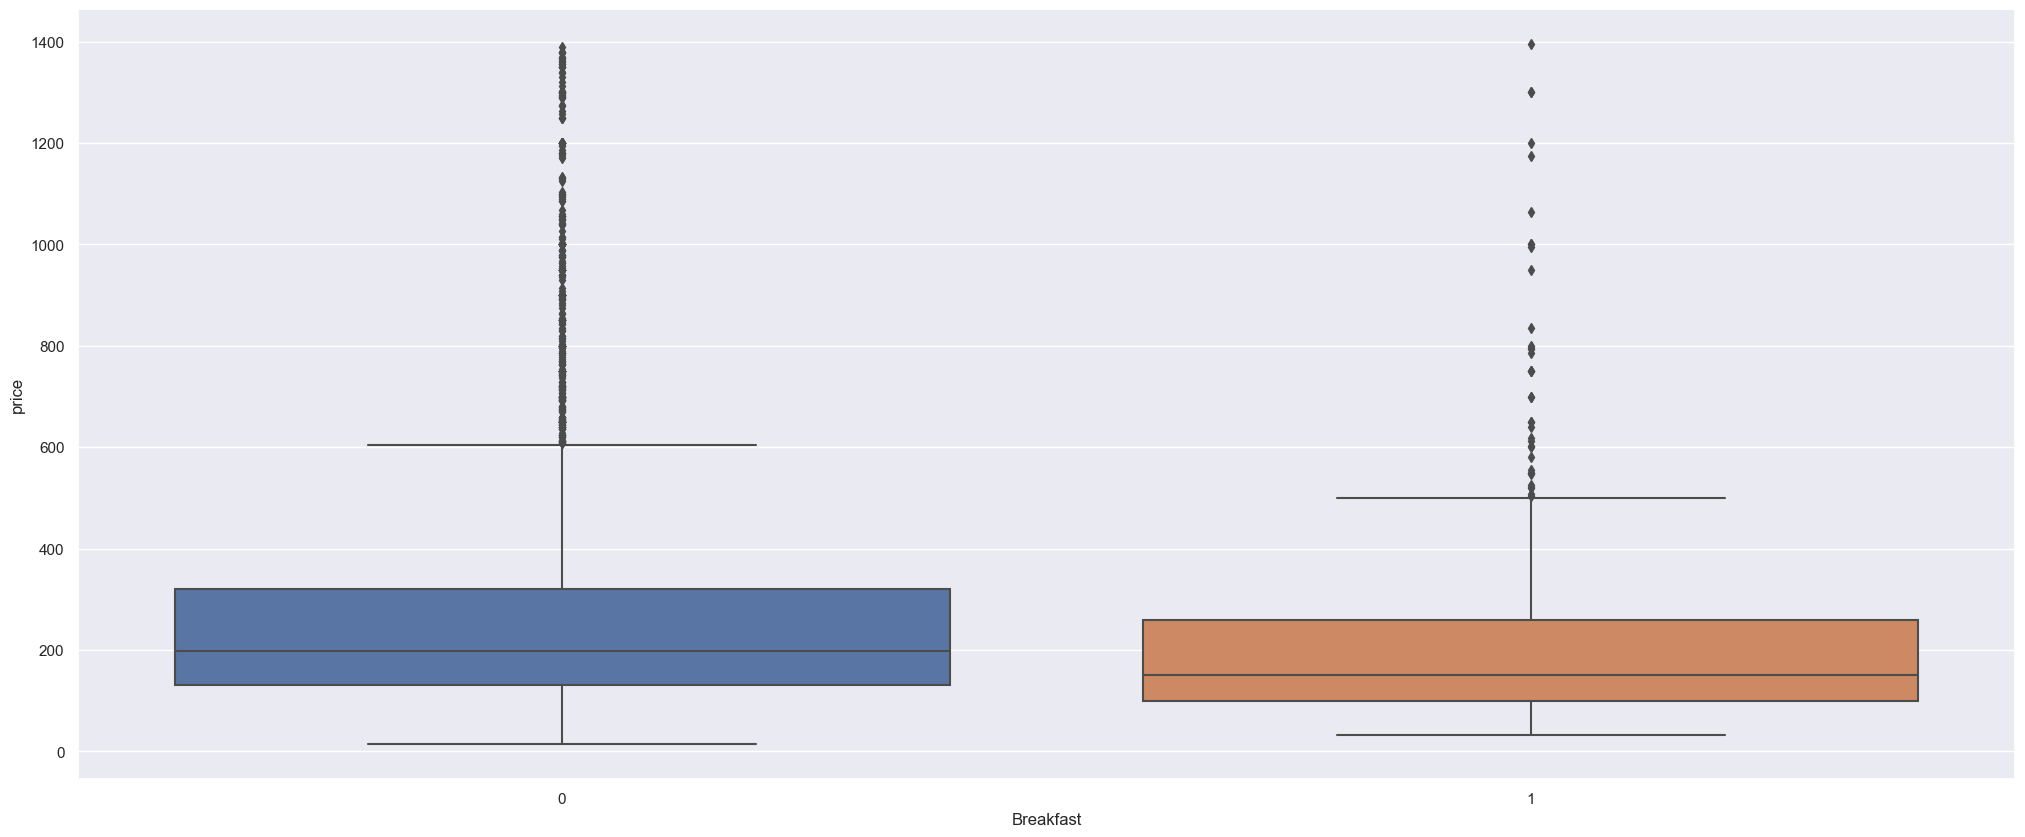

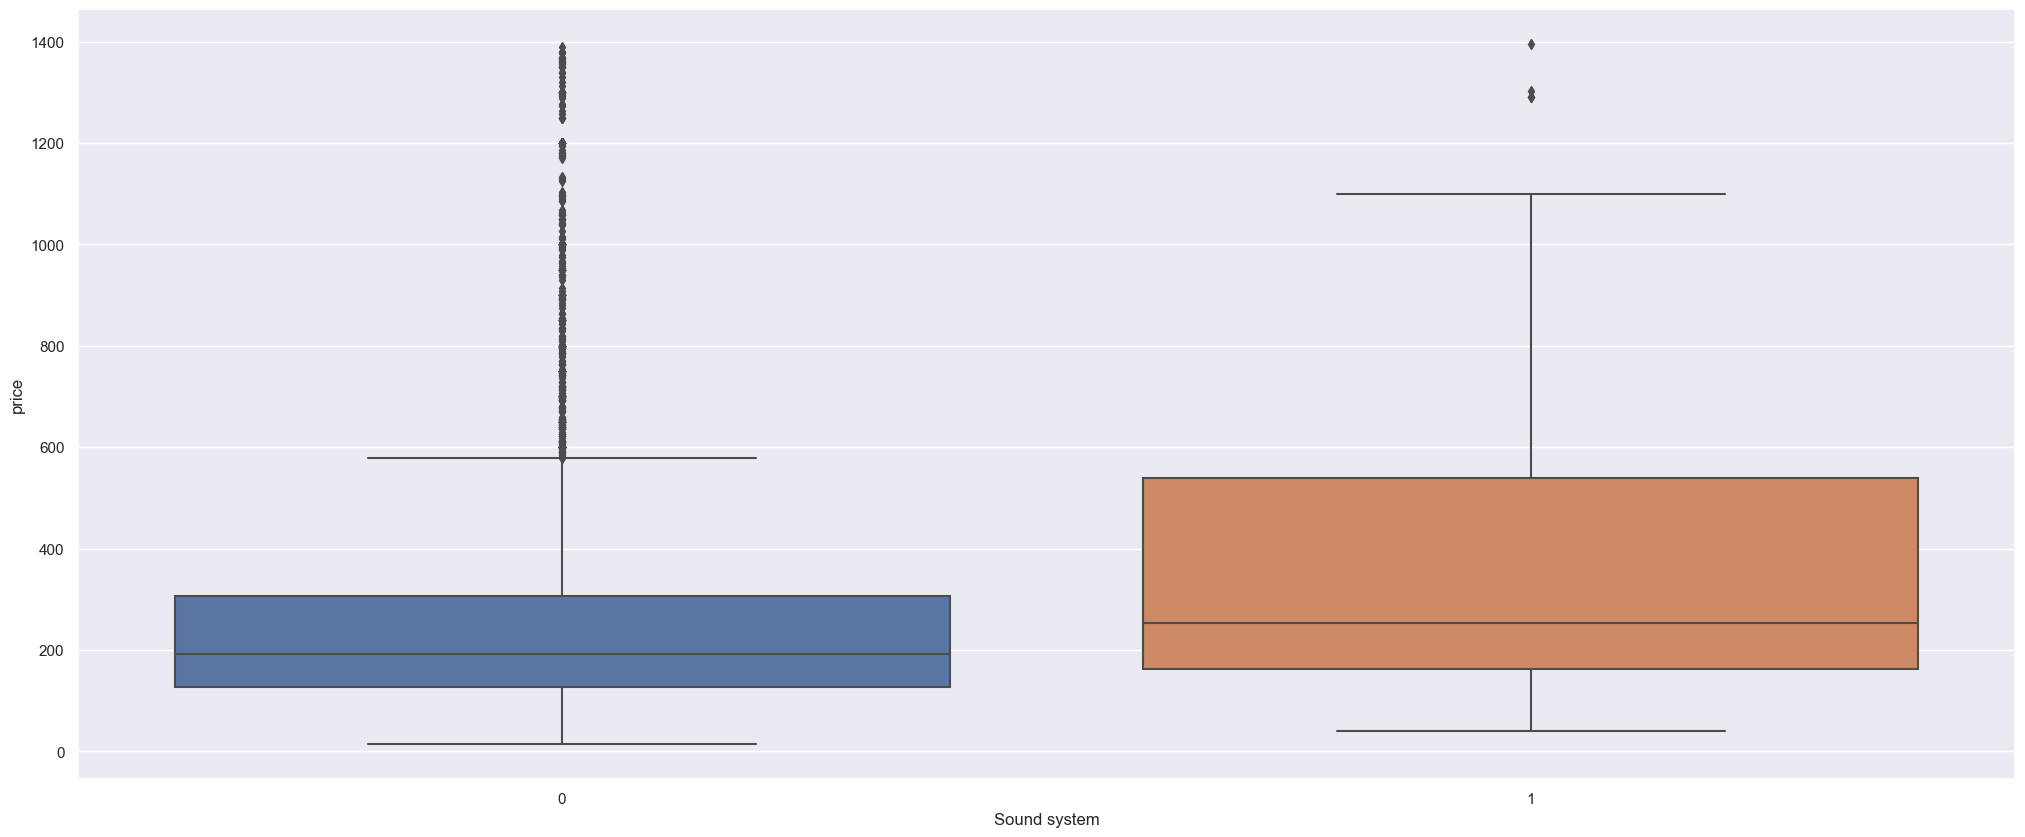

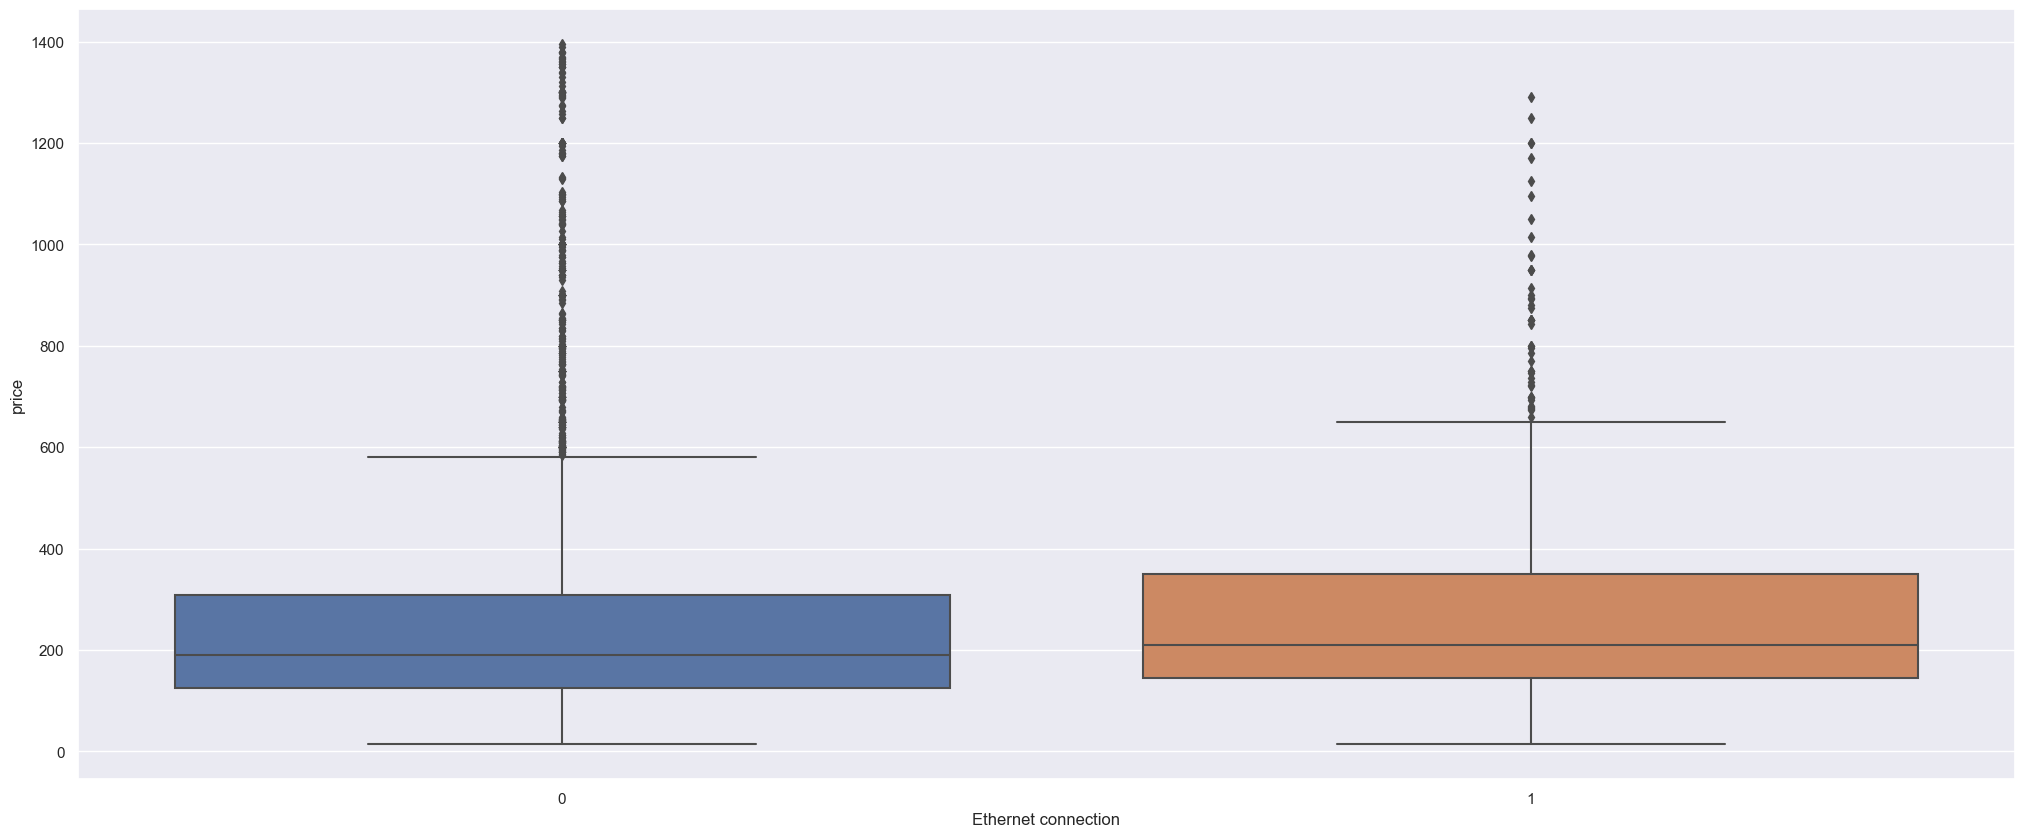

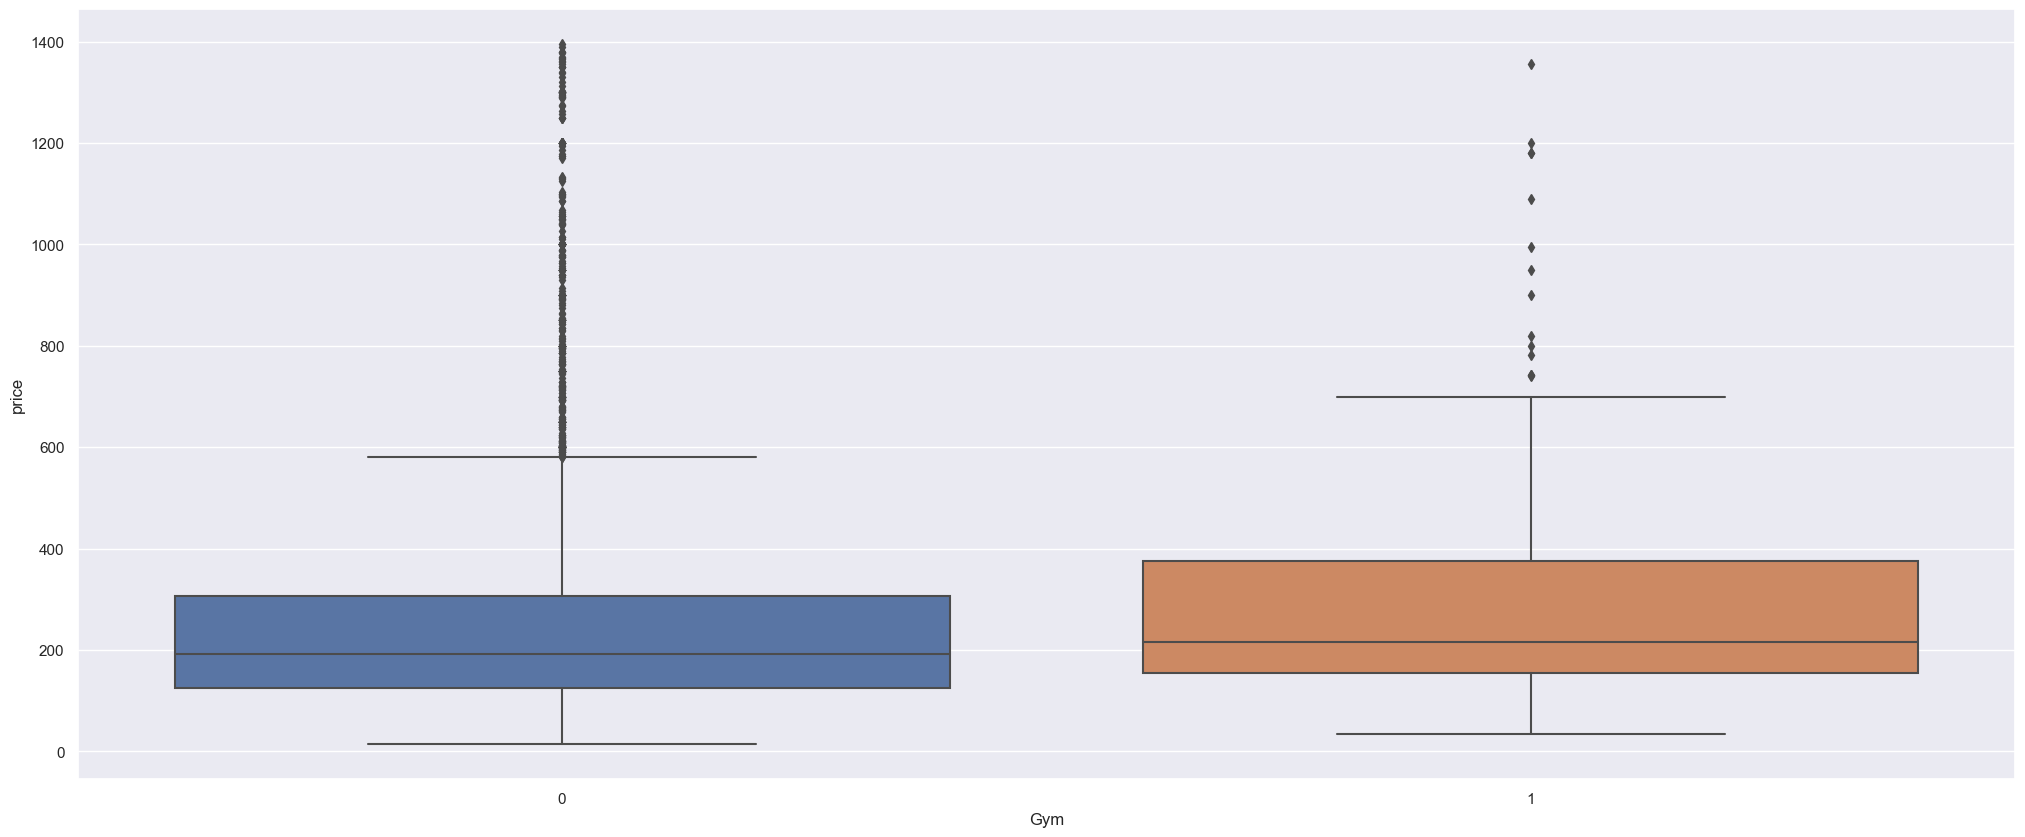

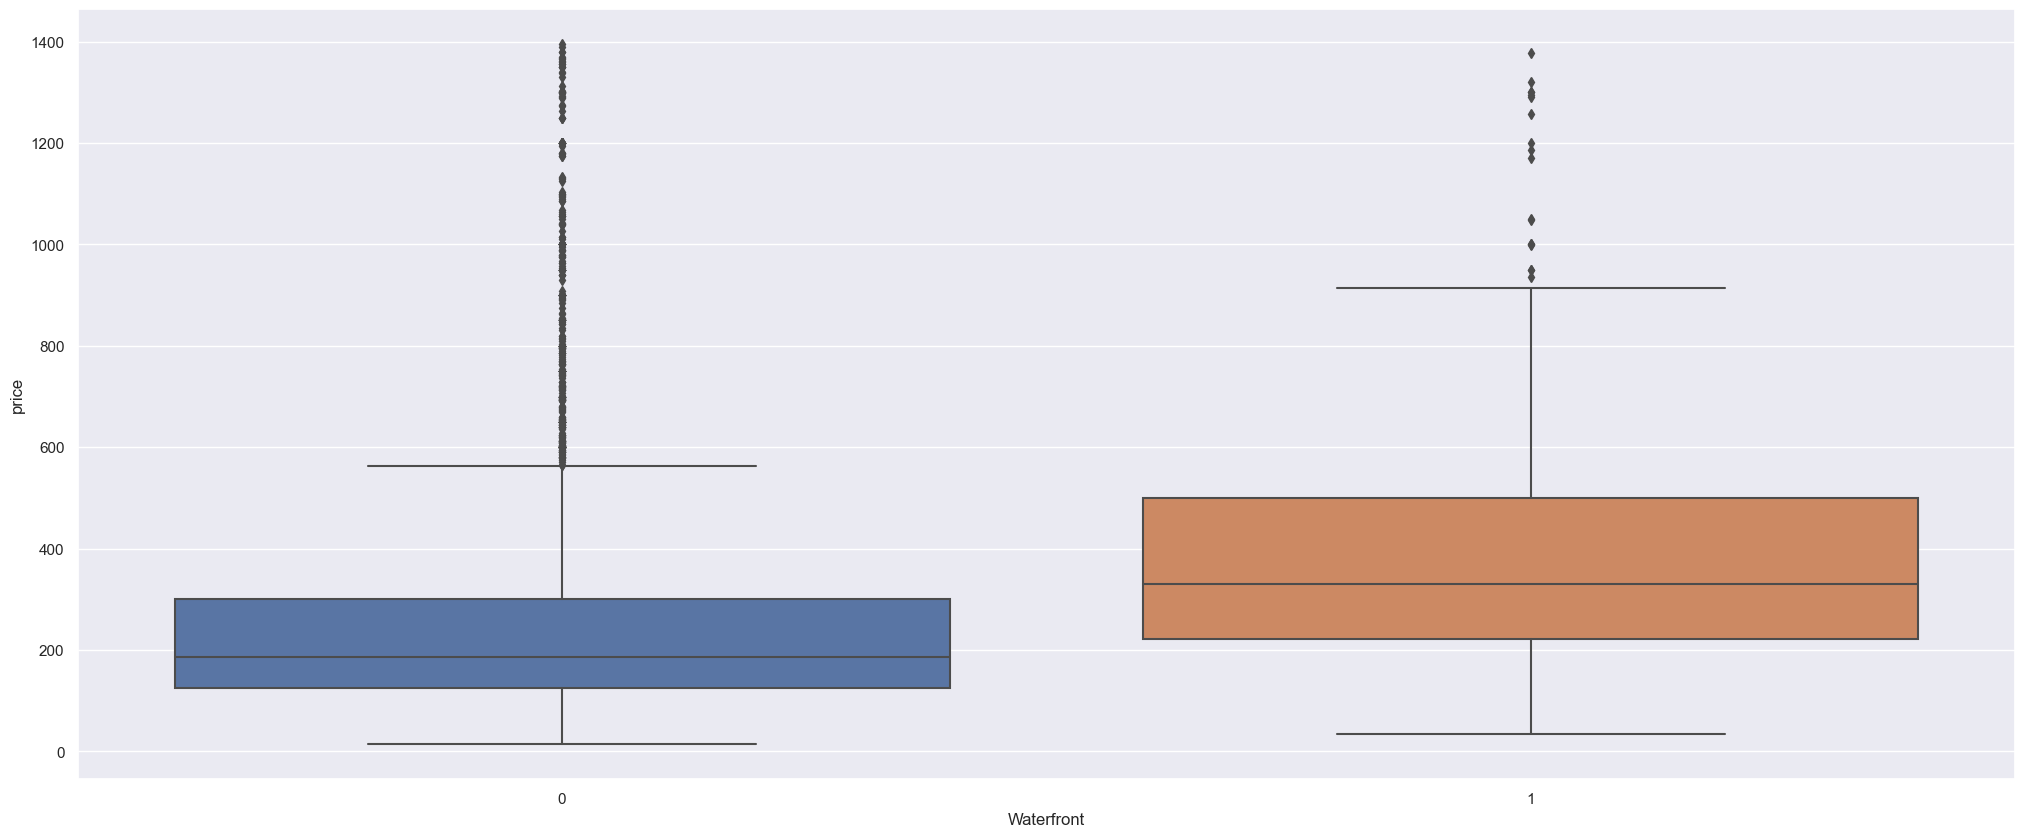

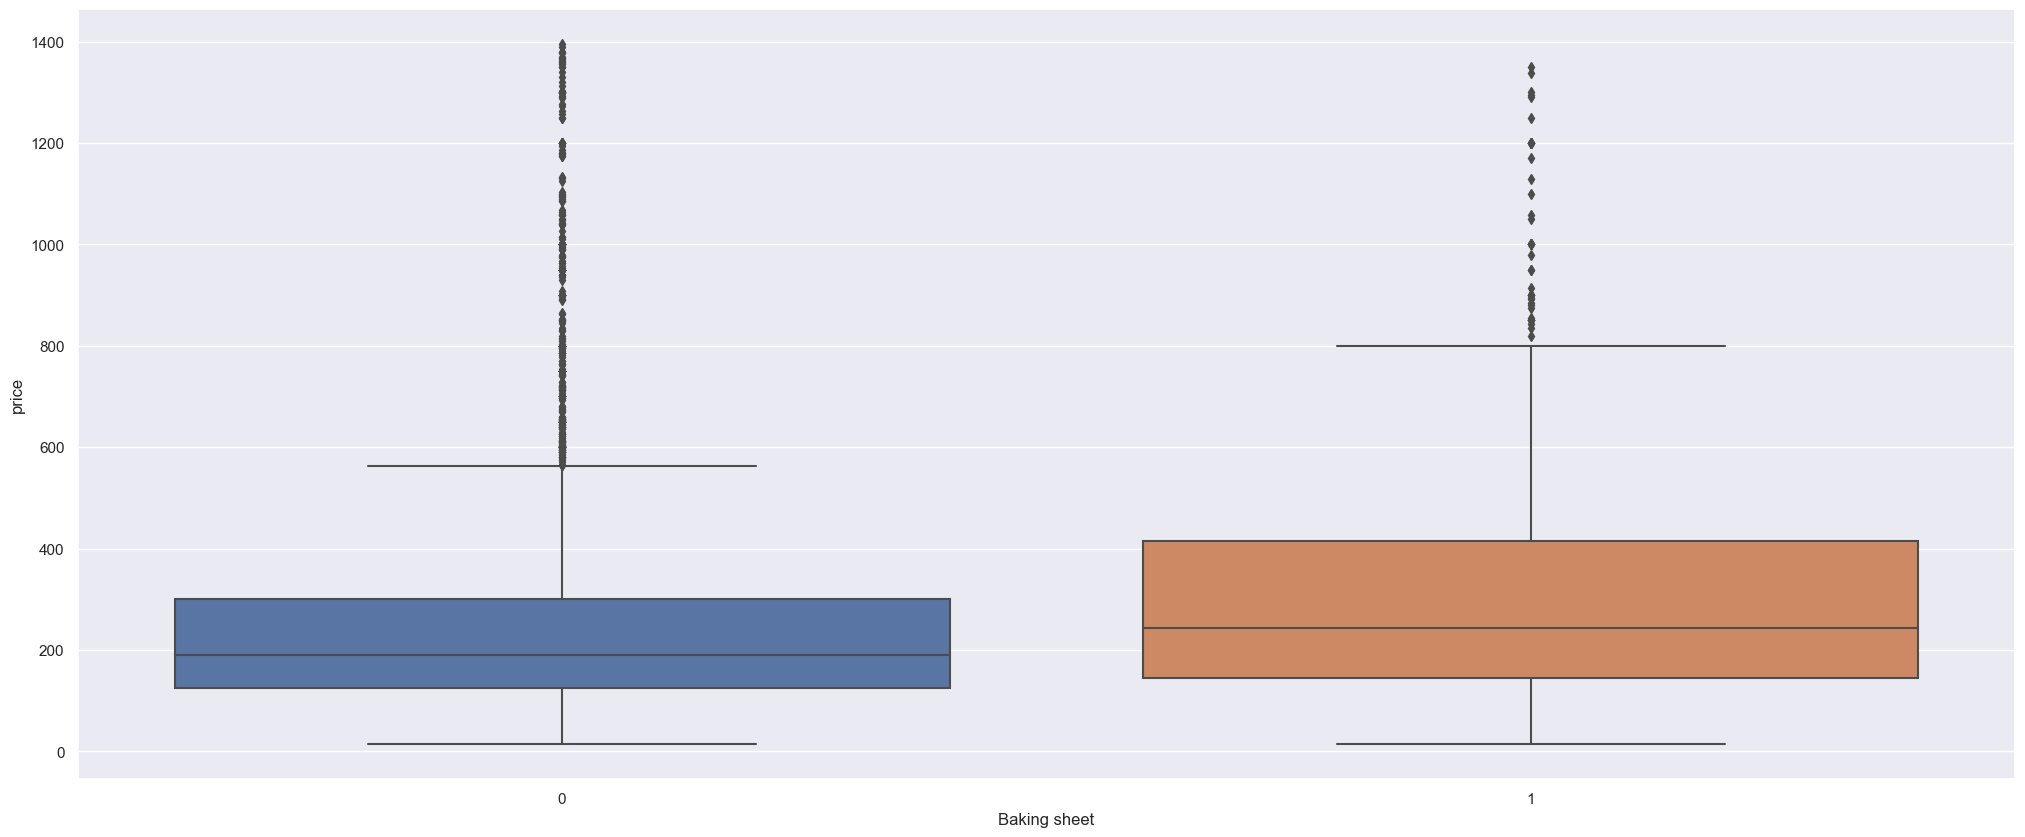

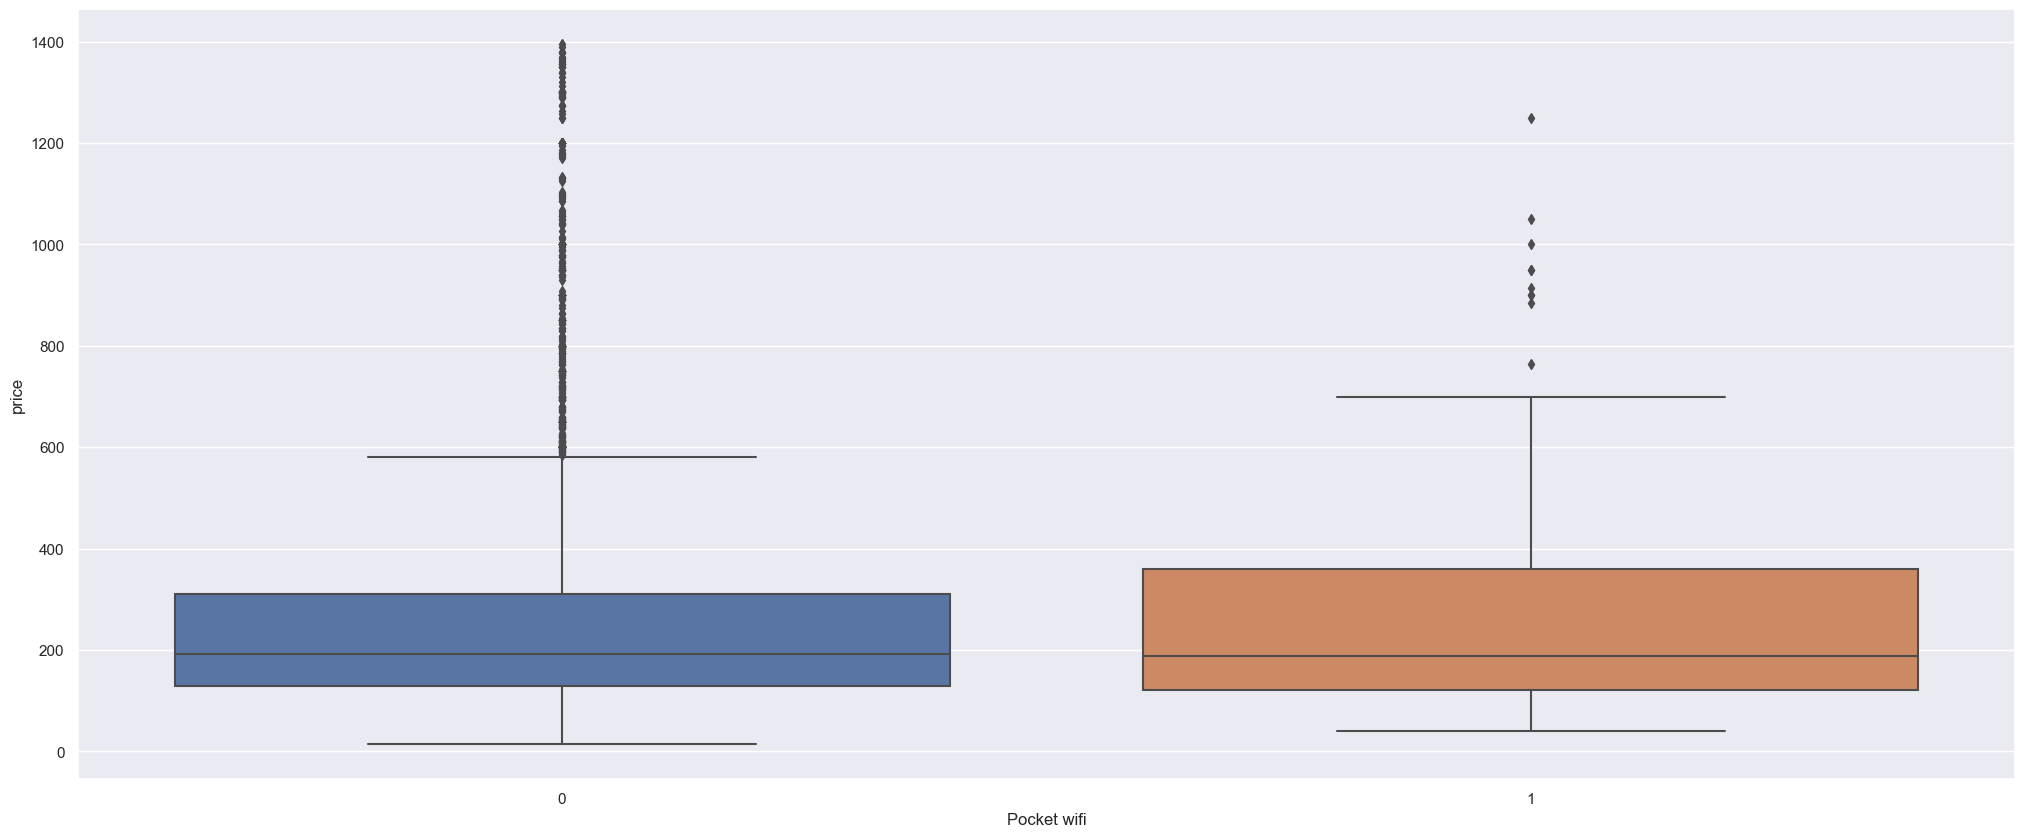

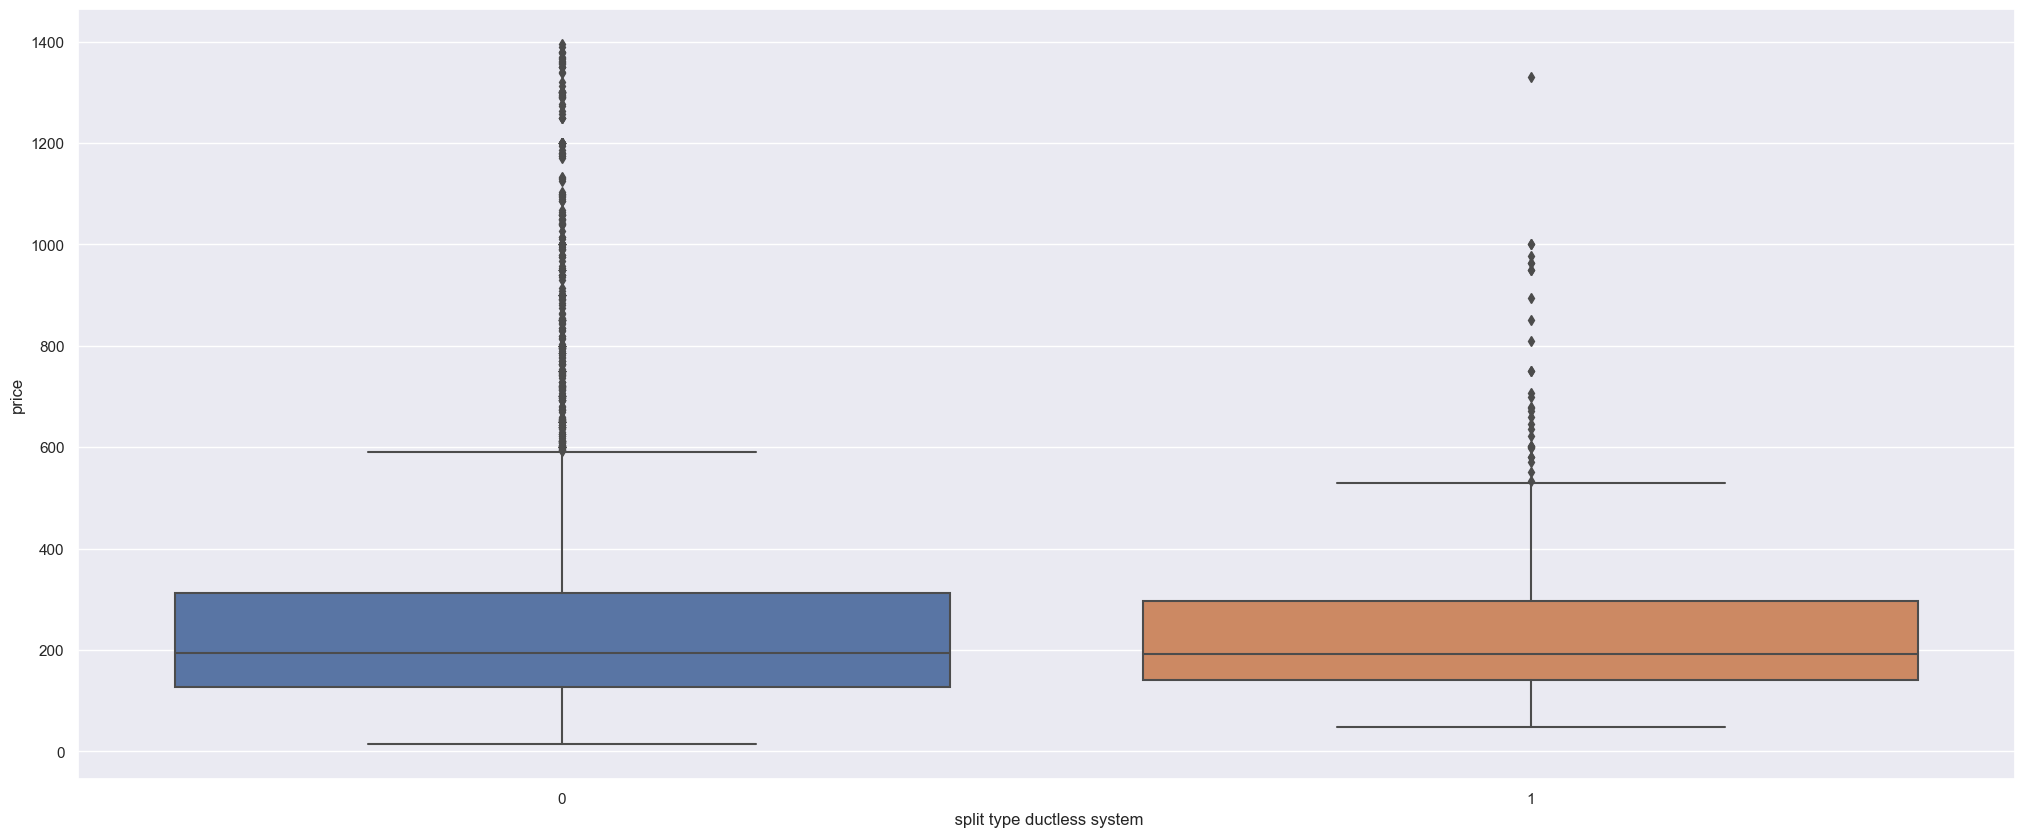

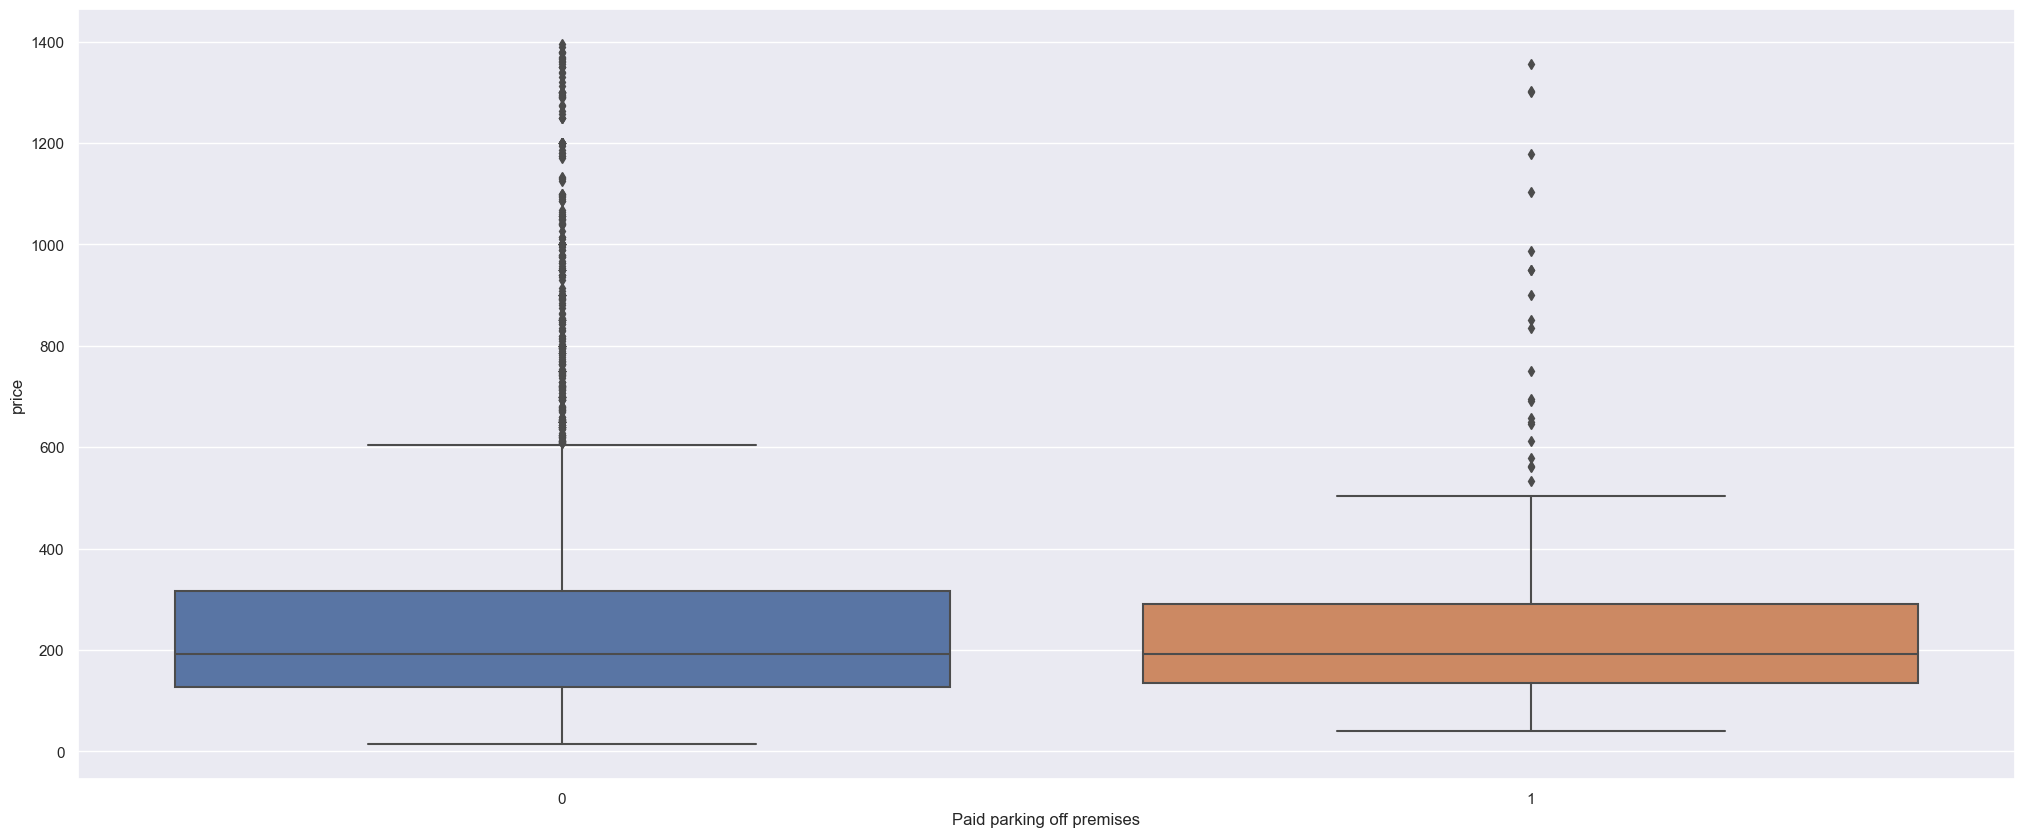

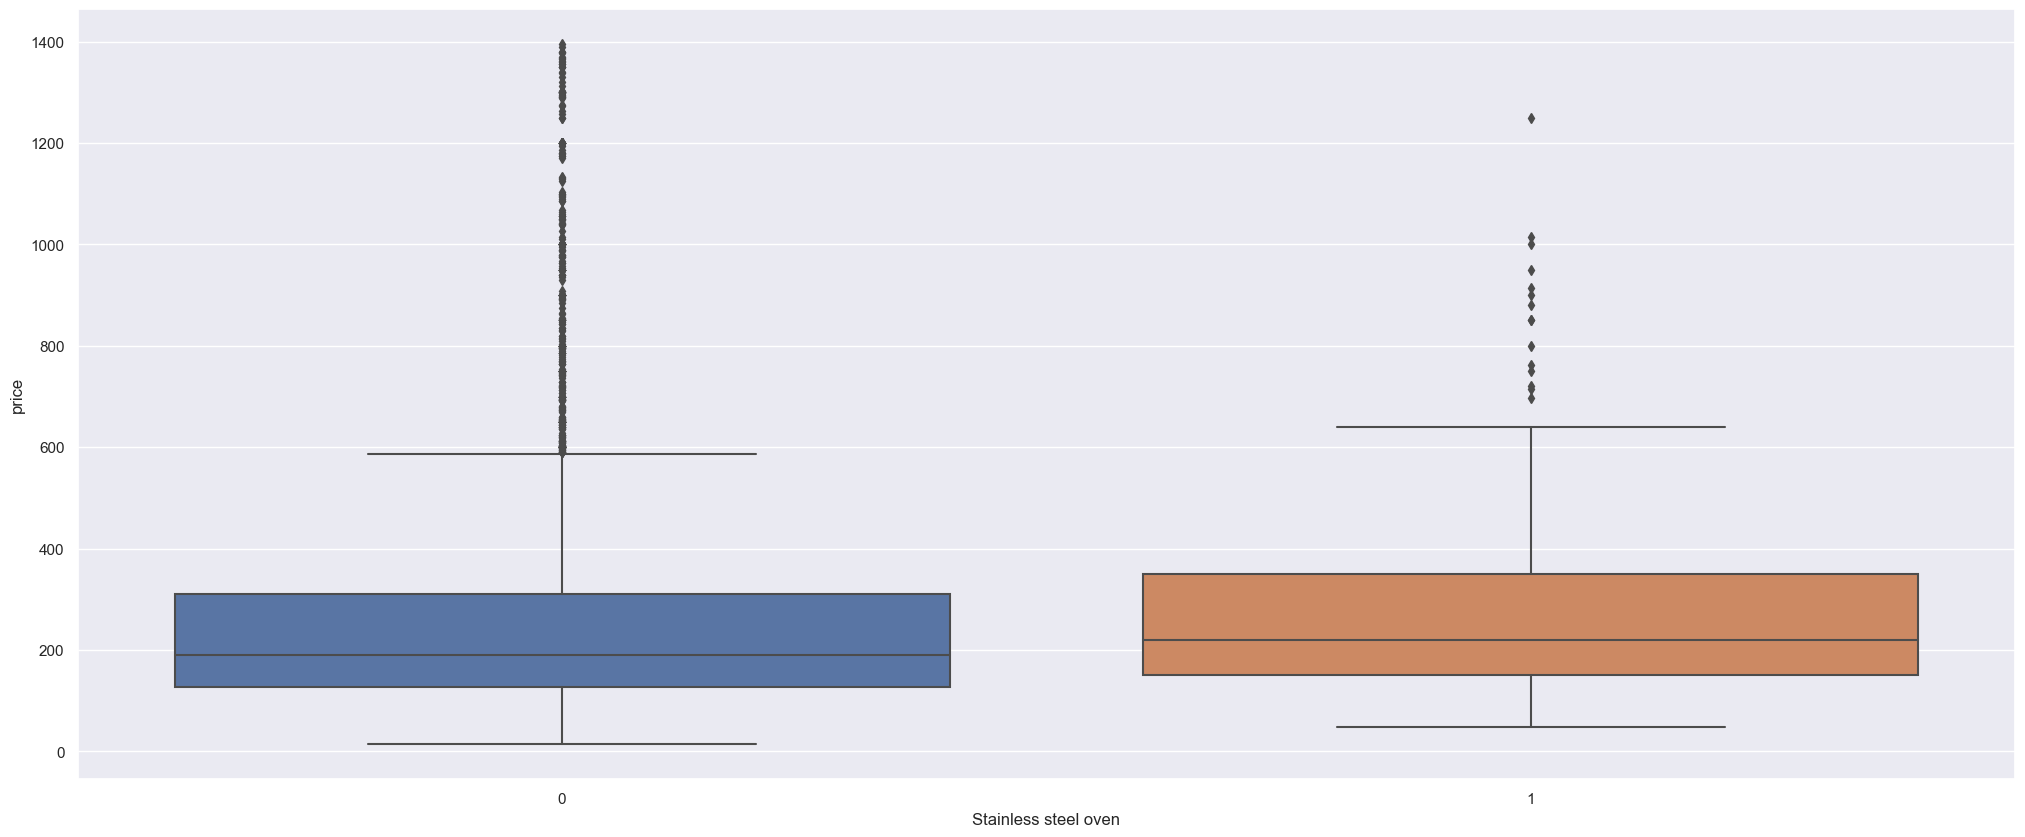

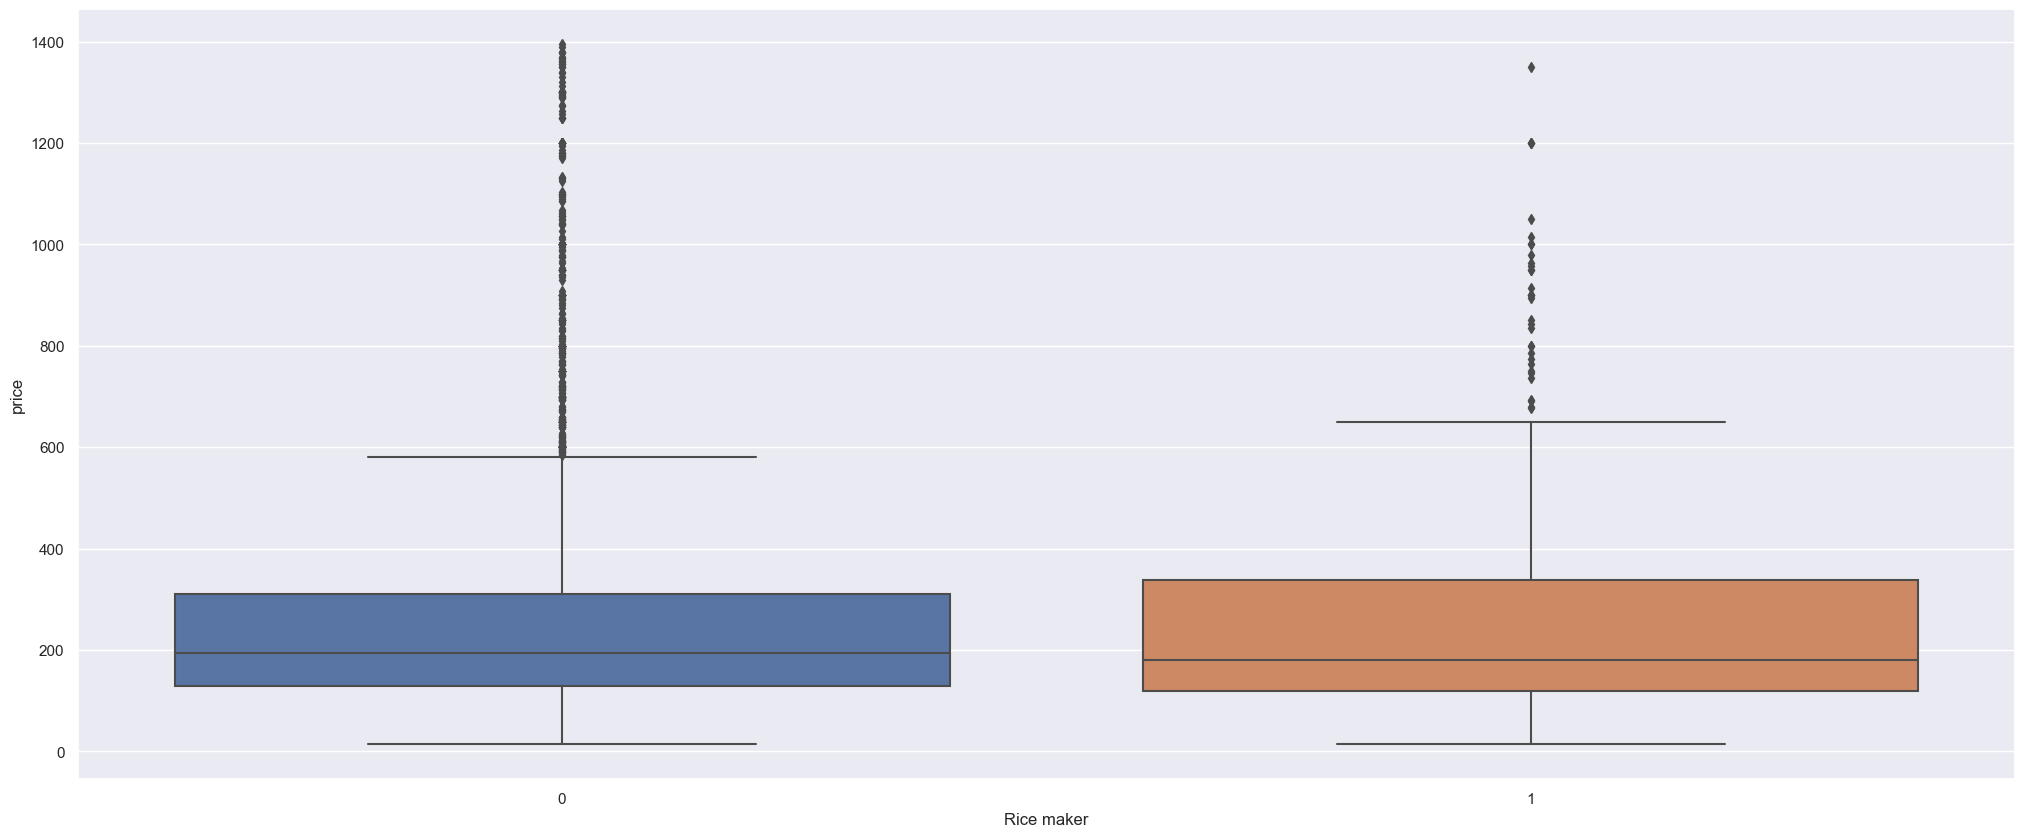

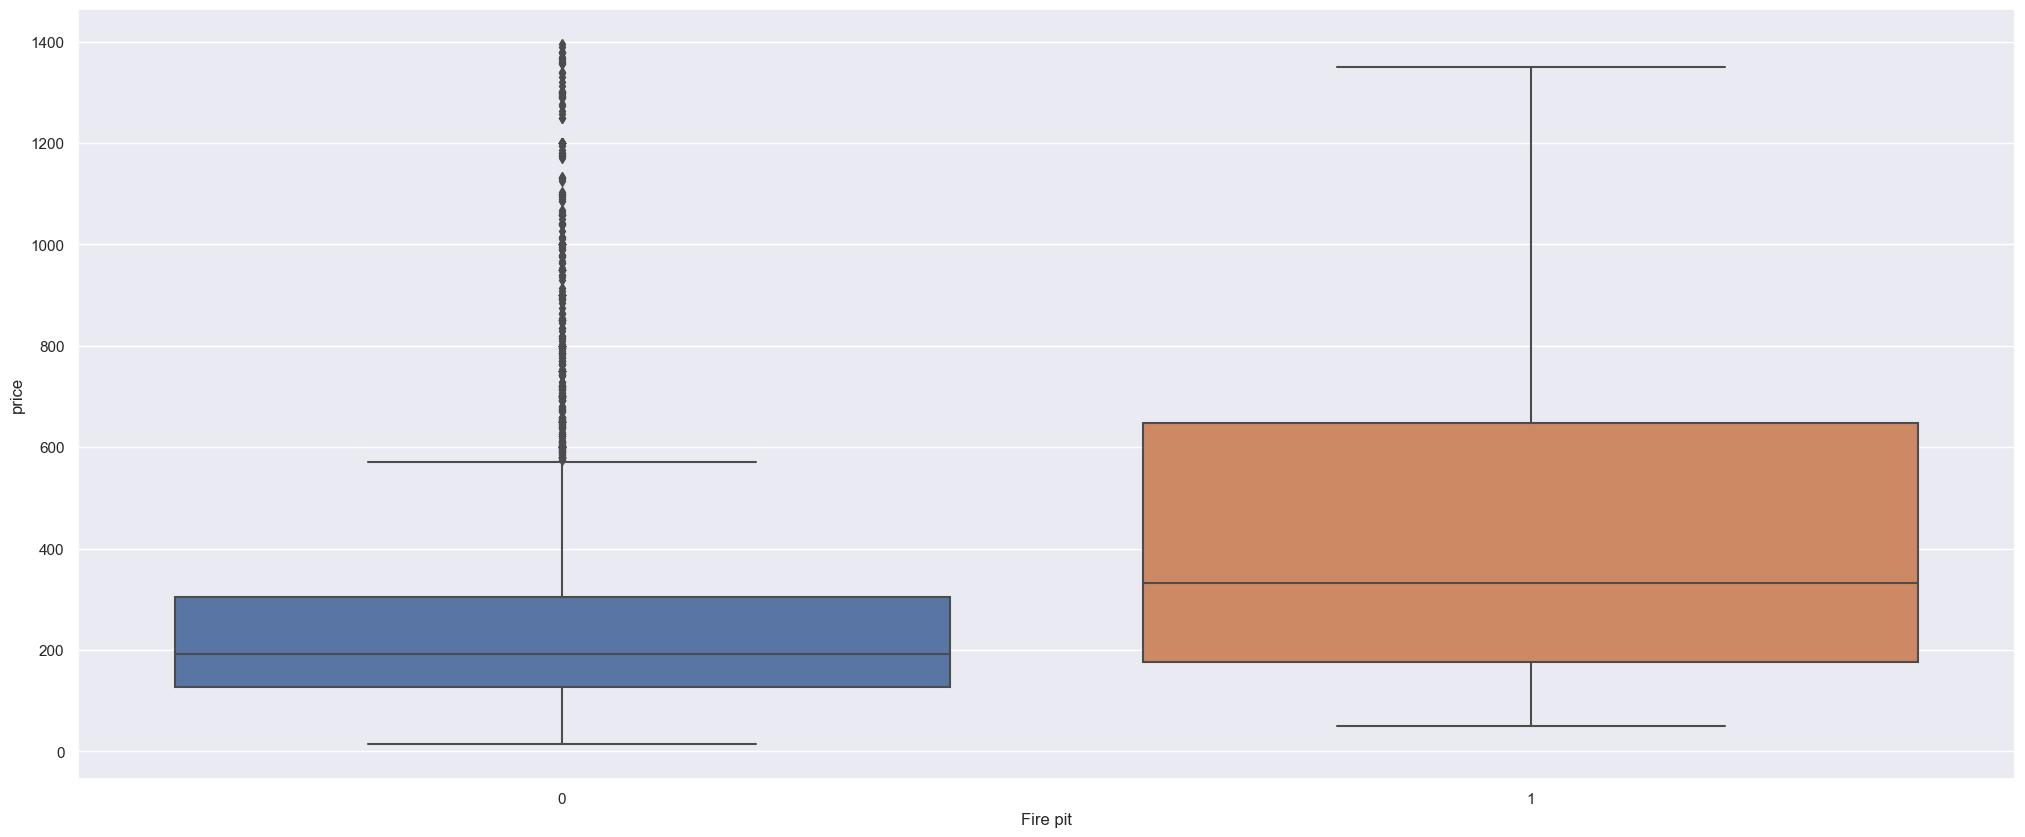

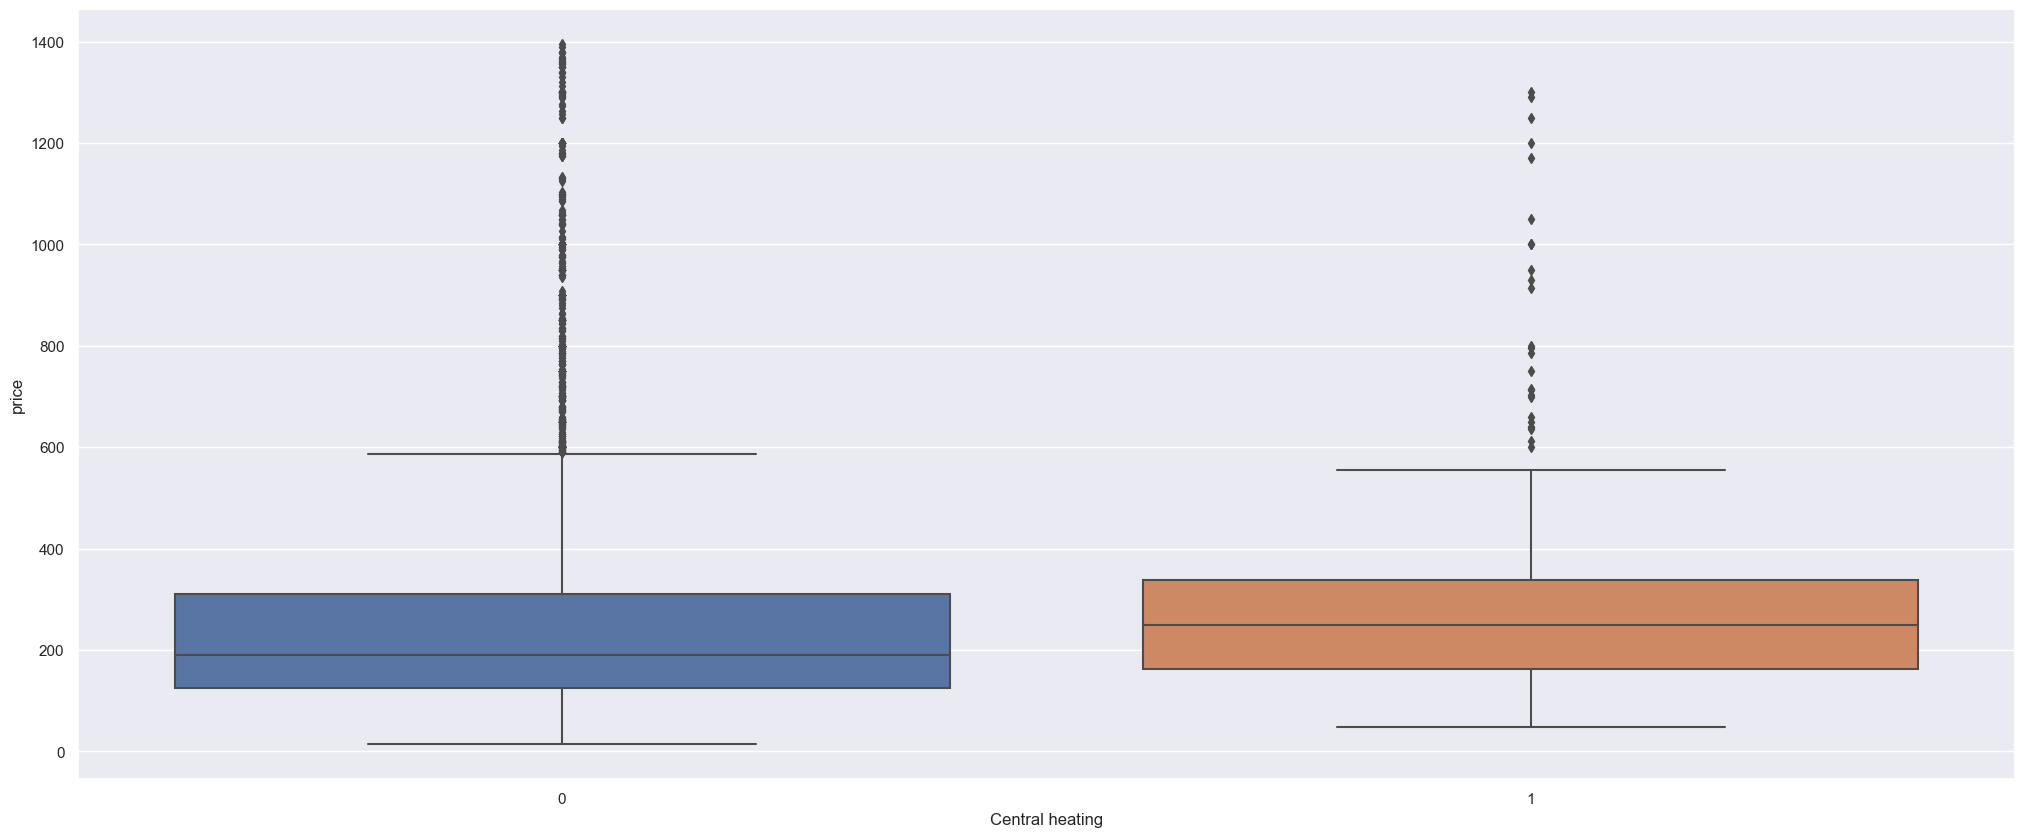

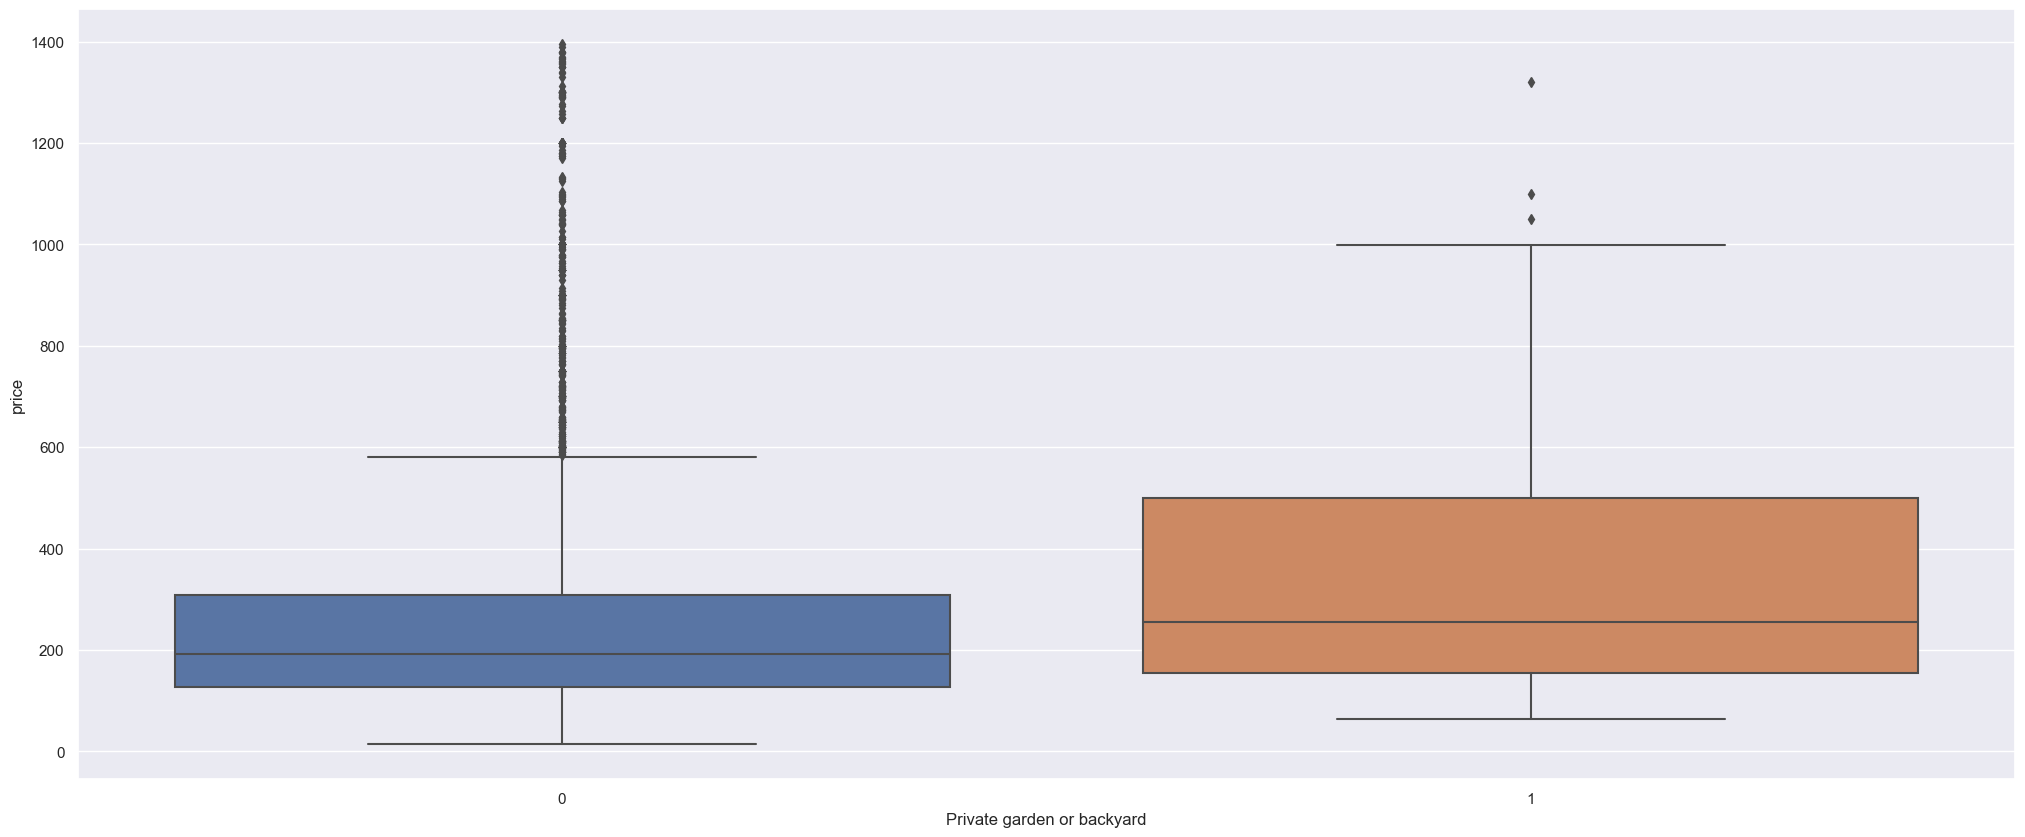

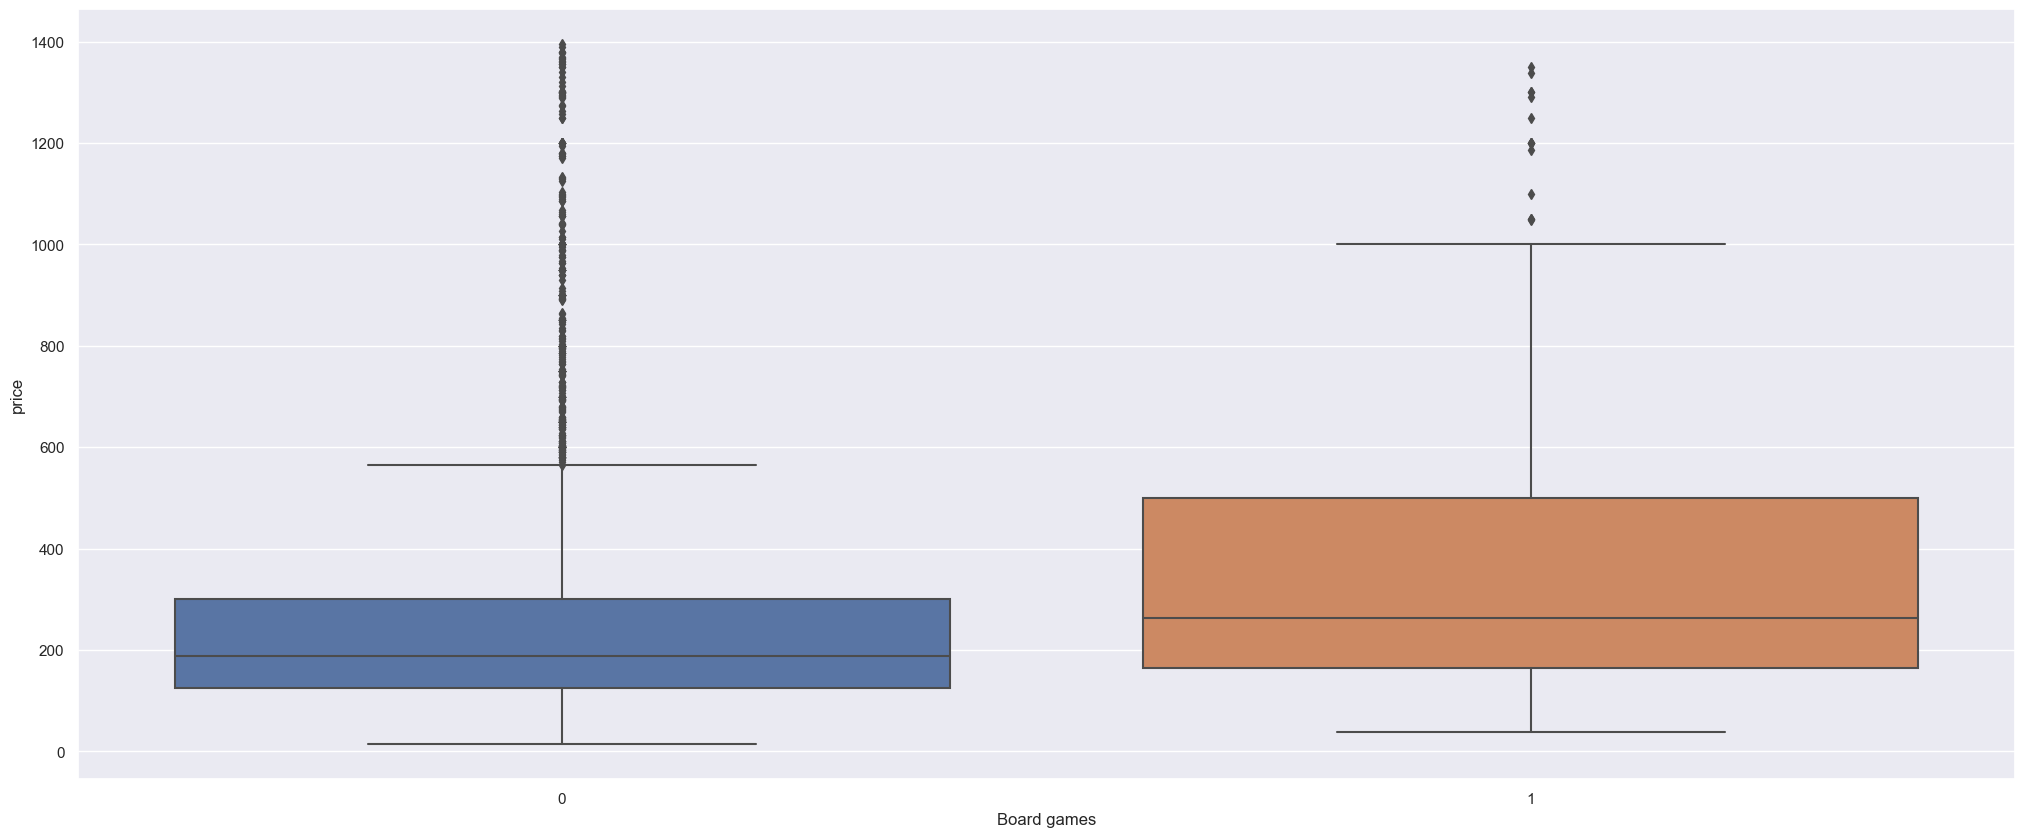

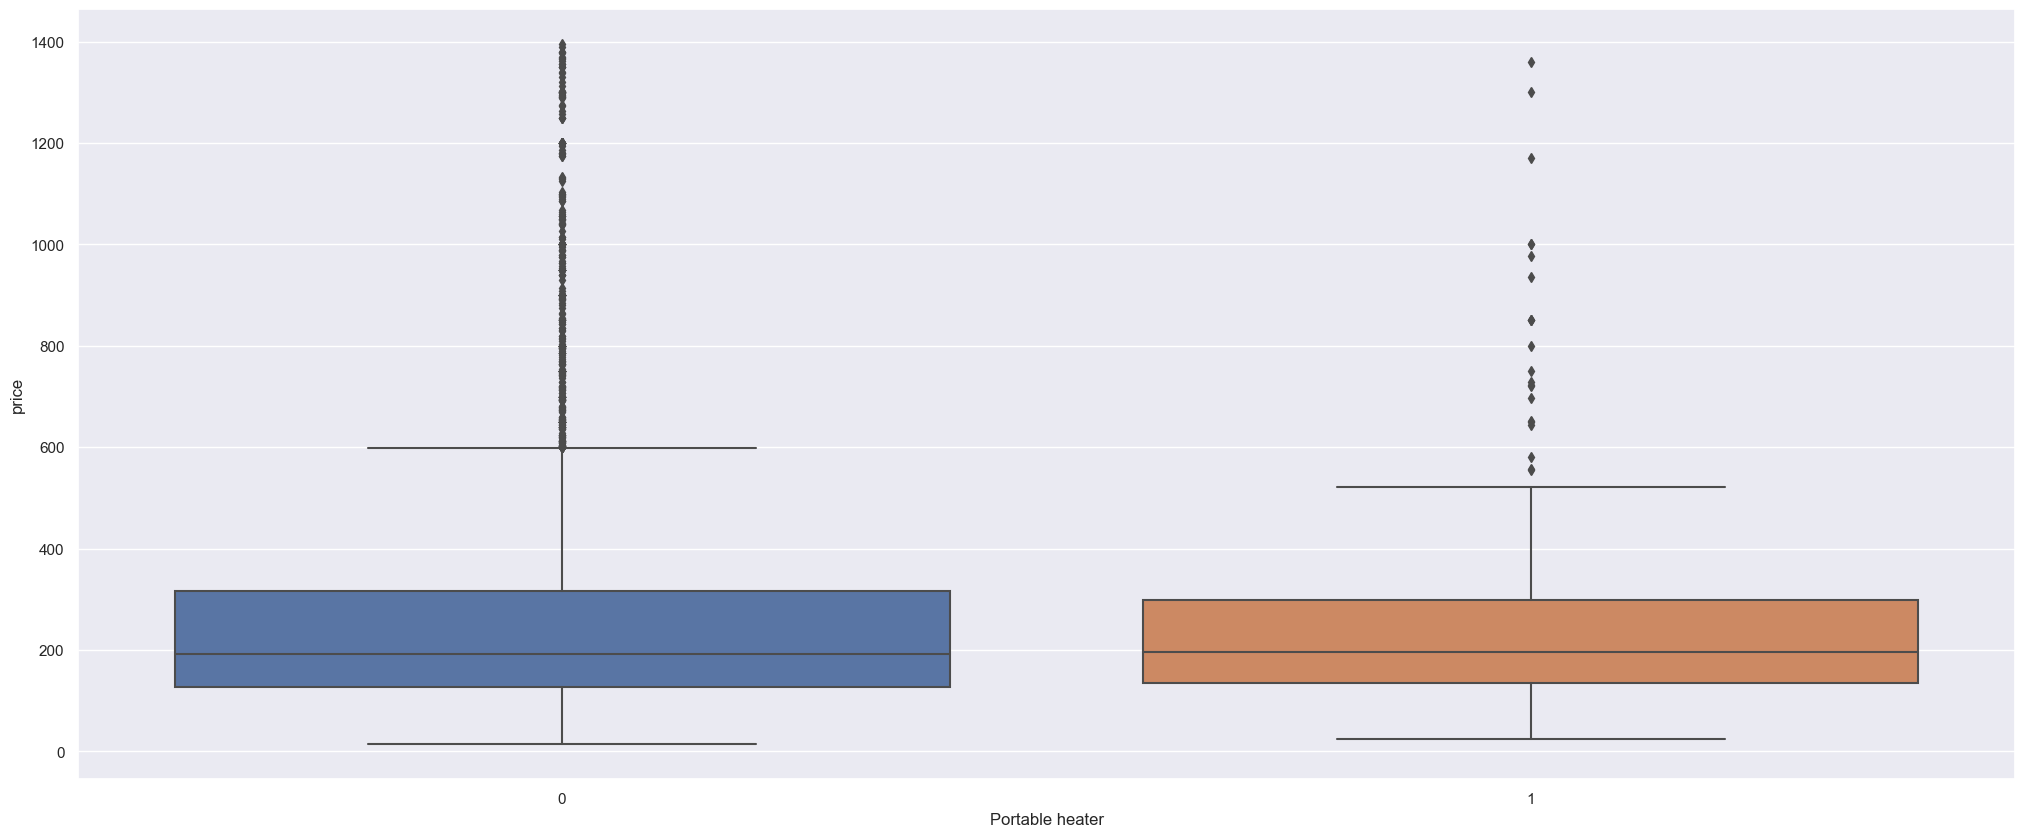

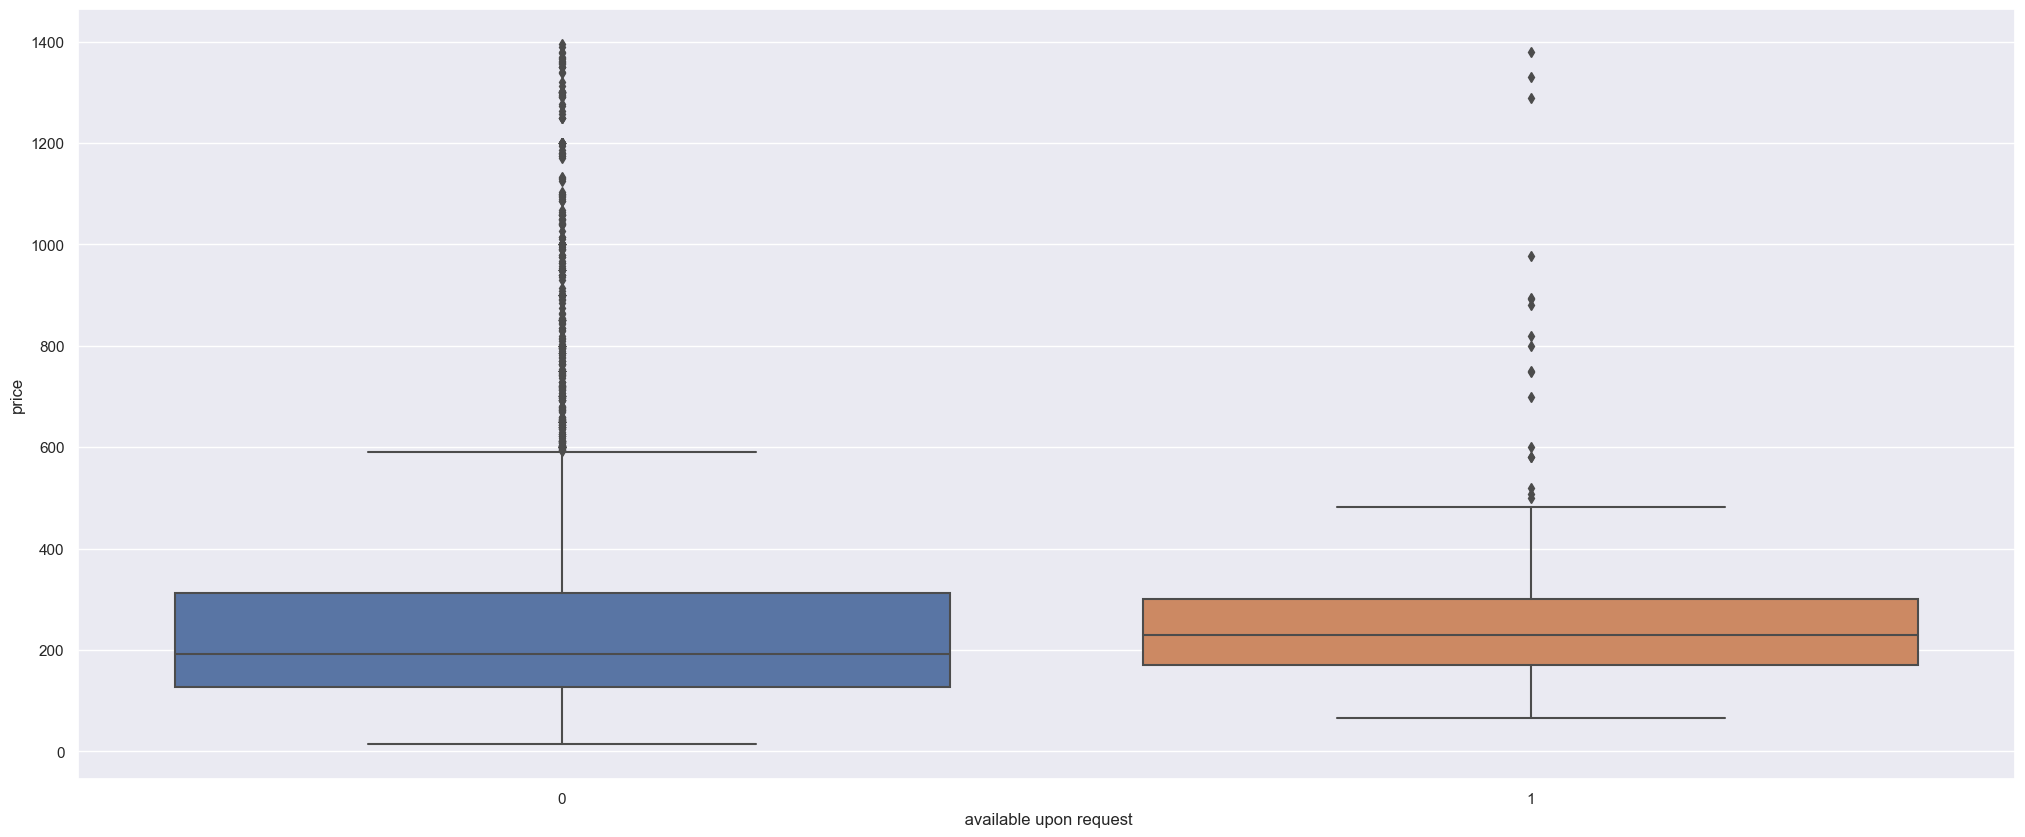

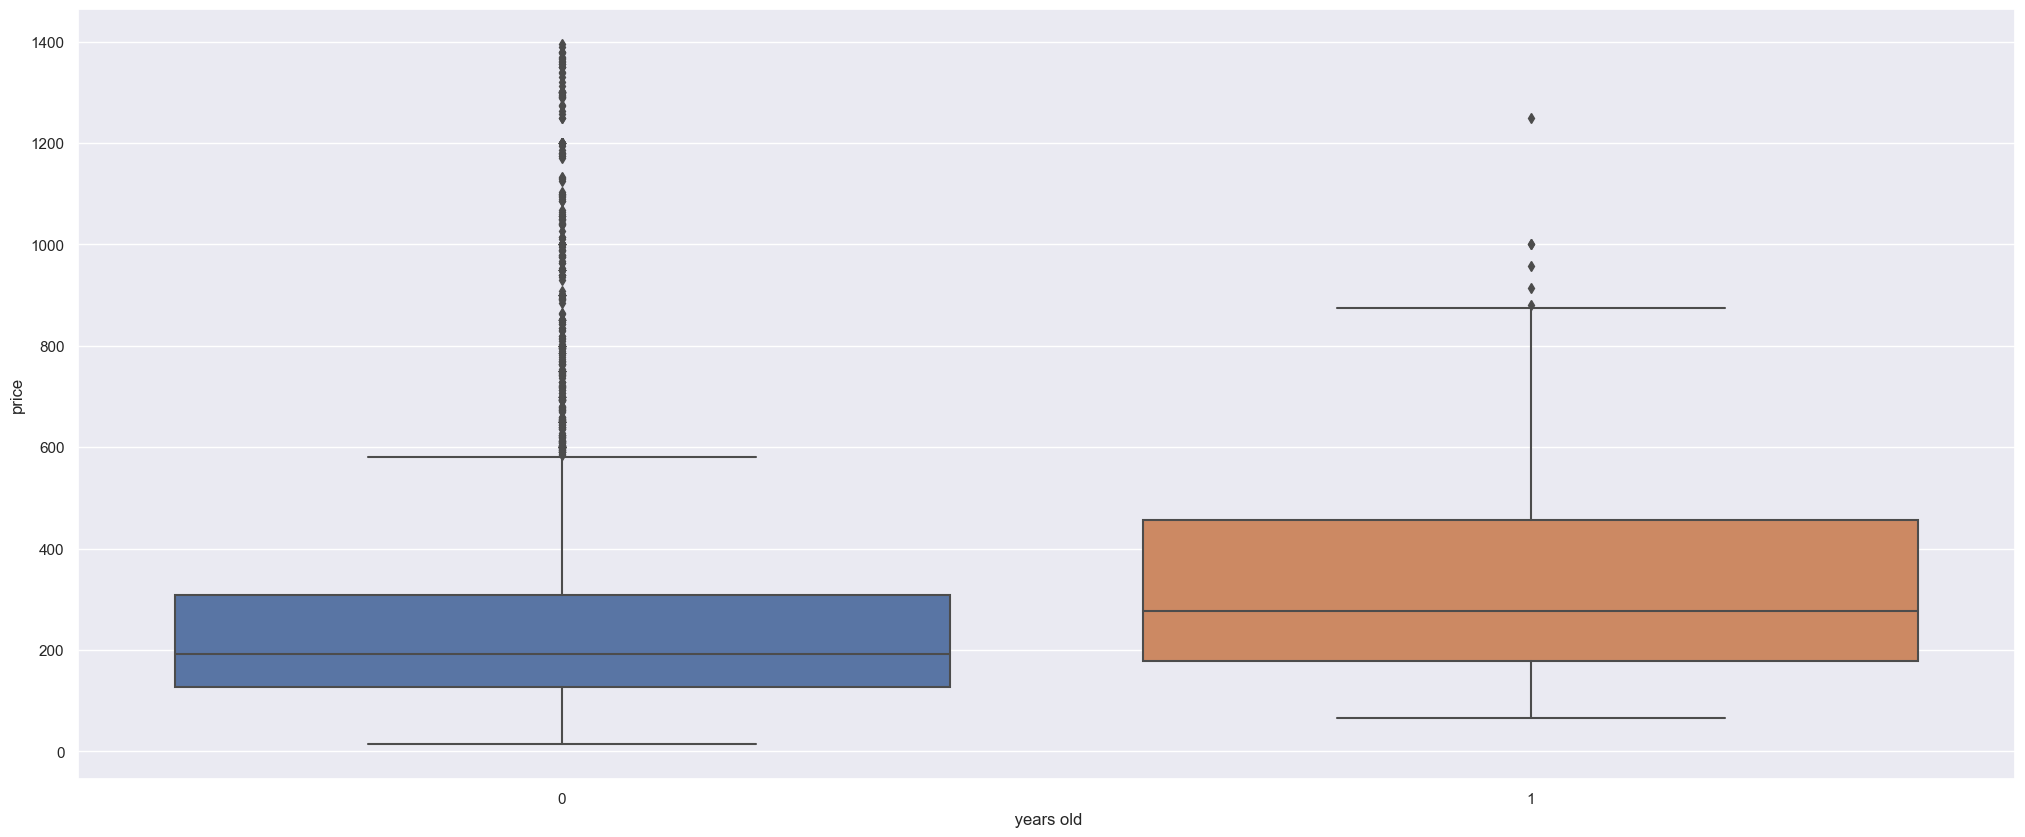

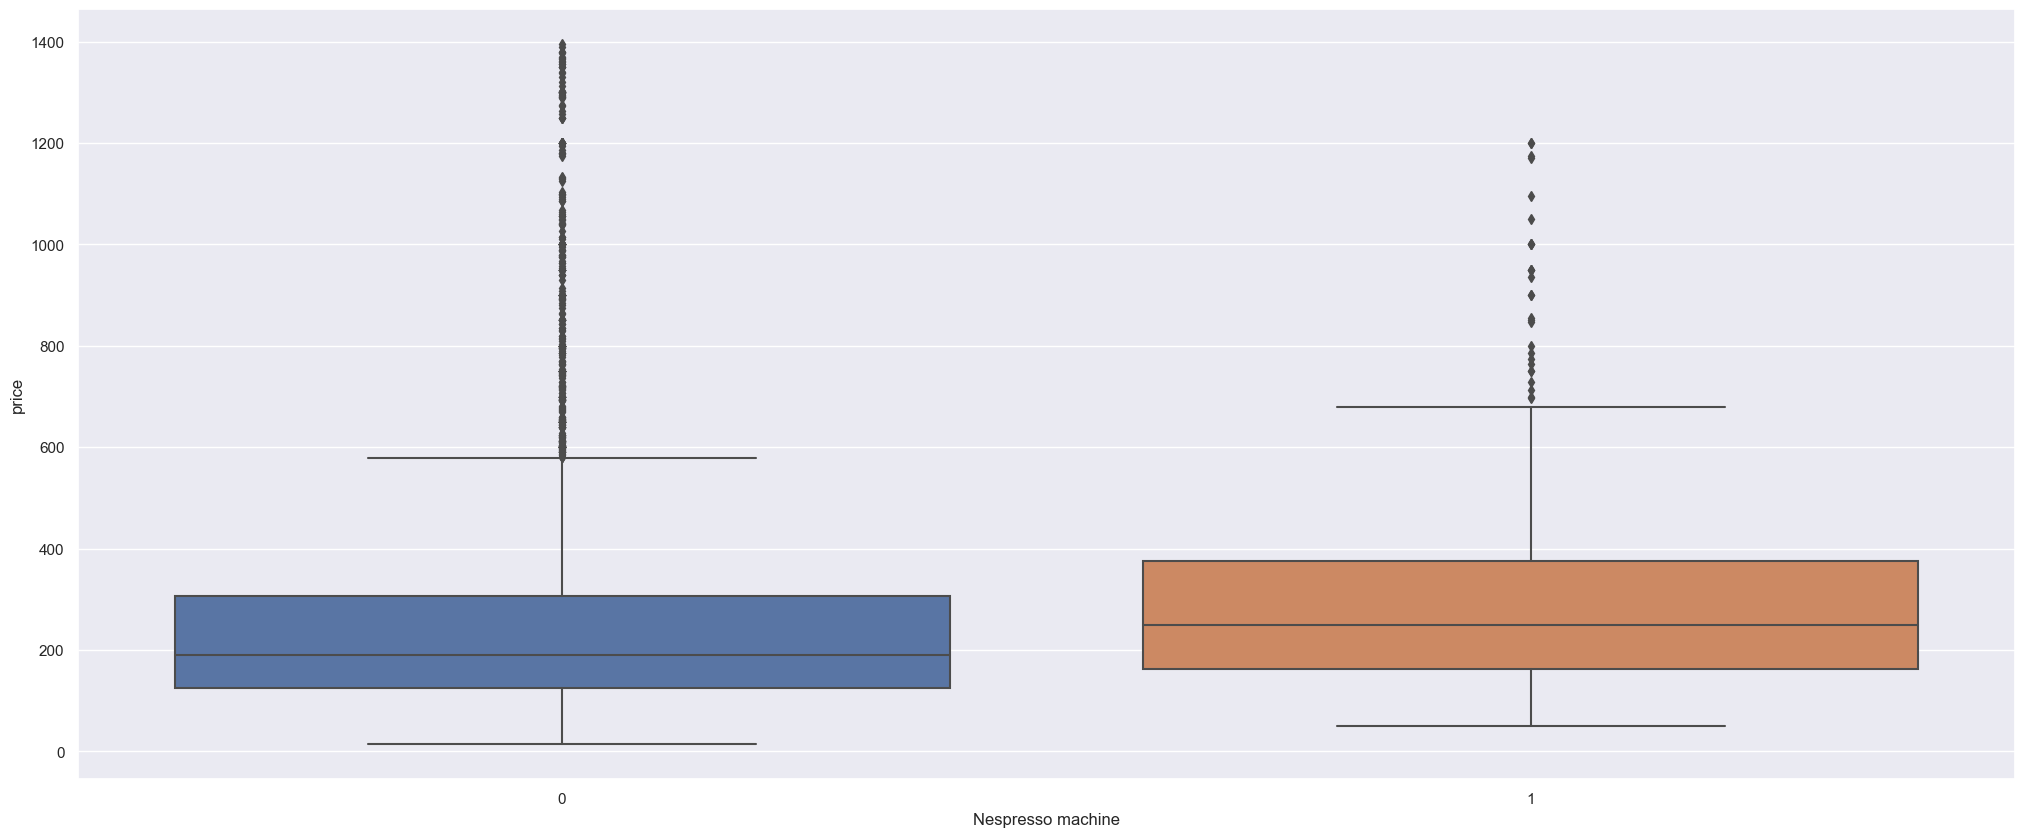

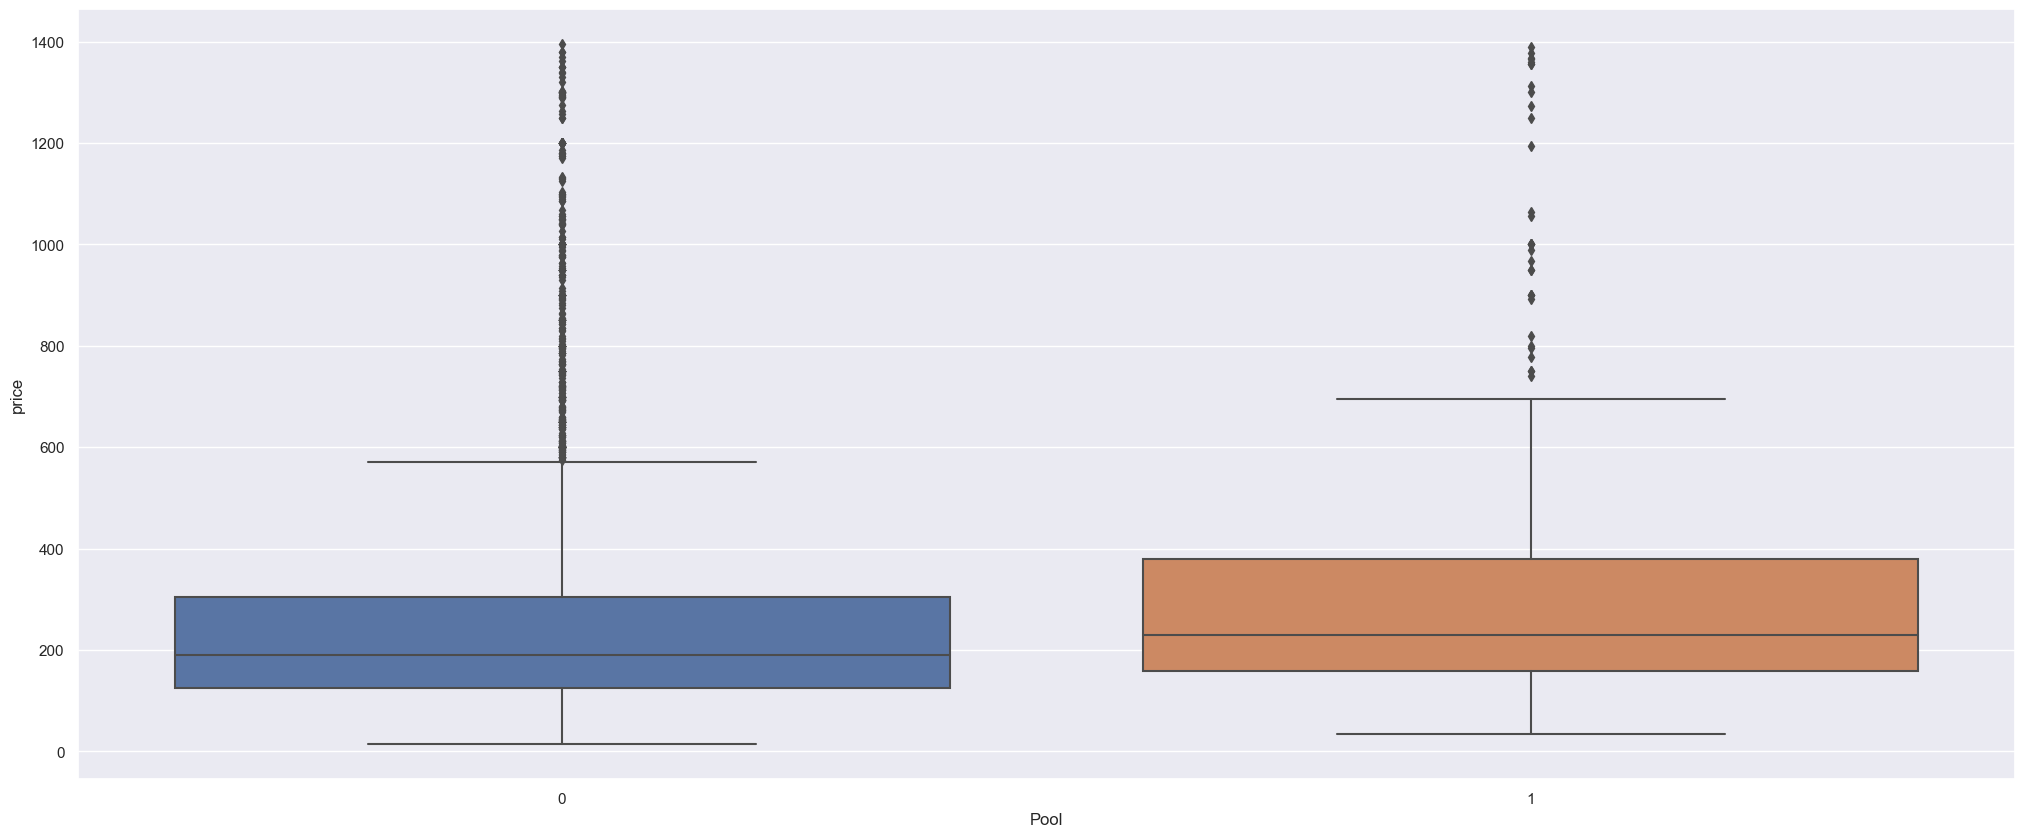

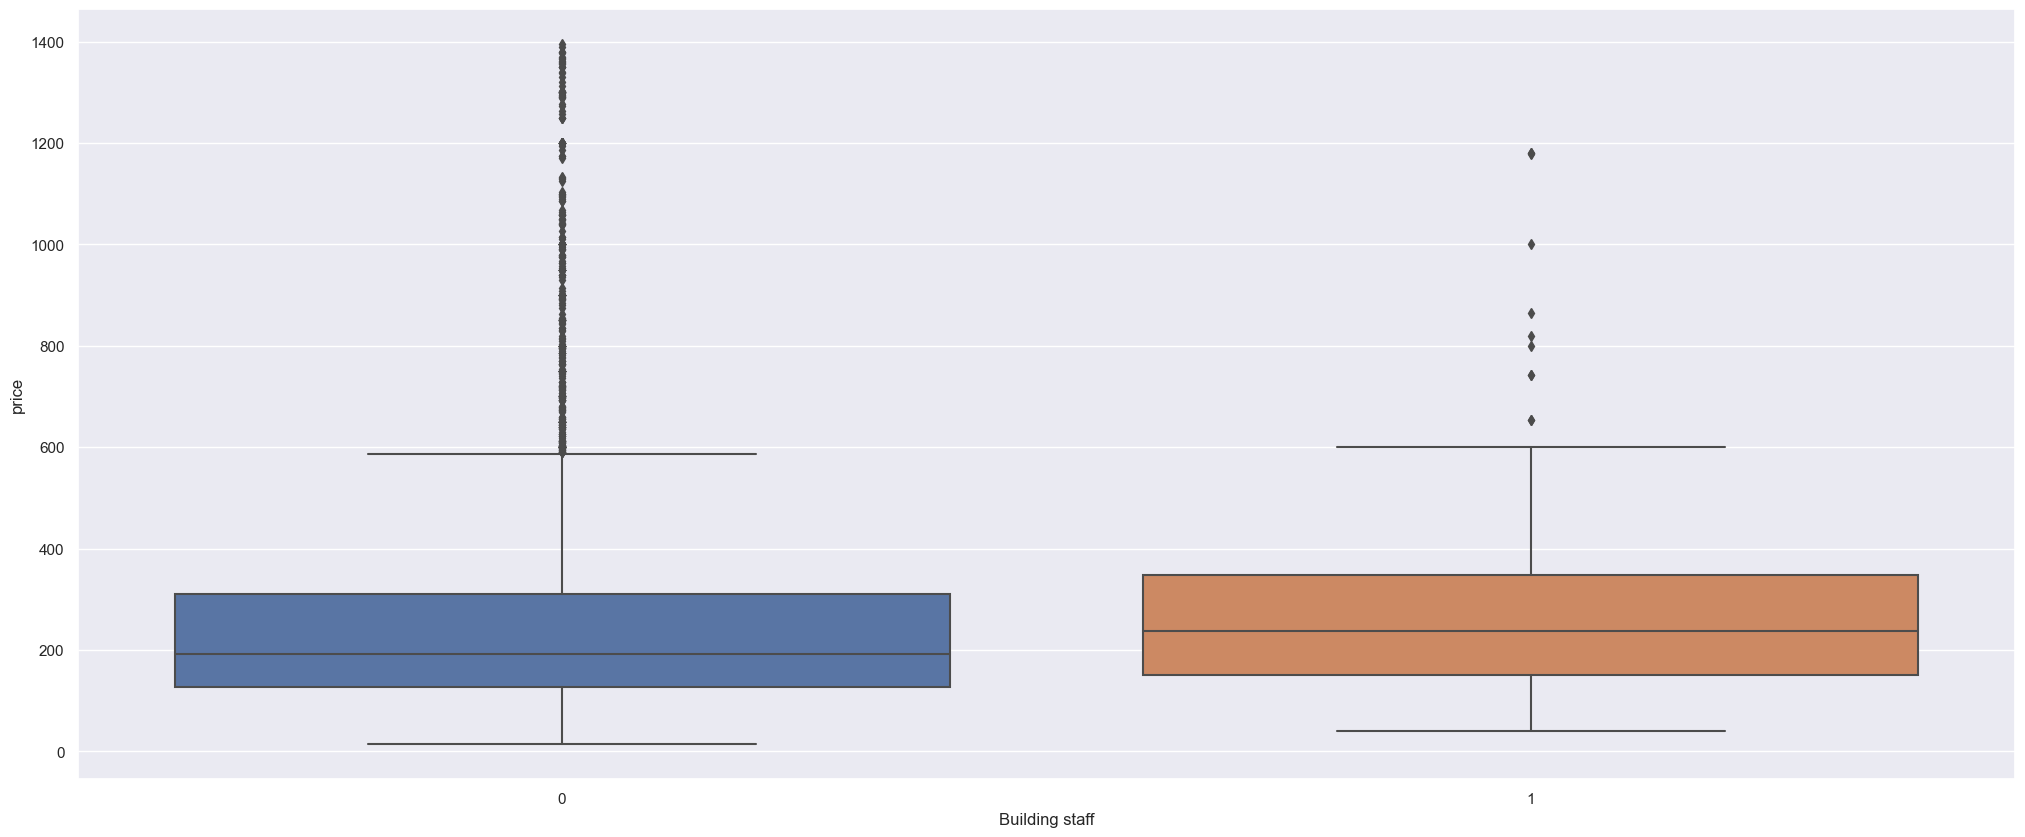

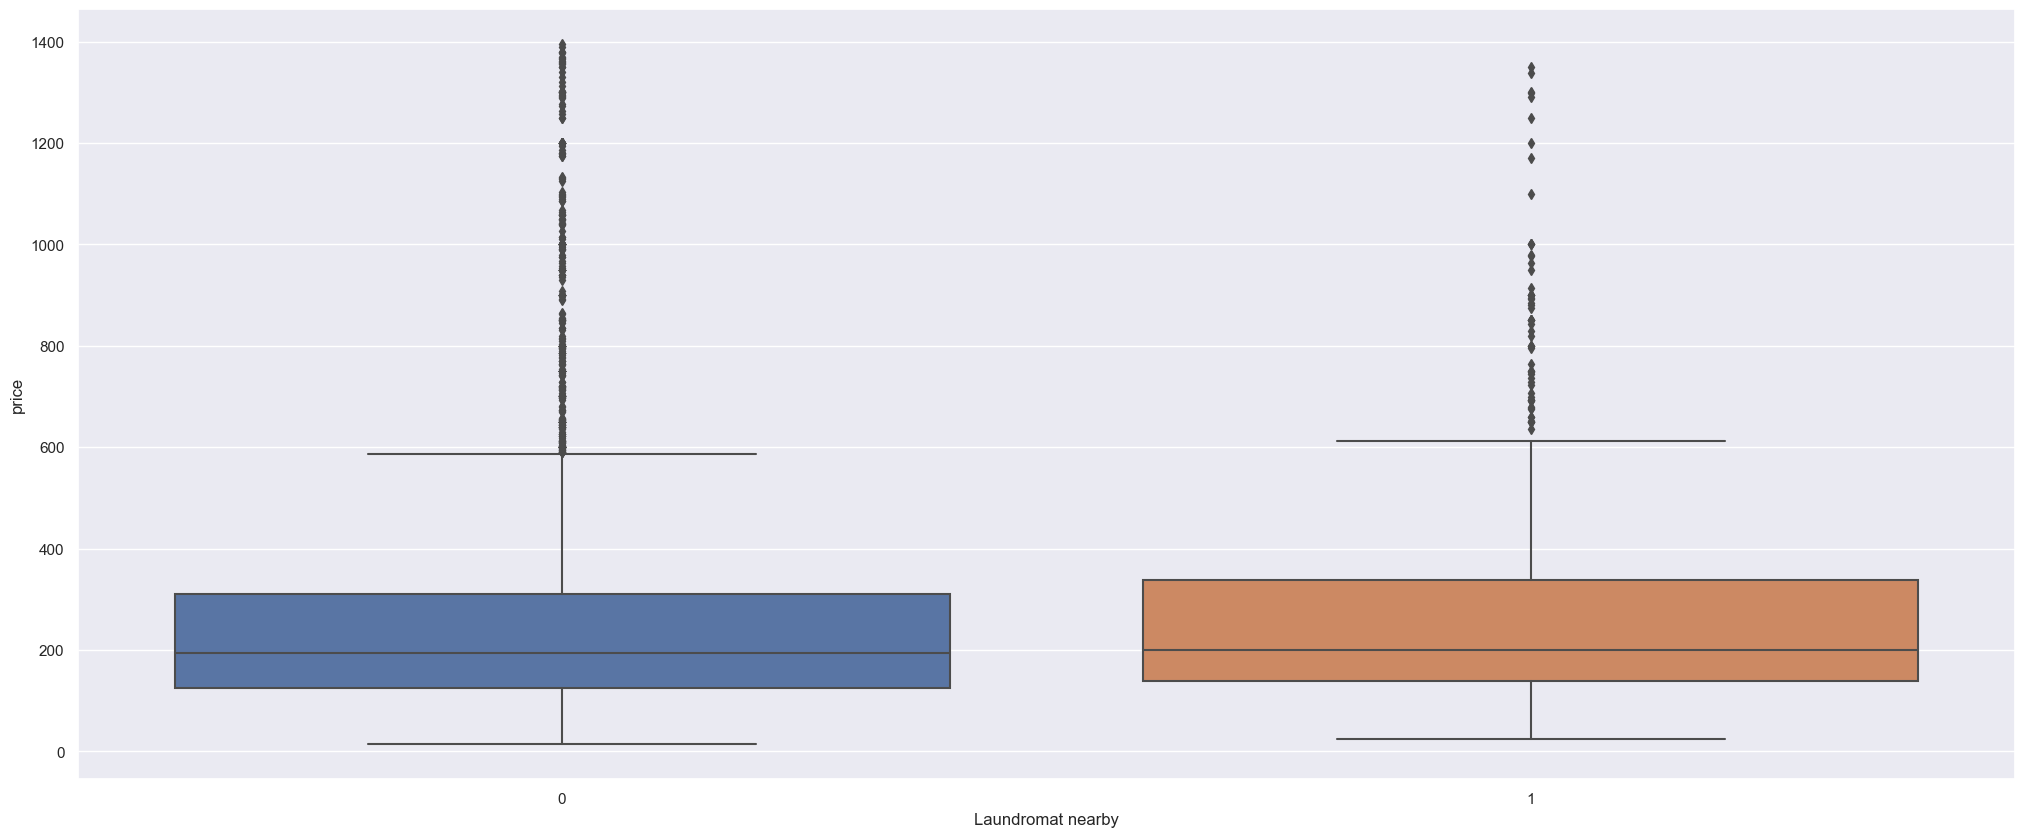

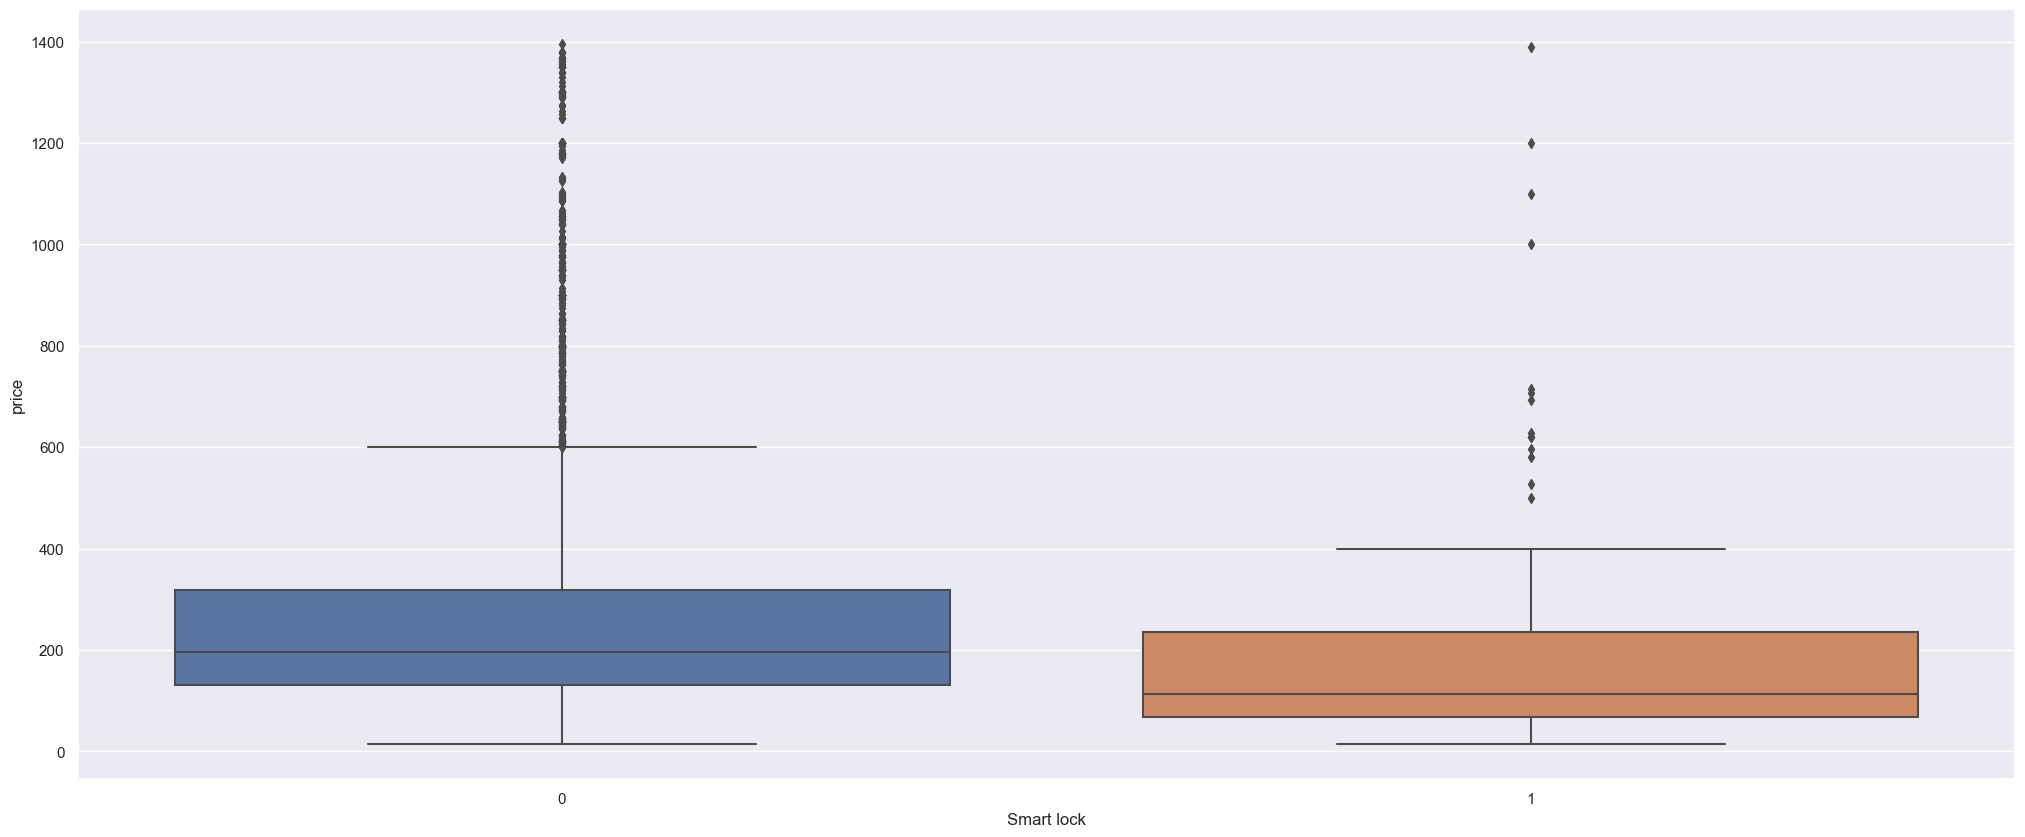

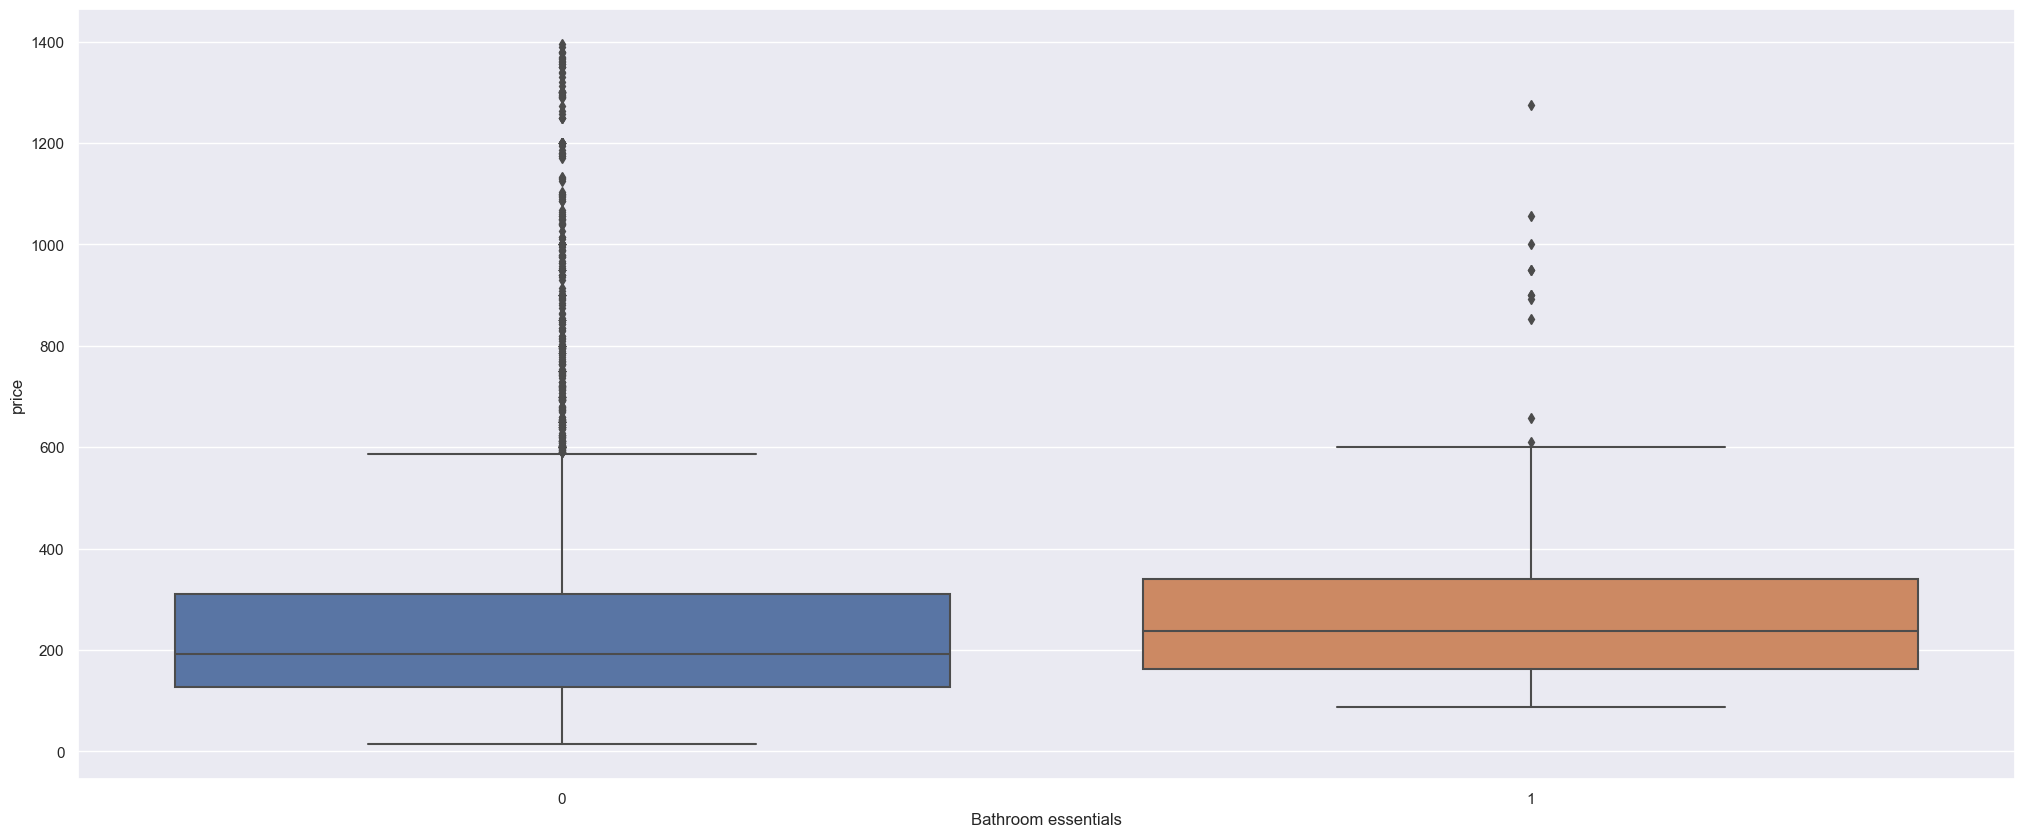

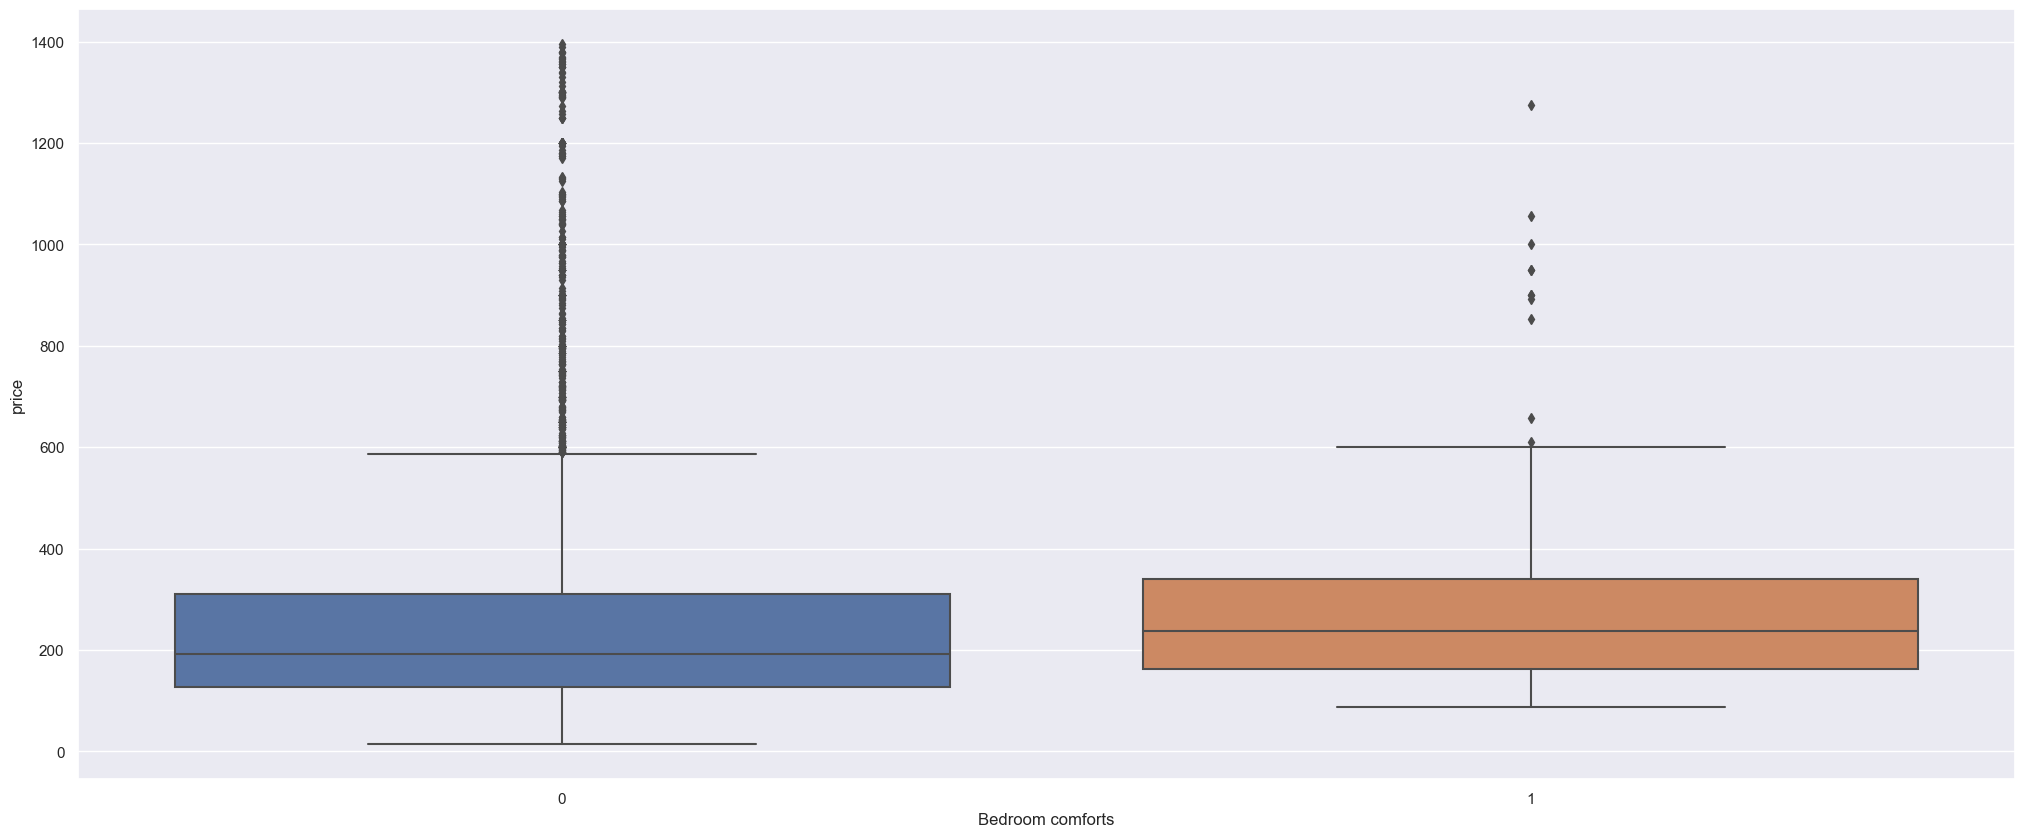

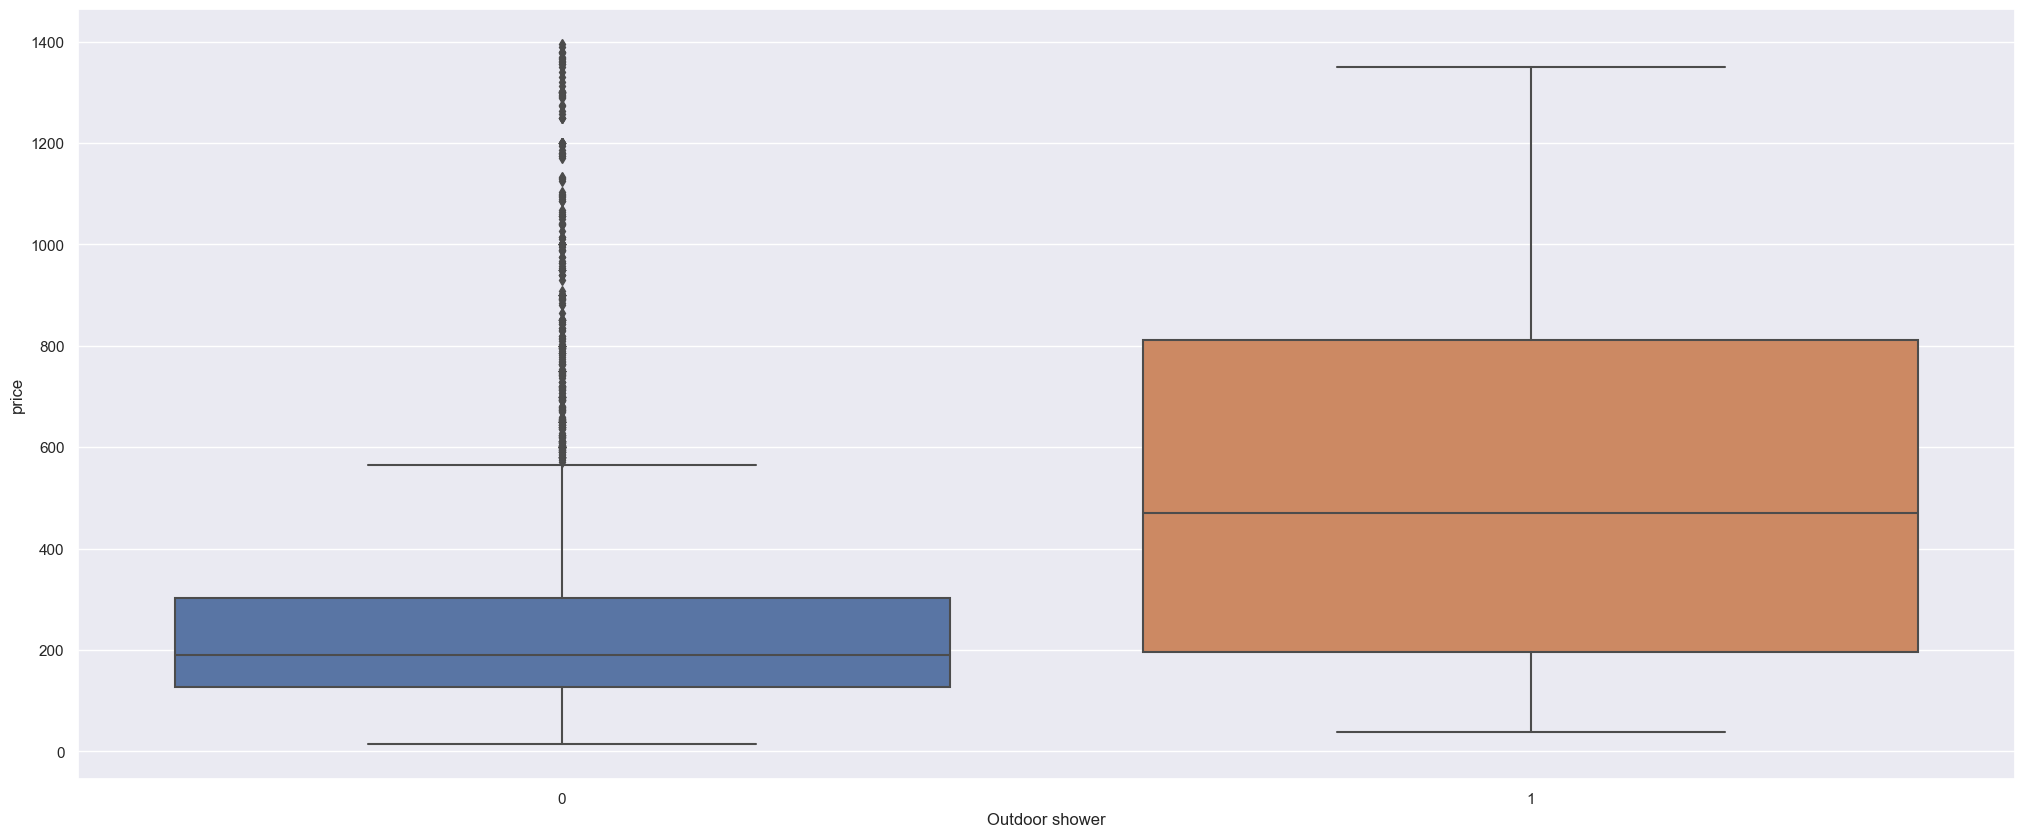

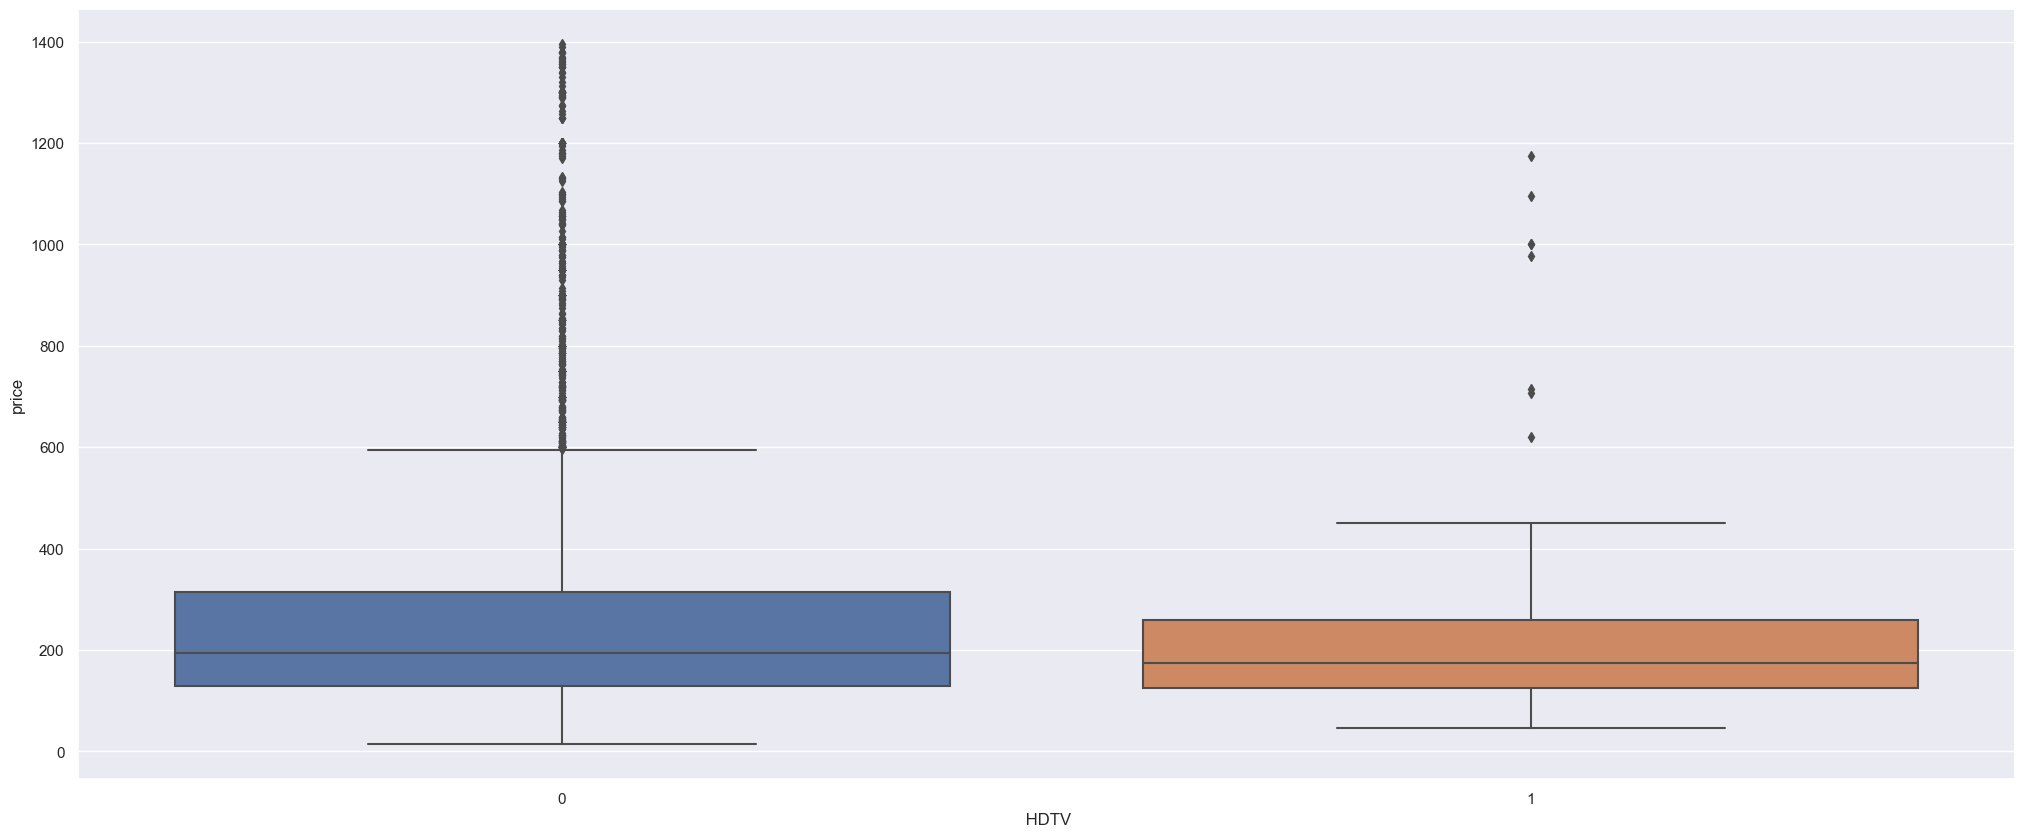

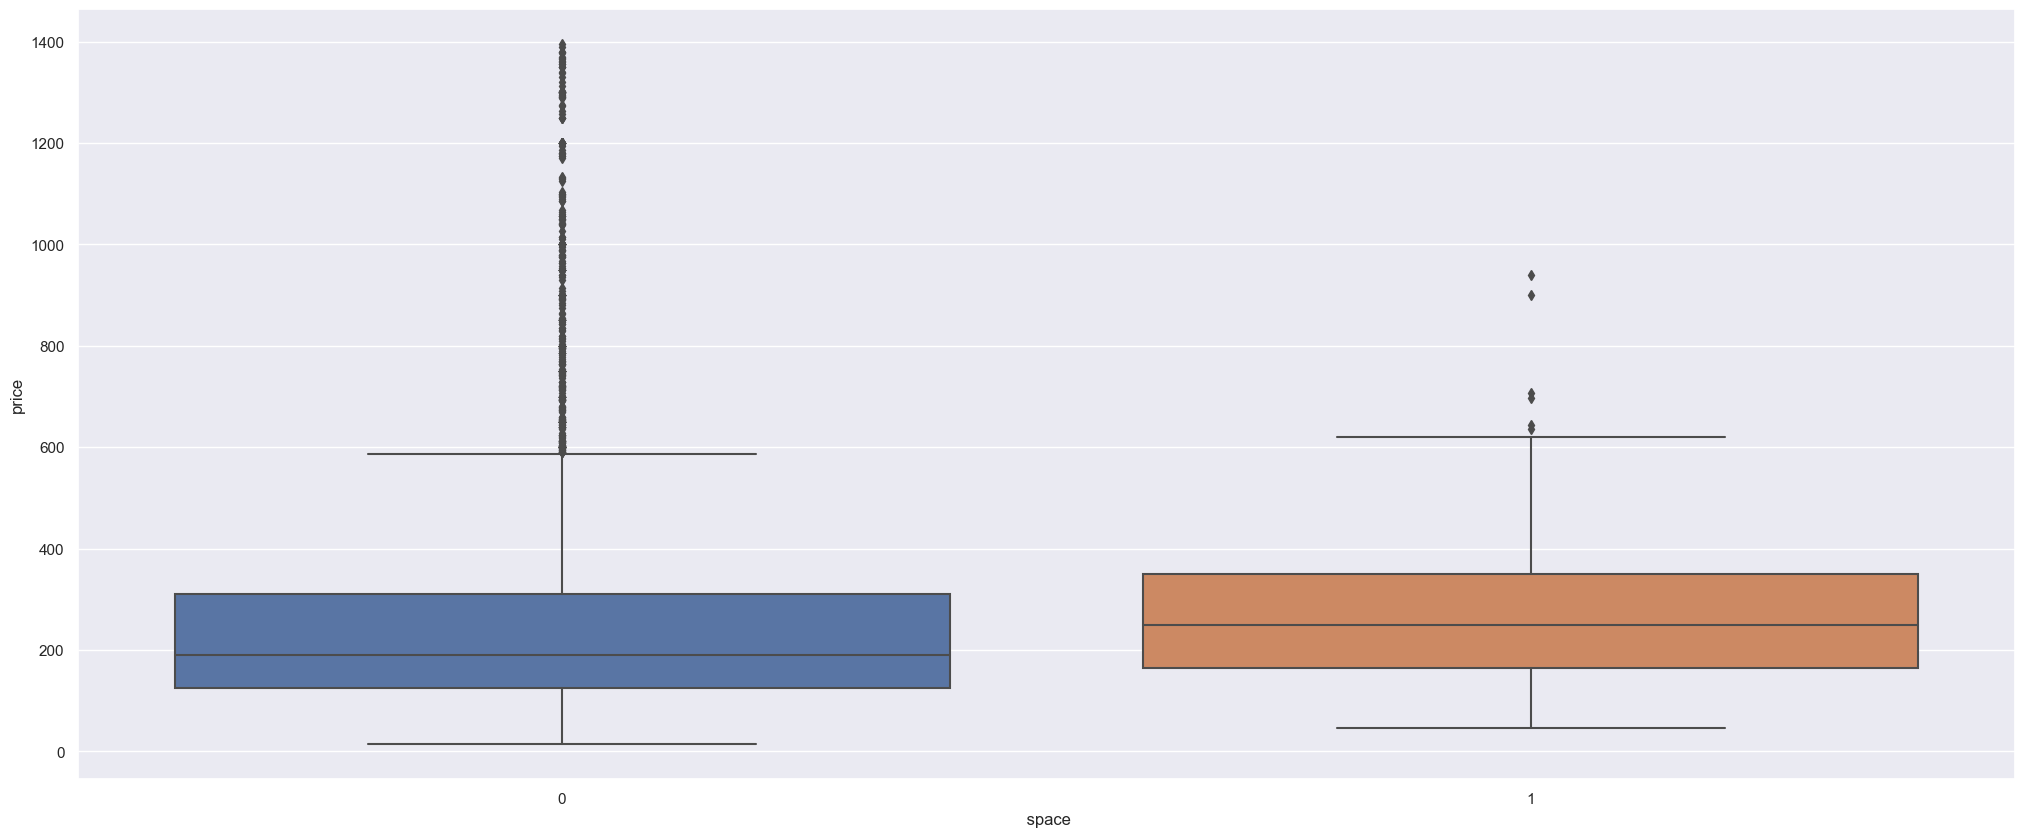

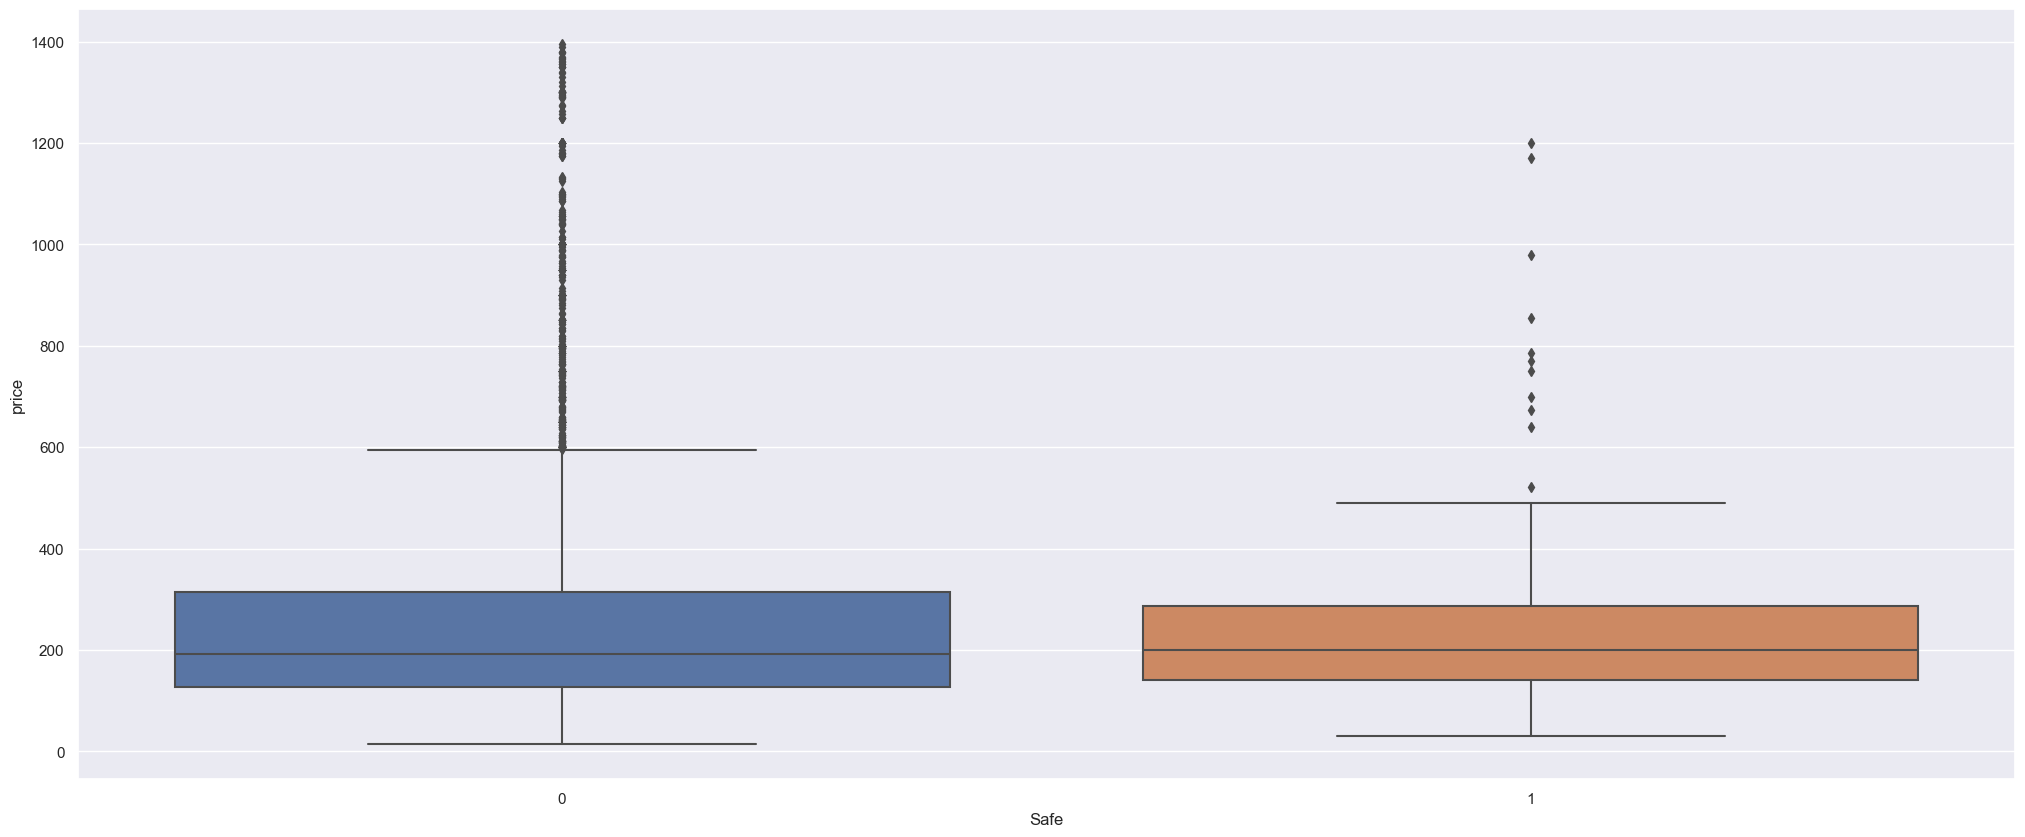

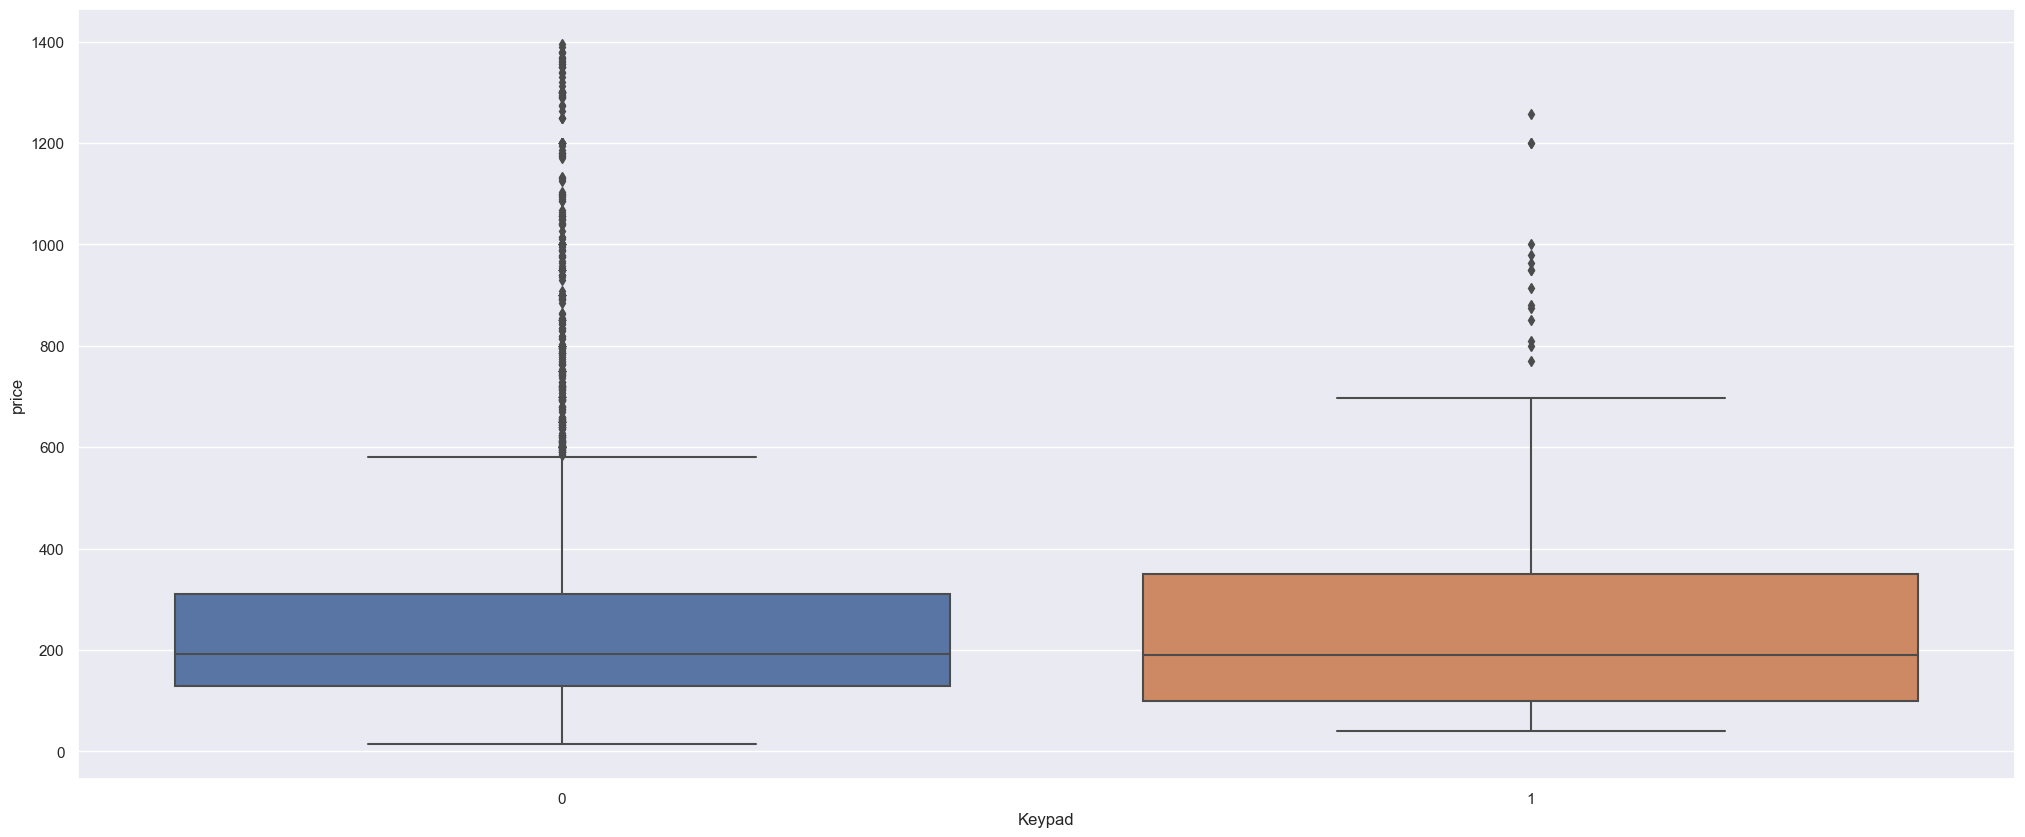

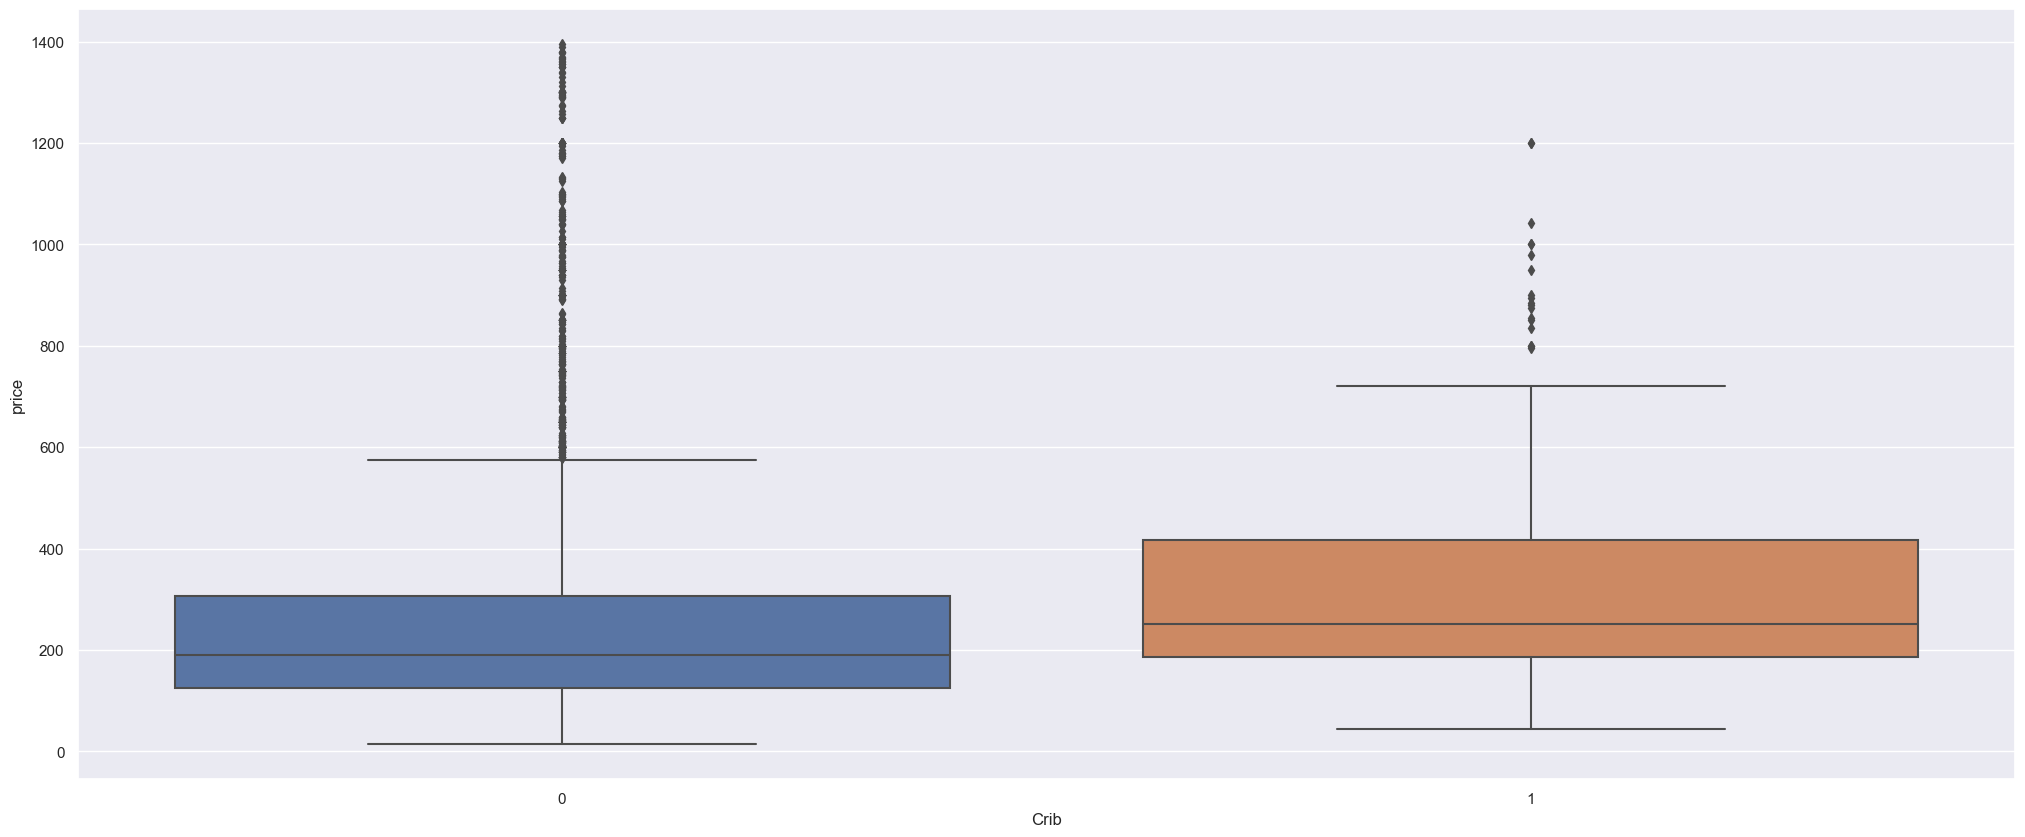

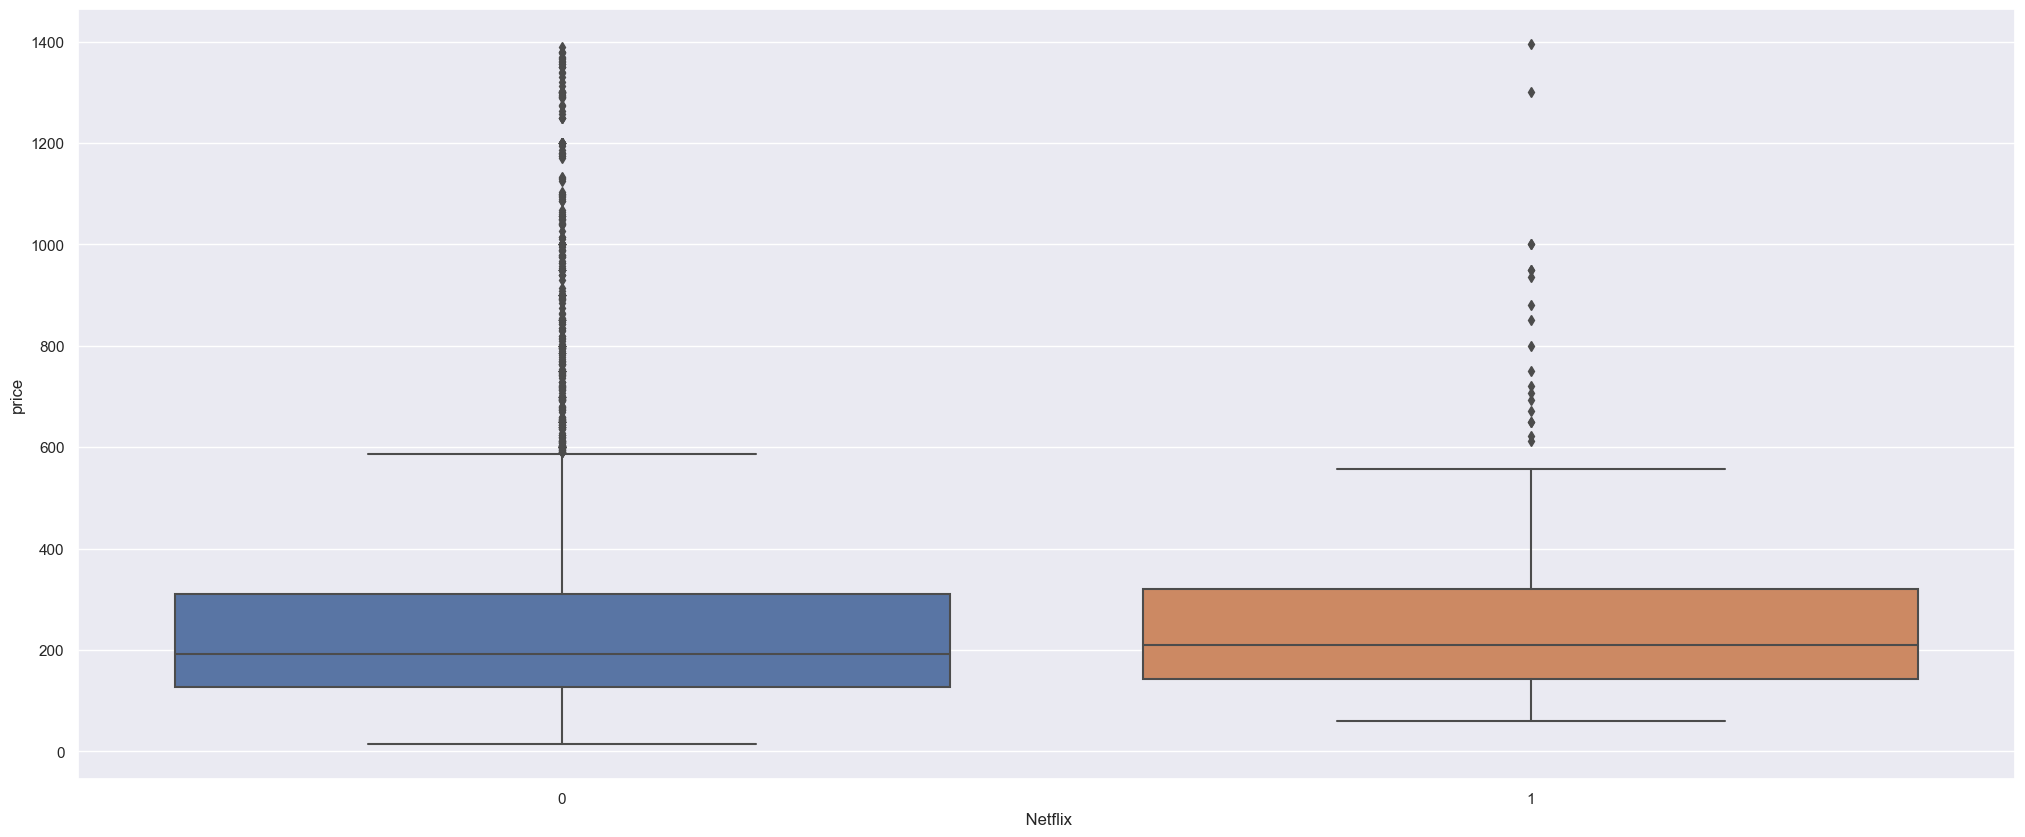

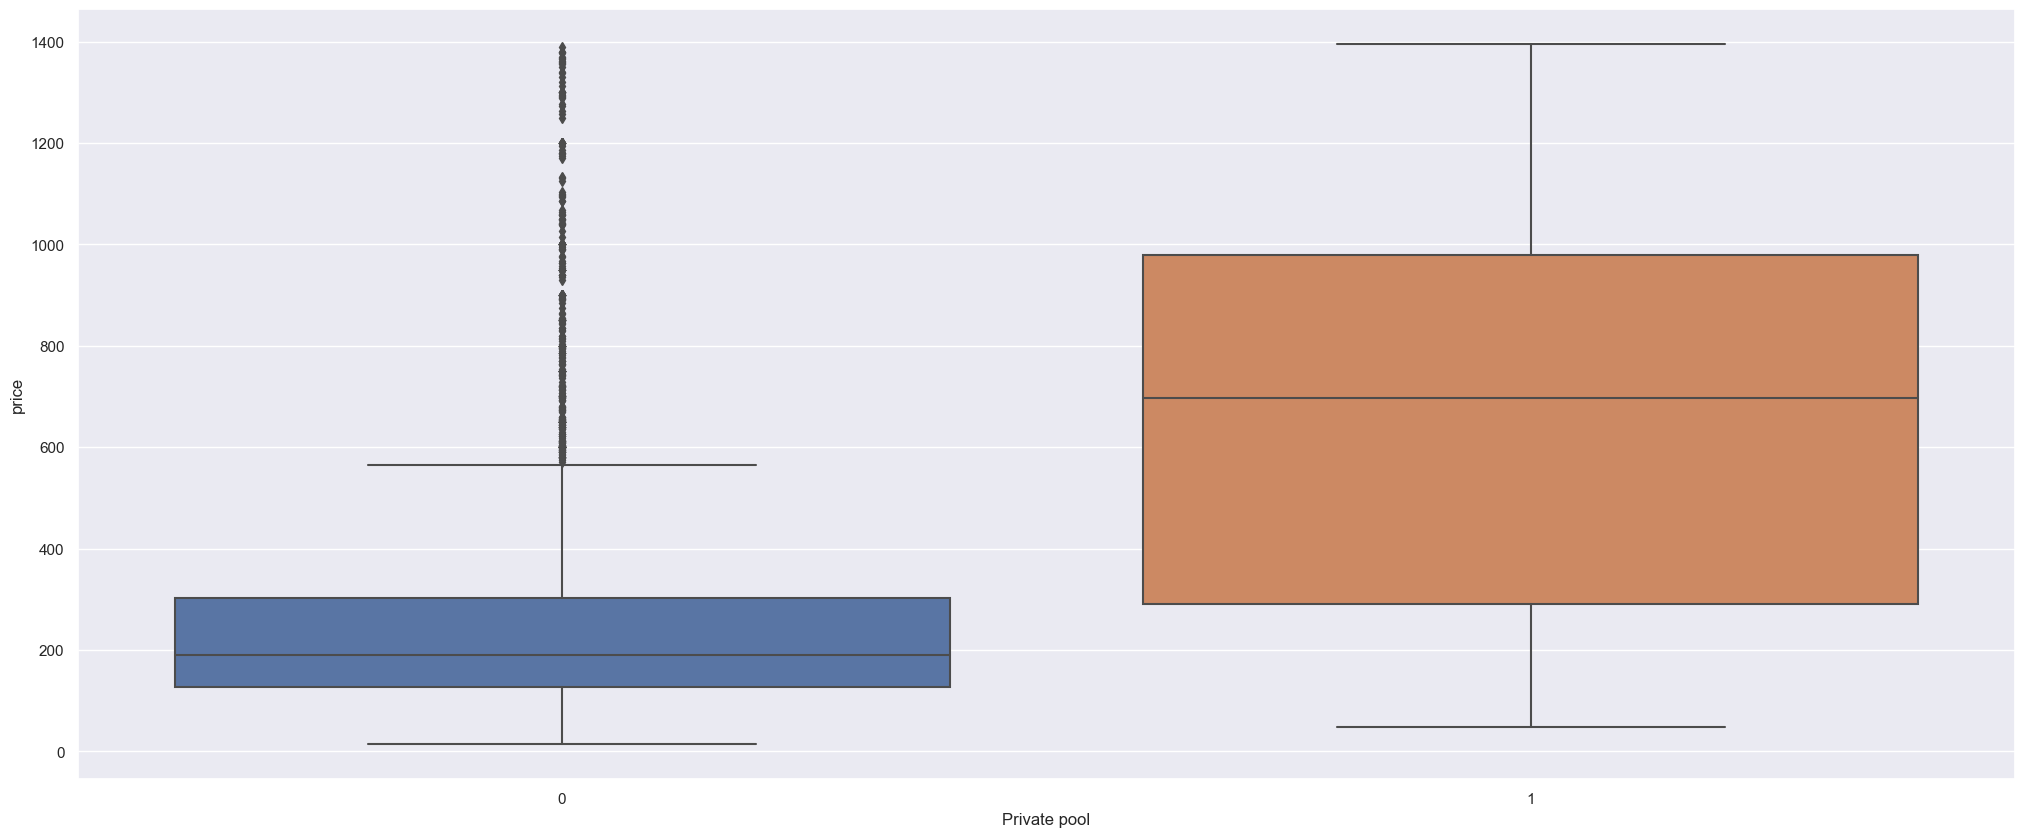

In [139]:
for i in range(len(attri)):
    sns.boxplot(x=am_train_4.apply(pd.Series)[attri[i]],y=train['price'])
    plt.show()

In [140]:
atti_filter =['Private pool','Outdoor shower','Fire pit','Waterfront','Beach essentials','Breakfast','Lock on bedroom door','Shared patio or balcony','Babysitter recommendations','Travel crib','Cable TV','TV with standard cable','Barbecue utensils',"Indoor fireplace",'Private fenced garden or backyard','s books and toys','s dinnerware','High chair']

In [141]:
def one_hot_1(lst):
    cache = {}
    for i in atti_filter:
        cache[i] = int(i in lst)
    return cache

am_train_5=am_train_3.apply(one_hot_1)
am_test_5=am_test_3.apply(one_hot_1)

In [145]:
train = pd.concat([train,am_train_5.apply(pd.Series)],axis=1)
train = train.drop('amenities',axis=1)

test = pd.concat([test,am_test_5.apply(pd.Series)],axis=1)
test = test.drop('amenities',axis=1)


### host_response_time

In [146]:
#replace each catogory to number in order
train['host_response_time'].replace(['within an hour','within a few hours','within a day','a few days or more'],
                               [0,1,2,3],inplace=True)
test['host_response_time'].replace(['within an hour','within a few hours','within a day','a few days or more'],
                               [0,1,2,3],inplace=True)

### host_is_superhost & host_identity_verified&instant_bookable

In [147]:
#replace each catogory to number in order
train['host_is_superhost'].replace(['f','t'],[0,1],inplace=True)
test['host_is_superhost'].replace(['f','t'],[0,1],inplace=True)
train['host_identity_verified'].replace(['f','t'],[0,1],inplace=True)
test['host_identity_verified'].replace(['f','t'],[0,1],inplace=True)
train['instant_bookable'].replace(['f','t'],[0,1],inplace=True)
test['instant_bookable'].replace(['f','t'],[0,1],inplace=True)

### host_since

In [148]:
train["host_since"]

0       2016-04-15
1       2021-06-16
2       2017-10-05
3       2016-09-26
4       2019-01-04
           ...    
3995    2021-07-06
3996    2019-05-19
3997    2018-01-10
3998    2016-07-12
3999    2017-10-02
Name: host_since, Length: 4000, dtype: object

In [149]:
train["host_since"] = pd.DatetimeIndex(train["host_since"]).year
test["host_since"] = pd.DatetimeIndex(test["host_since"]).year
train["host_since"]

0       2016
1       2021
2       2017
3       2016
4       2019
        ... 
3995    2021
3996    2019
3997    2018
3998    2016
3999    2017
Name: host_since, Length: 4000, dtype: int64

### Drop uneless columns

In [150]:
drop_column = ['host_is_superhost','host_identity_verified'
               #,'minimum_nights','maximum_nights','review_scores_value','review_scores_communication','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin'
               #,'amenities'
               ,'description','neighborhood_overview', 'id'
               ]

In [151]:
for i in drop_column:
    train = train.drop( i ,axis=1)
    test = test.drop( i ,axis=1)

In [152]:
Y_train = train['price']
Y_train_log = np.log(Y_train)

In [153]:
train =train.drop('price',axis = 1)

In [154]:
train

host_response_rate  host_acceptance_rate  host_since  \
0                   1.00                  0.75        2016   
1                   1.00                  0.94        2021   
2                   1.00                  0.98        2017   
3                   0.95                  1.00        2016   
4                   1.00                  0.97        2019   
...                  ...                   ...         ...   
3995                1.00                  0.49        2021   
3996                0.98                  0.93        2019   
3997                0.95                  0.71        2018   
3998                0.95                  1.00        2016   
3999                0.95                  0.93        2017   

      host_response_time  host_listings_count  latitude  longitude  \
0                      1                  1.0 -33.98233  151.23618   
1                      0                 32.0 -33.87019  151.19422   
2                      0                  2.0 -33.90163  151.21198   
3                      0                  1.0 -33.89327  151.25463   
4                      0                  2.0 -33.86902  151.20504   
...                  ...                  ...       ...        ...   
3995                   1                  1.0 -33.89289  151.27077   
3996                   0                 10.0 -33.93403  151.15383   
3997                   0                 68.0 -33.89061  151.28271   
3998                   0                  2.0 -33.95479  151.03370   
3999                   2                  2.0 -33.93937  151.13666   

      accommodates  bedrooms  beds  minimum_nights  maximum_nights  \
0                3       2.0   2.0               2             365   
1                4       2.0   3.0               2             365   
2                4       2.0   4.0               3              30   
3                6       3.0   3.0               7              14   
4                5       2.0   3.0               1            1125   
...            ...       ...   ...             ...             ...   
3995            12       4.0   2.0               2             365   
3996             2       1.0   1.0               1            1125   
3997             4       1.0   2.0              90            1125   
3998             2       1.0   1.0              90            1125   
3999             2       1.0   1.0               4             120   

      number_of_reviews  review_scores_rating  review_scores_accuracy  \
0                     4                  5.00                    5.00   
1                    14                  4.07                    4.36   
2                   229                  4.94                    4.96   
3                     2                  5.00                    5.00   
4                   247                  4.74                    4.85   
...                 ...                   ...                     ...   
3995                  6                  5.00                    5.00   
3996                 20                  4.60                    4.70   
3997                 19                  4.79                    4.84   
3998                 65                  4.60                    4.59   
3999                 38                  4.68                    4.79   

      review_scores_cleanliness  review_scores_checkin  \
0                          5.00                   4.75   
1                          3.64                   4.57   
2                          4.96                   4.86   
3                          4.50                   5.00   
4                          4.82                   4.49   
...                         ...                    ...   
3995                       5.00                   5.00   
3996                       4.70                   4.85   
3997                       4.84                   5.00   
3998                       4.49                   4.77   
3999                       4.63                   4.87   

     

## <font color = '#e64626'><a id='methodology'>4. Methodology</a></font>

### <font color = '#e64626'><a id='model_1'>4.1. Model 1: Ridge</a></font>

In [155]:
ridge_train = train.copy()
ridge_test = test.copy()

In [156]:
ridge_train

host_response_rate  host_acceptance_rate  host_since  \
0                   1.00                  0.75        2016   
1                   1.00                  0.94        2021   
2                   1.00                  0.98        2017   
3                   0.95                  1.00        2016   
4                   1.00                  0.97        2019   
...                  ...                   ...         ...   
3995                1.00                  0.49        2021   
3996                0.98                  0.93        2019   
3997                0.95                  0.71        2018   
3998                0.95                  1.00        2016   
3999                0.95                  0.93        2017   

      host_response_time  host_listings_count  latitude  longitude  \
0                      1                  1.0 -33.98233  151.23618   
1                      0                 32.0 -33.87019  151.19422   
2                      0                  2.0 -33.90163  151.21198   
3                      0                  1.0 -33.89327  151.25463   
4                      0                  2.0 -33.86902  151.20504   
...                  ...                  ...       ...        ...   
3995                   1                  1.0 -33.89289  151.27077   
3996                   0                 10.0 -33.93403  151.15383   
3997                   0                 68.0 -33.89061  151.28271   
3998                   0                  2.0 -33.95479  151.03370   
3999                   2                  2.0 -33.93937  151.13666   

      accommodates  bedrooms  beds  minimum_nights  maximum_nights  \
0                3       2.0   2.0               2             365   
1                4       2.0   3.0               2             365   
2                4       2.0   4.0               3              30   
3                6       3.0   3.0               7              14   
4                5       2.0   3.0               1            1125   
...            ...       ...   ...             ...             ...   
3995            12       4.0   2.0               2             365   
3996             2       1.0   1.0               1            1125   
3997             4       1.0   2.0              90            1125   
3998             2       1.0   1.0              90            1125   
3999             2       1.0   1.0               4             120   

      number_of_reviews  review_scores_rating  review_scores_accuracy  \
0                     4                  5.00                    5.00   
1                    14                  4.07                    4.36   
2                   229                  4.94                    4.96   
3                     2                  5.00                    5.00   
4                   247                  4.74                    4.85   
...                 ...                   ...                     ...   
3995                  6                  5.00                    5.00   
3996                 20                  4.60                    4.70   
3997                 19                  4.79                    4.84   
3998                 65                  4.60                    4.59   
3999                 38                  4.68                    4.79   

      review_scores_cleanliness  review_scores_checkin  \
0                          5.00                   4.75   
1                          3.64                   4.57   
2                          4.96                   4.86   
3                          4.50                   5.00   
4                          4.82                   4.49   
...                         ...                    ...   
3995                       5.00                   5.00   
3996                       4.70                   4.85   
3997                       4.84                   5.00   
3998                       4.49                   4.77   
3999                       4.63                   4.87   

     

In [160]:
skewness = num.skew()
skewness

host_response_rate            -4.606305
host_acceptance_rate          -2.542785
host_listings_count            3.579123
latitude                       1.126131
longitude                     -2.177619
accommodates                   1.422628
bedrooms                       1.447158
beds                           2.285439
minimum_nights                 7.653758
maximum_nights                -0.221536
number_of_reviews              3.126077
review_scores_rating          -3.619748
review_scores_accuracy        -4.387315
review_scores_cleanliness     -3.133209
review_scores_checkin         -5.221818
review_scores_communication   -5.491851
review_scores_location        -4.577741
review_scores_value           -3.181278
reviews_per_month              2.851282
dtype: float64

In [161]:
skewed_columns = ['host_listings_count','longitude','beds','minimum_nights','number_of_reviews','review_scores_rating','review_scores_location'
                ,'reviews_per_month'
                 ,'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication' ,'review_scores_value'
                 ]


In [162]:
# log transform right skewed features, exclude dummies
for i in skewed_columns:
    new_name = 'log-'+ i
    ridge_train[new_name] = np.log1p(ridge_train[i])
    ridge_train.drop(columns=[i],inplace=True)


In [163]:
for i in skewed_columns:
    new_name = 'log-'+ i
    ridge_test[new_name] = np.log1p(ridge_test[i])
    ridge_test.drop(columns=[i],inplace=True)


In [164]:
ridge_test.shape

(2000, 77)

In [165]:
scaler = StandardScaler()
scaler.fit(ridge_train)

X_train_standard = scaler.transform(ridge_train)
X_test_standard = scaler.transform(ridge_test)

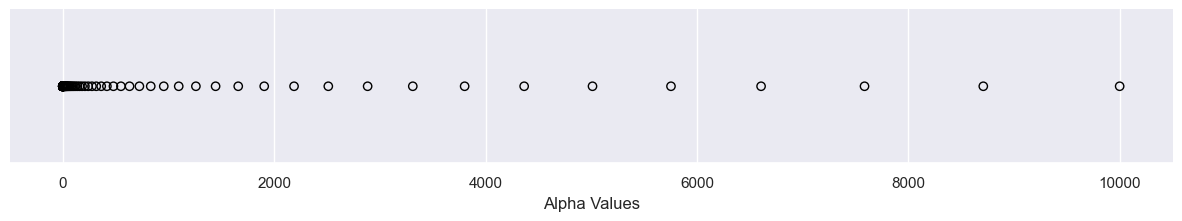

In [166]:
alphas = np.logspace(-5, 4, 151) # log scale increase exponentantly,  quickly go through different magnitude
# (best alpha=2000, => aroung 2000=> a linear scale around 2000)

plt.figure(figsize=(15, 2))
plt.scatter(alphas, np.zeros(alphas.shape), facecolor='None', edgecolor='black')
sns.despine()
plt.yticks([])
plt.gca().spines['left'].set_visible(False)
plt.xlabel('Alpha Values');

In [167]:
rigcv = RidgeCV(alphas=alphas, cv=5)
rigcv.fit(X_train_standard,Y_train_log)
best_ridge = Ridge(alpha=rigcv.alpha_)

print('The best alpha of ridge is: ',rigcv.alpha_)

print("Accuracy on training set:", rigcv.score(X_train_standard, Y_train_log)*100)

The best alpha of ridge is:  17.378008287493763
Accuracy on training set: 74.17330626135485


In [168]:
x = pd.DataFrame(ridge_train)
rigcv_importance = pd.DataFrame({'feature': x.columns, 'importance': rigcv.coef_})
rigcv_fe = rigcv_importance.sort_values('importance', ascending=False)[:10]
rigcv_fe

feature  importance
5                    accommodates    0.226857
25                         Sydney    0.147696
6                        bedrooms    0.145499
69       log-review_scores_rating    0.096545
65                  log-longitude    0.092395
27                       Waverley    0.090936
18                          Manly    0.087977
40               sutherland shire    0.082649
73  log-review_scores_cleanliness    0.075960
22                      Pittwater    0.073384

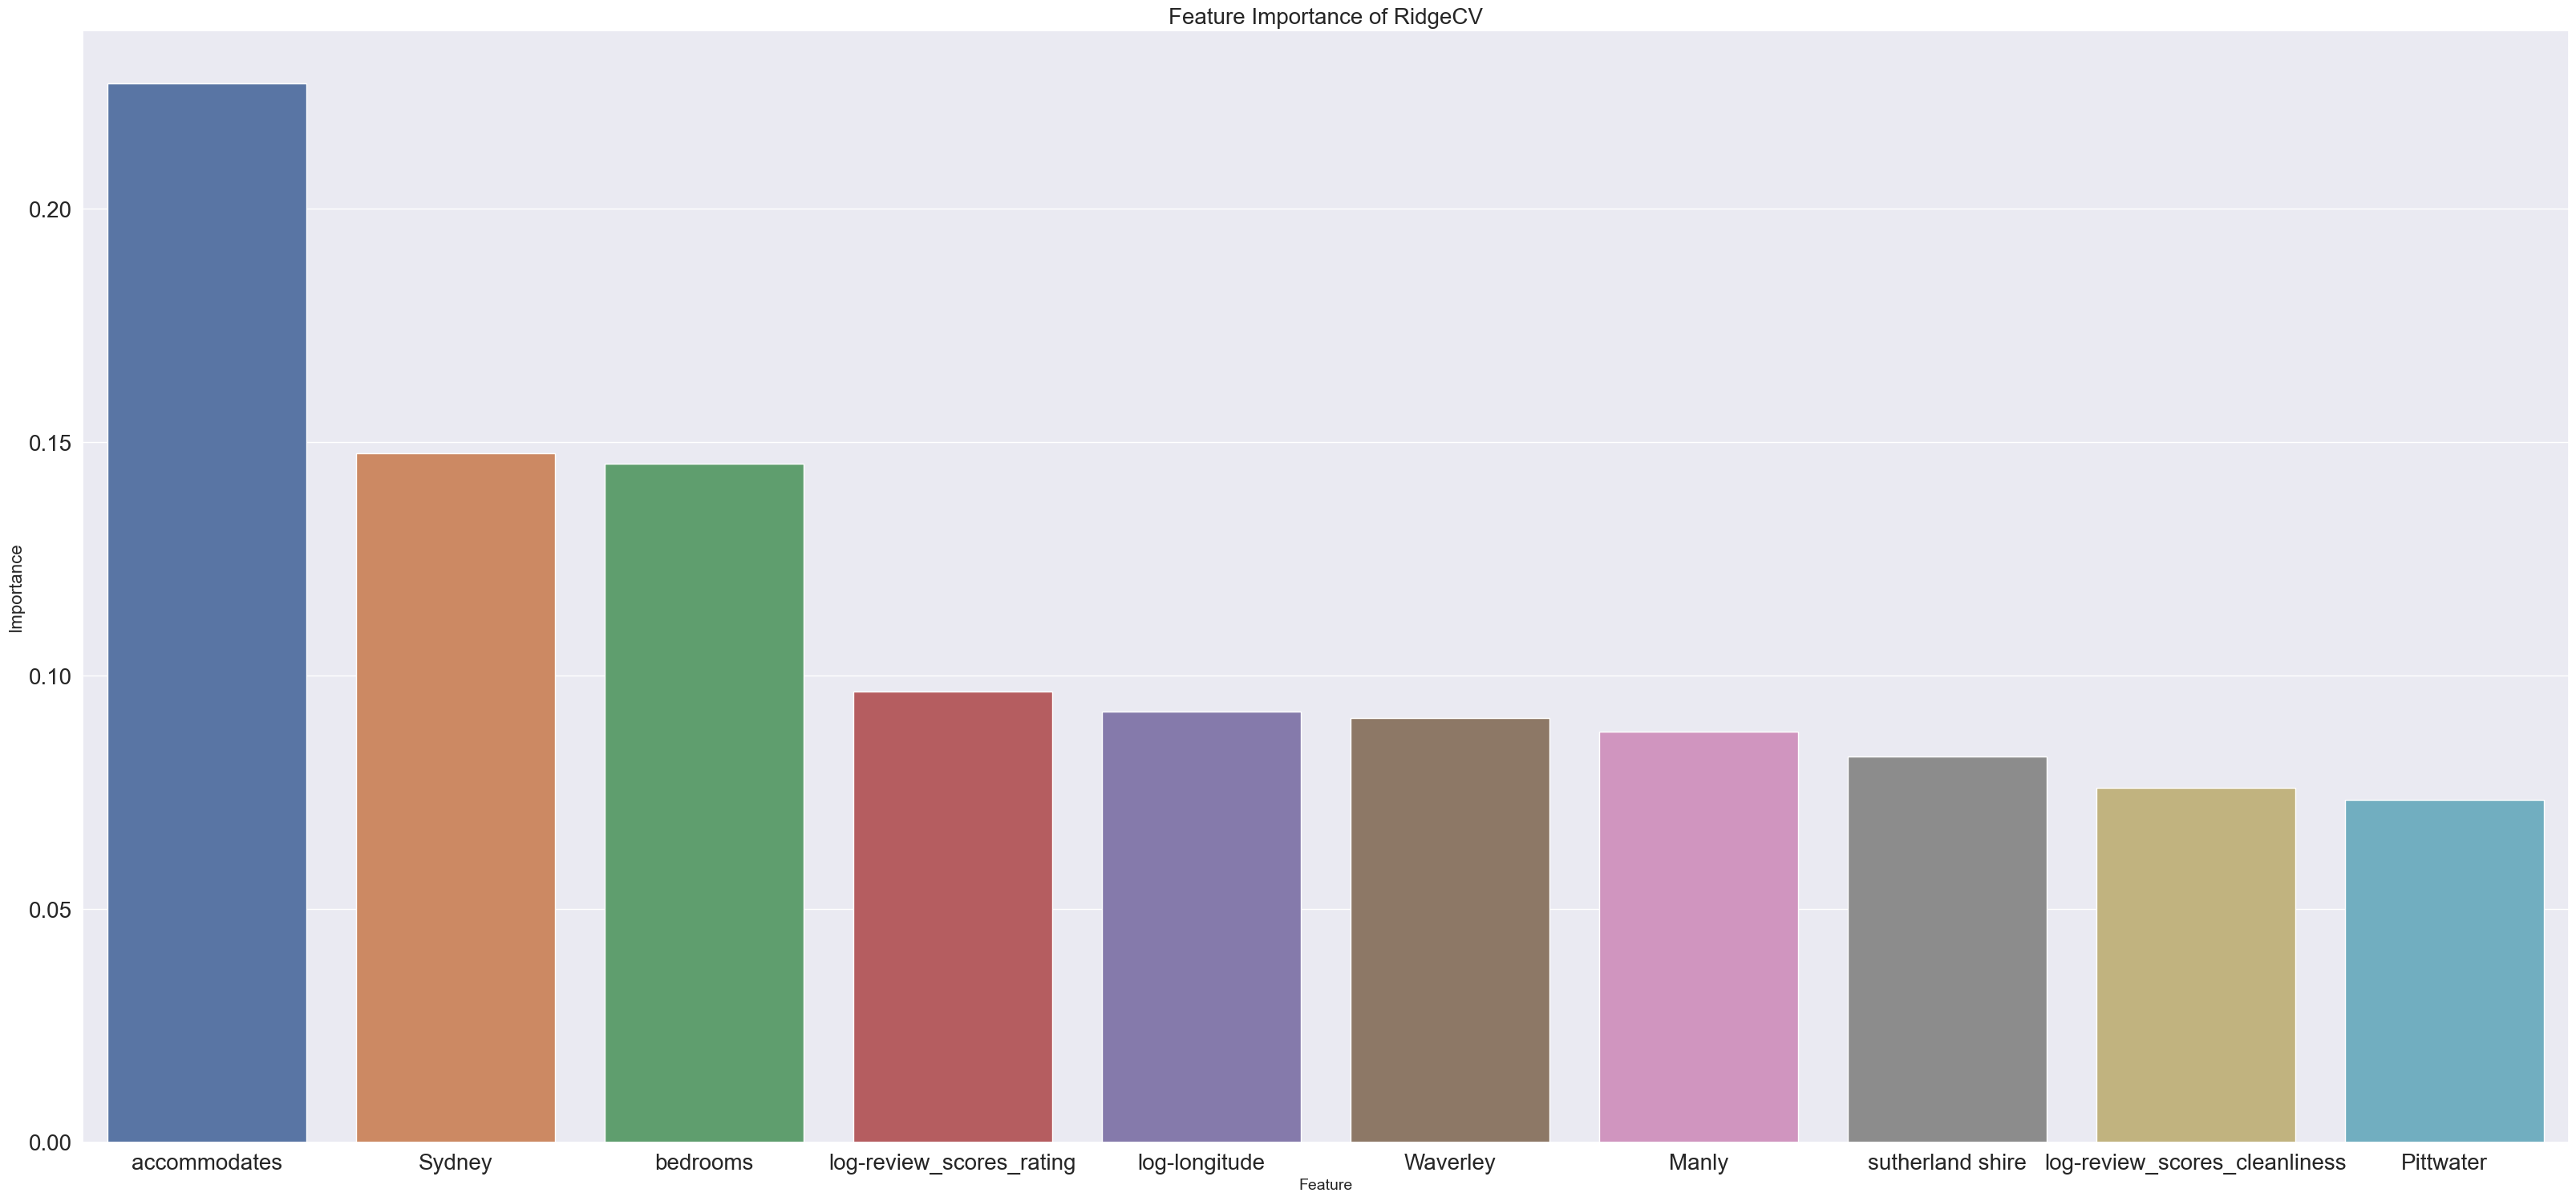

In [169]:
plt.figure(figsize=(40, 18))
sns.barplot(x='feature', y='importance', data=rigcv_fe)
plt.xlabel('Feature', fontsize=14);
plt.ylabel('Importance', fontsize=16);
plt.title('Feature Importance of RidgeCV', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [170]:
rig_train_RMSE = mean_squared_error(np.exp(rigcv.predict(X_train_standard)), Y_train, squared=False)

print("RMSE on trainig set:", rig_train_RMSE)


RMSE on trainig set: 136.15940157668064


In [171]:
preds_rf = np.exp(rigcv.predict(X_test_standard))
submission = pd.DataFrame(np.c_[test.index,preds_rf],columns = ['id','price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('modelridge.csv', index=False)

### <font color = '#e64626'><a id='model_2'>4.2. Model 2: *Decision Tree Regressor*</a></font>

In [172]:
DT_train = train.copy()
DT_test = test.copy()

In [173]:
#param_grid={'max_depth': [3,4,5,6,7,8,9,10],'min_samples_leaf':[10,20,30,40,50],'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}
#tree = DecisionTreeRegressor()
#grid_search = GridSearchCV(tree, param_grid, cv=5)
#grid_search.fit(DT_train, Y_train_log)


#print("Train set score: {:.4f}".format(grid_search.score(DT_train, Y_train_log)))
#print("Best parameters: {}".format(grid_search.best_params_))
#print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
#print("Best estimator:\n{}".format(grid_search.best_estimator_))

Train set score: 0.7330
Best parameters: {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 30}
Best cross-validation score: 0.6576
Best estimator:
DecisionTreeRegressor(max_depth=8, min_samples_leaf=30)


Train set score: 0.7330
Best parameters: {'criterion': 'squared_error', 'max_depth': 8, 'min_samples_leaf': 30}
Best cross-validation score: 0.6576
Best estimator:
DecisionTreeRegressor(max_depth=8, min_samples_leaf=30)

In [174]:
tree = DecisionTreeRegressor(criterion='squared_error',max_depth=8, min_samples_leaf =30)
path = tree.cost_complexity_pruning_path(DT_train, Y_train_log)

model = DecisionTreeRegressor(criterion='squared_error',max_depth=8, min_samples_leaf =30)

tuning_parameters = {'ccp_alpha': path.ccp_alphas,}
tree_cv = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False)
tree_cv.fit(DT_train, Y_train_log)

tree = tree_cv.best_estimator_
tree_cv.best_params_

{'ccp_alpha': 0.00011287576644913432}

In [175]:
print("Accuracy on all trainig set:", tree_cv.score(DT_train, Y_train_log)*100)  

Accuracy on all trainig set: 73.23910951530041


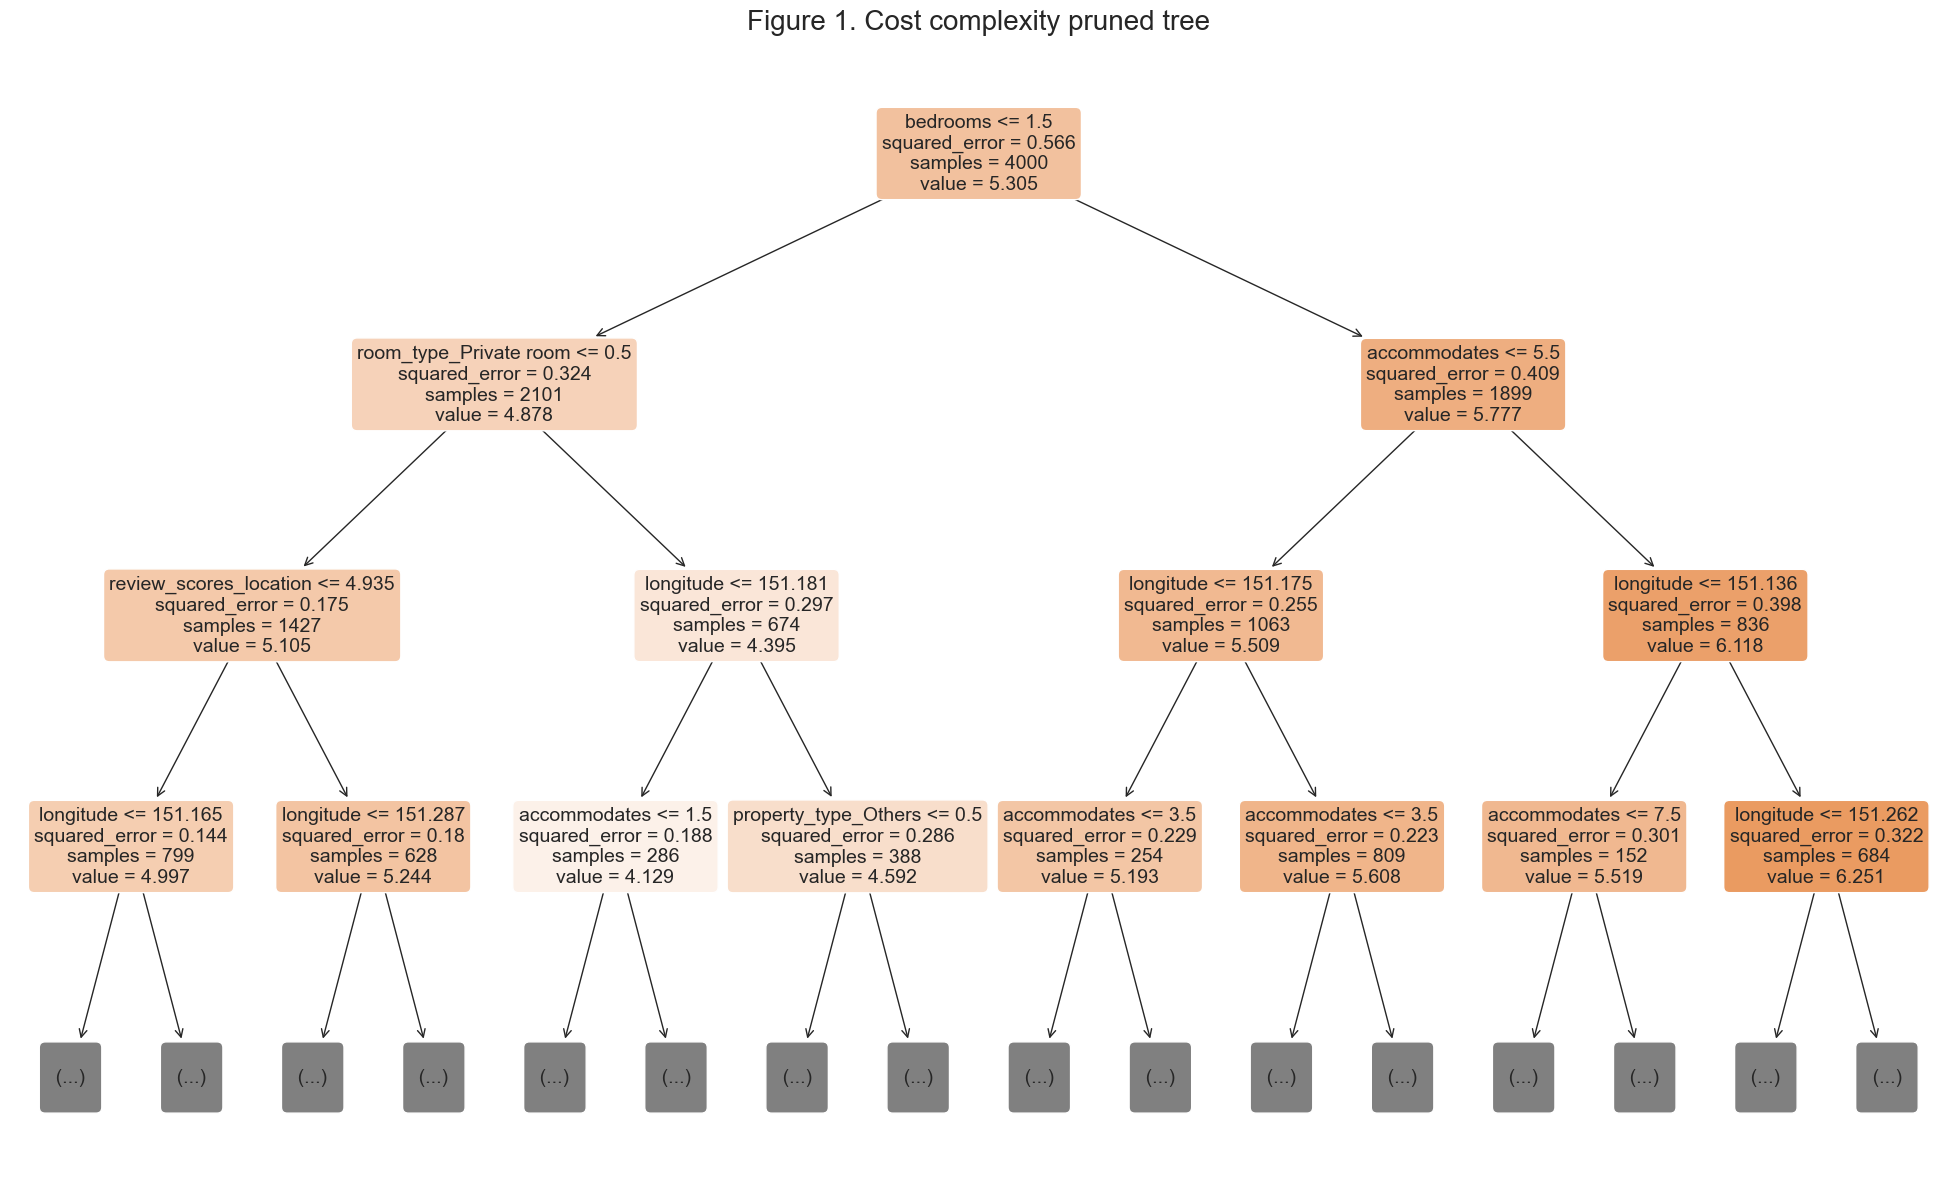

In [176]:
x = pd.DataFrame(DT_train)
plt.figure(figsize=(25, 15))

# max_depth: can look only the top layers, important features
# no one will look at the report with a huge tree
plot_tree(tree, rounded=True, filled=True, feature_names=x.columns, max_depth=3, fontsize=14)
plt.title('Figure 1. Cost complexity pruned tree', fontsize=20);

In [177]:
#build a decision tree classifier
tree_cv = DecisionTreeRegressor(criterion='squared_error',max_depth=8, min_samples_leaf =30)
tree_cv.fit(DT_train, Y_train_log)
print("Accuracy on all trainig set:", tree.score(DT_train, Y_train_log)*100)  

Accuracy on all trainig set: 73.23910951530041


In [178]:
x = pd.DataFrame(DT_train)
DT_importance = pd.DataFrame({'feature': x.columns, 'importance': tree_cv.feature_importances_})
DT_fe = DT_importance.sort_values('importance', ascending=False)[:10]
DT_fe

feature  importance
8                 bedrooms    0.493327
7             accommodates    0.142275
29  room_type_Private room    0.139083
6                longitude    0.113152
13    review_scores_rating    0.019245
18  review_scores_location    0.016405
10          minimum_nights    0.011220
24    property_type_Others    0.010357
12       number_of_reviews    0.009057
5                 latitude    0.008047

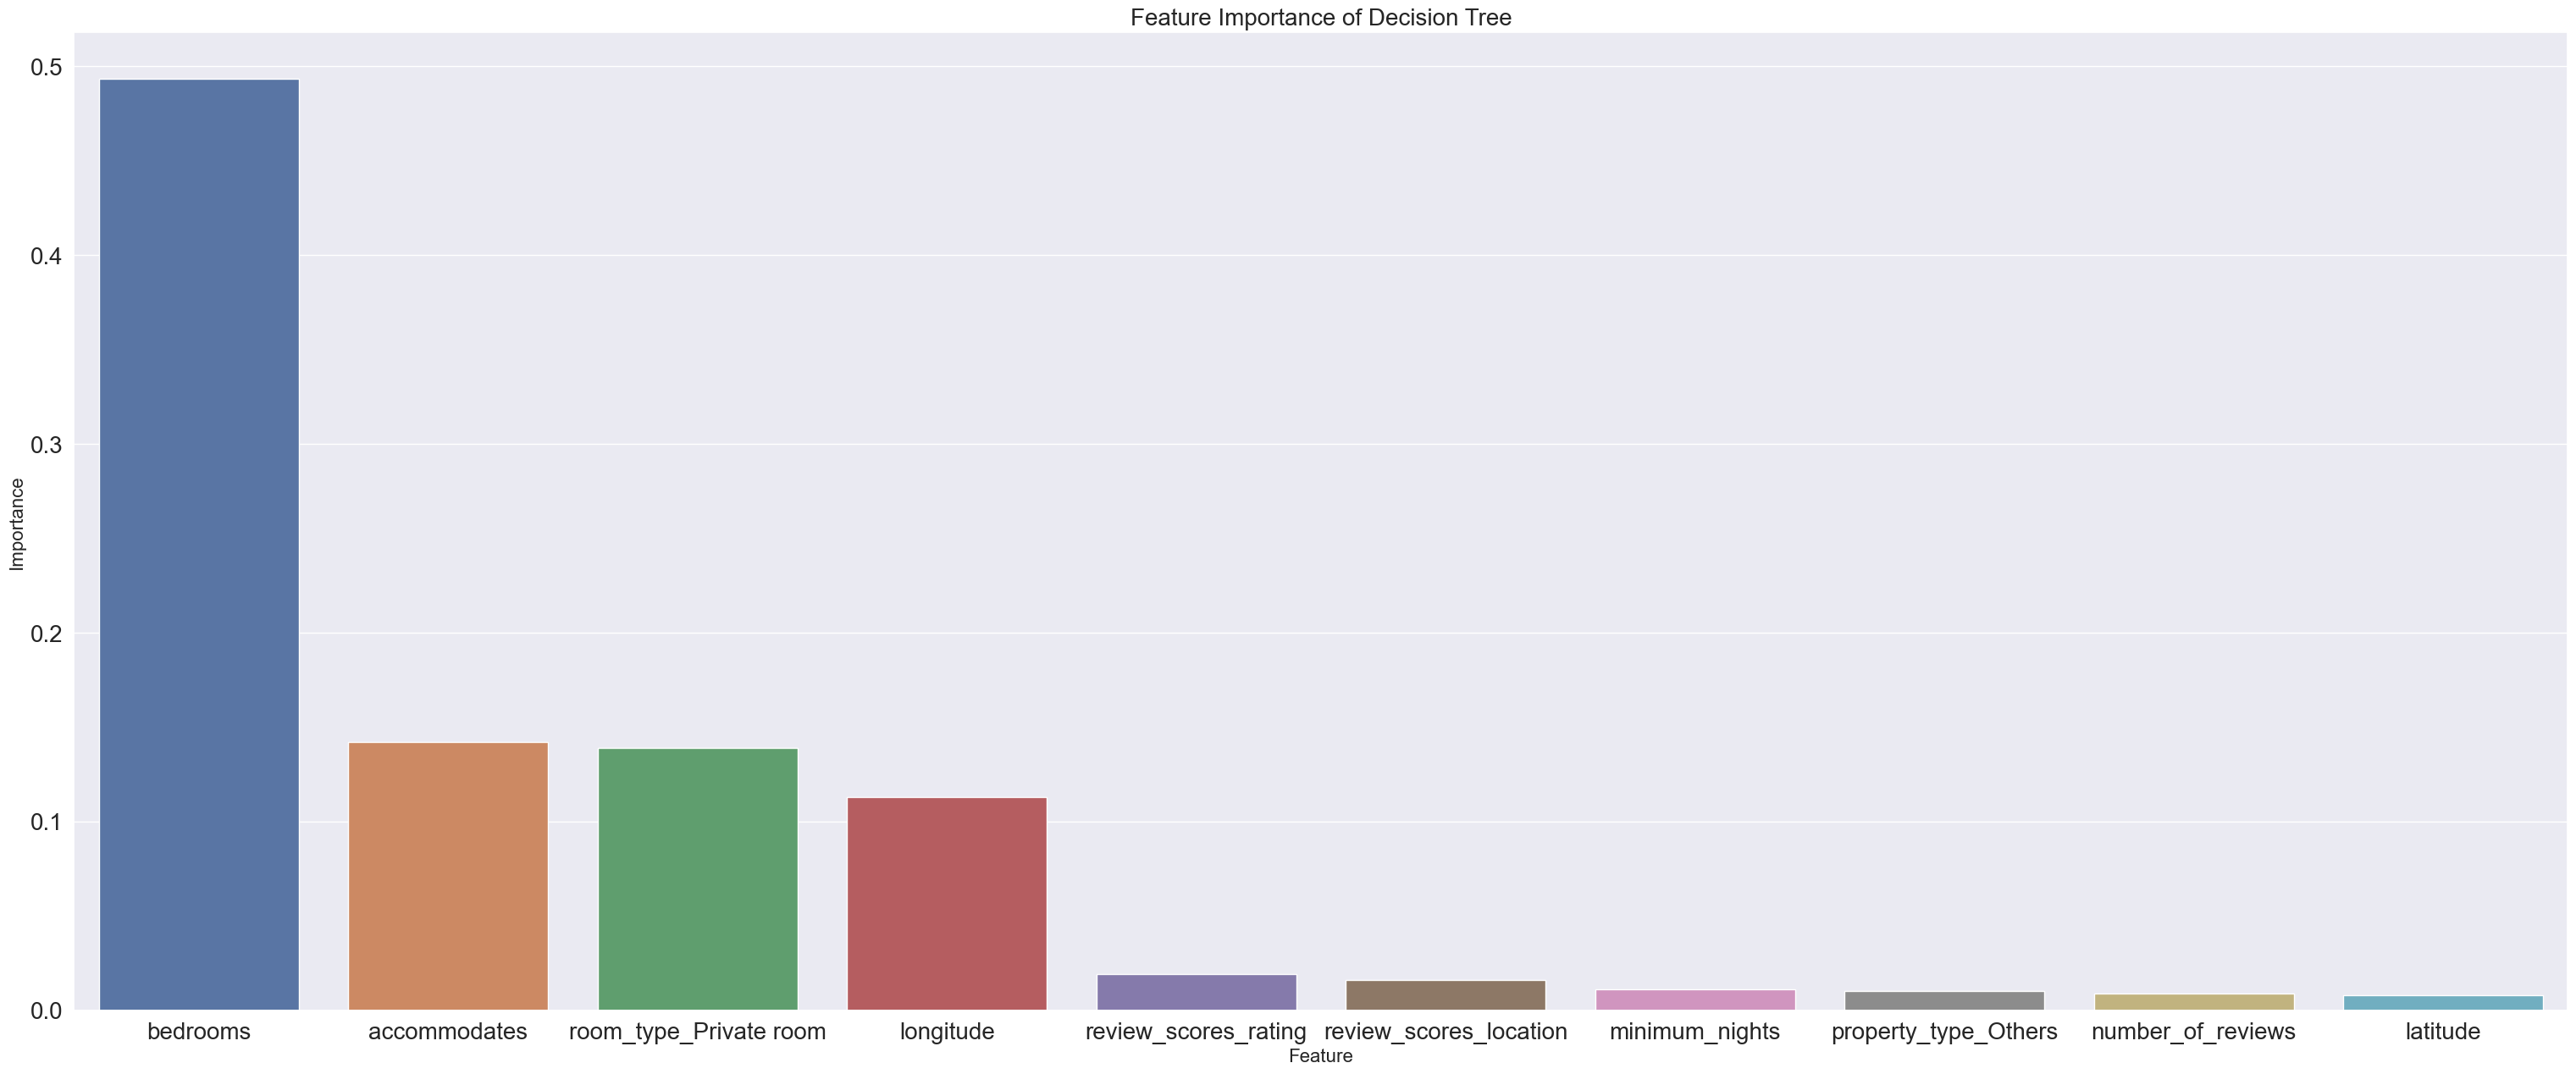

In [179]:
plt.figure(figsize=(38, 15))

sns.barplot(x='feature', y='importance', data=DT_fe)
plt.xlabel('Feature', fontsize=16);
plt.ylabel('Importance', fontsize=16);
plt.title('Feature Importance of Decision Tree', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)


In [180]:
tree_predictions = tree_cv.predict(DT_train)
tree_rmse = mean_squared_error(np.exp(tree_predictions),Y_train,squared=False)

print('RMSE on training set: ',tree_rmse)

RMSE on training set:  137.76006143689594


In [181]:
preds_tree = np.exp(tree_cv.predict(DT_test))
submission = pd.DataFrame(np.c_[test.index,preds_tree],columns = ['id','price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('modeltree.csv', index=False)

### <font color = '#e64626'><a id='model_3'>4.2. Model 3: *Random Forest Regressor*</a></font>

In [182]:
rf_train = train.copy()
rf_test = test.copy()

In [183]:
#param_grid={'max_depth': [10,15,20,25,30],
#        'min_samples_leaf':[10,20,30,40,50],
#        'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}
#rf = RandomForestRegressor(n_estimators=100)
#rf_model = GridSearchCV(rf, param_grid, cv=5)
#rf_model.fit(rf_train, Y_train_log)


#print("Train set score: {:.4f}".format(rf_model.score(rf_train, Y_train_log)))
#print("Best parameters: {}".format(rf_model.best_params_))
#print("Best cross-validation score: {:.4f}".format(rf_model.best_score_))
#print("Best estimator:\n{}".format(rf_model.best_estimator_))

Train set score: 0.8379
Best parameters: {'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 10}
Best cross-validation score: 0.7299
Best estimator:
RandomForestRegressor(max_depth=15, min_samples_leaf=10)


Train set score: 0.8379
Best parameters: {'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 10}
Best cross-validation score: 0.7299
Best estimator:
RandomForestRegressor(max_depth=15, min_samples_leaf=10)

In [184]:
rf_reg = (RandomForestRegressor(n_estimators=1000,max_depth=15,min_samples_leaf = 10,criterion = 'friedman_mse'))
rf_reg = rf_reg.fit(rf_train,Y_train_log)

print("Accuracy on trainig set:", rf_reg.score(rf_train,Y_train_log)*100) 

Accuracy on trainig set: 84.03556107029299


In [185]:
rf_predictions = rf_reg.predict(rf_train)
rf_rmse = mean_squared_error(np.exp(rf_predictions),Y_train,squared=False)

print('RMSE on training set: ',rf_rmse)

RMSE on training set:  113.65121774496777


In [186]:
X = pd.DataFrame(rf_train)
rf_coefficients = pd.DataFrame({'feature': X.columns, 'importance': rf_reg.feature_importances_})
rf_coeffi=rf_coefficients.sort_values('importance', ascending=False)[:10]
rf_coeffi

feature  importance
8                 bedrooms    0.410844
7             accommodates    0.149955
29  room_type_Private room    0.126576
6                longitude    0.104637
18  review_scores_location    0.025075
13    review_scores_rating    0.019520
5                 latitude    0.018724
10          minimum_nights    0.014242
19     review_scores_value    0.011928
12       number_of_reviews    0.011722

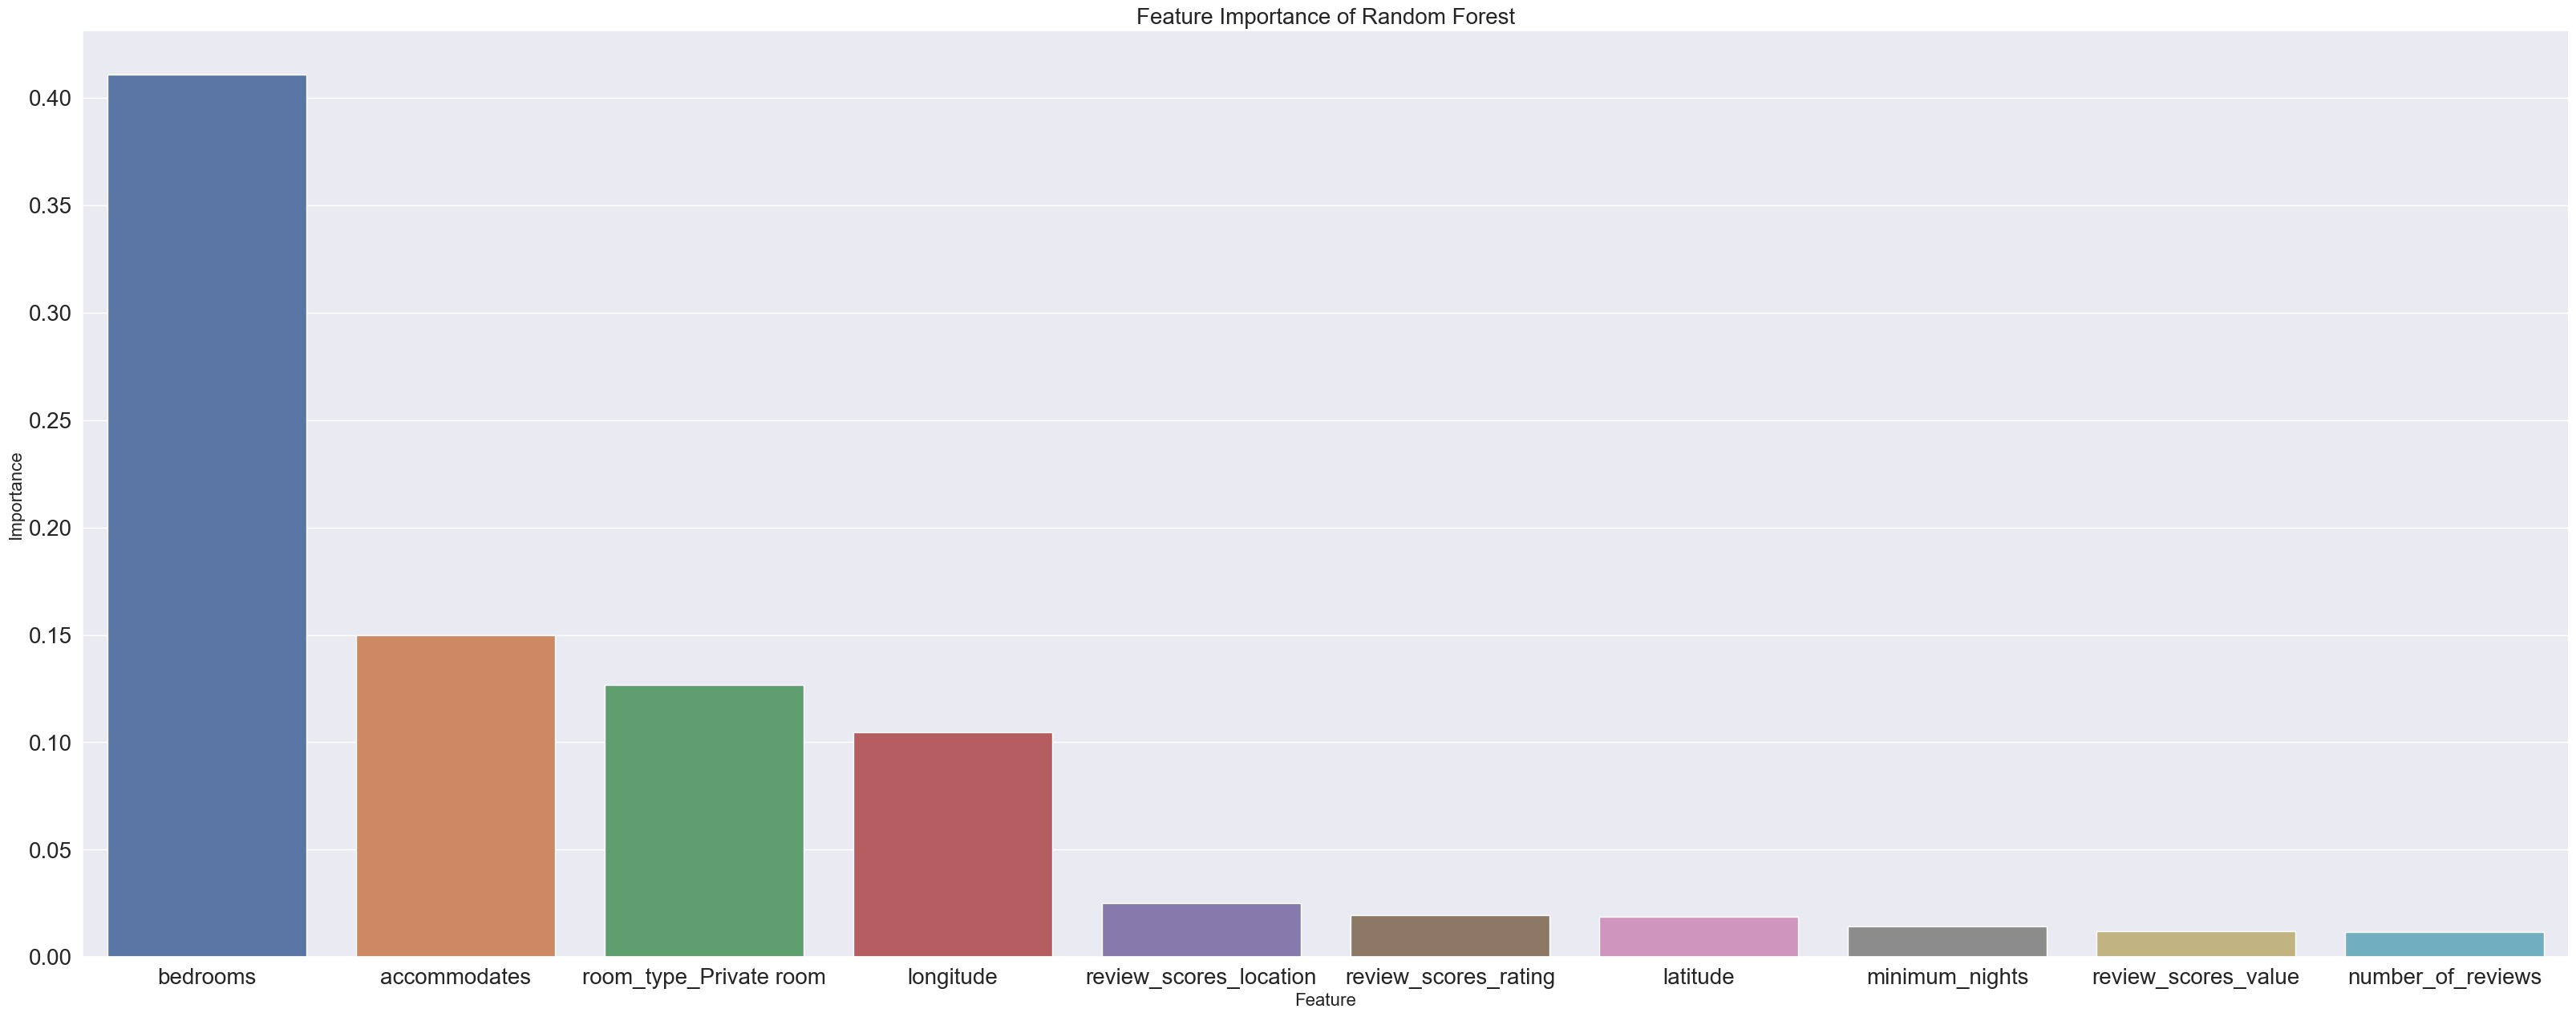

In [187]:
plt.figure(figsize=(40, 15))
sns.barplot(x='feature', y='importance', data=rf_coeffi)
plt.xlabel('Feature', fontsize=16);
plt.ylabel('Importance', fontsize=16);
plt.title('Feature Importance of Random Forest', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [188]:
preds_rf= np.exp(rf_reg.predict(rf_test))
submission = pd.DataFrame(np.c_[test.index,preds_rf],columns = ['id','price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('modelrf.csv', index=False)

### <font color = '#e64626'><a id='model_4'>4.2. Model 4: *XGBoost*</a></font>

In [189]:
xgb_train = train.copy()
xgb_test = test.copy()

In [190]:
#param_grid={'max_depth':[2,3,4,5,6,7],'min_child_weight':[1,2,3,4,5],'n_estimators':[100,200,400,600]}
#xgb_model = xgb.XGBRegressor()
#grid_search =GridSearchCV(xgb_model, param_grid,cv = 5)
#grid_search.fit(xgb_train, Y_train_log)

#print("Train set score: {:.4f}".format(grid_search.score(xgb_train, Y_train_log)))
#print("Best parameters: {}".format(grid_search.best_params_))
#print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
#print("Best estimator:\n{}".format(grid_search.best_estimator_))

Train set score: 0.9033
Best parameters: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
Best cross-validation score: 0.7669
Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


Train set score: 0.9033
Best parameters: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
Best cross-validation score: 0.7669
Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [191]:
xgb_reg = (xgb.XGBRegressor(n_estimators=200,max_depth=3,min_child_weight = 2))
xgb_reg = xgb_reg.fit(xgb_train,Y_train_log)

print("Accuracy on trainig set:", xgb_reg.score(xgb_train,Y_train_log)*100) 


Accuracy on trainig set: 90.33210344345864


In [192]:
xgb_predictions = xgb_reg.predict(xgb_train)
xgb_rmse = mean_squared_error(np.exp(xgb_predictions),Y_train,squared=False)

print('RMSE on training set: ',xgb_rmse)

RMSE on training set:  83.38261931682354


In [193]:
xgb_coefficients = pd.DataFrame({'feature': xgb_train.columns, 'importance': xgb_reg.feature_importances_})
xgbfe = xgb_coefficients.sort_values('importance', ascending=False)[:10]
xgbfe

feature  importance
29              room_type_Private room    0.291041
8                             bedrooms    0.239376
22           property_type_Entire home    0.101158
7                         accommodates    0.072751
34                              Others    0.042195
25  property_type_Private room in home    0.035241
62                          Waterfront    0.015239
18              review_scores_location    0.009989
59                        Private pool    0.009873
38                              Sydney    0.009249

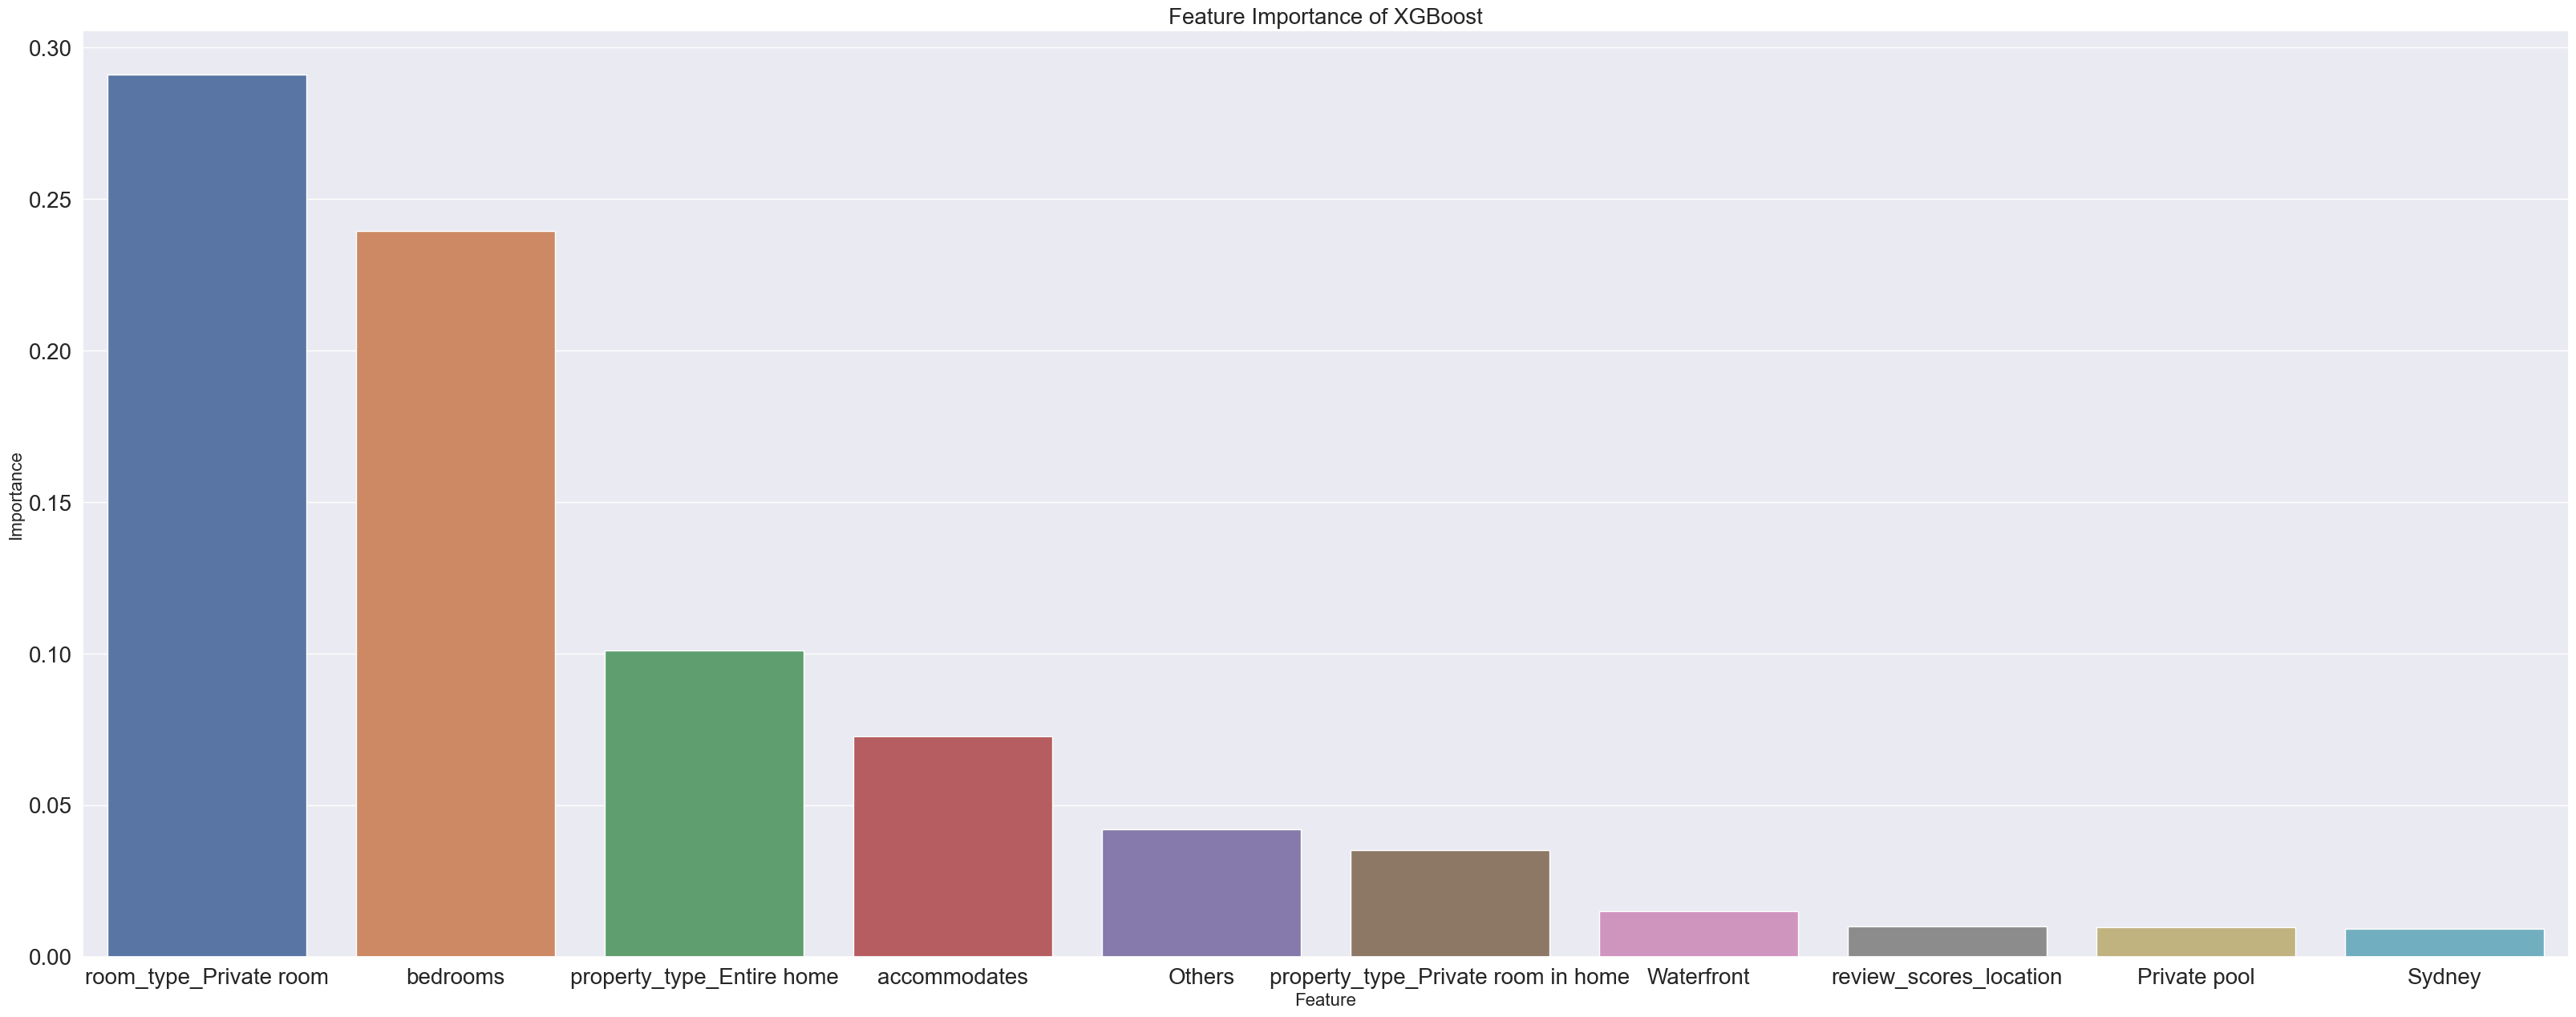

In [194]:
plt.figure(figsize=(40, 15))
sns.barplot(x='feature', y='importance', data=xgbfe)
plt.xlabel('Feature', fontsize=16);
plt.ylabel('Importance', fontsize=16);
plt.title('Feature Importance of XGBoost', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)


In [195]:
preds_xbg= np.exp(xgb_reg.predict(xgb_test))
submission = pd.DataFrame(np.c_[test.index,preds_xbg],columns = ['id','price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('modelxgb.csv', index=False)

### <font color = '#e64626'><a id='mode_5'>4.2. Model 5: *Stacking Model*</a></font>

In [197]:
stack_train = train.copy()
stack_test = test.copy()

best_lascv = rigcv # lasso model
best_DT = tree_cv # decision Tree
best_rfreg = rf_reg # Random Forest model
best_xgb = xgb_reg # xgb model 

In [198]:
#estimators_1 = [('Ridge Regression',best_lascv),('Decision Tree',best_DT)]

#stack = StackingRegressor(estimators=estimators_1, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_1 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)


#estimators_2 = [('Decision Tree',best_DT),('xgBoost',best_xgb)]
#stack = StackingRegressor(estimators=estimators_2, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_2 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)


#estimators_3 = [('Random Forest',best_rfreg),('Ridge Regression',best_lascv)]
#stack = StackingRegressor(estimators=estimators_3, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_3 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)


#estimators_4 = [('xgBoost',best_xgb),('Random Forest',best_rfreg)]
#stack = StackingRegressor(estimators=estimators_4, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_4 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)


#estimators_5 = [('Ridge Regression',best_lascv),('xgBoost',best_xgb)]
#stack = StackingRegressor(estimators=estimators_5, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_5 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)

In [ ]:
#print('Ridge Regression + DT', round(score_1, 3))
#print('DT + XGB', round(score_2, 3))
#print('RF + Ridge Regression', round(score_3, 3))
#print('XGB + RF', round(score_4, 3))
#print('Ridge Regression + XGB', round(score_5, 3))

| combined models      |   REMSE |\
+==========+=========+\
| Ridge Regression + DT  | 131.343 |\
+------------------------+---------+\
| DT + XGB           |  86.694 |\
+------------------------+---------+\
| RF + Ridge Regression  | 115.584 |\
+------------------------+---------+\
| XGB + RF           |  86.903 |\
+------------------------+---------+\
| Ridge Regression + XGB |  93.368 |\

In [201]:
#estimators_1 = [('Ridge Regression', best_lascv), ('Random Forest', rf_reg), ('xgBoost', xgb_reg)]

#stack = StackingRegressor(estimators=estimators_1, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_6 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)


#estimators_2 = [('DT',best_DT),('XGB',best_xgb),('Ridge Regression', rigcv)]
#stack = StackingRegressor(estimators=estimators_1, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_7 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)


#estimators_3 = [('Random Forest',best_rfreg),('Ridge Regression',best_lascv),('DT',best_DT)]
#stack = StackingRegressor(estimators=estimators_1, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_8 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)

#estimators_4 = [('Random Forest',best_rfreg),('xgBoost', xgb_reg),('DT',best_DT)]
#stack = StackingRegressor(estimators=estimators_1, cv = 10)
#stack.fit(stack_train, Y_train_log)
#stack_predictions = stack.predict(stack_train)
#score_9 = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)

In [ ]:
#print('Ridge Regression + RF+xgBoost: ', round(score_6, 3))
#print('DT + xgBoost + Ridge Regression ', round(score_7, 3))
#print('RF + Ridge Regression + DT', round(score_8, 3))
#print('RF + xgBoost + DT', round(score_9, 3))
#print('Ridge Regression + RF + xgBoost + DT', round(score_10, 3))

+--------------------------------------+---------+\
| combined models                |   REMSE |\
+==================+==============================+\
| Ridge Regression + RF+xgBoost      |  91.568 |\
+--------------------------------------+---------+\
| DT + xgBoost + Ridge Regression     |  91.564 |\
+--------------------------------------+---------+\
| RF + Ridge Regression + DT        |  91.609 |\
+--------------------------------------+---------+\
| RF + xgBoost + DT               |  91.648 |\
+--------------------------------------+---------+\
| Ridge Regression + RF + xgBoost + DT |  89.773 |\
+--------------------------------------+---------+

##According to result of RMSE, choose the some of them as the first layer regression. 

In [213]:
estimators = [('xgBoost', xgb_reg),('Random Forest',best_rfreg),('Ridge Regression',best_lascv)]
stack = StackingRegressor(estimators, final_estimator=best_lascv, 
                           cv=5)

stack.fit(stack_train, Y_train_log)
stack_predictions = stack.predict(stack_train)
stack_rmse = mean_squared_error(np.exp(stack_predictions),Y_train,squared=False)
print('RMSE on training set: ',stack_rmse)

RMSE on training set:  92.46245756939476


In [ ]:
preds_stack  = np.exp(stack.predict(stack_test))
submission = pd.DataFrame(np.c_[test.index,preds_stack],columns = ['id','price'])
submission['id'] = submission['id'].astype('int')
submission.to_csv('modelstack.csv', index=False)

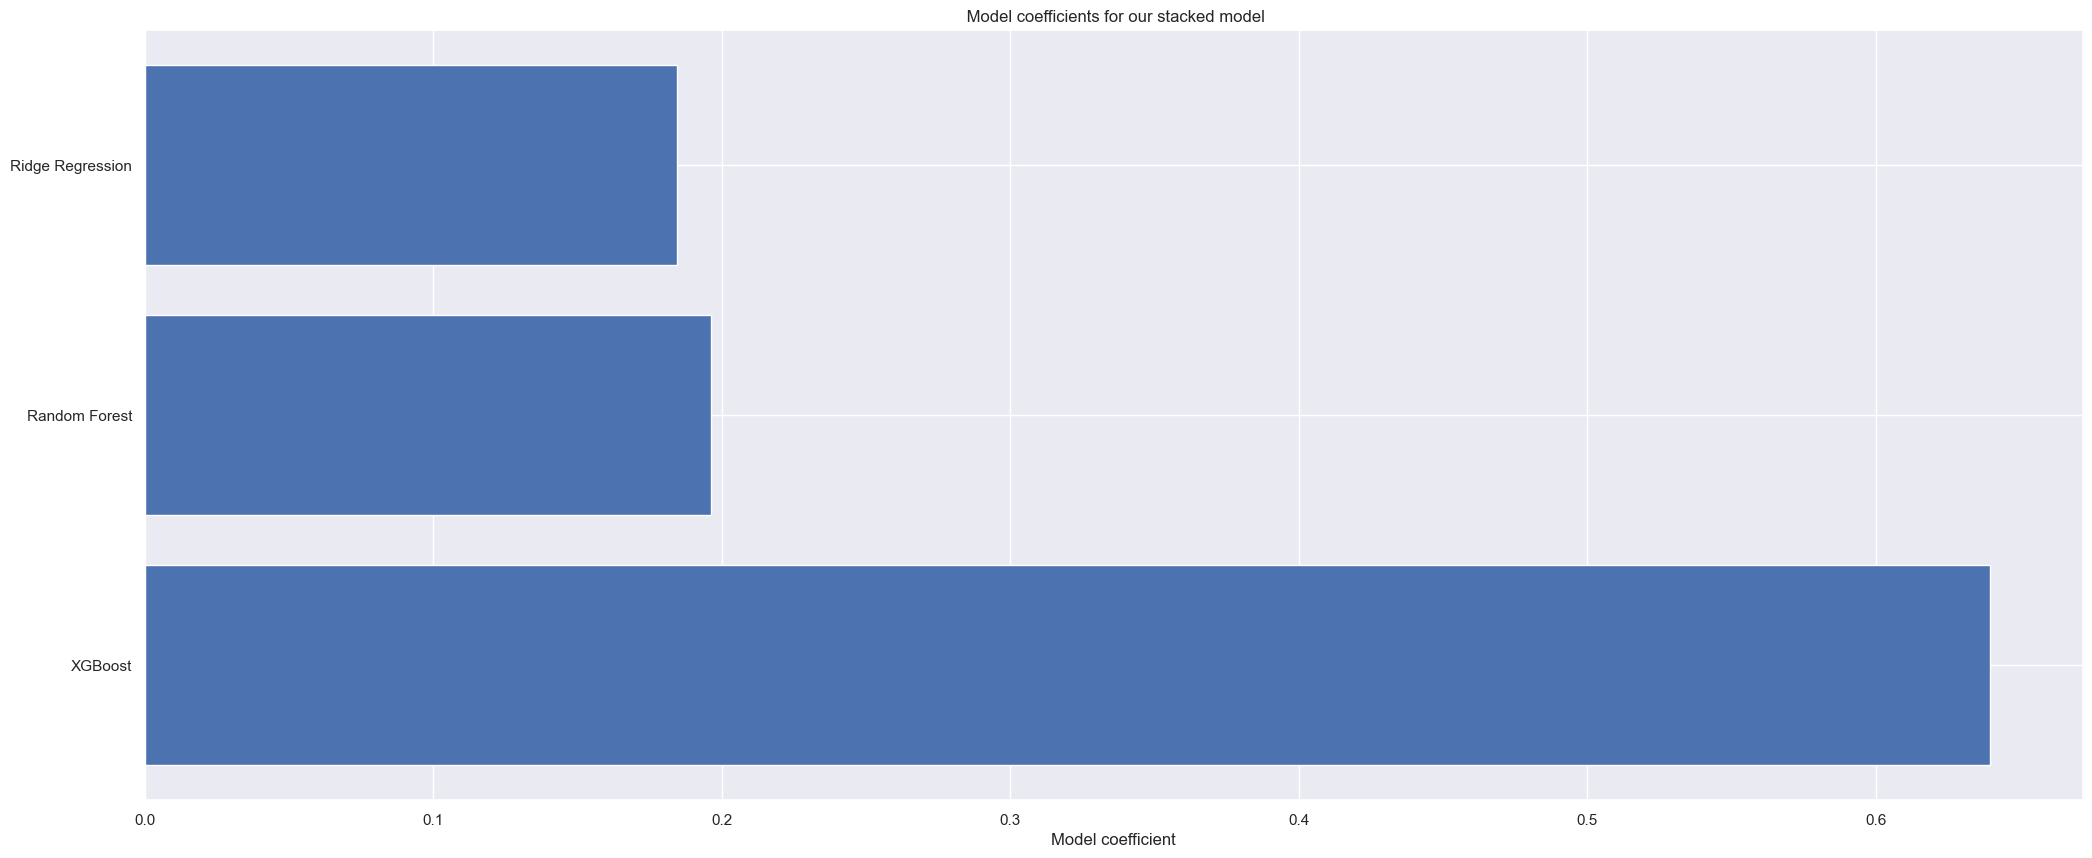

In [214]:
plt.barh(np.arange(3), stack.final_estimator_.coef_)
plt.yticks(np.arange(3), [ 'XGBoost','Random Forest','Ridge Regression']);
plt.xlabel('Model coefficient')
plt.title(' Model coefficients for our stacked model');